# Keypoints imagenes CaVFish Colombia 

# HRNet

#### Organizar archivo json a partir del xml de CVAT

In [ ]:
###
#Se extrae la etiqueta de la forma del pez y 20 keypoints para 1758 spp. a partir de xml (CVAT)
##

import json
import numpy as np
from lxml import etree
from pathlib import Path
from tqdm import tqdm

# === CONFIGURA TUS RUTAS AQUÍ ===
xml_folder_path = Path("/data/Datasets/Fish/CavFish/xml/")  # Carpeta que contiene los XML
output_path = Path("/data/Datasets/Fish/CavFish/fisk_all_20kpts_2025.json")
padding = 10  # píxeles extra para las bboxes

# === INICIALIZAR ESTRUCTURA COCO ===
coco_output = {
    "images": [],
    "annotations": [],
    "categories": [{
        "id": 1,
        "name": "fish",
        "keypoints": [str(i) for i in range(1, 21)],  # 20 keypoints
        "skeleton": []
    }]
}

annotation_id = 1
image_global_id = 1  # Para evitar conflictos de ID entre archivos

def compute_bbox_from_keypoints(kpts, image_width, image_height, pad=10):
    points = np.array(kpts).reshape(-1, 3)
    visible = points[:, 2] > 0
    if not np.any(visible):
        return [0, 0, image_width, image_height]
    x_coords = points[visible, 0]
    y_coords = points[visible, 1]
    x_min = max(0, x_coords.min() - pad)
    y_min = max(0, y_coords.min() - pad)
    x_max = min(image_width, x_coords.max() + pad)
    y_max = min(image_height, y_coords.max() + pad)
    return [float(x_min), float(y_min), float(x_max - x_min), float(y_max - y_min)]

# === PROCESAR TODOS LOS ARCHIVOS XML ===
xml_files = list(xml_folder_path.glob("*.xml"))

for xml_file in tqdm(xml_files, desc="Procesando archivos XML"):
    with open(xml_file, "rb") as f:
        tree = etree.parse(f)

    images = tree.xpath("//image")

    for img_elem in images:
        local_img_id = int(img_elem.attrib["id"])
        img_name = img_elem.attrib["name"]
        width = int(img_elem.attrib["width"])
        height = int(img_elem.attrib["height"])

        tag_elem = img_elem.find("tag")
        label = tag_elem.attrib["label"] if tag_elem is not None else "unknown"

        coco_output["images"].append({
            "id": image_global_id,
            "file_name": img_name,
            "width": width,
            "height": height,
            "label": label
        })

        kpts = [0] * 20 * 3
        num_keypoints = 0

        for point in img_elem.xpath("points"):
            label_point = point.attrib["label"]
            if label_point.isdigit() and 1 <= int(label_point) <= 20:
                idx = int(label_point) - 1
                x, y = map(float, point.attrib["points"].split(","))
                kpts[idx * 3: idx * 3 + 3] = [x, y, 2]
                num_keypoints += 1

        if num_keypoints > 0:
            bbox = compute_bbox_from_keypoints(kpts, width, height, padding)
            coco_output["annotations"].append({
                "id": annotation_id,
                "image_id": image_global_id,
                "category_id": 1,
                "keypoints": kpts,
                "num_keypoints": num_keypoints,
                "bbox": bbox,
                "area": bbox[2] * bbox[3],
                "iscrowd": 0
            })
            annotation_id += 1

        image_global_id += 1

# === GUARDAR JSON UNIFICADO ===
with open(output_path, "w") as f:
    json.dump(coco_output, f, indent=2)

print(f"Listo: JSON unificado guardado en {output_path}")


Procesando archivos XML: 100%|██████████| 12/12 [00:00<00:00, 27.68it/s]


Listo: JSON unificado guardado en /data/Datasets/Fish/CavFish/fisk_all_20kpts_2025.json


In [ ]:
###
#Se extrae la etiqueta y ruta de imagenes de 20 keypoints para 1758 spp. a partir de xml (CVAT)
###

import json
import numpy as np
from lxml import etree
from pathlib import Path
from tqdm import tqdm

# === CONFIGURA TUS RUTAS AQUÍ ===
xml_folder_path = Path("/data/Datasets/Fish/CavFish/xml/")
images_base_path = Path("/data/Datasets/Fish/CavFish/")  # Base donde están las subcarpetas de imágenes
output_path = Path("/data/Datasets/Fish/CavFish/fisk_all_20kpts_2025.json")
padding = 10  # píxeles extra para las bboxes

# === INICIALIZAR ESTRUCTURA COCO ===
coco_output = {
    "images": [],
    "annotations": [],
    "categories": [{
        "id": 1,
        "name": "fish",
        "keypoints": [str(i) for i in range(1, 21)],
        "skeleton": []
    }]
}

annotation_id = 1
image_global_id = 1

def compute_bbox_from_keypoints(kpts, image_width, image_height, pad=10):
    points = np.array(kpts).reshape(-1, 3)
    visible = points[:, 2] > 0
    if not np.any(visible):
        return [0, 0, image_width, image_height]
    x_coords = points[visible, 0]
    y_coords = points[visible, 1]
    x_min = max(0, x_coords.min() - pad)
    y_min = max(0, y_coords.min() - pad)
    x_max = min(image_width, x_coords.max() + pad)
    y_max = min(image_height, y_coords.max() + pad)
    return [float(x_min), float(y_min), float(x_max - x_min), float(y_max - y_min)]

# === PROCESAR TODOS LOS ARCHIVOS XML ===
xml_files = list(xml_folder_path.glob("*.xml"))

for xml_file in tqdm(xml_files, desc="Procesando XML"):
    with open(xml_file, "rb") as f:
        tree = etree.parse(f)

    images = tree.xpath("//image")

    for img_elem in images:
        local_img_id = int(img_elem.attrib["id"])
        img_name = img_elem.attrib["name"]
        width = int(img_elem.attrib["width"])
        height = int(img_elem.attrib["height"])

        # Buscar ruta real dentro de cualquier subcarpeta de la base
        found = list(images_base_path.rglob(img_name))
        if not found:
            print(f"⚠️ Imagen no encontrada: {img_name}")
            continue

        relative_path = found[0].relative_to(images_base_path)  # ruta con subcarpeta incluida

        tag_elem = img_elem.find("tag")
        label = tag_elem.attrib["label"] if tag_elem is not None else "unknown"

        coco_output["images"].append({
            "id": image_global_id,
            "file_name": str(relative_path),  # ← AQUÍ va con subcarpeta
            "width": width,
            "height": height,
            "label": label
        })

        kpts = [0] * 20 * 3
        num_keypoints = 0

        for point in img_elem.xpath("points"):
            label_point = point.attrib["label"]
            if label_point.isdigit() and 1 <= int(label_point) <= 20:
                idx = int(label_point) - 1
                x, y = map(float, point.attrib["points"].split(","))
                kpts[idx * 3: idx * 3 + 3] = [x, y, 2]
                num_keypoints += 1

        if num_keypoints > 0:
            bbox = compute_bbox_from_keypoints(kpts, width, height, padding)
            coco_output["annotations"].append({
                "id": annotation_id,
                "image_id": image_global_id,
                "category_id": 1,
                "keypoints": kpts,
                "num_keypoints": num_keypoints,
                "bbox": bbox,
                "area": bbox[2] * bbox[3],
                "iscrowd": 0
            })
            annotation_id += 1

        image_global_id += 1

# === GUARDAR JSON UNIFICADO ===
with open(output_path, "w") as f:
    json.dump(coco_output, f, indent=2)

print(f"✅ JSON con rutas relativas guardado en: {output_path}")


Procesando XML: 100%|██████████| 12/12 [00:05<00:00,  2.38it/s]


✅ JSON con rutas relativas guardado en: /data/Datasets/Fish/CavFish/fisk_all_20kpts_2025.json


#### Dividir datos: entrenamiento y validacion

In [14]:
import json
import random
from pathlib import Path

# Load full annotation file (Compressed body as example)
input_path = Path("/data/Datasets/Fish/CavFish/fisk_all_20kpts_2025.json")
with input_path.open("r") as f:
    data = json.load(f)

# Shuffle and split
random.seed(42)
image_ids = list({img["id"] for img in data["images"]})
random.shuffle(image_ids)
split_index = int(0.9 * len(image_ids))
train_ids = set(image_ids[:split_index])
val_ids = set(image_ids[split_index:])

# Build separate image/annotation lists
def split_coco(data, selected_ids):
    return {
        "info": data.get("info", {}),
        "licenses": data.get("licenses", []),
        "images": [img for img in data["images"] if img["id"] in selected_ids],
        "annotations": [ann for ann in data["annotations"] if ann["image_id"] in selected_ids],
        "categories": data["categories"]
    }

train_data = split_coco(data, train_ids)
val_data = split_coco(data, val_ids)

# Save split files
train_path = "/data/Datasets/Fish/CavFish/fish20kpt_all_train.json"
val_path = "/data/Datasets/Fish/CavFish/fish20kpt_all_val.json"
with open(train_path, "w") as f:
    json.dump(train_data, f, indent=2)
with open(val_path, "w") as f:
    json.dump(val_data, f, indent=2)

train_path, val_path

('/data/Datasets/Fish/CavFish/fish20kpt_all_train.json',
 '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json')

# Training _ HRNet

Modificar td-hm_hrnet-w32_8xb32-300e_animalkingdom_P3_fish-256x256_train.py en funcion de :

1. Numero de keypoints
2. Otras modificaciones de parametrso segun sea el caso. Fase 02.

Nota: .py fue modificado unicamnete en funcion de numero de kp.  

In [ ]:
!cd /home/arumota_pupils/Josue/1PECES/MMPose/mmpose


!python tools/train.py \
  /home/arumota_pupils/Josue/1PECES/MMPose/mmpose/configs/animal_2d_keypoint/topdown_heatmap/ak/td-hm_hrnet-w32_8xb32-300e_animalkingdom_P3_fish-256x256_train20.py 
  
#!export PYTHONPATH=$(pwd) && python tools/train.py configs/animal_2d_keypoint/topdown_heatmap/ak/td-hm_hrnet-w32_8xb32-300e_animalkingdom_P3_fish-256x256_train20.py 

# Inferencia_HRNet

Inferencia considerando:

1. Una imagen
2. Varias imagenes
3. Metrcias de evaluacion como RSME, MAE, R2, ...

In [2]:
#Organizar las imagenes de validacion de acuerdo a la division de val(10%). Se mota el json de val como ebtrada oara buscar las imagebnes. Esto evita crear una carpeta con imagens de val
import os
import json
import subprocess

# Config paths
json_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
dataset_root = '/data/Datasets/Fish/CavFish'  # Donde están las subcarpetas con las imágenes
output_folder = '/data/Datasets/Fish/CavFish/inference_20kpt/'
config_path = 'configs/animal_2d_keypoint/topdown_heatmap/ak/td-hm_hrnet-w32_8xb32-300e_animalkingdom_P3_fish-256x256_train20.py'
checkpoint_path = '/data/Josue/weights/Fish/HRNet_20kpt/best_PCK_epoch_110.pth'
merged_json_path = os.path.join(output_folder, 'all_keypoints_predicted20.json')

# Crear carpeta de salida
os.makedirs(output_folder, exist_ok=True)

# Leer JSON
with open(json_path, 'r') as f:
    data = json.load(f)

# Acumular predicciones
all_predictions = []

# Inferencia por imagen
for image_info in data['images']:
    file_name = image_info['file_name']  # Ruta relativa dentro de CavFish/
    full_path = os.path.join(dataset_root, file_name)

    img_name = os.path.basename(full_path)
    out_base = os.path.join(output_folder, img_name)
    out_json = out_base.replace('.jpg', '_keypoints.json').replace('.png', '_keypoints.json')

    if not os.path.exists(full_path):
        print(f"⚠️ Imagen no encontrada: {full_path}")
        continue

    cmd = [
        "python", "demo/image_demo.py",
        full_path,
        config_path,
        checkpoint_path,
        "--out-file", out_base,
        "--draw-heatmap",
        "--show-kpt-idx"
    ]

    print(f"🔁 Procesando {file_name}...")
    subprocess.run(cmd)

    if os.path.exists(out_json):
        with open(out_json, 'r') as f:
            pred = json.load(f)
            all_predictions.append(pred)
    else:
        print(f"⚠️ No se encontró JSON para {img_name}")

# Guardar predicciones consolidadas
with open(merged_json_path, 'w') as f:
    json.dump(all_predictions, f, indent=4)

print(f"\n✅ JSON consolidado guardado en: {merged_json_path}")



🔁 Procesando 2018 Guayavero Duda/IMG_0084-Edit.jpg...
Loads checkpoint by local backend from path: /data/Josue/weights/Fish/HRNet_20kpt/best_PCK_epoch_110.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=296.3, y=1798.1, score=0.957

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_20kpt/IMG_0084-Edit_keypoints.json
 - 1: x=4150.8, y=1987.0, score=0.960

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_20kpt/IMG_0084-Edit_keypoints.json
 - 2: x=1617.8, y=1440.0, score=0.969

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_20kpt/IMG_0084-Edit_keypoints.json
 - 3: x=2253.4, y=2432.6, score=0.901

📝 Coordenadas guardada

In [ ]:
# Se estrae la ruta de la imagen. USado en HRNET final
import os
import json
import subprocess

# Configuración de rutas
json_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
dataset_root = '/data/Datasets/Fish/CavFish'
output_folder = '/data/Datasets/Fish/CavFish/inference_20kpt_HRNET2/'
config_path = 'configs/animal_2d_keypoint/topdown_heatmap/ak/td-hm_hrnet-w32_8xb32-300e_animalkingdom_P3_fish-256x256_train20.py'
checkpoint_path = '/data/Josue/weights/Fish/HRNet_20kpt/best_PCK_epoch_300.pth'
merged_json_path = os.path.join(output_folder, 'all_keypoints_predicted20.json')

# Crear carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Leer el archivo JSON de validación
with open(json_path, 'r') as f:
    val_data = json.load(f)

# Almacenar todas las predicciones
all_predictions = []

# Recorrer cada imagen del archivo de validación
for image_info in val_data['images']:
    relative_path = image_info['file_name']  # ej: "2018 Guayavero Duda/IMG_0084-Edit.jpg"
    full_path = os.path.join(dataset_root, relative_path)

    # Nombre de imagen para guardar outputs
    img_name = os.path.basename(relative_path)
    out_base = os.path.join(output_folder, img_name)
    out_json = out_base.replace('.jpg', '_keypoints.json').replace('.png', '_keypoints.json')

    # Verificación de existencia de imagen
    if not os.path.exists(full_path):
        print(f"⚠️ Imagen no encontrada: {full_path}")
        continue

    # Ejecutar la inferencia
    cmd = [
        "python", "demo/image_demo.py",
        full_path,
        config_path,
        checkpoint_path,
        "--out-file", out_base,
        "--draw-heatmap",
        "--show-kpt-idx"
    ]

    print(f"🔁 Procesando {relative_path}...")
    subprocess.run(cmd)

    # Leer predicción y asociarla a la ruta relativa original (no solo nombre)
    if os.path.exists(out_json):
        with open(out_json, 'r') as f:
            pred = json.load(f)

        # Normalizar output para que coincida con GT
        pred["image"] = relative_path  # Sobrescribe con la ruta relativa del GT
        all_predictions.append(pred)
    else:
        print(f"⚠️ No se encontró JSON de salida para {img_name}")

# Guardar todas las predicciones en un solo archivo
with open(merged_json_path, 'w') as f:
    json.dump(all_predictions, f, indent=4)

print(f"\n✅ JSON consolidado guardado en: {merged_json_path}")


#### Metricas evaluacion modelo_HRNet

In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Rutas
pred_file = Path("/data/Datasets/Fish/CavFish/inference_20kpt_HRNET2/all_keypoints_predicted20_.json")
gt_file = Path("/data/Datasets/Fish/CavFish/fish20kpt_all_val.json")

# Cargar archivos
with pred_file.open("r") as f:
    pred_data = json.load(f)

with gt_file.open("r") as f:
    gt_data = json.load(f)

# Crear índice de anotaciones por imagen
image_id_to_name = {img['id']: img['file_name'] for img in gt_data['images']}
annotations_by_name = {
    image_id_to_name[ann['image_id']]: np.array(ann['keypoints']).reshape(-1, 3)[:, :2]
    for ann in gt_data['annotations']
}

# Comparación punto a punto
rows = []
gt_all = []
pred_all = []

for item in pred_data:
    name = item["image"]
    pred_kpts = {kp["name"]: (kp["x"], kp["y"]) for kp in item["keypoints"]}
    gt_kpts = annotations_by_name.get(name)

    if gt_kpts is None:
        print(f"⚠️ Imagen {name} no encontrada en GT.")
        continue

    for idx, (gt_xy, (kpt_name, pred_xy)) in enumerate(zip(gt_kpts, pred_kpts.items())):
        error = np.linalg.norm(np.array(pred_xy) - np.array(gt_xy))
        rows.append({
            "image": name,
            "keypoint": kpt_name,
            "gt_x": gt_xy[0],
            "gt_y": gt_xy[1],
            "pred_x": pred_xy[0],
            "pred_y": pred_xy[1],
            "euclidean_error": error
        })
        gt_all.extend(gt_xy)
        pred_all.extend(pred_xy)

df = pd.DataFrame(rows)

# --- 1. Métricas globales por keypoint ---
trait_metrics = []
for kpt in df["keypoint"].unique():
    sub = df[df["keypoint"] == kpt]
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    trait_metrics.append({
        "keypoint": kpt,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy)
    })
df_trait = pd.DataFrame(trait_metrics)
df_trait.to_csv("/data/Datasets/Fish/CavFish/metrics_per_keypoint20.csv", index=False)

# --- 2. Métricas por imagen ---
image_metrics = []
for img in df["image"].unique():
    sub = df[df["image"] == img]
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    image_metrics.append({
        "image": img,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy)
    })
df_image = pd.DataFrame(image_metrics)
df_image.to_csv("/data/Datasets/Fish/CavFish/metrics20_per_image.csv", index=False)

# --- 3. Métricas por keypoint e imagen ---
trait_image_metrics = []
for (img, kpt), sub in df.groupby(["image", "keypoint"]):
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    trait_image_metrics.append({
        "image": img,
        "keypoint": kpt,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy) if len(gt_xy) > 1 else None
    })
df_trait_image = pd.DataFrame(trait_image_metrics)
df_trait_image.to_csv("/data/Datasets/Fish/CavFish/metrics_per_keypoint20_image.csv", index=False)

print("✅ ¡Listo! Se guardaron los tres archivos CSV:")
print("- metrics_per_keypoint.csv")
print("- metrics_per_image.csv")
print("- metrics_per_keypoint_image.csv")

✅ ¡Listo! Se guardaron los tres archivos CSV:
- metrics_per_keypoint.csv
- metrics_per_image.csv
- metrics_per_keypoint_image.csv


In [2]:
df = pd.DataFrame(rows)

# Exportar datos individuales de puntos
df.to_csv("/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred.csv", index=False)


# VitPose

## Training script

Must be copied on a terminal without the ! mark

In [ ]:
!cd /home/arumota_pupils/Josue/1PECES/MMPose/mmpose
    
!python tools/train.py \
    /home/arumota_pupils/Josue/1PECES/MMPose/mmpose/configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_ViTPose-fish9_8xb32-100etrain.py

05/06 09:59:52 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 819089920
    GPU 0: NVIDIA GeForce RTX 4090
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.1, V12.1.105
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.2.1
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2023.1-Product Build 20230303 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.3.2 (Git Hash 2dc95a2ad0841e29db8b22fbccaf3e5da7992b01)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-genc

# Inferencia_ViTPose

#### Over a JSON

In [ ]:
/data/Datasets/Fish/CavFish/inference_20kpt_base_2nd-run/all_keypoints_predicted_base_2nsdfd-run.json

In [ ]:
# Se estrae la ruta de la imagen. Final
import os
import json
import subprocess

# Configuración de rutas
json_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val_2nd-run.json'
dataset_root = '/data/Datasets/Fish/CavFish/'
output_folder = '/data/Datasets/Fish/CavFish/inference_20kpt_minphenoloss_2nd-run/'
config_path = 'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_ViTPose-fish9_8xb32-100etrain_minphenoloss.py'
checkpoint_path = '/data/Pupils/Josue/weights/Fish/ViTPose_20kpt_minpheno_2nd-run/epoch_300.pth'
merged_json_path = os.path.join(output_folder, 'all_keypoints_predicted_minphenoloss_2nd-run.json')

# Crear carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Leer el archivo JSON de validación
with open(json_path, 'r') as f:
    val_data = json.load(f)

# Almacenar todas las predicciones
all_predictions = []

# Recorrer cada imagen del archivo de validación
for image_info in val_data['images']:
    relative_path = image_info['file_name']  # ej: "2018 Guayavero Duda/IMG_0084-Edit.jpg"
    full_path = os.path.join(dataset_root, relative_path)

    # Nombre de imagen para guardar outputs
    img_name = os.path.basename(relative_path)
    out_base = os.path.join(output_folder, img_name)
    out_json = out_base.replace('.jpg', '_keypoints.json').replace('.png', '_keypoints.json')

    # Verificación de existencia de imagen
    if not os.path.exists(full_path):
        print(f"⚠️ Imagen no encontrada: {full_path}")
        continue

    # Ejecutar la inferencia
    cmd = [
        "python", "demo/image_demo.py",
        full_path,
        config_path,
        checkpoint_path,
        "--out-file", out_base,
        "--draw-heatmap",
        "--show-kpt-idx"
    ]

    print(f"🔁 Procesando {relative_path}...")
    subprocess.run(cmd)

    # Leer predicción y asociarla a la ruta relativa original (no solo nombre)
    if os.path.exists(out_json):
        with open(out_json, 'r') as f:
            pred = json.load(f)

        # Normalizar output para que coincida con GT
        pred["image"] = relative_path  # Sobrescribe con la ruta relativa del GT
        all_predictions.append(pred)
    else:
        print(f"⚠️ No se encontró JSON de salida para {img_name}")

# Guardar todas las predicciones en un solo archivo
with open(merged_json_path, 'w') as f:
    json.dump(all_predictions, f, indent=4)

print(f"\n✅ JSON consolidado guardado en: {merged_json_path}")

🔁 Procesando 2018 Guayavero Duda/IMG_0084-Edit.jpg...


/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=300.1, y=1812.9, score=0.929

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0084-Edit_keypoints.json
 - 1: x=4146.0, y=1973.3, score=0.965

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0084-Edit_keypoints.json
 - 2: x=1625.0, y=1451.1, score=0.950

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0084-Edit_keypoints.json
 - 3: x=2230.4, y=2423.9, score=0.975

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=134.9, y=1636.5, score=0.993

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0235-Editar_keypoints.json
 - 1: x=5022.4, y=2480.0, score=1.028

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0235-Editar_keypoints.json
 - 2: x=3777.8, y=1792.8, score=0.923

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0235-Editar_keypoints.json
 - 3: x=3253.1, y=2118.8, score=0.943

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=265.6, y=1721.8, score=0.955

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0718-Edit_keypoints.json
 - 1: x=5266.2, y=2290.2, score=1.043

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0718-Edit_keypoints.json
 - 2: x=2077.7, y=1717.1, score=1.041

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0718-Edit_keypoints.json
 - 3: x=2071.7, y=2164.3, score=1.048

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=174.6, y=1909.6, score=1.012

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0820-Edit_keypoints.json
 - 1: x=5242.7, y=2078.6, score=0.985

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0820-Edit_keypoints.json
 - 2: x=1793.4, y=1521.9, score=0.998

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0820-Edit_keypoints.json
 - 3: x=1880.8, y=2086.3, score=1.128

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=4984.0, y=2334.4, score=1.079

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0868_keypoints.json
 - 1: x=1694.8, y=2178.9, score=1.037

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0868_keypoints.json
 - 2: x=3509.7, y=1872.9, score=0.968

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0868_keypoints.json
 - 3: x=3317.4, y=2556.1, score=1.032

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/f

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=291.8, y=1646.4, score=0.977

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1450-Edit_keypoints.json
 - 1: x=4141.1, y=1842.6, score=0.935

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1450-Edit_keypoints.json
 - 2: x=2777.4, y=1330.1, score=0.958

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1450-Edit_keypoints.json
 - 3: x=2213.2, y=2361.9, score=0.769

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=5775.3, y=1688.1, score=1.001

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1628-Edit_keypoints.json
 - 1: x=1368.7, y=1943.3, score=0.952

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1628-Edit_keypoints.json
 - 2: x=2874.2, y=1334.5, score=0.932

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1628-Edit_keypoints.json
 - 3: x=3992.2, y=2546.9, score=1.092

📝 Coordenadas guardadas en JSON: /data/Datasets

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=150.6, y=2216.8, score=0.982

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1653-Edit_keypoints.json
 - 1: x=4936.6, y=2157.0, score=0.943

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1653-Edit_keypoints.json
 - 2: x=2215.0, y=1524.0, score=0.983

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1653-Edit_keypoints.json
 - 3: x=2390.4, y=2689.5, score=0.993

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=143.2, y=1980.0, score=0.980

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1684-Edit_keypoints.json
 - 1: x=5851.0, y=2025.4, score=0.980

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1684-Edit_keypoints.json
 - 2: x=1346.8, y=1866.7, score=0.901

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1684-Edit_keypoints.json
 - 3: x=1409.2, y=2275.9, score=0.880

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=246.8, y=1770.2, score=0.944

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9063-Edit_keypoints.json
 - 1: x=4178.4, y=1805.5, score=0.948

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9063-Edit_keypoints.json
 - 2: x=1605.1, y=1346.4, score=0.969

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9063-Edit_keypoints.json
 - 3: x=2459.1, y=2068.5, score=0.960

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=787.8, y=1835.2, score=1.005

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9216-Edit_keypoints.json
 - 1: x=4152.0, y=1870.7, score=1.029

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9216-Edit_keypoints.json
 - 2: x=2034.5, y=1412.2, score=0.988

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9216-Edit_keypoints.json
 - 3: x=2458.3, y=2167.6, score=1.015

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=104.4, y=2335.8, score=0.988

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9244-Edit_keypoints.json
 - 1: x=3378.0, y=2065.6, score=1.031

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9244-Edit_keypoints.json
 - 2: x=1058.8, y=2068.8, score=1.004

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9244-Edit_keypoints.json
 - 3: x=1145.8, y=2411.7, score=0.997

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=209.8, y=1843.9, score=0.976

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9295-Edit_keypoints.json
 - 1: x=4188.1, y=1854.5, score=0.953

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9295-Edit_keypoints.json
 - 2: x=2258.0, y=1261.7, score=0.988

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9295-Edit_keypoints.json
 - 3: x=2008.8, y=2503.3, score=0.948

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=210.8, y=1931.9, score=0.990

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9310-Edit_keypoints.json
 - 1: x=4246.5, y=1790.0, score=1.023

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9310-Edit_keypoints.json
 - 2: x=2165.1, y=1120.3, score=0.867

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9310-Edit_keypoints.json
 - 3: x=1665.6, y=2621.4, score=0.808

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=155.9, y=1898.7, score=0.991

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9774-Edit_keypoints.json
 - 1: x=4153.8, y=1917.0, score=1.014

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9774-Edit_keypoints.json
 - 2: x=2148.8, y=1204.5, score=0.972

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9774-Edit_keypoints.json
 - 3: x=1962.6, y=2667.4, score=0.990

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=228.9, y=2101.8, score=0.928

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9792-Edit_keypoints.json
 - 1: x=4068.3, y=2182.4, score=0.972

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9792-Edit_keypoints.json
 - 2: x=1472.0, y=1206.2, score=1.022

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9792-Edit_keypoints.json
 - 3: x=1745.2, y=2620.6, score=0.972

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=520.8, y=2192.9, score=0.917

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9963-Edit_keypoints.json
 - 1: x=4562.6, y=2135.6, score=0.947

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9963-Edit_keypoints.json
 - 2: x=3307.2, y=1783.9, score=0.758

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9963-Edit_keypoints.json
 - 3: x=2926.1, y=2378.5, score=0.874

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=443.3, y=1906.2, score=0.977

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9996-Edit_keypoints.json
 - 1: x=4330.7, y=1639.6, score=0.996

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9996-Edit_keypoints.json
 - 2: x=1647.1, y=1625.5, score=1.016

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9996-Edit_keypoints.json
 - 3: x=2243.5, y=2266.5, score=1.000

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=315.3, y=1870.8, score=1.027

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1432-Edit_keypoints.json
 - 1: x=4058.3, y=1914.4, score=1.005

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1432-Edit_keypoints.json
 - 2: x=2202.8, y=1469.5, score=1.020

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1432-Edit_keypoints.json
 - 3: x=2103.1, y=2417.7, score=1.025

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=232.6, y=1803.5, score=0.971

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1468-Edit_keypoints.json
 - 1: x=4201.6, y=1794.5, score=0.994

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1468-Edit_keypoints.json
 - 2: x=2192.4, y=1411.1, score=0.969

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1468-Edit_keypoints.json
 - 3: x=2148.3, y=2286.8, score=0.911

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=347.1, y=2409.4, score=0.319

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1709-Edit_keypoints.json
 - 1: x=4461.5, y=2252.6, score=0.666

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1709-Edit_keypoints.json
 - 2: x=1944.2, y=1818.7, score=0.778

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1709-Edit_keypoints.json
 - 3: x=2089.6, y=2704.8, score=0.730

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=190.9, y=1810.5, score=0.953

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1754-Edit_keypoints.json
 - 1: x=4270.0, y=1873.8, score=1.018

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1754-Edit_keypoints.json
 - 2: x=2239.2, y=1195.4, score=1.022

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1754-Edit_keypoints.json
 - 3: x=2067.0, y=2442.4, score=0.987

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=254.6, y=1882.6, score=1.014

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1807-Edit_keypoints.json
 - 1: x=4212.4, y=2227.0, score=1.012

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1807-Edit_keypoints.json
 - 2: x=2549.9, y=1604.7, score=1.034

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1807-Edit_keypoints.json
 - 3: x=2188.4, y=2676.8, score=0.906

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=262.2, y=2011.7, score=0.995

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2360-Edit_keypoints.json
 - 1: x=4171.4, y=1964.2, score=0.957

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2360-Edit_keypoints.json
 - 2: x=2109.7, y=1577.1, score=0.967

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2360-Edit_keypoints.json
 - 3: x=2043.8, y=2495.5, score=1.061

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=156.3, y=2003.3, score=0.972

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2395-Edit_keypoints.json
 - 1: x=4322.0, y=1875.5, score=1.025

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2395-Edit_keypoints.json
 - 2: x=2165.0, y=1406.6, score=0.949

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2395-Edit_keypoints.json
 - 3: x=2050.2, y=2282.7, score=0.953

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=213.0, y=2338.7, score=1.013

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2412-Edit_keypoints.json
 - 1: x=4244.5, y=2019.4, score=0.987

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2412-Edit_keypoints.json
 - 2: x=1512.8, y=1230.5, score=0.986

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2412-Edit_keypoints.json
 - 3: x=1686.3, y=2740.2, score=0.958

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=404.3, y=1707.4, score=1.000

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2641-Edit_keypoints.json
 - 1: x=4047.3, y=1833.9, score=0.900

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2641-Edit_keypoints.json
 - 2: x=2494.2, y=561.6, score=1.094

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2641-Edit_keypoints.json
 - 3: x=2572.5, y=3239.2, score=0.826

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=204.3, y=2335.0, score=1.008

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_3361-Edit_keypoints.json
 - 1: x=4210.8, y=1954.9, score=0.917

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_3361-Edit_keypoints.json
 - 2: x=1935.6, y=1421.1, score=1.006

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_3361-Edit_keypoints.json
 - 3: x=2544.9, y=2324.7, score=1.020

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=202.4, y=1834.0, score=1.019

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_3388-Edit_keypoints.json
 - 1: x=4447.6, y=1959.8, score=0.928

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_3388-Edit_keypoints.json
 - 2: x=3541.9, y=1724.0, score=1.052

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_3388-Edit_keypoints.json
 - 3: x=2818.4, y=2226.8, score=0.963

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1119.9, y=1906.4, score=0.926

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_3757-Edit_keypoints.json
 - 1: x=4111.7, y=2509.0, score=0.936

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_3757-Edit_keypoints.json
 - 2: x=2299.0, y=1701.6, score=1.002

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_3757-Edit_keypoints.json
 - 3: x=2547.4, y=2494.7, score=1.085

📝 Coordenadas guardadas en JSON: /data/Datasets

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=372.7, y=1723.9, score=0.971

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_4047-Edit_keypoints.json
 - 1: x=4193.6, y=2312.0, score=1.028

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_4047-Edit_keypoints.json
 - 2: x=2250.1, y=1407.6, score=0.952

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_4047-Edit_keypoints.json
 - 3: x=2461.8, y=2252.8, score=0.940

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=206.0, y=1783.1, score=0.994

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_4142-Edit_keypoints.json
 - 1: x=4171.0, y=1840.1, score=0.982

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_4142-Edit_keypoints.json
 - 2: x=2234.4, y=1232.5, score=1.002

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_4142-Edit_keypoints.json
 - 3: x=2155.1, y=2396.8, score=0.997

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=279.6, y=1939.4, score=0.951

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_4235-Edit_keypoints.json
 - 1: x=4273.0, y=1977.7, score=0.936

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_4235-Edit_keypoints.json
 - 2: x=2124.1, y=1376.9, score=0.956

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_4235-Edit_keypoints.json
 - 3: x=2227.6, y=2431.8, score=1.020

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=293.4, y=1750.3, score=0.986

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_4254-Edit_keypoints.json
 - 1: x=4042.4, y=1802.0, score=0.975

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_4254-Edit_keypoints.json
 - 2: x=2207.1, y=825.6, score=1.041

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_4254-Edit_keypoints.json
 - 3: x=2205.7, y=2974.7, score=1.039

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=203.9, y=1807.0, score=0.974

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_4333-Edit_keypoints.json
 - 1: x=4358.3, y=2020.3, score=0.949

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_4333-Edit_keypoints.json
 - 2: x=1335.4, y=1555.8, score=0.988

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_4333-Edit_keypoints.json
 - 3: x=2227.7, y=2320.8, score=0.982

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=148.3, y=2004.8, score=0.991

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9587_keypoints.json
 - 1: x=4244.8, y=1959.1, score=0.979

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9587_keypoints.json
 - 2: x=1953.7, y=1190.4, score=0.990

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9587_keypoints.json
 - 3: x=2315.0, y=2448.5, score=1.014

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=235.5, y=1815.7, score=0.997

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9869_keypoints.json
 - 1: x=4214.2, y=1774.7, score=1.011

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9869_keypoints.json
 - 2: x=2119.4, y=1244.4, score=1.013

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9869_keypoints.json
 - 3: x=2094.5, y=2619.1, score=1.030

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=251.0, y=1432.1, score=0.952

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1354-Edit_keypoints.json
 - 1: x=4428.5, y=2037.4, score=0.927

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1354-Edit_keypoints.json
 - 2: x=3508.4, y=1358.8, score=0.940

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1354-Edit_keypoints.json
 - 3: x=2350.2, y=2015.0, score=0.774

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=357.1, y=1127.5, score=0.973

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1456-Edit_keypoints.json
 - 1: x=4134.5, y=1612.5, score=0.985

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1456-Edit_keypoints.json
 - 2: x=3167.5, y=919.5, score=0.951

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1456-Edit_keypoints.json
 - 3: x=2304.8, y=2817.3, score=0.976

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=703.9, y=1629.9, score=0.951

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1558-Editar_keypoints.json
 - 1: x=4702.3, y=1711.7, score=0.982

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1558-Editar_keypoints.json
 - 2: x=3588.3, y=1331.3, score=0.981

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1558-Editar_keypoints.json
 - 3: x=3089.7, y=1836.6, score=1.046

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=243.7, y=1940.9, score=0.916

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1592-Edit_keypoints.json
 - 1: x=4355.9, y=2043.4, score=0.983

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1592-Edit_keypoints.json
 - 2: x=1549.3, y=1531.6, score=0.932

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1592-Edit_keypoints.json
 - 3: x=1882.0, y=2335.9, score=1.062

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=449.0, y=1715.3, score=0.950

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1606-Editar_keypoints.json
 - 1: x=4134.2, y=1978.8, score=0.903

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1606-Editar_keypoints.json
 - 2: x=2225.9, y=1031.6, score=0.858

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1606-Editar_keypoints.json
 - 3: x=1839.1, y=2463.8, score=0.971

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=123.4, y=2041.6, score=0.906

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1661-Editar_keypoints.json
 - 1: x=3949.7, y=1952.4, score=0.879

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1661-Editar_keypoints.json
 - 2: x=1400.0, y=1032.2, score=1.021

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1661-Editar_keypoints.json
 - 3: x=1766.9, y=2644.8, score=0.995

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=218.1, y=1852.1, score=0.979

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1751-Edit_keypoints.json
 - 1: x=4109.0, y=1884.8, score=0.956

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1751-Edit_keypoints.json
 - 2: x=2162.7, y=1340.0, score=0.942

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1751-Edit_keypoints.json
 - 3: x=1985.7, y=2327.4, score=0.954

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=147.5, y=1443.3, score=1.019

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1758-Edit_keypoints.json
 - 1: x=5306.8, y=2683.2, score=0.941

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1758-Edit_keypoints.json
 - 2: x=1276.0, y=1298.8, score=0.926

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1758-Edit_keypoints.json
 - 3: x=1312.2, y=1810.3, score=0.933

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=200.0, y=1826.8, score=0.923

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1769-Edit_keypoints.json
 - 1: x=4104.6, y=1661.8, score=0.929

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1769-Edit_keypoints.json
 - 2: x=1643.3, y=824.0, score=0.949

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1769-Edit_keypoints.json
 - 3: x=1770.2, y=2424.9, score=1.018

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=328.8, y=1783.9, score=0.663

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1869-Editar_keypoints.json
 - 1: x=4294.5, y=1864.2, score=0.785

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1869-Editar_keypoints.json
 - 2: x=2491.5, y=1173.9, score=0.764

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1869-Editar_keypoints.json
 - 3: x=2241.6, y=2055.4, score=0.896

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=636.3, y=2025.8, score=0.941

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1938-Editar_keypoints.json
 - 1: x=3991.2, y=1771.0, score=0.943

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1938-Editar_keypoints.json
 - 2: x=2118.1, y=1120.8, score=0.868

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1938-Editar_keypoints.json
 - 3: x=2336.7, y=2414.8, score=0.863

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=282.0, y=2112.6, score=0.928

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1949-Edit_keypoints.json
 - 1: x=4082.0, y=2281.1, score=1.012

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1949-Edit_keypoints.json
 - 2: x=1967.4, y=1621.8, score=0.983

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1949-Edit_keypoints.json
 - 3: x=2282.9, y=2416.3, score=0.951

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=158.8, y=2316.7, score=0.950

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2007-Edit_keypoints.json
 - 1: x=3929.6, y=2312.0, score=0.995

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2007-Edit_keypoints.json
 - 2: x=1633.9, y=1681.2, score=0.976

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2007-Edit_keypoints.json
 - 3: x=2091.0, y=2508.1, score=0.962

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=155.3, y=1783.5, score=0.996

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2303-Edit_keypoints.json
 - 1: x=3909.2, y=1933.7, score=0.909

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2303-Edit_keypoints.json
 - 2: x=1447.3, y=1414.0, score=0.995

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2303-Edit_keypoints.json
 - 3: x=2041.7, y=2168.1, score=1.021

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=553.7, y=2101.0, score=0.909

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2330-Editar_keypoints.json
 - 1: x=3964.6, y=2122.1, score=0.952

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2330-Editar_keypoints.json
 - 2: x=2011.7, y=1366.7, score=0.891

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2330-Editar_keypoints.json
 - 3: x=2208.7, y=2519.8, score=0.952

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=297.1, y=1920.1, score=0.934

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2434-Edit_keypoints.json
 - 1: x=4076.2, y=2006.6, score=0.851

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2434-Edit_keypoints.json
 - 2: x=1626.6, y=1555.3, score=0.581

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2434-Edit_keypoints.json
 - 3: x=1743.0, y=2597.7, score=0.972

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=590.8, y=1855.1, score=0.968

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8829_keypoints.json
 - 1: x=4135.8, y=2069.0, score=1.004

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8829_keypoints.json
 - 2: x=1825.0, y=1566.6, score=0.955

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8829_keypoints.json
 - 3: x=1908.0, y=2183.7, score=1.027

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=5131.9, y=2088.3, score=0.978

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8860_keypoints.json
 - 1: x=1407.9, y=1873.4, score=0.983

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8860_keypoints.json
 - 2: x=3605.2, y=1622.2, score=0.948

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8860_keypoints.json
 - 3: x=3567.3, y=2230.4, score=0.945

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/f

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=4881.7, y=1787.7, score=1.025

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8880_keypoints.json
 - 1: x=1629.8, y=2032.8, score=1.004

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8880_keypoints.json
 - 2: x=3601.1, y=1488.9, score=0.938

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8880_keypoints.json
 - 3: x=3516.6, y=2096.0, score=1.002

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/f

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=228.1, y=805.8, score=0.946

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8905_keypoints.json
 - 1: x=3581.5, y=1702.2, score=0.984

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8905_keypoints.json
 - 2: x=2050.5, y=956.5, score=1.000

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8905_keypoints.json
 - 3: x=1413.9, y=1690.9, score=1.026

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=480.2, y=2223.3, score=0.975

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8915_keypoints.json
 - 1: x=4069.6, y=1160.9, score=0.974

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8915_keypoints.json
 - 2: x=1950.6, y=1214.3, score=0.988

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8915_keypoints.json
 - 3: x=2311.4, y=2183.7, score=0.966

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=863.2, y=524.2, score=0.937

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8946_keypoints.json
 - 1: x=4288.3, y=1684.1, score=0.998

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8946_keypoints.json
 - 2: x=2802.6, y=742.5, score=0.973

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8946_keypoints.json
 - 3: x=2129.8, y=1488.5, score=0.925

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=5165.1, y=1731.6, score=0.998

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9048_keypoints.json
 - 1: x=1568.7, y=1900.2, score=0.991

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9048_keypoints.json
 - 2: x=3735.5, y=1327.6, score=1.006

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9048_keypoints.json
 - 3: x=3711.9, y=2018.4, score=0.931

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/f

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=715.3, y=1759.3, score=1.027

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9154-Editar-2_keypoints.json
 - 1: x=4535.9, y=1917.9, score=0.973

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9154-Editar-2_keypoints.json
 - 2: x=3077.8, y=1529.5, score=0.870

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9154-Editar-2_keypoints.json
 - 3: x=2856.9, y=2133.1, score=0.852

📝 Coordenadas guardadas en JSON: /da

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=212.5, y=606.2, score=0.993

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03054_10032023201402_keypoints.json
 - 1: x=1482.8, y=642.4, score=0.991

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03054_10032023201402_keypoints.json
 - 2: x=678.4, y=476.6, score=0.934

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03054_10032023201402_keypoints.json
 - 3: x=711.8, y=716.9, score=1.024

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=64.1, y=762.0, score=1.047

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03172_19032023131458_keypoints.json
 - 1: x=1452.6, y=938.7, score=0.994

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03172_19032023131458_keypoints.json
 - 2: x=564.8, y=639.9, score=1.041

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03172_19032023131458_keypoints.json
 - 3: x=676.5, y=952.3, score=0.970

📝 Coordenadas guardadas e

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=57.9, y=683.2, score=0.998

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03875_17042023191707_keypoints.json
 - 1: x=1470.1, y=773.9, score=1.030

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03875_17042023191707_keypoints.json
 - 2: x=683.5, y=550.7, score=0.996

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03875_17042023191707_keypoints.json
 - 3: x=732.1, y=873.2, score=1.040

📝 Coordenadas guardadas e

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=314.5, y=705.6, score=0.957

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03887_17042023193037_keypoints.json
 - 1: x=1413.3, y=684.5, score=0.985

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03887_17042023193037_keypoints.json
 - 2: x=847.5, y=457.9, score=0.953

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03887_17042023193037_keypoints.json
 - 3: x=800.1, y=804.7, score=1.000

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=219.5, y=755.2, score=0.980

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04215_19042023191846_keypoints.json
 - 1: x=1402.2, y=647.8, score=0.976

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04215_19042023191846_keypoints.json
 - 2: x=811.6, y=504.6, score=0.976

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04215_19042023191846_keypoints.json
 - 3: x=778.6, y=899.1, score=0.946

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=208.4, y=626.4, score=0.917

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04625_21042023214416_keypoints.json
 - 1: x=1441.6, y=684.2, score=1.014

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04625_21042023214416_keypoints.json
 - 2: x=732.8, y=539.9, score=1.027

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04625_21042023214416_keypoints.json
 - 3: x=744.6, y=761.8, score=0.999

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=78.3, y=655.2, score=0.978

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04705_22042023172719_keypoints.json
 - 1: x=1556.6, y=767.6, score=0.960

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04705_22042023172719_keypoints.json
 - 2: x=674.9, y=584.3, score=0.956

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04705_22042023172719_keypoints.json
 - 3: x=700.3, y=829.4, score=0.916

📝 Coordenadas guardadas e

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=64.4, y=658.3, score=1.049

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04797_22042023211644_keypoints.json
 - 1: x=1409.0, y=768.0, score=0.970

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04797_22042023211644_keypoints.json
 - 2: x=578.4, y=310.9, score=1.039

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04797_22042023211644_keypoints.json
 - 3: x=568.9, y=906.2, score=0.961

📝 Coordenadas guardadas e

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=268.3, y=691.3, score=0.934

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05327_26042023142246_keypoints.json
 - 1: x=1607.5, y=736.5, score=1.031

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05327_26042023142246_keypoints.json
 - 2: x=1118.0, y=547.7, score=0.932

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05327_26042023142246_keypoints.json
 - 3: x=998.8, y=750.1, score=0.964

📝 Coordenadas guardadas

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=102.8, y=638.2, score=0.970

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05403_26042023164240_keypoints.json
 - 1: x=1580.4, y=710.1, score=0.922

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05403_26042023164240_keypoints.json
 - 2: x=891.3, y=533.6, score=0.782

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05403_26042023164240_keypoints.json
 - 3: x=826.6, y=812.7, score=1.041

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=335.2, y=720.4, score=0.922

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05433_26042023172328_keypoints.json
 - 1: x=1400.2, y=692.3, score=1.001

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05433_26042023172328_keypoints.json
 - 2: x=805.2, y=558.3, score=0.942

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05433_26042023172328_keypoints.json
 - 3: x=869.9, y=804.9, score=0.965

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=147.4, y=704.2, score=0.920

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05440_26042023174054_keypoints.json
 - 1: x=1361.5, y=835.9, score=1.024

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05440_26042023174054_keypoints.json
 - 2: x=592.1, y=546.1, score=1.018

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05440_26042023174054_keypoints.json
 - 3: x=673.6, y=859.6, score=1.003

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=165.2, y=662.4, score=0.992

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05484_26042023184616_keypoints.json
 - 1: x=1397.3, y=668.1, score=0.949

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05484_26042023184616_keypoints.json
 - 2: x=806.3, y=427.7, score=1.021

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05484_26042023184616_keypoints.json
 - 3: x=741.7, y=889.5, score=0.973

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=233.5, y=636.5, score=1.014

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05765_28042023215403_keypoints.json
 - 1: x=1409.9, y=627.9, score=0.961

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05765_28042023215403_keypoints.json
 - 2: x=826.9, y=471.8, score=0.983

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05765_28042023215403_keypoints.json
 - 3: x=722.1, y=824.9, score=1.003

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=152.2, y=561.8, score=0.998

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00084_20082022221814_keypoints.json
 - 1: x=1626.0, y=653.8, score=0.992

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00084_20082022221814_keypoints.json
 - 2: x=898.1, y=365.5, score=0.978

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00084_20082022221814_keypoints.json
 - 3: x=784.3, y=794.2, score=0.941

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=156.5, y=649.0, score=1.000

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00087_20082022221924_keypoints.json
 - 1: x=1586.5, y=688.4, score=1.017

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00087_20082022221924_keypoints.json
 - 2: x=857.9, y=468.4, score=1.036

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00087_20082022221924_keypoints.json
 - 3: x=735.2, y=884.6, score=0.923

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=227.9, y=554.3, score=0.995

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00088_27022023183612_keypoints.json
 - 1: x=1452.4, y=848.3, score=1.003

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00088_27022023183612_keypoints.json
 - 2: x=873.9, y=481.5, score=1.018

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00088_27022023183612_keypoints.json
 - 3: x=707.6, y=893.2, score=0.943

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=228.6, y=527.1, score=0.989

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00095_27022023184151_keypoints.json
 - 1: x=1401.0, y=775.1, score=0.963

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00095_27022023184151_keypoints.json
 - 2: x=838.2, y=449.3, score=0.967

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00095_27022023184151_keypoints.json
 - 3: x=737.0, y=825.7, score=0.954

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1845.0, y=687.2, score=0.974

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00138_20082022225932_keypoints.json
 - 1: x=245.5, y=694.0, score=0.954

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00138_20082022225932_keypoints.json
 - 2: x=749.2, y=553.2, score=0.956

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00138_20082022225932_keypoints.json
 - 3: x=862.4, y=778.5, score=0.985

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1734.3, y=612.7, score=1.020

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00282_28022023144642_keypoints.json
 - 1: x=123.8, y=843.9, score=1.042

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00282_28022023144642_keypoints.json
 - 2: x=1191.0, y=550.7, score=0.934

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00282_28022023144642_keypoints.json
 - 3: x=1227.1, y=801.2, score=1.112

📝 Coordenadas guardada

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=78.5, y=667.1, score=0.998

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00319_21082022152933_keypoints.json
 - 1: x=1615.8, y=659.6, score=0.961

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00319_21082022152933_keypoints.json
 - 2: x=826.4, y=443.5, score=0.963

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00319_21082022152933_keypoints.json
 - 3: x=714.6, y=860.1, score=0.946

📝 Coordenadas guardadas e

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1896.7, y=708.5, score=0.964

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00361_21082022162101_keypoints.json
 - 1: x=391.2, y=650.3, score=1.024

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00361_21082022162101_keypoints.json
 - 2: x=1112.2, y=382.3, score=0.995

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00361_21082022162101_keypoints.json
 - 3: x=1193.3, y=964.0, score=1.068

📝 Coordenadas guardada

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1714.8, y=815.0, score=0.923

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00496_01032023174752_keypoints.json
 - 1: x=494.5, y=608.3, score=0.955

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00496_01032023174752_keypoints.json
 - 2: x=1269.7, y=573.7, score=1.026

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00496_01032023174752_keypoints.json
 - 3: x=1205.4, y=779.9, score=0.885

📝 Coordenadas guardada

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=334.3, y=680.0, score=1.000

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00520_01032023180418_keypoints.json
 - 1: x=1452.2, y=723.8, score=0.862

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00520_01032023180418_keypoints.json
 - 2: x=1153.3, y=568.4, score=0.967

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00520_01032023180418_keypoints.json
 - 3: x=901.0, y=799.6, score=0.944

📝 Coordenadas guardadas

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=85.3, y=666.1, score=0.935

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00522_22082022094710_keypoints.json
 - 1: x=1539.5, y=684.5, score=0.945

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00522_22082022094710_keypoints.json
 - 2: x=840.5, y=360.4, score=0.962

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00522_22082022094710_keypoints.json
 - 3: x=752.8, y=943.6, score=0.980

📝 Coordenadas guardadas e

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1906.8, y=632.7, score=0.959

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00592_22082022102038_keypoints.json
 - 1: x=432.7, y=663.8, score=0.954

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00592_22082022102038_keypoints.json
 - 2: x=1189.8, y=412.5, score=0.976

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00592_22082022102038_keypoints.json
 - 3: x=1278.8, y=848.6, score=1.032

📝 Coordenadas guardada

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=359.4, y=445.8, score=0.972

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00711_03032023195709_keypoints.json
 - 1: x=1639.2, y=957.2, score=0.960

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00711_03032023195709_keypoints.json
 - 2: x=880.7, y=472.3, score=0.930

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00711_03032023195709_keypoints.json
 - 3: x=868.6, y=654.7, score=0.960

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=296.6, y=646.1, score=0.983

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00751_04032023223823_keypoints.json
 - 1: x=1482.0, y=774.4, score=0.901

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00751_04032023223823_keypoints.json
 - 2: x=710.9, y=560.5, score=0.948

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00751_04032023223823_keypoints.json
 - 3: x=764.7, y=694.8, score=0.955

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=117.1, y=656.6, score=0.998

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00811_22082022215907_keypoints.json
 - 1: x=1564.0, y=648.6, score=1.008

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00811_22082022215907_keypoints.json
 - 2: x=834.9, y=460.2, score=0.941

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00811_22082022215907_keypoints.json
 - 3: x=749.5, y=883.8, score=0.811

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1662.8, y=449.3, score=0.921

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00815_22082022220335_keypoints.json
 - 1: x=500.3, y=759.0, score=0.948

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00815_22082022220335_keypoints.json
 - 2: x=1182.5, y=427.4, score=1.044

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00815_22082022220335_keypoints.json
 - 3: x=1137.4, y=639.8, score=0.922

📝 Coordenadas guardada

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1898.7, y=760.3, score=0.966

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00830_22082022222526_keypoints.json
 - 1: x=679.1, y=691.4, score=0.850

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00830_22082022222526_keypoints.json
 - 2: x=1423.5, y=521.6, score=1.011

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00830_22082022222526_keypoints.json
 - 3: x=1319.6, y=789.2, score=0.930

📝 Coordenadas guardada

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=86.5, y=650.9, score=0.984

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00885_23082022082443_keypoints.json
 - 1: x=1503.7, y=671.3, score=0.983

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00885_23082022082443_keypoints.json
 - 2: x=834.4, y=420.4, score=0.978

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL00885_23082022082443_keypoints.json
 - 3: x=670.7, y=874.6, score=0.979

📝 Coordenadas guardadas e

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1799.0, y=656.1, score=0.992

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01062_06032023173210_keypoints.json
 - 1: x=440.0, y=655.2, score=0.966

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01062_06032023173210_keypoints.json
 - 2: x=1184.8, y=456.7, score=0.953

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01062_06032023173210_keypoints.json
 - 3: x=1094.2, y=815.7, score=0.946

📝 Coordenadas guardada

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=169.6, y=593.5, score=1.010

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01130_24082022171557_keypoints.json
 - 1: x=1509.7, y=646.6, score=0.982

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01130_24082022171557_keypoints.json
 - 2: x=890.7, y=437.7, score=0.989

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01130_24082022171557_keypoints.json
 - 3: x=766.7, y=835.1, score=0.952

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=214.9, y=659.1, score=0.972

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01197_24082022180926_keypoints.json
 - 1: x=1592.9, y=641.9, score=1.001

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01197_24082022180926_keypoints.json
 - 2: x=1177.1, y=571.2, score=0.934

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01197_24082022180926_keypoints.json
 - 3: x=1064.5, y=807.0, score=0.942

📝 Coordenadas guardada

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1866.6, y=655.3, score=0.982

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01266_24082022201241_keypoints.json
 - 1: x=548.0, y=668.3, score=0.964

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01266_24082022201241_keypoints.json
 - 2: x=1071.8, y=496.3, score=1.017

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01266_24082022201241_keypoints.json
 - 3: x=1277.0, y=857.7, score=0.997

📝 Coordenadas guardada

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1586.0, y=736.7, score=1.029

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01690_26082022192917_keypoints.json
 - 1: x=485.8, y=730.2, score=1.013

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01690_26082022192917_keypoints.json
 - 2: x=1147.3, y=599.7, score=0.970

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01690_26082022192917_keypoints.json
 - 3: x=1134.0, y=813.1, score=1.004

📝 Coordenadas guardada

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=312.1, y=457.7, score=0.937

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01736_26082022200829_keypoints.json
 - 1: x=1549.8, y=896.3, score=1.016

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01736_26082022200829_keypoints.json
 - 2: x=987.4, y=456.5, score=0.966

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01736_26082022200829_keypoints.json
 - 3: x=762.7, y=845.9, score=0.967

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=217.5, y=735.3, score=0.967

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01777_26082022202233_keypoints.json
 - 1: x=1473.6, y=681.8, score=0.971

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01777_26082022202233_keypoints.json
 - 2: x=799.3, y=482.3, score=1.021

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01777_26082022202233_keypoints.json
 - 3: x=858.2, y=913.0, score=1.046

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=203.9, y=663.4, score=0.969

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01782_26082022202607_keypoints.json
 - 1: x=1555.6, y=854.7, score=1.039

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01782_26082022202607_keypoints.json
 - 2: x=696.7, y=544.0, score=0.916

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01782_26082022202607_keypoints.json
 - 3: x=817.4, y=810.9, score=0.769

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=75.1, y=773.1, score=0.980

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01808_26082022203955_keypoints.json
 - 1: x=1367.9, y=726.3, score=0.955

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01808_26082022203955_keypoints.json
 - 2: x=533.2, y=435.2, score=1.035

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01808_26082022203955_keypoints.json
 - 3: x=579.2, y=961.4, score=0.948

📝 Coordenadas guardadas e

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=219.0, y=586.4, score=1.017

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01885_27082022140716_keypoints.json
 - 1: x=1485.7, y=636.3, score=0.967

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01885_27082022140716_keypoints.json
 - 2: x=840.3, y=406.5, score=0.997

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL01885_27082022140716_keypoints.json
 - 3: x=797.4, y=883.9, score=1.002

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1617.2, y=835.4, score=1.003

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL02028_27082022155825_keypoints.json
 - 1: x=508.5, y=563.0, score=0.946

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL02028_27082022155825_keypoints.json
 - 2: x=1137.0, y=448.8, score=0.932

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL02028_27082022155825_keypoints.json
 - 3: x=1120.7, y=933.4, score=1.016

📝 Coordenadas guardada

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1719.3, y=1020.8, score=1.027

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL02040_27082022160026_keypoints.json
 - 1: x=594.6, y=447.6, score=0.955

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL02040_27082022160026_keypoints.json
 - 2: x=1295.2, y=513.7, score=0.968

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL02040_27082022160026_keypoints.json
 - 3: x=1177.3, y=1034.1, score=0.785

📝 Coordenadas guarda

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1857.0, y=605.7, score=0.957

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL02099_27082022162740_keypoints.json
 - 1: x=440.8, y=725.5, score=0.945

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL02099_27082022162740_keypoints.json
 - 2: x=1074.3, y=472.4, score=1.047

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL02099_27082022162740_keypoints.json
 - 3: x=1249.2, y=910.4, score=1.007

📝 Coordenadas guardada

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1643.5, y=634.2, score=1.008

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL02154_27082022164138_keypoints.json
 - 1: x=339.7, y=947.7, score=1.000

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL02154_27082022164138_keypoints.json
 - 2: x=1221.6, y=604.8, score=0.977

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL02154_27082022164138_keypoints.json
 - 3: x=1130.6, y=863.2, score=0.881

📝 Coordenadas guardada

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=71.4, y=632.4, score=1.001

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL02246_28082022105017_keypoints.json
 - 1: x=1588.8, y=688.1, score=0.946

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL02246_28082022105017_keypoints.json
 - 2: x=850.8, y=416.9, score=0.995

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL02246_28082022105017_keypoints.json
 - 3: x=800.1, y=868.1, score=0.987

📝 Coordenadas guardadas e

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=99.9, y=656.2, score=0.976

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL04906_11102022110553_keypoints.json
 - 1: x=1436.1, y=704.5, score=0.982

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL04906_11102022110553_keypoints.json
 - 2: x=823.1, y=423.5, score=1.018

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL04906_11102022110553_keypoints.json
 - 3: x=764.9, y=834.4, score=1.027

📝 Coordenadas guardadas e

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1853.5, y=648.3, score=1.027

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL04984_11102022120051_keypoints.json
 - 1: x=411.3, y=796.5, score=1.004

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL04984_11102022120051_keypoints.json
 - 2: x=1182.2, y=493.8, score=1.012

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL04984_11102022120051_keypoints.json
 - 3: x=1120.4, y=816.9, score=0.911

📝 Coordenadas guardada

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=199.1, y=682.7, score=0.973

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL04994_11102022162128_keypoints.json
 - 1: x=1506.3, y=759.8, score=0.979

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL04994_11102022162128_keypoints.json
 - 2: x=769.6, y=581.1, score=0.959

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL04994_11102022162128_keypoints.json
 - 3: x=809.2, y=832.1, score=0.906

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=212.8, y=505.0, score=0.976

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05059_12102022110411_keypoints.json
 - 1: x=1404.6, y=883.7, score=0.970

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05059_12102022110411_keypoints.json
 - 2: x=711.9, y=386.6, score=0.999

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05059_12102022110411_keypoints.json
 - 3: x=617.3, y=854.3, score=1.013

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=70.0, y=517.6, score=0.983

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05085_12102022112255_keypoints.json
 - 1: x=1878.7, y=910.6, score=0.872

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05085_12102022112255_keypoints.json
 - 2: x=876.9, y=639.4, score=0.980

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05085_12102022112255_keypoints.json
 - 3: x=872.6, y=690.8, score=0.895

📝 Coordenadas guardadas e

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1879.1, y=627.0, score=0.997

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05154_12102022115911_keypoints.json
 - 1: x=102.8, y=771.9, score=0.945

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05154_12102022115911_keypoints.json
 - 2: x=1560.0, y=604.8, score=0.984

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05154_12102022115911_keypoints.json
 - 3: x=1612.1, y=783.1, score=0.904

📝 Coordenadas guardada

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=93.1, y=781.6, score=0.998

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05167_12102022172632_keypoints.json
 - 1: x=1487.5, y=722.2, score=0.959

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05167_12102022172632_keypoints.json
 - 2: x=664.0, y=442.0, score=0.987

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05167_12102022172632_keypoints.json
 - 3: x=632.2, y=1023.6, score=0.960

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=286.1, y=667.3, score=1.038

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05345_13102022105906_keypoints.json
 - 1: x=1419.8, y=704.4, score=0.994

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05345_13102022105906_keypoints.json
 - 2: x=717.7, y=595.7, score=0.976

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05345_13102022105906_keypoints.json
 - 3: x=762.8, y=776.1, score=1.031

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=75.6, y=684.4, score=1.039

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05573_14102022144928_keypoints.json
 - 1: x=1549.3, y=634.0, score=1.004

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05573_14102022144928_keypoints.json
 - 2: x=745.2, y=426.4, score=1.009

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05573_14102022144928_keypoints.json
 - 3: x=711.2, y=901.4, score=1.039

📝 Coordenadas guardadas e

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=128.3, y=665.6, score=1.037

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05693_17102022114816_keypoints.json
 - 1: x=1552.9, y=742.2, score=0.992

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05693_17102022114816_keypoints.json
 - 2: x=809.4, y=528.3, score=1.003

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/VSL05693_17102022114816_keypoints.json
 - 3: x=882.3, y=894.8, score=0.966

📝 Coordenadas guardadas 

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=5199.8, y=2955.6, score=0.942

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0155-Editar_keypoints.json
 - 1: x=185.5, y=264.5, score=0.986

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0155-Editar_keypoints.json
 - 2: x=3618.7, y=2698.2, score=0.958

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0155-Editar_keypoints.json
 - 3: x=3488.2, y=3232.0, score=0.932

📝 Coordenadas guardadas en JSON: /data/Data

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=4562.2, y=2086.5, score=0.993

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0992-Editar_keypoints.json
 - 1: x=1318.3, y=1526.1, score=0.954

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0992-Editar_keypoints.json
 - 2: x=3514.5, y=1482.1, score=0.907

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0992-Editar_keypoints.json
 - 3: x=2786.3, y=2170.2, score=0.976

📝 Coordenadas guardadas en JSON: /data/Da

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=4989.3, y=2106.9, score=0.990

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1495-Editar_keypoints.json
 - 1: x=1238.1, y=2061.1, score=1.066

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1495-Editar_keypoints.json
 - 2: x=3784.2, y=1649.2, score=1.013

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1495-Editar_keypoints.json
 - 3: x=3616.4, y=2232.5, score=0.899

📝 Coordenadas guardadas en JSON: /data/Da

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=4300.5, y=1669.4, score=0.956

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2255-Editar_keypoints.json
 - 1: x=652.1, y=1756.1, score=1.000

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2255-Editar_keypoints.json
 - 2: x=2732.8, y=1161.0, score=0.975

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2255-Editar_keypoints.json
 - 3: x=2228.9, y=1768.4, score=0.944

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=4578.2, y=2355.2, score=1.005

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2271-Editar_keypoints.json
 - 1: x=446.1, y=942.0, score=1.124

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2271-Editar_keypoints.json
 - 2: x=3805.0, y=1866.0, score=0.882

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2271-Editar_keypoints.json
 - 3: x=3578.5, y=2280.9, score=0.883

📝 Coordenadas guardadas en JSON: /data/Data

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=499.5, y=967.1, score=0.980

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2357-Editar_keypoints.json
 - 1: x=3882.3, y=2655.4, score=0.931

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2357-Editar_keypoints.json
 - 2: x=2166.2, y=854.1, score=1.049

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2357-Editar_keypoints.json
 - 3: x=1535.2, y=2021.7, score=1.038

📝 Coordenadas guardadas en JSON: /data/Datas

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=3890.6, y=2777.4, score=1.036

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2359-Editar_keypoints.json
 - 1: x=1752.4, y=1458.4, score=0.872

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2359-Editar_keypoints.json
 - 2: x=3454.4, y=1865.8, score=0.925

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2359-Editar_keypoints.json
 - 3: x=2804.8, y=2662.6, score=1.088

📝 Coordenadas guardadas en JSON: /data/Da

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=245.2, y=1888.5, score=0.952

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2907-Editar_keypoints.json
 - 1: x=3872.0, y=2414.7, score=1.080

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2907-Editar_keypoints.json
 - 2: x=1597.8, y=1179.5, score=0.940

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_2907-Editar_keypoints.json
 - 3: x=1522.9, y=2732.0, score=0.937

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=706.7, y=1724.5, score=0.977

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7008-Editar_keypoints.json
 - 1: x=4163.6, y=2309.6, score=0.987

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7008-Editar_keypoints.json
 - 2: x=2465.9, y=1608.4, score=0.999

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7008-Editar_keypoints.json
 - 3: x=2179.8, y=2454.5, score=0.970

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1131.2, y=3132.8, score=0.955

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7028-Editar_keypoints.json
 - 1: x=4128.0, y=1169.4, score=1.001

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7028-Editar_keypoints.json
 - 2: x=2396.6, y=1811.7, score=0.991

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7028-Editar_keypoints.json
 - 3: x=2959.9, y=2440.8, score=1.031

📝 Coordenadas guardadas en JSON: /data/Da

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=747.0, y=2078.6, score=1.056

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7102-Editar_keypoints.json
 - 1: x=3929.6, y=2636.1, score=1.026

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7102-Editar_keypoints.json
 - 2: x=2220.0, y=1926.0, score=0.948

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7102-Editar_keypoints.json
 - 3: x=2253.8, y=2511.6, score=1.029

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=5069.4, y=2017.7, score=0.946

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8553-Editar_keypoints.json
 - 1: x=1380.0, y=2015.0, score=0.993

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8553-Editar_keypoints.json
 - 2: x=3940.1, y=1544.8, score=0.980

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8553-Editar_keypoints.json
 - 3: x=3452.4, y=2339.8, score=0.955

📝 Coordenadas guardadas en JSON: /data/Da

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=491.7, y=2166.0, score=0.960

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05960-Edit_keypoints.json
 - 1: x=4485.5, y=2217.4, score=0.996

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05960-Edit_keypoints.json
 - 2: x=1998.2, y=1741.1, score=0.988

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC05960-Edit_keypoints.json
 - 3: x=2195.2, y=2471.8, score=0.951

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=4887.2, y=2184.0, score=0.968

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9440_keypoints.json
 - 1: x=1730.8, y=1838.8, score=1.000

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9440_keypoints.json
 - 2: x=2751.2, y=1728.2, score=0.981

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9440_keypoints.json
 - 3: x=2952.0, y=2247.2, score=0.872

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/f

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=495.7, y=1477.4, score=1.028

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9546-Editar_keypoints.json
 - 1: x=4082.8, y=1722.3, score=0.958

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9546-Editar_keypoints.json
 - 2: x=2771.8, y=1144.9, score=0.977

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9546-Editar_keypoints.json
 - 3: x=2000.9, y=2223.6, score=0.997

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=4437.3, y=2172.4, score=1.028

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9581_keypoints.json
 - 1: x=1318.9, y=1898.2, score=1.036

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9581_keypoints.json
 - 2: x=2956.3, y=1535.8, score=0.894

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9581_keypoints.json
 - 3: x=2964.8, y=2555.3, score=1.017

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/f

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=396.2, y=2159.7, score=1.009

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9613_keypoints.json
 - 1: x=4251.6, y=1883.6, score=1.027

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9613_keypoints.json
 - 2: x=2261.9, y=1280.2, score=1.026

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9613_keypoints.json
 - 3: x=1764.0, y=2765.4, score=0.848

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=249.6, y=1787.3, score=0.923

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9662-Editar_keypoints.json
 - 1: x=4220.5, y=1908.8, score=1.010

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9662-Editar_keypoints.json
 - 2: x=2362.0, y=1279.8, score=1.061

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9662-Editar_keypoints.json
 - 3: x=2413.1, y=2205.5, score=0.974

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=5257.5, y=2047.3, score=1.026

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9712_keypoints.json
 - 1: x=1562.9, y=2070.6, score=0.907

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9712_keypoints.json
 - 2: x=3961.5, y=1116.4, score=0.991

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_9712_keypoints.json
 - 3: x=3722.0, y=2570.3, score=1.048

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/f

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=458.6, y=1667.2, score=0.985

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_6737-Editar_keypoints.json
 - 1: x=3808.5, y=1353.5, score=0.971

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_6737-Editar_keypoints.json
 - 2: x=2160.6, y=864.1, score=0.942

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_6737-Editar_keypoints.json
 - 3: x=2218.7, y=2250.9, score=1.026

📝 Coordenadas guardadas en JSON: /data/Data

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=233.6, y=1608.2, score=1.013

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_6772-Edit_keypoints.json
 - 1: x=4196.4, y=1834.8, score=0.838

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_6772-Edit_keypoints.json
 - 2: x=3372.4, y=1393.1, score=0.868

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_6772-Edit_keypoints.json
 - 3: x=2252.2, y=2136.7, score=0.881

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=156.3, y=1711.5, score=0.979

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_6776-Edit_keypoints.json
 - 1: x=4131.7, y=1824.8, score=1.034

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_6776-Edit_keypoints.json
 - 2: x=2673.0, y=1479.0, score=0.963

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_6776-Edit_keypoints.json
 - 3: x=2069.1, y=2142.5, score=1.059

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=287.4, y=1687.3, score=0.961

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7025-Edit_keypoints.json
 - 1: x=4146.1, y=1657.6, score=0.982

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7025-Edit_keypoints.json
 - 2: x=2055.8, y=776.9, score=0.975

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7025-Edit_keypoints.json
 - 3: x=2006.6, y=2984.9, score=0.957

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=191.4, y=1899.0, score=1.033

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7379-2-Edit_keypoints.json
 - 1: x=4005.6, y=1872.5, score=0.995

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7379-2-Edit_keypoints.json
 - 2: x=1500.8, y=963.2, score=0.981

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7379-2-Edit_keypoints.json
 - 3: x=1718.9, y=2434.7, score=1.007

📝 Coordenadas guardadas en JSON: /data/Data

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=489.9, y=1806.5, score=0.986

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7413-2-Editar_keypoints.json
 - 1: x=4103.2, y=1857.3, score=1.030

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7413-2-Editar_keypoints.json
 - 2: x=2031.6, y=1275.2, score=1.031

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7413-2-Editar_keypoints.json
 - 3: x=2315.0, y=1951.7, score=0.949

📝 Coordenadas guardadas en JSON: /da

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=293.4, y=2006.7, score=0.973

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7454-Edit_keypoints.json
 - 1: x=3914.7, y=1999.0, score=1.001

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7454-Edit_keypoints.json
 - 2: x=1887.4, y=1461.8, score=1.071

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7454-Edit_keypoints.json
 - 3: x=2101.8, y=2254.6, score=0.972

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=145.0, y=1739.5, score=1.020

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7769-Edit_keypoints.json
 - 1: x=5295.0, y=1953.9, score=0.948

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7769-Edit_keypoints.json
 - 2: x=1449.3, y=1352.9, score=0.972

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7769-Edit_keypoints.json
 - 3: x=1568.3, y=1970.2, score=1.008

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=160.9, y=1813.7, score=0.977

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7770-Edit_keypoints.json
 - 1: x=5040.5, y=2200.8, score=0.984

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7770-Edit_keypoints.json
 - 2: x=1647.7, y=1273.0, score=1.013

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7770-Edit_keypoints.json
 - 3: x=1880.2, y=2022.0, score=0.881

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=265.1, y=1836.6, score=0.956

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7857-Edit_keypoints.json
 - 1: x=4213.3, y=1832.6, score=0.989

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7857-Edit_keypoints.json
 - 2: x=2320.1, y=1121.5, score=0.955

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_7857-Edit_keypoints.json
 - 3: x=2170.7, y=2772.2, score=0.964

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=262.0, y=1773.3, score=0.984

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8047_keypoints.json
 - 1: x=4018.9, y=1609.2, score=0.972

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8047_keypoints.json
 - 2: x=2230.0, y=953.2, score=1.023

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8047_keypoints.json
 - 3: x=1836.9, y=2945.2, score=0.997

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fis

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=312.3, y=1725.2, score=1.049

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8054-Edit_keypoints.json
 - 1: x=4004.2, y=1954.5, score=0.936

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8054-Edit_keypoints.json
 - 2: x=2143.2, y=985.6, score=0.902

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8054-Edit_keypoints.json
 - 3: x=2023.5, y=2849.1, score=0.823

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=268.3, y=1884.9, score=0.963

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8075-Edit_keypoints.json
 - 1: x=4391.5, y=1715.7, score=0.995

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8075-Edit_keypoints.json
 - 2: x=2355.4, y=997.3, score=1.047

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8075-Edit_keypoints.json
 - 3: x=2297.6, y=2882.5, score=0.985

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=236.2, y=1697.2, score=0.954

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8183-Edit_keypoints.json
 - 1: x=4136.7, y=1844.9, score=0.963

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8183-Edit_keypoints.json
 - 2: x=2280.6, y=1049.4, score=0.990

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8183-Edit_keypoints.json
 - 3: x=1981.9, y=2620.3, score=1.010

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1292.5, y=1812.3, score=1.015

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8263-Edit_keypoints.json
 - 1: x=4196.1, y=1873.6, score=0.938

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8263-Edit_keypoints.json
 - 2: x=2553.2, y=1277.3, score=0.969

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8263-Edit_keypoints.json
 - 3: x=2743.2, y=2146.3, score=0.980

📝 Coordenadas guardadas en JSON: /data/Datasets

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=140.1, y=2066.2, score=0.998

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8710-Edit_keypoints.json
 - 1: x=5316.5, y=1419.1, score=1.064

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8710-Edit_keypoints.json
 - 2: x=1156.1, y=1859.4, score=0.904

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_8710-Edit_keypoints.json
 - 3: x=1195.3, y=2172.5, score=0.895

📝 Coordenadas guardadas en JSON: /data/Datasets/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=414.5, y=1520.3, score=0.954

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03271_keypoints.json
 - 1: x=4731.7, y=2399.2, score=0.971

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03271_keypoints.json
 - 2: x=2899.8, y=1458.5, score=0.953

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03271_keypoints.json
 - 3: x=2402.8, y=2557.8, score=1.022

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=5709.7, y=2159.9, score=1.034

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03322_keypoints.json
 - 1: x=2290.0, y=2068.5, score=1.044

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03322_keypoints.json
 - 2: x=4415.5, y=1209.9, score=1.020

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03322_keypoints.json
 - 3: x=4367.0, y=2852.3, score=1.072

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/f

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=887.0, y=1942.8, score=0.910

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03369_keypoints.json
 - 1: x=4483.7, y=2363.1, score=0.958

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03369_keypoints.json
 - 2: x=2134.1, y=1170.3, score=0.968

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03369_keypoints.json
 - 3: x=2161.5, y=2836.2, score=0.900

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=5824.5, y=2270.6, score=1.000

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03371_keypoints.json
 - 1: x=2119.4, y=2225.1, score=0.997

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03371_keypoints.json
 - 2: x=4657.8, y=1316.9, score=0.943

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03371_keypoints.json
 - 3: x=4409.6, y=3046.0, score=0.959

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/f

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=249.8, y=2613.8, score=1.001

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03416_keypoints.json
 - 1: x=4786.5, y=1970.3, score=0.937

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03416_keypoints.json
 - 2: x=1962.3, y=1511.7, score=1.005

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03416_keypoints.json
 - 3: x=2377.4, y=2773.3, score=0.949

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1244.1, y=836.5, score=0.930

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03675-Editar_keypoints.json
 - 1: x=4355.0, y=2639.9, score=0.959

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03675-Editar_keypoints.json
 - 2: x=3016.7, y=1192.5, score=0.965

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03675-Editar_keypoints.json
 - 3: x=2666.3, y=2036.4, score=0.929

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=610.3, y=3031.3, score=0.982

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03749_keypoints.json
 - 1: x=4694.9, y=1715.2, score=0.999

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03749_keypoints.json
 - 2: x=2678.4, y=1931.4, score=1.034

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC03749_keypoints.json
 - 3: x=2541.2, y=2832.2, score=0.980

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=482.5, y=2559.2, score=1.009

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04353_keypoints.json
 - 1: x=4705.3, y=2646.4, score=0.933

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04353_keypoints.json
 - 2: x=1882.4, y=2203.3, score=0.962

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04353_keypoints.json
 - 3: x=2756.8, y=3291.2, score=0.681

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=5833.8, y=2566.3, score=1.058

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04384_keypoints.json
 - 1: x=974.4, y=2599.2, score=0.859

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04384_keypoints.json
 - 2: x=3938.9, y=1649.4, score=1.031

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04384_keypoints.json
 - 3: x=3585.5, y=2747.4, score=0.770

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=323.2, y=2605.8, score=0.991

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04674_keypoints.json
 - 1: x=4517.9, y=2614.8, score=0.970

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04674_keypoints.json
 - 2: x=2298.3, y=2195.9, score=1.042

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04674_keypoints.json
 - 3: x=2342.2, y=2989.4, score=0.888

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=132.4, y=2200.4, score=0.949

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04692_keypoints.json
 - 1: x=4240.5, y=2244.8, score=0.977

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04692_keypoints.json
 - 2: x=2217.0, y=1659.6, score=0.941

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04692_keypoints.json
 - 3: x=2309.0, y=2864.3, score=1.047

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=758.7, y=2389.0, score=0.987

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04788_keypoints.json
 - 1: x=4809.9, y=1839.2, score=0.900

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04788_keypoints.json
 - 2: x=2469.0, y=1749.3, score=1.032

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/DSC04788_keypoints.json
 - 3: x=2626.7, y=2476.8, score=0.939

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=101.2, y=1735.7, score=0.964

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0704-Editar_keypoints.json
 - 1: x=4330.8, y=1846.6, score=0.944

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0704-Editar_keypoints.json
 - 2: x=2376.6, y=1162.4, score=1.012

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0704-Editar_keypoints.json
 - 3: x=2060.1, y=2343.0, score=1.024

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=4979.8, y=1650.0, score=1.037

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0794_keypoints.json
 - 1: x=1213.4, y=2240.5, score=0.996

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0794_keypoints.json
 - 2: x=3266.3, y=1325.4, score=1.013

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0794_keypoints.json
 - 3: x=3419.9, y=2408.4, score=1.027

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/f

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=201.8, y=1708.4, score=1.007

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0935-Editar_keypoints.json
 - 1: x=4353.4, y=1846.4, score=0.931

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0935-Editar_keypoints.json
 - 2: x=2449.6, y=1309.6, score=1.021

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_0935-Editar_keypoints.json
 - 3: x=2167.4, y=2404.8, score=0.962

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=134.0, y=1583.4, score=0.963

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1035-Editar_keypoints.json
 - 1: x=4122.4, y=1787.2, score=0.979

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1035-Editar_keypoints.json
 - 2: x=2002.5, y=1033.4, score=0.926

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1035-Editar_keypoints.json
 - 3: x=1985.1, y=2118.0, score=1.033

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=163.0, y=1810.2, score=0.965

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1538-Editar_keypoints.json
 - 1: x=4283.9, y=2058.5, score=0.995

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1538-Editar_keypoints.json
 - 2: x=2111.9, y=1280.9, score=1.031

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1538-Editar_keypoints.json
 - 3: x=2081.7, y=2408.6, score=0.996

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=89.0, y=1896.9, score=0.975

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1591-Editar_keypoints.json
 - 1: x=4264.9, y=2052.1, score=1.007

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1591-Editar_keypoints.json
 - 2: x=1900.8, y=1302.9, score=0.951

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1591-Editar_keypoints.json
 - 3: x=2023.5, y=2532.0, score=0.942

📝 Coordenadas guardadas en JSON: /data/Data

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=166.0, y=2721.9, score=0.970

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1595-Editar_keypoints.json
 - 1: x=4347.6, y=1195.8, score=0.945

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1595-Editar_keypoints.json
 - 2: x=1818.2, y=1400.7, score=1.001

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1595-Editar_keypoints.json
 - 3: x=2344.0, y=2609.5, score=1.036

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=574.6, y=1924.1, score=0.970

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1619-Editar_keypoints.json
 - 1: x=4063.3, y=1903.4, score=0.945

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1619-Editar_keypoints.json
 - 2: x=2150.6, y=1426.6, score=0.958

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1619-Editar_keypoints.json
 - 3: x=2162.1, y=2177.6, score=0.867

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=119.9, y=1740.8, score=0.991

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1707-Editar_keypoints.json
 - 1: x=4324.4, y=1957.2, score=0.951

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1707-Editar_keypoints.json
 - 2: x=2139.4, y=1130.4, score=0.930

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1707-Editar_keypoints.json
 - 3: x=2095.0, y=2349.7, score=1.003

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=114.8, y=1938.7, score=0.938

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1733-Editar_keypoints.json
 - 1: x=4272.1, y=1935.8, score=0.987

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1733-Editar_keypoints.json
 - 2: x=2009.9, y=1254.3, score=0.963

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1733-Editar_keypoints.json
 - 3: x=2308.2, y=2234.3, score=0.970

📝 Coordenadas guardadas en JSON: /data/Dat

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_base_2nd-run/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=82.8, y=1435.9, score=0.981

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1771-Editar_keypoints.json
 - 1: x=4261.4, y=1582.8, score=0.969

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1771-Editar_keypoints.json
 - 2: x=2290.2, y=931.7, score=0.985

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/fish20kpt_base_2nd-run/IMG_1771-Editar_keypoints.json
 - 3: x=1909.3, y=2127.9, score=0.980

📝 Coordenadas guardadas en JSON: /data/Datas

#### Over a Single Folder

In [9]:
import os
import json
import subprocess

# ======================
# CONFIG
# ======================

# Raíz del dataset (base para rutas relativas)
dataset_root = '/data/Datasets/Fish/CavFish'

# Carpeta de entrada donde quieres hacer inferencia (puede ser la misma que dataset_root
# o una subcarpeta dentro de ella)
# Ejemplos:
#   input_folder = '/data/Datasets/Fish/CavFish/2018 Guayavero Duda'
#   input_folder = '/data/Datasets/Fish/CavFish/otra_carpeta'
input_folder = '/data/Datasets/Fish/CavFish/2024 Tarapoto/'

# Carpeta donde se guardarán outputs (imágenes y JSONs de keypoints)
output_root = '/data/Datasets/Fish/CavFish/inference_2024-tarapoto/'

# Config y checkpoint de tu modelo
config_path = 'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_ViTPose-fish9_8xb32-100etrain_loss_logMSE.py'
checkpoint_path = '/data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth'

# Nombre del JSON consolidado final
# (usamos el nombre de la carpeta de entrada para identificarlo)
merged_json_name = f'all_keypoints_predicted_2024-tarapoto_{os.path.basename(os.path.normpath(input_folder))}.json'
merged_json_path = os.path.join(output_root, merged_json_name)

# Extensiones de imagen que vamos a procesar
IMAGE_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}


# ======================
# FUNCIONES AUXILIARES
# ======================

def is_image_file(filename: str) -> bool:
    _, ext = os.path.splitext(filename)
    return ext.lower() in IMAGE_EXTS


def build_out_paths(full_image_path: str) -> tuple[str, str]:
    """
    Construye el path base de salida (para la imagen/visualización) y el JSON de keypoints
    manteniendo una estructura de carpetas en la salida parecida a la de entrada,
    relativa a dataset_root.

    Devuelve:
        out_base: ruta base para --out-file
        out_json: ruta del JSON de keypoints esperado
    """
    # Ruta relativa de la imagen respecto a la raíz del dataset
    rel_path = os.path.relpath(full_image_path, dataset_root)  # ej: "2018 Guayavero Duda/IMG_0001.jpg"
    rel_dir = os.path.dirname(rel_path)                        # ej: "2018 Guayavero Duda"
    img_name = os.path.basename(rel_path)                      # ej: "IMG_0001.jpg"

    # Carpeta de salida que refleja la estructura de la entrada
    out_dir = os.path.join(output_root, rel_dir)
    os.makedirs(out_dir, exist_ok=True)

    # Base de salida (para imágenes, heatmaps, etc.)
    out_base = os.path.join(out_dir, img_name)

    # JSON de keypoints: mismo nombre + sufijo
    root, _ = os.path.splitext(out_base)
    out_json = f"{root}_keypoints.json"

    return out_base, out_json


# ======================
# LISTAR IMÁGENES EN LA CARPETA
# ======================

if not os.path.isdir(input_folder):
    raise FileNotFoundError(f"La carpeta de entrada no existe: {input_folder}")

print(f"Buscando imágenes en: {input_folder}")

image_paths = []
for root, dirs, files in os.walk(input_folder):
    for fname in files:
        if is_image_file(fname):
            image_paths.append(os.path.join(root, fname))

image_paths.sort()

print(f"Total de imágenes encontradas: {len(image_paths)}\n")

if not image_paths:
    print("⚠️ No se encontraron imágenes en la carpeta seleccionada.")
    # Puedes terminar el script aquí si lo prefieres:
    # import sys
    # sys.exit(0)


# ======================
# INFERENCIA
# ======================

all_predictions = []

for idx, full_path in enumerate(image_paths, start=1):
    # Ruta relativa de la imagen respecto a la raíz del dataset
    relative_path = os.path.relpath(full_path, dataset_root)

    # Construcción de rutas de salida
    out_base, out_json = build_out_paths(full_path)

    print(f"[{idx}/{len(image_paths)}] 🔁 Procesando {relative_path}...")

    cmd = [
        "python", "demo/image_demo.py",
        full_path,
        config_path,
        checkpoint_path,
        "--out-file", out_base,
        "--draw-heatmap",
        "--show-kpt-idx"
    ]

    # Ejecutar la inferencia
    result = subprocess.run(cmd)

    if result.returncode != 0:
        print(f"⚠️ Error ejecutando inferencia para {relative_path}. Código: {result.returncode}")
        continue

    # Leer predicción generada por image_demo.py
    if os.path.exists(out_json):
        with open(out_json, 'r') as f:
            pred = json.load(f)

        # Guardamos en el campo "image" la ruta relativa al dataset_root,
        # siguiendo tu enfoque de trabajar con rutas relativas coherentes.
        pred["image"] = relative_path

        all_predictions.append(pred)
    else:
        print(f"⚠️ No se encontró JSON de salida para {relative_path} (esperado: {out_json})")


# ======================
# GUARDAR JSON CONSOLIDADO
# ======================

if all_predictions:
    os.makedirs(output_root, exist_ok=True)
    with open(merged_json_path, 'w') as f:
        json.dump(all_predictions, f, indent=4)

    print(f"\n✅ JSON consolidado guardado en: {merged_json_path}")
    print(f"   Total de predicciones: {len(all_predictions)}")
else:
    print("\n⚠️ No se generaron predicciones para las imágenes de la carpeta seleccionada.")


Buscando imágenes en: /data/Datasets/Fish/CavFish/2024 Tarapoto/
Total de imágenes encontradas: 41

[1/41] 🔁 Procesando 2024 Tarapoto/125004f0af5e61365f029c604eff3288.jpg...


/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=70.7, y=385.3, score=0.888

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/125004f0af5e61365f029c604eff3288_keypoints.json
 - 1: x=996.5, y=413.4, score=0.933

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/125004f0af5e61365f029c604eff3288_keypoints.json
 - 2: x=358.6, y=291.3, score=0.998

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/125004f0af5e61

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1716.9, y=2458.6, score=0.998

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09684-Editar_keypoints.json
 - 1: x=6966.4, y=3290.5, score=0.986

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09684-Editar_keypoints.json
 - 2: x=4969.6, y=2505.6, score=0.978

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09684-Edita

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1688.1, y=2413.1, score=1.000

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09684_keypoints.json
 - 1: x=6889.2, y=3305.5, score=1.015

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09684_keypoints.json
 - 2: x=4907.9, y=2475.0, score=0.973

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09684_keypoints.json
 - 3

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=8086.3, y=1990.2, score=0.952

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09698-Editar_keypoints.json
 - 1: x=2660.6, y=3228.9, score=0.956

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09698-Editar_keypoints.json
 - 2: x=4893.2, y=2082.6, score=1.005

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09698-Edita

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=6622.2, y=2431.8, score=0.978

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09703-Editar_keypoints.json
 - 1: x=1697.3, y=1611.8, score=0.955

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09703-Editar_keypoints.json
 - 2: x=3806.2, y=1473.4, score=0.899

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09703-Edita

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=588.0, y=1222.0, score=1.010

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09705-Editar_keypoints.json
 - 1: x=5165.7, y=2212.3, score=0.960

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09705-Editar_keypoints.json
 - 2: x=3432.4, y=1277.5, score=0.977

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09705-Editar

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=383.9, y=1491.2, score=1.008

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09716-Editar_keypoints.json
 - 1: x=4982.4, y=2263.0, score=0.997

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09716-Editar_keypoints.json
 - 2: x=3238.7, y=1374.7, score=1.007

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09716-Editar

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=7080.9, y=2503.6, score=1.031

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09723-Editar_keypoints.json
 - 1: x=1652.3, y=2166.6, score=0.985

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09723-Editar_keypoints.json
 - 2: x=3903.8, y=1749.3, score=1.003

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09723-Edita

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=452.3, y=1629.2, score=0.975

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09732-Editar_keypoints.json
 - 1: x=5838.1, y=2460.5, score=0.972

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09732-Editar_keypoints.json
 - 2: x=3726.3, y=1447.6, score=0.996

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09732-Editar

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=899.0, y=1600.1, score=0.998

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09743-Editar_keypoints.json
 - 1: x=5978.5, y=2772.8, score=1.005

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09743-Editar_keypoints.json
 - 2: x=4219.5, y=1708.9, score=0.969

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09743-Editar

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1881.1, y=1962.9, score=0.888

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09749-Editar_keypoints.json
 - 1: x=6332.7, y=3843.6, score=0.865

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09749-Editar_keypoints.json
 - 2: x=4458.0, y=2022.8, score=0.759

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09749-Edita

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1864.3, y=1947.8, score=0.938

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09749_keypoints.json
 - 1: x=6284.4, y=3875.1, score=0.857

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09749_keypoints.json
 - 2: x=4411.6, y=1961.5, score=0.779

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09749_keypoints.json
 - 3

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=7402.3, y=2459.8, score=1.015

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09757-Editar_keypoints.json
 - 1: x=1720.9, y=2948.7, score=0.880

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09757-Editar_keypoints.json
 - 2: x=4432.1, y=1499.5, score=0.683

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09757-Edita

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=7680.0, y=2796.5, score=0.889

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09760-Editar_keypoints.json
 - 1: x=1409.4, y=2423.2, score=0.876

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09760-Editar_keypoints.json
 - 2: x=4557.3, y=1080.1, score=0.892

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09760-Edita

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1032.5, y=2227.9, score=0.962

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09761-Editar_keypoints.json
 - 1: x=7810.1, y=4488.3, score=0.995

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09761-Editar_keypoints.json
 - 2: x=4418.1, y=1995.3, score=1.006

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09761-Edita

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1023.4, y=2246.1, score=0.979

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09761_keypoints.json
 - 1: x=7785.7, y=4503.2, score=0.990

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09761_keypoints.json
 - 2: x=4464.9, y=1982.7, score=0.984

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09761_keypoints.json
 - 3

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=368.9, y=1859.2, score=0.930

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09766-Editar-2_keypoints.json
 - 1: x=7889.9, y=3562.3, score=1.038

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09766-Editar-2_keypoints.json
 - 2: x=3907.5, y=1376.1, score=0.976

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09766-Ed

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=369.2, y=1917.1, score=0.939

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09766_keypoints.json
 - 1: x=7880.9, y=3570.9, score=1.064

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09766_keypoints.json
 - 2: x=3926.1, y=1355.5, score=0.962

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09766_keypoints.json
 - 3:

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1150.2, y=2173.9, score=0.994

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09770-Editar_keypoints.json
 - 1: x=8035.7, y=4054.1, score=0.993

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09770-Editar_keypoints.json
 - 2: x=4326.2, y=1796.1, score=1.002

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09770-Edita

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1133.7, y=2220.2, score=0.994

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09770_keypoints.json
 - 1: x=8026.2, y=4100.8, score=1.018

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09770_keypoints.json
 - 2: x=4348.1, y=1845.8, score=0.917

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09770_keypoints.json
 - 3

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=8238.7, y=2826.7, score=1.001

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09778-Editar-Editar_keypoints.json
 - 1: x=1693.1, y=3237.1, score=0.954

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09778-Editar-Editar_keypoints.json
 - 2: x=4661.3, y=1556.8, score=0.954

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=8275.9, y=2845.1, score=0.984

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09778_keypoints.json
 - 1: x=1713.3, y=3219.9, score=0.950

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09778_keypoints.json
 - 2: x=4677.3, y=1560.3, score=0.975

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09778_keypoints.json
 - 3

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=7930.4, y=2879.3, score=0.996

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09781_keypoints.json
 - 1: x=2123.6, y=2486.5, score=0.958

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09781_keypoints.json
 - 2: x=5097.0, y=1386.0, score=0.857

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09781_keypoints.json
 - 3

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1493.7, y=1340.7, score=0.991

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09785_keypoints.json
 - 1: x=7279.2, y=4052.7, score=0.824

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09785_keypoints.json
 - 2: x=4294.5, y=371.6, score=0.754

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09785_keypoints.json
 - 3:

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1049.0, y=1753.4, score=1.040

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09786-Editar-Editar_keypoints.json
 - 1: x=6831.9, y=4068.0, score=0.878

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09786-Editar-Editar_keypoints.json
 - 2: x=4080.7, y=639.1, score=0.979

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-V

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1041.4, y=1755.3, score=1.034

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09786_keypoints.json
 - 1: x=6837.0, y=3989.5, score=0.864

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09786_keypoints.json
 - 2: x=4078.2, y=636.3, score=0.973

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09786_keypoints.json
 - 3:

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=686.5, y=3937.5, score=0.945

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09795-Editar_keypoints.json
 - 1: x=7022.5, y=3950.8, score=0.955

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09795-Editar_keypoints.json
 - 2: x=2751.2, y=2990.7, score=1.009

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09795-Editar

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=8608.4, y=4179.0, score=0.980

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09795_keypoints.json
 - 1: x=2414.9, y=3510.1, score=0.905

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09795_keypoints.json
 - 2: x=6539.6, y=2900.4, score=0.989

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09795_keypoints.json
 - 3

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=178.0, y=4328.2, score=0.973

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09797-Editar_keypoints.json
 - 1: x=6974.1, y=4315.2, score=1.040

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09797-Editar_keypoints.json
 - 2: x=2620.9, y=3216.5, score=1.033

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09797-Editar

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=9337.6, y=4416.1, score=1.006

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09797_keypoints.json
 - 1: x=2438.9, y=4310.4, score=0.934

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09797_keypoints.json
 - 2: x=6917.3, y=3262.4, score=0.964

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09797_keypoints.json
 - 3

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=8162.7, y=3781.4, score=0.941

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09805_keypoints.json
 - 1: x=1924.2, y=2371.3, score=0.935

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09805_keypoints.json
 - 2: x=5544.4, y=1998.3, score=0.942

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/29062024-VSL09805_keypoints.json
 - 3

/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()
/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=18.3, y=119.3, score=0.963

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/462e6a4e75d71ff51c9a72b16eb36037-2_keypoints.json
 - 1: x=373.4, y=167.9, score=1.006

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/462e6a4e75d71ff51c9a72b16eb36037-2_keypoints.json
 - 2: x=126.9, y=83.1, score=0.986

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/462e6a4e75d

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=50.7, y=319.6, score=0.949

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/462e6a4e75d71ff51c9a72b16eb36037_keypoints.json
 - 1: x=990.3, y=447.1, score=1.013

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/462e6a4e75d71ff51c9a72b16eb36037_keypoints.json
 - 2: x=336.5, y=222.7, score=0.973

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/462e6a4e75d71f

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=86.4, y=282.9, score=0.943

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/5f438e0706dd3b155c796a2ade05f37b_keypoints.json
 - 1: x=894.0, y=465.6, score=1.011

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/5f438e0706dd3b155c796a2ade05f37b_keypoints.json
 - 2: x=366.1, y=168.4, score=0.984

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/5f438e0706dd3b

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=26.0, y=123.7, score=0.960

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/64df72441d9314bc63b3f462c3619857_keypoints.json
 - 1: x=385.3, y=129.5, score=1.054

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/64df72441d9314bc63b3f462c3619857_keypoints.json
 - 2: x=218.4, y=83.0, score=1.043

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/64df72441d9314b

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=53.8, y=114.1, score=0.990

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/b495c881f322f31940a6a726ffaf8174-2_keypoints.json
 - 1: x=406.0, y=136.9, score=0.798

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/b495c881f322f31940a6a726ffaf8174-2_keypoints.json
 - 2: x=211.3, y=108.6, score=0.717

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/b495c881f3

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=145.0, y=304.8, score=1.007

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/b495c881f322f31940a6a726ffaf8174_keypoints.json
 - 1: x=1081.4, y=367.2, score=0.793

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/b495c881f322f31940a6a726ffaf8174_keypoints.json
 - 2: x=580.6, y=292.0, score=0.753

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/b495c881f322

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=9.7, y=140.8, score=0.969

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/b9088972c8a9eb908737984e0045d97e_keypoints.json
 - 1: x=384.4, y=116.2, score=1.008

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/b9088972c8a9eb908737984e0045d97e_keypoints.json
 - 2: x=201.2, y=68.9, score=0.947

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/b9088972c8a9eb90

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1191.3, y=500.3, score=0.937

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/d617524538d99a58c9c16f0ba2fff45a_keypoints.json
 - 1: x=263.9, y=247.1, score=0.977

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/d617524538d99a58c9c16f0ba2fff45a_keypoints.json
 - 2: x=639.6, y=245.4, score=0.997

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/d617524538d9

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=21.8, y=115.8, score=1.033

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/ed19dc289f7833539ff852fb5bcfad04-2_keypoints.json
 - 1: x=391.3, y=169.9, score=1.009

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/ed19dc289f7833539ff852fb5bcfad04-2_keypoints.json
 - 2: x=179.9, y=93.6, score=0.847

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/ed19dc289f7

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_Losspheno_Base_log(MSE)_noPheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=57.2, y=308.5, score=1.024

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/ed19dc289f7833539ff852fb5bcfad04_keypoints.json
 - 1: x=1041.7, y=451.4, score=1.021

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/ed19dc289f7833539ff852fb5bcfad04_keypoints.json
 - 2: x=480.1, y=249.2, score=0.878

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_2024-tarapoto/2024 Tarapoto/ed19dc289f783

#### Metricas evaluacion modelo_ViTPose

In [2]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Static paths
gt_file = Path("/data/Datasets/Fish/CavFish/fish20kpt_all_val.json")
# Rutas
pred_file = Path("/data/Datasets/Fish/CavFish/inference_20kpt_minphenoloss/all_keypoints_predicted_minphenoloss.json")


# Cargar archivos
with pred_file.open("r") as f:
    pred_data = json.load(f)

with gt_file.open("r") as f:
    gt_data = json.load(f)

# Crear índice de anotaciones por imagen
image_id_to_name = {img['id']: img['file_name'] for img in gt_data['images']}
annotations_by_name = {
    image_id_to_name[ann['image_id']]: np.array(ann['keypoints']).reshape(-1, 3)[:, :2]
    for ann in gt_data['annotations']
}

# Comparación punto a punto
rows = []
gt_all = []
pred_all = []

for item in pred_data:
    name = item["image"]
    pred_kpts = {kp["name"]: (kp["x"], kp["y"]) for kp in item["keypoints"]}
    gt_kpts = annotations_by_name.get(name)

    if gt_kpts is None:
        print(f"⚠️ Imagen {name} no encontrada en GT.")
        continue

    for idx, (gt_xy, (kpt_name, pred_xy)) in enumerate(zip(gt_kpts, pred_kpts.items())):
        error = np.linalg.norm(np.array(pred_xy) - np.array(gt_xy))
        rows.append({
            "image": name,
            "keypoint": kpt_name,
            "gt_x": gt_xy[0],
            "gt_y": gt_xy[1],
            "pred_x": pred_xy[0],
            "pred_y": pred_xy[1],
            "euclidean_error": error
        })
        gt_all.extend(gt_xy)
        pred_all.extend(pred_xy)
        
# Calcular métricas globales
metrics = {
    "MAE": mean_absolute_error(gt_all, pred_all),
    "RMSE": np.sqrt(mean_squared_error(gt_all, pred_all)),
    "R2": r2_score(gt_all, pred_all)
}

# Guardar métricas en un archivo CSV
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("/data/Datasets/Fish/CavFish/metrics_globales_ViTPose_minphenoloss.csv", index=False)

import os
import json
import pandas as pd

# ---- paths you set ----
out_csv   = '/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_compressed_minphenoloss.csv'
target_labels = {'Compressed body'}

# ---- helpers ----
def canonize_path(p: str) -> str:
    # normalize case & slashes; strip whitespace
    p = (p or "").strip().replace("\\", "/")
    # remove leading "./"
    if p.startswith("./"):
        p = p[2:]
    return p

# ---- 1) gather names from JSON for target classes ----
with open(gt_file, "r") as f:
    val = json.load(f)

json_relpaths = {
    canonize_path(img["file_name"])
    for img in val.get("images", [])
    if img.get("label") in target_labels
}
# also keep a basename set in case your CSV stores only filenames
json_basenames = {os.path.basename(p) for p in json_relpaths}

print(f"Found {len(json_relpaths)} images labeled {target_labels} in JSON.")

# ---- 2) load CSV and filter by name match ----
df = metrics_df

if "image" not in df.columns:
    raise ValueError("CSV must have a column named 'image'.")

# Build two keys to be flexible: relative-path key and basename key
csv_rel = df["image"].astype(str).map(canonize_path)
csv_base = csv_rel.map(os.path.basename)

mask = csv_rel.isin(json_relpaths) | csv_base.isin(json_basenames)
df_filtered = df[mask].copy()

print(f"Rows before: {len(df)} | after filter: {len(df_filtered)}")

# ---- 3) save ----
df_filtered.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")


Found 121 images labeled {'Compressed body'} in JSON.


ValueError: CSV must have a column named 'image'.

### Rutas Resultados

In [12]:
model = 'base-log_2nd-run'
fish_type = 'depressed'

def print_ind(path):
    with open(path, 'r') as file:
        content = file.read()
        print(content)

print("PCK:")
print_ind(f"/data/Datasets/Fish/CavFish/results/{model}/{fish_type}/pck/overall.txt")

print("PMP Overall:")
print_ind(f"/data/Datasets/Fish/CavFish/results/{model}/{fish_type}/pmp/overall.txt")

print("PMP per keypoint:")
print_ind(f"/data/Datasets/Fish/CavFish/results/{model}/{fish_type}/pmp/report.csv")

print("PCK per keypoint:")
print_ind(f"/data/Datasets/Fish/CavFish/results/{model}/{fish_type}/pck/report.csv")


print("Phenotype stats:")
print_ind(f"/data/Datasets/Fish/CavFish/results/{model}/{fish_type}/phenotypes/phenotype_stats.csv")

print("Phenotype Overall:")
print_ind(f"/data/Datasets/Fish/CavFish/results/{model}/{fish_type}/phenotypes/overall.json")

PCK:
97.5553

PMP Overall:
65.3085

PMP per keypoint:
keypoint_id,pmp,assoc_phenotype,mean_norm_len_px,threshold_pct_px,n
1,85.1063829787234,HL,642.6349914793086,64.26349914793086,47
2,100.0,SL,2704.736600067272,270.4736600067272,47
3,68.08510638297872,DFL,532.0061468245726,53.200614682457264,47
4,61.702127659574465,PeDD,526.5491059562406,52.65491059562407,47
5,78.72340425531915,HD,459.5454548269143,45.95454548269143,47
6,78.72340425531915,HD,459.5454548269143,45.95454548269143,47
7,44.680851063829785,CPD,261.65213894758483,26.165213894758484,47
8,36.17021276595745,CPD,261.65213894758483,26.165213894758484,47
9,78.72340425531915,CFD,627.5118589184251,62.75118589184251,47
10,91.48936170212765,CFD,627.5118589184251,62.75118589184251,47
11,4.25531914893617,ED,112.10538880921463,11.210538880921463,47
12,10.638297872340425,ED,112.10538880921463,11.210538880921463,47
13,93.61702127659575,EyePelv,1004.4854500301523,100.44854500301523,47
15,80.85106382978722,PcPeD,480.54686212657174,48.0546862

Loaded: (20, 6) (14, 6) (20, 2)


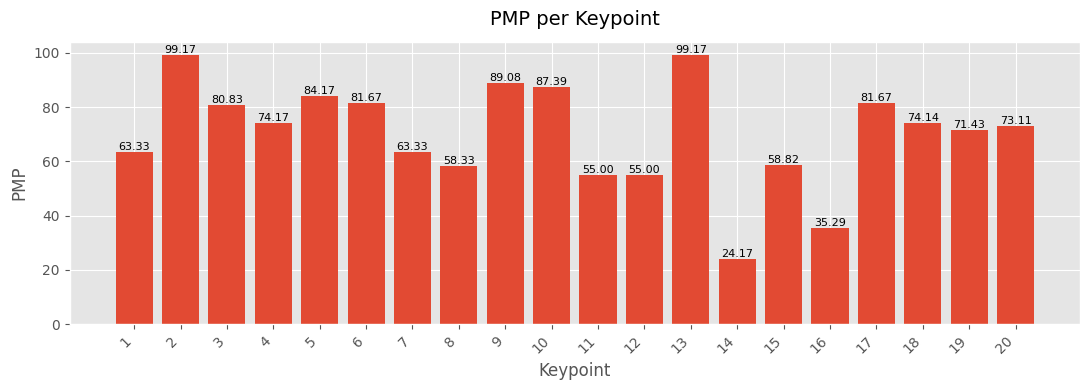

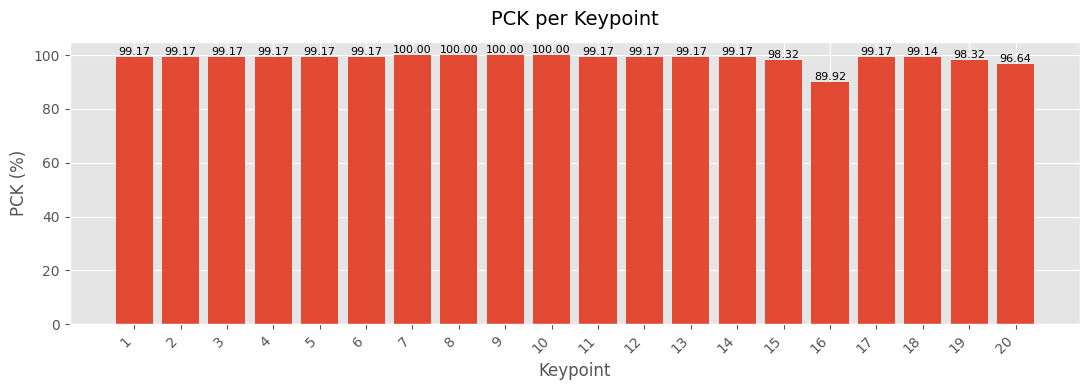

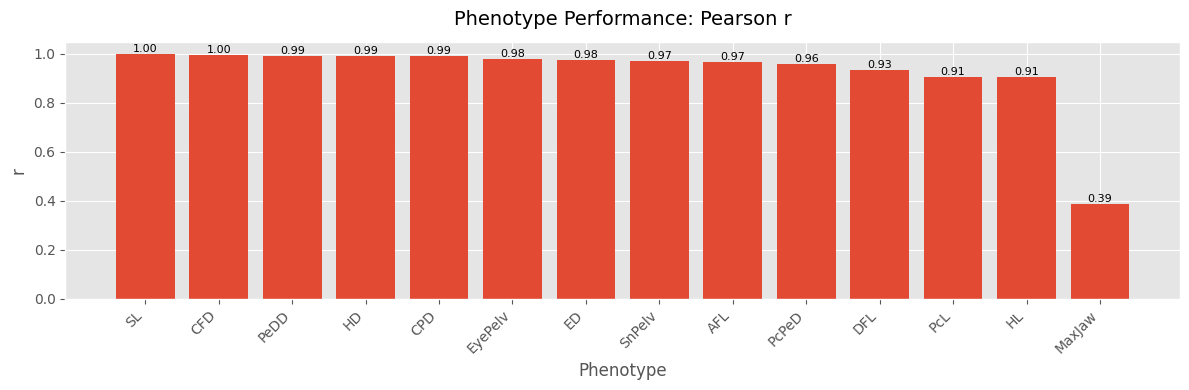

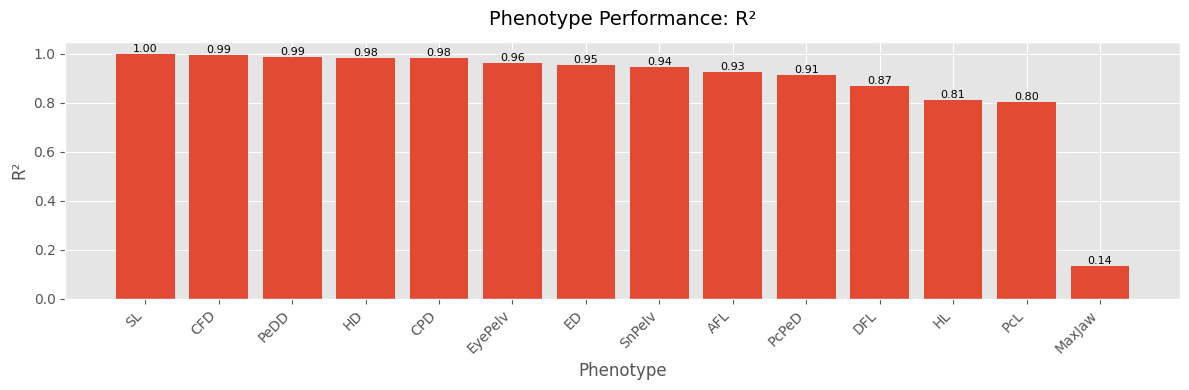

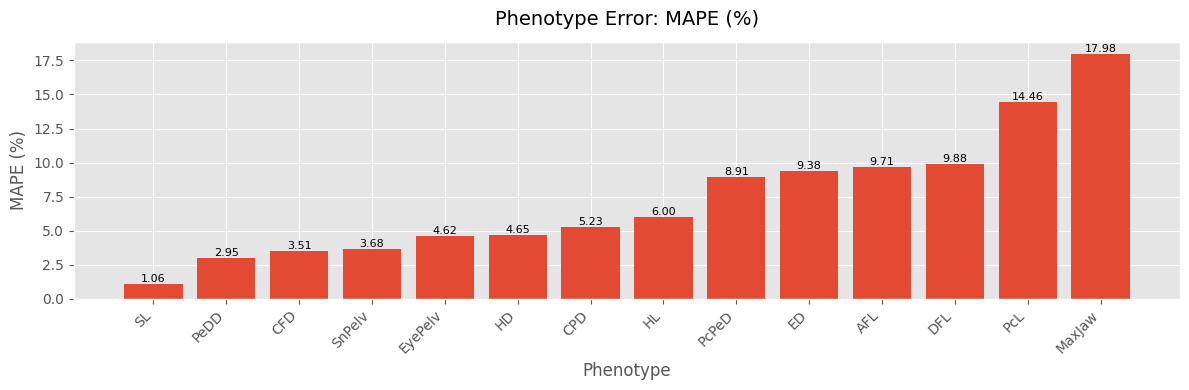

In [49]:
import os
import pandas as pd
import matplotlib.pyplot as plt

model = 'base_2nd-run'
fish_type = 'compressed'

# -------------------------------------------------------------------
# Optional: nice global style
# -------------------------------------------------------------------
plt.style.use("ggplot")  # subtle grid, softer colors
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

# -------------------------------------------------------------------
# Paths
# -------------------------------------------------------------------
base_dir = f"/data/Datasets/Fish/CavFish/results/{model}/{fish_type}"

pmp_path = os.path.join(base_dir, "pmp", "report.csv")
phenotype_stats_path = os.path.join(base_dir, "phenotypes", "phenotype_stats.csv")
pck_path = os.path.join(base_dir, "pck", "report.csv")

# -------------------------------------------------------------------
# Load data
# -------------------------------------------------------------------
pmp_df = pd.read_csv(pmp_path)
phen_df = pd.read_csv(phenotype_stats_path)
pck_df = pd.read_csv(pck_path)

print("Loaded:", pmp_df.shape, phen_df.shape, pck_df.shape)

# -------------------------------------------------------------------
# Helper plotting functions
# -------------------------------------------------------------------
def plot_metric_by_keypoint(df, key_col, metric_col, title=None, ylabel=None):
    plt.figure(figsize=(11, 4))
    
    # sort keypoints for consistent visual flow
    df_sorted = df.sort_values(key_col)

    bars = plt.bar(df_sorted[key_col].astype(str), df_sorted[metric_col])

    plt.xlabel("Keypoint")
    plt.ylabel(ylabel if ylabel else metric_col)
    plt.title(title, pad=12)

    plt.xticks(rotation=45, ha="right")

    # Add value labels on top of bars (optional but nice)
    for b in bars:
        y = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, y, f"{y:.2f}", 
                 ha="center", va="bottom", fontsize=8)

    plt.tight_layout()
    plt.show()


def plot_metric_by_phenotype(df, metric_col, title=None, ylabel=None, asc=False):
    plt.figure(figsize=(12, 4))

    df_sorted = df.sort_values(metric_col, ascending=asc)
    bars = plt.bar(df_sorted["phenotype"].astype(str), df_sorted[metric_col])

    plt.xlabel("Phenotype")
    plt.ylabel(ylabel if ylabel else metric_col)
    plt.title(title, pad=12)

    plt.xticks(rotation=45, ha="right")

    # Value labels
    for b in bars:
        y = b.get_height()
        plt.text(b.get_x() + b.get_width()/2, y, f"{y:.2f}",
                 ha="center", va="bottom", fontsize=8)

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------
# 1) PMP per keypoint
# -------------------------------------------------------------------
plot_metric_by_keypoint(
    pmp_df,
    key_col="keypoint_id",
    metric_col="pmp",
    title="PMP per Keypoint",
    ylabel="PMP"
)

# -------------------------------------------------------------------
# 2) PCK per keypoint
# -------------------------------------------------------------------
plot_metric_by_keypoint(
    pck_df,
    key_col="keypoint",
    metric_col="pck_pct",
    title="PCK per Keypoint",
    ylabel="PCK (%)"
)

# -------------------------------------------------------------------
# 3) Pearson r per phenotype
# -------------------------------------------------------------------
plot_metric_by_phenotype(
    phen_df,
    metric_col="pearson_r",
    title="Phenotype Performance: Pearson r",
    ylabel="r"
)

# -------------------------------------------------------------------
# 4) R² per phenotype
# -------------------------------------------------------------------
plot_metric_by_phenotype(
    phen_df,
    metric_col="r2",
    title="Phenotype Performance: R²",
    ylabel="R²"
)

# -------------------------------------------------------------------
# 5) MAPE per phenotype
# -------------------------------------------------------------------
plot_metric_by_phenotype(
    phen_df,
    metric_col="mape_pct",
    title="Phenotype Error: MAPE (%)",
    ylabel="MAPE (%)",
    asc=True
)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Optional: clean, publication-friendly style
# -------------------------------------------------------------------
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 10

# -------------------------------------------------------------------
# Helper: load data for multiple models
# -------------------------------------------------------------------
def load_results_for_models(models, fish_type,
                            root="/data/Datasets/Fish/CavFish/results"):
    """
    Returns:
        results[model] = {
            "pmp":  DataFrame,
            "pck":  DataFrame,
            "phen": DataFrame
        }
    """
    results = {}
    for model in models:
        base_dir = os.path.join(root, model, fish_type)
        pmp_path  = os.path.join(base_dir, "pmp", "report.csv")
        pck_path  = os.path.join(base_dir, "pck", "report.csv")
        phen_path = os.path.join(base_dir, "phenotypes", "phenotype_stats.csv")

        pmp_df  = pd.read_csv(pmp_path)
        pck_df  = pd.read_csv(pck_path)
        phen_df = pd.read_csv(phen_path)

        results[model] = {
            "pmp":  pmp_df,
            "pck":  pck_df,
            "phen": phen_df
        }

        print(f"Loaded {model}:",
              "pmp", pmp_df.shape,
              "pck", pck_df.shape,
              "phen", phen_df.shape)

    return results

# -------------------------------------------------------------------
# Helper: generic grouped bar plot, with locked model order
# -------------------------------------------------------------------
def grouped_bar_plot(df, group_col, metric_col, model_col="model",
                     title=None, ylabel=None, sort_by_mean=False,
                     rotate_xticks=True, model_order=None):
    """
    df columns: [group_col, metric_col, model_col]
    group_col:  keypoint_id / keypoint / phenotype
    metric_col: metric to plot (pmp, pck_pct, pearson_r, r2, mape_pct)

    model_order: list of model names specifying the order in which
                 bars/legend should appear. If None, order is taken
                 from df[model_col] as they appear (no sorting).
    """
    # Optionally sort groups by mean metric across models
    if sort_by_mean:
        order = (df.groupby(group_col)[metric_col]
                   .mean()
                   .sort_values())
        groups = order.index.to_list()
    else:
        groups = sorted(df[group_col].unique().tolist())

    # Lock model order if provided; otherwise use appearance order
    if model_order is not None:
        # keep only models that actually appear in df
        models = [m for m in model_order if m in df[model_col].unique()]
    else:
        models = list(df[model_col].drop_duplicates())

    n_groups = len(groups)
    n_models = len(models)

    x = np.arange(n_groups)
    width = 0.8 / n_models  # total bar group width ~0.8

    plt.figure(figsize=(max(10, n_groups * 0.4), 4))

    for i, model in enumerate(models):
        sub = (df[df[model_col] == model]
                 .set_index(group_col)
                 .reindex(groups))

        values = sub[metric_col].values
        # bar centers shifted left/right by i
        offsets = x + (i - (n_models - 1) / 2) * width

        plt.bar(offsets, values, width, label=model)

    plt.xlabel(group_col.capitalize())
    plt.ylabel(ylabel if ylabel else metric_col)
    plt.title(title if title else f"{metric_col} by {group_col} and model", pad=12)
    plt.xticks(
        x,
        [str(g) for g in groups],
        rotation=45 if rotate_xticks else 0,
        ha="right" if rotate_xticks else "center"
    )
    plt.legend(
        title="Model",
        loc="lower right",
        frameon=True,
        fontsize=8,
        title_fontsize=9,
    )
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------
# Helper: build long-format DataFrames for plotting
# -------------------------------------------------------------------
def build_keypoint_metric_df(results, df_key, key_col, metric_col):
    """
    df_key: "pmp" or "pck"
    key_col: "keypoint_id" or "keypoint"
    metric_col: metric column name (e.g. "pmp", "pck_pct")
    """
    rows = []
    for model, dfs in results.items():
        df = dfs[df_key]
        for _, r in df[[key_col, metric_col]].iterrows():
            rows.append({
                "model": model,
                key_col: r[key_col],
                metric_col: r[metric_col]
            })
    return pd.DataFrame(rows)


def build_phenotype_metric_df(results, metric_col):
    """
    metric_col: "pearson_r", "r2", "mape_pct"
    """
    rows = []
    for model, dfs in results.items():
        df = dfs["phen"]
        for _, r in df[["phenotype", metric_col]].iterrows():
            rows.append({
                "model": model,
                "phenotype": r["phenotype"],
                metric_col: r[metric_col]
            })
    return pd.DataFrame(rows)

# -------------------------------------------------------------------
# EXAMPLE USAGE
# -------------------------------------------------------------------

models = [
    "base_2nd-run",
    "base-log_2nd-run",
    "minpheno_2nd-run",
    "minphenoloss-log_2nd-run",
]  # replace with your model names

fish_type = "compressed"  # or whatever species label you use

results = load_results_for_models(models, fish_type)

# 1) PMP per keypoint (using keypoint_id from pmp/report.csv)
pmp_long = build_keypoint_metric_df(
    results,
    df_key="pmp",
    key_col="keypoint_id",
    metric_col="pmp"
)

grouped_bar_plot(
    pmp_long,
    group_col="keypoint_id",
    metric_col="pmp",
    title="PMP per Keypoint",
    ylabel="PMP",
    sort_by_mean=False,
    model_order=models,  # 🔒 lock model order
)

# 2) PCK per keypoint (using keypoint from pck/report.csv)
pck_long = build_keypoint_metric_df(
    results,
    df_key="pck",
    key_col="keypoint",
    metric_col="pck_pct"
)

grouped_bar_plot(
    pck_long,
    group_col="keypoint",
    metric_col="pck_pct",
    title="PCK per Keypoint",
    ylabel="PCK (%)",
    sort_by_mean=False,
    model_order=models,  # 🔒 lock model order
)

# 3) Pearson r per phenotype
r_long = build_phenotype_metric_df(results, metric_col="pearson_r")

grouped_bar_plot(
    r_long,
    group_col="phenotype",
    metric_col="pearson_r",
    title="Pearson r per Phenotype",
    ylabel="r",
    sort_by_mean=True,   # sorted by mean r across models (phenotypes)
    model_order=models,  # 🔒 lock model order
)

# 4) R² per phenotype
r2_long = build_phenotype_metric_df(results, metric_col="r2")

grouped_bar_plot(
    r2_long,
    group_col="phenotype",
    metric_col="r2",
    title="R² per Phenotype",
    ylabel="R²",
    sort_by_mean=True,
    model_order=models,  # 🔒 lock model order
)

# 5) MAPE per phenotype (lower is better)
mape_long = build_phenotype_metric_df(results, metric_col="mape_pct")

grouped_bar_plot(
    mape_long,
    group_col="phenotype",
    metric_col="mape_pct",
    title="MAPE per Phenotype",
    ylabel="MAPE (%)",
    sort_by_mean=True,
    model_order=models,  # 🔒 lock model order
)

### Generate Metrics

In [6]:
!mv /data/Datasets/Fish/CavFish/inference_20kpt_base-minphenoloss-log_2nd-run-pred/ /data/Datasets/Fish/CavFish/inference_20kpt_minphenoloss-log_2nd-run-pred

In [6]:
# MODEL = "minphenoloss-log_2nd-run"
# MODEL = "base-log_2nd-run"
# MODEL = "base_2nd-run"
# MODEL = "minpheno_2nd-run"
MODEL = "minphenoloss-log_2nd-run"


res = run_validation(filter_label="Depressed body", model=MODEL, alpha=0.05, r=0.10)
res
res = run_validation(filter_label="Compressed body", model=MODEL, alpha=0.05, r=0.10)
res
res = run_validation(filter_label="Compressed body_without caudal fin", model=MODEL, alpha=0.05, r=0.10)
res
res = run_validation(filter_label="Fusiform", model=MODEL, alpha=0.05, r=0.10)
res


✅ Saved rows:        /data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/depressed/rows.csv
✅ Saved metrics:     /data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/depressed/metrics.csv
🐟 PMP report:        /data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/depressed/pmp/report.csv
📊 PMP overall:       /data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/depressed/pmp/overall.txt
🔍 PMP debug sample:  /data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/depressed/pmp/debug_sample.csv
✅ PCK report:        /data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/depressed/pck/report.csv
✅ PCK overall:       /data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/depressed/pck/overall.txt  (overall=99.069 %)
📐 Phenotype lengths: /data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/depressed/phenotypes/phenotype_lengths.csv
🧪 Phenotype stats:   /data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/depressed/phenotypes/phe

{'rows_csv': '/data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/fusiform/rows.csv',
 'metrics_csv': '/data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/fusiform/metrics.csv',
 'pmp_report': '/data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/fusiform/pmp/report.csv',
 'pmp_overall': '/data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/fusiform/pmp/overall.txt',
 'pmp_debug': '/data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/fusiform/pmp/debug_sample.csv',
 'pck_report': '/data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/fusiform/pck/report.csv',
 'pck_overall': '/data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/fusiform/pck/overall.txt',
 'phenotype_lengths': '/data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/fusiform/phenotypes/phenotype_lengths.csv',
 'phenotype_stats': '/data/Datasets/Fish/CavFish/results/minphenoloss-log_2nd-run/fusiform/phenotypes/phenotype_stats.csv',
 'phenotype_overall': '/data

In [4]:
import os, json
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --------------------------- Phenotype map (1-based) -----------------------------
PHENOTYPE_PAIRS_1BASED = {
    "SL":  (1, 2),
    "PeDD": (4, 3),
    "HD":  (5, 6),
    "CPD": (7, 8),
    "CFD": (9, 10),
    "ED":  (11, 12),
    "EyePelv": (13, 4),
    "SnPelv": (1, 4),
    "MaxJaw": (1, 14),
    "PcL": (15, 16),
    "PcPeD": (15, 4),
    "HL":  (1, 17),
    "DFL": (3, 18),
    "AFL": (19, 20),
}

# --------------------------- Utils ---------------------------
def _canon(p: str) -> str:
    p = (p or "").strip().replace("\\", "/")
    return p[2:] if p.startswith("./") else p

# --------------------------- PCK helpers ---------------------------
def _ensure_pck_columns(df: pd.DataFrame,
                        image_base_path: str,
                        alpha: float = 0.05) -> pd.DataFrame:
    """
    Ensure df has width/height/diagonal/pck_threshold and correct_pck_0.05 (kept for back-compat).
    If any are missing, compute them.
    Expects columns: ['image','euclidean_error','keypoint','gt_x'] at minimum.
    """
    need_sizes = not {"width", "height"}.issubset(df.columns)
    need_diag  = "image_diagonal" not in df.columns
    need_thr   = "pck_threshold" not in df.columns
    need_flag_legacy  = "correct_pck_0.05" not in df.columns
    need_flag_std     = "correct_pck" not in df.columns  # standard name in your pipeline

    if need_sizes or need_diag:
        image_sizes = {}
        unique_imgs = df["image"].astype(str).unique().tolist()
        for img_path in unique_imgs:
            full_path = os.path.join(image_base_path, img_path)
            try:
                with Image.open(full_path) as img:
                    w, h = img.size
                image_sizes[img_path] = (w, h)
            except Exception as e:
                image_sizes[img_path] = (np.nan, np.nan)
                print(f"⚠️ Could not open {img_path}: {e}")

        if "width" not in df.columns:
            df["width"] = df["image"].map(lambda x: image_sizes.get(x, (np.nan, np.nan))[0])
        if "height" not in df.columns:
            df["height"] = df["image"].map(lambda x: image_sizes.get(x, (np.nan, np.nan))[1])

        df["image_diagonal"] = np.sqrt(df["width"]**2 + df["height"]**2)

    if need_thr:
        df["pck_threshold"] = float(alpha) * df["image_diagonal"]

    if need_flag_std:
        df["correct_pck"] = df["euclidean_error"] < df["pck_threshold"]

    if need_flag_legacy:
        # keep legacy column name for any downstream that expects it
        df["correct_pck_0.05"] = df["euclidean_error"] < df["pck_threshold"]

    return df


def _compute_pck_report(df: pd.DataFrame) -> tuple[pd.DataFrame, float]:
    """
    Compute PCK per keypoint and overall PCK (%) from a dataframe that
    already contains 'correct_pck_0.05' or 'correct_pck' and 'keypoint' columns.
    Returns (report_df, overall_pct).
    """
    flag_col = "correct_pck"
    if flag_col not in df.columns:
        flag_col = "correct_pck_0.05"

    kp = pd.to_numeric(df["keypoint"], errors="coerce")
    ok = df[flag_col].astype(bool)
    work = pd.DataFrame({"keypoint": kp, "ok": ok}).dropna(subset=["keypoint"])
    work["keypoint"] = work["keypoint"].astype(int)

    per_kp = (
        work.groupby("keypoint")["ok"]
            .mean()
            .reset_index(name="pck_frac")
            .sort_values("keypoint")
    )
    per_kp["pck_pct"] = (per_kp["pck_frac"] * 100.0).round(3)
    per_kp = per_kp.drop(columns=["pck_frac"])

    overall = float(work["ok"].mean() * 100.0) if len(work) else float("nan")
    return per_kp, overall

# --------------------------- PMP internals ---------------------------
def _label_suffix(label: str | None) -> str:
    """
    Map GT labels to folder-friendly scope names.
    """
    if not label:
        return "all"

    mapping = {
        "Compressed body": "compressed",
        "Depressed body": "depressed",
        "Compressed body_without caudal fin": "compressed_no-caudal-fin",
        "Fusiform": "fusiform",
    }

    # Fallback: simple normalization if label is not in mapping
    return mapping.get(label, label.lower().replace(" ", "_"))

def _metrics_from_rows(df: pd.DataFrame) -> dict:
    gt_flat   = df[["gt_x","gt_y"]].to_numpy().reshape(-1)
    pred_flat = df[["pred_x","pred_y"]].to_numpy().reshape(-1)
    return {
        "MAE": float(mean_absolute_error(gt_flat, pred_flat)) if len(df) else float("nan"),
        "RMSE": float(np.sqrt(mean_squared_error(gt_flat, pred_flat))) if len(df) else float("nan"),
        "R2": float(r2_score(gt_flat, pred_flat)) if len(df) else float("nan"),
    }

def _normalize_for_pmp(df: pd.DataFrame) -> pd.DataFrame:
    """Return ['image_id','keypoint_id','x_gt','y_gt','x_pred','y_pred'] (keypoint_id must be numeric)."""
    if "image" not in df.columns:
        raise ValueError("CSV must have column 'image' for PMP aggregation.")
    out = df.copy()
    out["image_id"] = pd.factorize(out["image"].astype(str).str.strip())[0]
    out["keypoint_id"] = pd.to_numeric(out["keypoint"], errors="raise")
    for c_from, c_to in [("gt_x","x_gt"),("gt_y","y_gt"),("pred_x","x_pred"),("pred_y","y_pred")]:
        out[c_to] = pd.to_numeric(out[c_from], errors="raise")
    return out[["image_id","keypoint_id","x_gt","y_gt","x_pred","y_pred"]]

def _compute_pheno_lengths_gt(gt_img_df: pd.DataFrame, ph_pairs: dict) -> dict:
    """gt_img_df: ['keypoint_id','x_gt','y_gt'] for one image_id; returns name->length."""
    idx = gt_img_df.set_index("keypoint_id")
    out = {}
    for name, (a,b) in ph_pairs.items():
        if a in idx.index and b in idx.index:
            pa = idx.loc[a, ["x_gt","y_gt"]].values.astype(float)
            pb = idx.loc[b, ["x_gt","y_gt"]].values.astype(float)
            out[name] = float(np.linalg.norm(pa - pb))
    return out

def _compute_pmp(df_pp: pd.DataFrame, ph_pairs: dict, r: float):
    M = _normalize_for_pmp(df_pp)
    dj_rows = []

    for img_id, Mi in M.groupby("image_id", sort=False):
        ph_len = _compute_pheno_lengths_gt(Mi[["keypoint_id","x_gt","y_gt"]], ph_pairs)
        pixel_err = np.sqrt(((Mi[["x_gt","y_gt"]].to_numpy(float) -
                              Mi[["x_pred","y_pred"]].to_numpy(float)) ** 2).sum(axis=1))

        norm_len_list, norm_phname_list = [], []
        for kp in Mi["keypoint_id"].astype(int).tolist():
            candidates = [
                (name, ph_len[name])
                for name, (a,b) in ph_pairs.items()
                if kp in (a,b) and name in ph_len and ph_len[name] > 0
            ]
            if candidates:
                phname, plen = min(candidates, key=lambda t: t[1])  # shortest available segment
                norm_len_list.append(plen)
                norm_phname_list.append(phname)
            else:
                norm_len_list.append(np.nan)
                norm_phname_list.append(None)

        tmp = Mi[["image_id","keypoint_id"]].copy()
        tmp["pixel_err"]  = pixel_err
        tmp["norm_len"]   = norm_len_list
        tmp["norm_pheno"] = norm_phname_list
        tmp = tmp.dropna(subset=["norm_len"]).copy()

        tmp["d_jn"]    = tmp["pixel_err"] / tmp["norm_len"]
        tmp["correct"] = (tmp["d_jn"] < r).astype(int)
        dj_rows.append(tmp)

    if not dj_rows:
        raise ValueError("No evaluable rows for PMP (check phenotype map).")

    D = pd.concat(dj_rows, ignore_index=True)

    pmp = D.groupby("keypoint_id")["correct"].mean().reset_index()
    pmp["pmp"] = pmp["correct"] * 100.0
    pmp = pmp.drop(columns=["correct"]).sort_values("keypoint_id").reset_index(drop=True)

    # Attach associated phenotype + average norm length + pixel threshold
    assoc_rows = []
    for kp, group in D.groupby("keypoint_id"):
        ph_list = group["norm_pheno"].dropna().tolist()
        if not ph_list:
            continue
        assoc_ph = pd.Series(ph_list).value_counts().index[0]
        mean_norm = float(group["norm_len"].mean())
        assoc_rows.append({
            "keypoint_id": int(kp),
            "assoc_phenotype": assoc_ph,
            "mean_norm_len_px": mean_norm,
            "threshold_pct_px": mean_norm * r
        })
    if assoc_rows:
        assoc_df = pd.DataFrame(assoc_rows)
        pmp = pmp.merge(assoc_df, on="keypoint_id", how="left")

    # Weighted overall (by available examples per keypoint)
    counts = D.groupby("keypoint_id").size().rename("n")
    pmp = pmp.merge(counts, on="keypoint_id", how="left")
    overall = float((pmp["pmp"] * pmp["n"]).sum() / pmp["n"].sum()) if pmp["n"].sum() > 0 else float("nan")
    return pmp, overall, D

# --------------------------- Phenotype lengths & correlations ---------------------------
def compute_phenotype_lengths(df: pd.DataFrame, ph_pairs: dict) -> pd.DataFrame:
    """
    Compute phenotype lengths (GT and Pred) for each image.
    Expects df['keypoint'] to be 1-based integers, and df has gt_x,gt_y,pred_x,pred_y.
    Returns: ['image','phenotype','gt_len','pred_len'] long-form.
    """
    results = []
    for img, g in df.groupby("image", sort=False):
        g = g.set_index("keypoint")
        available = set(g.index.tolist())
        for pheno, (a, b) in ph_pairs.items():
            if a in available and b in available:
                xa, ya = g.loc[a, ["gt_x","gt_y"]].astype(float)
                xb, yb = g.loc[b, ["gt_x","gt_y"]].astype(float)
                xp_a, yp_a = g.loc[a, ["pred_x","pred_y"]].astype(float)
                xp_b, yp_b = g.loc[b, ["pred_x","pred_y"]].astype(float)

                gt_len = float(np.hypot(xa - xb, ya - yb))
                pred_len = float(np.hypot(xp_a - xp_b, yp_a - yp_b))

                results.append({
                    "image": img,
                    "phenotype": pheno,
                    "gt_len": gt_len,
                    "pred_len": pred_len,
                })
    return pd.DataFrame(results)

def _pearson_r(x: np.ndarray, y: np.ndarray) -> float:
    # Safe Pearson via numpy (avoids scipy dependency)
    if x.size < 2:
        return np.nan
    cx = x - x.mean()
    cy = y - y.mean()
    denom = np.sqrt((cx**2).sum() * (cy**2).sum())
    if denom == 0:
        return np.nan
    return float((cx * cy).sum() / denom)

def compute_pheno_stats(df_ph: pd.DataFrame) -> pd.DataFrame:
    """
    Per-phenotype: Pearson r, R², MAPE (%).
    MAPE computed only on rows with gt_len > 0 (others skipped).
    """
    records = []
    for ph, g in df_ph.groupby("phenotype", sort=False):
        gt = g["gt_len"].to_numpy(float)
        pr = g["pred_len"].to_numpy(float)
        # Pearson
        r = _pearson_r(gt, pr)
        # R²
        r2 = r2_score(gt, pr) if gt.size >= 2 else np.nan
        # MAPE (skip zeros)
        mask = gt > 0
        mape = float(np.mean(np.abs((gt[mask] - pr[mask]) / gt[mask])) * 100.0) if mask.any() else np.nan
        records.append({
            "phenotype": ph,
            "pearson_r": r,
            "r2": r2,
            "mape_pct": mape,
            "n_pairs": int(len(g)),
            "n_pairs_mape": int(mask.sum()),
        })
    return pd.DataFrame(records).sort_values("phenotype").reset_index(drop=True)

def compute_overall(df_ph: pd.DataFrame) -> dict:
    """
    Overall across all phenotypes/images.
    """
    gt = df_ph["gt_len"].to_numpy(float)
    pr = df_ph["pred_len"].to_numpy(float)

    r = _pearson_r(gt, pr)
    r2 = r2_score(gt, pr) if gt.size >= 2 else np.nan

    mask = gt > 0
    mape = float(np.mean(np.abs((gt[mask] - pr[mask]) / gt[mask])) * 100.0) if mask.any() else np.nan

    return {
        "pearson_r": r,
        "r2": r2,
        "mape_pct": mape,
        "n_pairs": int(gt.size),
        "n_pairs_mape": int(mask.sum()),
    }

# --------------------------- Public entry -----------------------------
def run_validation(
    filter_label: str | None,
    model: str,
    pred_file: str | None = None,
    *,
    alpha: float = 0.05,   # for PCK
    r: float = 0.10,       # for PMP threshold
    base_dir: str = "/data/Datasets/Fish/CavFish",
    phenotype_pairs: dict = PHENOTYPE_PAIRS_1BASED,
):
    """
    End-to-end validation:
      - load GT + predictions (pred_file overrides default path layout)
      - build per-point rows (euclidean error)
      - if filter_label, keep only those images
      - post-process (drop missing GT, keypoint+1, width/height, diagonal, PCK@alpha)
      - save final rows.csv and metrics.csv under results/<model>/<scope>/
      - compute PMP (report.csv, overall.txt, debug_sample.csv)
      - compute phenotype lengths + stats (per phenotype + overall)
    Returns dict with all output paths.
    """
    BASE = Path(base_dir)
    IMAGES_BASE = BASE
    GT_FILE = BASE / "fish20kpt_all_val_2nd-run.json"

    # default pred file if not provided
    if pred_file is None:
        PRED_DIR = BASE / f"inference_20kpt_{model}"
        PRED_FILE = PRED_DIR / f"all_keypoints_predicted_{model}.json"
    else:
        PRED_FILE = Path(pred_file)

    # -------- load --------
    with GT_FILE.open("r") as f:
        gt = json.load(f)
    with PRED_FILE.open("r") as f:
        pred = json.load(f)

    image_id_to_name = {img["id"]: _canon(img["file_name"]) for img in gt.get("images", [])}
    label_by_name    = {_canon(img["file_name"]): img.get("label") for img in gt.get("images", [])}

    ann_by_name = {}
    for ann in gt.get("annotations", []):
        name = image_id_to_name.get(ann["image_id"])
        if not name:
            continue
        kp = np.array(ann["keypoints"], dtype=float).reshape(-1, 3)[:, :2]
        ann_by_name[name] = kp  # assumes one GT object per image

    # -------- compare (unfiltered) --------
    rows = []
    for item in pred:
        name = _canon(item.get("image"))
        if not name:
            continue
        gt_kp = ann_by_name.get(name)
        if gt_kp is None:
            continue
        pred_list = item.get("keypoints", [])
        if len(pred_list) != len(gt_kp):
            continue
        pred_kp = np.array([(kp["x"], kp["y"]) for kp in pred_list], dtype=float)

        gt_kp = gt_kp.astype("float64", copy=False)
        pred_kp = pred_kp.astype("float64", copy=False)

        dists = np.linalg.norm(pred_kp - gt_kp, axis=1)
        for i, kp in enumerate(pred_list):
            rows.append({
                "image": name,
                "keypoint": kp.get("name", f"kp_{i+1}"),
                "gt_x": float(gt_kp[i,0]), "gt_y": float(gt_kp[i,1]),
                "pred_x": float(pred_kp[i,0]), "pred_y": float(pred_kp[i,1]),
                "euclidean_error": float(dists[i]),
            })
    df = pd.DataFrame(rows)

    # -------- filter by label (if any) --------
    if filter_label:
        df["__label"] = df["image"].map(lambda p: label_by_name.get(_canon(p)))
        df = df[df["__label"] == filter_label].drop(columns="__label").copy()

    # -------- post-process (overwrite in-memory) --------
    # drop rows with GT missing (treat 0,0 as missing)
    df = df[~((df["gt_x"] == 0.0) & (df["gt_y"] == 0.0))].copy()

    # keypoint index to 1-based integers for phenotype map
    try:
        df["keypoint"] = pd.to_numeric(df["keypoint"], errors="raise") + 1
    except Exception:
        df["keypoint"] = df.groupby("image").cumcount() + 1

    # get image sizes once
    image_sizes = {}
    for img_path in df["image"].unique():
        full_path = IMAGES_BASE / img_path
        try:
            with Image.open(full_path) as img:
                image_sizes[img_path] = img.size  # (w, h)
        except Exception as e:
            image_sizes[img_path] = (np.nan, np.nan)
            print(f"⚠️ Could not open {full_path}: {e}")

    df["width"]  = df["image"].map(lambda x: image_sizes.get(x, (np.nan, np.nan))[0])
    df["height"] = df["image"].map(lambda x: image_sizes.get(x, (np.nan, np.nan))[1])
    df["image_diagonal"] = np.sqrt(df["width"]**2 + df["height"]**2)
    df["pck_threshold"] = alpha * df["image_diagonal"]
    df["correct_pck"] = df["euclidean_error"] < df["pck_threshold"]

    # -------- outputs (single final CSV + metrics + PMP) --------
    scope = _label_suffix(filter_label)
    OUT_DIR = BASE / "results" / model / scope
    (OUT_DIR / "pmp").mkdir(parents=True, exist_ok=True)

    rows_csv    = OUT_DIR / "rows.csv"
    metrics_csv = OUT_DIR / "metrics.csv"
    pmp_report  = OUT_DIR / "pmp" / "report.csv"
    pmp_overall = OUT_DIR / "pmp" / "overall.txt"
    pmp_debug   = OUT_DIR / "pmp" / "debug_sample.csv"

    # save final rows (post-processed)
    df.to_csv(rows_csv, index=False)

    # metrics on the final (possibly filtered) rows
    m = _metrics_from_rows(df)
    pd.DataFrame([m]).to_csv(metrics_csv, index=False)

    # PMP on the same final rows
    pmp_df, pmp_overall_pct, dj_table = _compute_pmp(df, phenotype_pairs, r=r)
    pmp_df.to_csv(pmp_report, index=False)
    dj_table.head(100).to_csv(pmp_debug, index=False)
    with open(pmp_overall, "w") as f:
        f.write(f"{pmp_overall_pct:.4f}\n")

    # PCK Calculation (on the same filtered df)
    df = _ensure_pck_columns(df, str(BASE), alpha=alpha)

    # ---- PCK per keypoint report (aligned with scope/OUT_DIR) ----
    pck_report_dir = OUT_DIR / "pck"
    pck_report_dir.mkdir(parents=True, exist_ok=True)

    pck_report   = pck_report_dir / "report.csv"
    pck_overall  = pck_report_dir / "overall.txt"

    pck_df, pck_overall_pct = _compute_pck_report(df)
    pck_df.to_csv(pck_report, index=False)
    with open(pck_overall, "w") as f:
        f.write(f"{pck_overall_pct:.4f}\n")

    # ---------------- Phenotype lengths + correlations ----------------
    ph_dir = OUT_DIR / "phenotypes"
    ph_dir.mkdir(parents=True, exist_ok=True)

    df_ph = compute_phenotype_lengths(df, phenotype_pairs)  # ['image','phenotype','gt_len','pred_len']
    pheno_stats = compute_pheno_stats(df_ph)                 # per phenotype
    overall_stats = compute_overall(df_ph)                   # overall

    out_ph_csv   = ph_dir / "phenotype_lengths.csv"
    out_ph_stats = ph_dir / "phenotype_stats.csv"
    out_overall  = ph_dir / "overall.json"

    df_ph.to_csv(out_ph_csv, index=False)
    pheno_stats.to_csv(out_ph_stats, index=False)
    with open(out_overall, "w") as f:
        json.dump(overall_stats, f, indent=2)

    # ---- Metadata for reproducibility ----
    meta = {
        "alpha": alpha, "r": r, "model": model,
        "filter_label": filter_label, "base_dir": str(base_dir),
        "phenotype_pairs": phenotype_pairs,
        "n_rows": int(len(df)),
        "pck_overall_pct": float(pck_overall_pct),
        "pmp_overall_pct": float(pmp_overall_pct),
        "phenotypes_overall": overall_stats,
    }
    with open(OUT_DIR / "metadata.json", "w") as f:
        json.dump(meta, f, indent=2)

    # ---- Make absolute for nice VS Code links ----
    rows_csv    = rows_csv.resolve()
    metrics_csv = metrics_csv.resolve()
    pmp_report  = pmp_report.resolve()
    pmp_overall = pmp_overall.resolve()
    pmp_debug   = pmp_debug.resolve()
    out_ph_csv  = out_ph_csv.resolve()
    out_ph_stats= out_ph_stats.resolve()
    out_overall = out_overall.resolve()
    pck_report  = pck_report.resolve()
    pck_overall = pck_overall.resolve()

    # ---- Print links ----
    print()
    print(f"✅ Saved rows:        {rows_csv}")
    print(f"✅ Saved metrics:     {metrics_csv}")
    print(f"🐟 PMP report:        {pmp_report}")
    print(f"📊 PMP overall:       {pmp_overall}")
    print(f"🔍 PMP debug sample:  {pmp_debug}")
    print(f"✅ PCK report:        {pck_report}")
    print(f"✅ PCK overall:       {pck_overall}  (overall={pck_overall_pct:.3f} %)")
    print(f"📐 Phenotype lengths: {out_ph_csv}")
    print(f"🧪 Phenotype stats:   {out_ph_stats}")
    print(f"🧾 Phenotype overall: {out_overall}")
    print()

    return {
        "rows_csv": str(rows_csv),
        "metrics_csv": str(metrics_csv),
        "pmp_report": str(pmp_report),
        "pmp_overall": str(pmp_overall),
        "pmp_debug": str(pmp_debug),
        "pck_report": str(pck_report),
        "pck_overall": str(pck_overall),
        "phenotype_lengths": str(out_ph_csv),
        "phenotype_stats": str(out_ph_stats),
        "phenotype_overall": str(out_overall),
        "metadata": str((OUT_DIR / "metadata.json").resolve()),
    }


# Subset count per fish kind

In [3]:
import json
from collections import Counter

# Load your COCO JSON
with open("/data/Datasets/Fish/CavFish/fish20kpt_all_train.json", "r") as f:
    data = json.load(f)

# Extract labels from the images array
labels = [img.get("label") for img in data["images"] if "label" in img]

# Count occurrences of each label
label_counts = Counter(labels)

# Print results
print("Unique labels:", list(label_counts.keys()))
print("Counts per label:")
for label, count in label_counts.items():
    print(f"  {label}: {count}")

import json
from collections import Counter

# Load your COCO JSON
with open("/data/Datasets/Fish/CavFish/fish20kpt_all_val.json", "r") as f:
    data = json.load(f)

# Extract labels from the images array
labels = [img.get("label") for img in data["images"] if "label" in img]

# Count occurrences of each label
label_counts = Counter(labels)

# Print results
print("Unique labels:", list(label_counts.keys()))
print("Counts per label:")
for label, count in label_counts.items():
    print(f"  {label}: {count}")



Unique labels: ['Compressed body', 'Depressed body', 'Compressed body_without caudal fin', 'Rounded body', 'Fusiform', 'unknown']
Counts per label:
  Compressed body: 1005
  Depressed body: 518
  Compressed body_without caudal fin: 46
  Rounded body: 4
  Fusiform: 6
  unknown: 3
Unique labels: ['Compressed body', 'Depressed body', 'Compressed body_without caudal fin', 'Fusiform']
Counts per label:
  Compressed body: 121
  Depressed body: 47
  Compressed body_without caudal fin: 7
  Fusiform: 1


In [7]:
import json
from collections import defaultdict, Counter
import statistics




# Load the COCO-style JSON
with open("/data/Datasets/Fish/CavFish/fish20kpt_all_train.json", "r") as f:
    data = json.load(f)

# Mapear ID de imagen → clase
image_id_to_label = {img['id']: img['label'] for img in data['images']}

# Guardar los keypoints visibles por imagen en cada clase
class_to_kps = defaultdict(list)

# Recorrer anotaciones
for ann in data['annotations']:
    image_id = ann['image_id']
    label = image_id_to_label.get(image_id, 'unknown')
    
    kps = ann.get('keypoints', [])
    visible_kps = sum(1 for i in range(2, len(kps), 3) if kps[i] > 0)
    
    class_to_kps[label].append((image_id, visible_kps))

# Calcular estadísticas
print(f"{'Clase':35s} {'Imágenes':>9s} {'Mín':>5s} {'Máx':>5s} {'Moda':>6s} {'Media':>7s}")
print("-" * 80)

for label, entries in sorted(class_to_kps.items()):
    # Obtener solo los valores por imagen
    image_kps = defaultdict(int)
    for img_id, kps in entries:
        image_kps[img_id] += kps  # puede haber múltiples anotaciones por imagen

    values = list(image_kps.values())
    
    if not values:
        continue
    
    min_kps = min(values)
    max_kps = max(values)
    mean_kps = round(statistics.mean(values), 2)
    
    try:
        mode_kps = statistics.mode(values)
    except statistics.StatisticsError:
        mode_kps = '–'

    print(f"{label:35s} {len(values):9d} {min_kps:5d} {max_kps:5d} {str(mode_kps):>6s} {mean_kps:7.2f}")


Clase                                Imágenes   Mín   Máx   Moda   Media
--------------------------------------------------------------------------------
Compressed body                          1005    17    20     20   19.96
Compressed body_without caudal fin         46    17    17     17   17.00
Depressed body                            518    15    19     19   18.36
Fusiform                                    6    13    13     13   13.00
Rounded body                                4     8    11     11    9.50
unknown                                     3    20    20     20   20.00


In [8]:
import json

# Cargar archivo original
with open("/data/Datasets/Fish/CavFish/fish20kpt_all_train.json", "r") as f:
    coco = json.load(f)

# Función para filtrar por una sola clase y guardar
def filtrar_y_guardar(clase_objetivo, nombre_archivo):
    # Filtrar imágenes con esa clase
    imagenes = [img for img in coco["images"] if img.get("label") == clase_objetivo]
    ids = {img["id"] for img in imagenes}
    
    # Filtrar anotaciones que correspondan a esas imágenes
    anotaciones = [ann for ann in coco["annotations"] if ann["image_id"] in ids]
    
    # Construir nuevo JSON
    nuevo_coco = {
        "info": coco.get("info", {}),
        "licenses": coco.get("licenses", []),
        "images": imagenes,
        "annotations": anotaciones,
        "categories": coco.get("categories", [])
    }

    # Guardar a archivo
    with open(nombre_archivo, "w") as f:
        json.dump(nuevo_coco, f, indent=2)

# Guardar ambos archivos
filtrar_y_guardar("Depressed body", "/data/Datasets/Fish/CavFish/depressed_body_20kpt_train.json")
filtrar_y_guardar("Compressed body_without caudal fin", "/data/Datasets/Fish/CavFish/compressed_body_no_caudal_20kpt_train.json")

# end

## Inference over weights

In [ ]:
# 1. La imagen a inferir (Ruta)
# 2. Configuración usada para entrenar (Ruta)
# 3. Ruta de los pesos

!python demo/image_demo.py \
    "/data/Datasets/Fish/2022/images/val_fish/DSC03012_10032023194229.jpg" \
    "configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_ViTPose-fish9_8xb32-100etrain.py" \
    "/data/Josue/weights/Fish/epoch_final_vit.pth" \
    --out-file "work_dirs/images/test_file.png" \
    --draw-heatmap \
    --show-kpt-idx

: 

Inference over a set of image definied over the input_folder path

In [ ]:
import os
import glob

# Define paths
input_folder = '/data/Datasets/Fish/2022/images/val_fish/'
output_folder = '/data/Datasets/Fish/2022/output/'
config_path = 'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_ViTPose-fish9_8xb32-100etrain.py'
checkpoint_path = '/data/Josue/weights/Fish/epoch_final_vit.pth'

# Create output directory if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Get all image files (jpg/png/jpeg)
image_files = sorted(glob.glob(os.path.join(input_folder, '*.[jp][pn]g')))

# Loop through and run demo script
for img_path in image_files:
    img_name = os.path.basename(img_path)
    out_file = os.path.join(output_folder, img_name)

    !python demo/image_demo.py \
        "{img_path}" \
        "{config_path}" \
        "{checkpoint_path}" \
        --out-file "{out_file}" \
        --draw-heatmap \
        --show-kpt-idx

In [ ]:
# Generate Predictions
!python tools/test.py \
    configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_ViTPose-fish9_8xb32-100etrain.py \
    /data/Josue/weights/Fish/epoch_600.pth \
    --dump /data/Josue/weights/Fish/predictions.pkl

In [ ]:
from mmpose.apis import inference_topdown, init_model
from mmengine.dataset import Compose
from mmcv import imread
import os
import glob
import json

# --- CONFIGURACIONES ---
config_path = 'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_ViTPose-fish9_8xb32-100etrain.py'
checkpoint_path = '/data/Josue/weights/Fish/epoch_final_vit.pth'
input_folder = '/data/Datasets/Fish/2022/images/val_fish/'
output_json = '/data/Datasets/Fish/2022/predicted_keypoints.json'

# --- INICIALIZAR MODELO ---
model = init_model(config_path, checkpoint_path, device='cuda:0')

# --- PROCESAR TODAS LAS IMÁGENES ---
image_files = sorted(glob.glob(os.path.join(input_folder, '*.[jp][pn]g')))
results = {}

for img_path in image_files:
    img = imread(img_path)
    h, w, _ = img.shape
    detection_result = [{'bbox': [0, 0, w, h]}]  # Asume una caja por imagen

    pose_results = inference_topdown(model, img, detection_result)

    if pose_results:
        keypoints = pose_results[0]['keypoints']  # (num_kpts, 3)
        results[os.path.basename(img_path)] = keypoints.tolist()

# --- GUARDAR ---
with open(output_json, 'w') as f:
    json.dump(results, f, indent=4)

print(f"Keypoints guardados en: {output_json}")


In [ ]:
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from mmengine import load
from PIL import Image
from pathlib import Path

# Rutas a archivos
val_json_path = Path("/data/Datasets/Fish/2022/fish8kpt_val.json")
results_path = Path("/data/Josue/weights/Fish/predictions.pkl")

# Cargar anotaciones COCO y resultados
with open(val_json_path, "r") as f:
    val_data = json.load(f)
results = load(results_path)

# Mapeo de image_id a nombre de archivo
id_to_filename = {img["id"]: img["file_name"] for img in val_data["images"]}
image_dir = val_json_path.parent / "images"

# Escoger una muestra aleatoria
sample = random.choice(results)
img_id = sample.metainfo['img_id']  # ✅ acceder al atributo correctamente
img_name = id_to_filename[img_id]
img_path = image_dir / img_name
img = Image.open(img_path)

# Obtener keypoints de la primera instancia
kpts = sample.pred_instances.keypoints

# Visualizar
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis("off")

for x, y in kpts[0]:
    if 0 <= x <= img.width and 0 <= y <= img.height:
        plt.scatter(x, y, c='red', s=40)
        plt.text(x + 2, y + 2, f"{int(x)},{int(y)}", fontsize=8, color='yellow')

plt.title(f"Predicted Keypoints – {img_name}")
plt.show()


In [ ]:
import json
import numpy as np
from lxml import etree
from pathlib import Path
from tqdm import tqdm

# === CONFIGURA TUS RUTAS AQUÍ ===
xml_input_path = Path("/data/Datasets/Fish/2022/2022_2023_General.xml")
output_path = Path("/data/Datasets/Fish/2022/fisk_8kpts.json")
padding = 10  # píxeles extra para las bboxes

# === PARSEAR XML ===
with open(xml_input_path, "rb") as f:
    tree = etree.parse(f)

images = tree.xpath("//image")

# === INICIALIZAR ESTRUCTURA COCO ===
coco_output = {
    "images": [],
    "annotations": [],
    "categories": [{
        "id": 1,
        "name": "fish",
        "keypoints": [str(i) for i in range(1, 9)],
        "skeleton": []
    }]
}

annotation_id = 1

def compute_bbox_from_keypoints(kpts, image_width, image_height, pad=10):
    points = np.array(kpts).reshape(-1, 3)
    visible = points[:, 2] > 0
    if not np.any(visible):
        return [0, 0, image_width, image_height]
    x_coords = points[visible, 0]
    y_coords = points[visible, 1]
    x_min = max(0, x_coords.min() - pad)
    y_min = max(0, y_coords.min() - pad)
    x_max = min(image_width, x_coords.max() + pad)
    y_max = min(image_height, y_coords.max() + pad)
    return [float(x_min), float(y_min), float(x_max - x_min), float(y_max - y_min)]

# === PROCESAR IMÁGENES Y ANOTACIONES ===
for img_elem in tqdm(images):
    img_id = int(img_elem.attrib["id"])
    img_name = img_elem.attrib["name"]
    width = int(img_elem.attrib["width"])
    height = int(img_elem.attrib["height"])

    coco_output["images"].append({
        "id": img_id,
        "file_name": img_name,
        "width": width,
        "height": height
    })

    kpts = [0] * 8 * 3
    num_keypoints = 0

    for point in img_elem.xpath("points"):
        label = point.attrib["label"]
        if label.isdigit() and 1 <= int(label) <= 8:
            idx = int(label) - 1
            x, y = map(float, point.attrib["points"].split(","))
            kpts[idx * 3: idx * 3 + 3] = [x, y, 2]
            num_keypoints += 1

    if num_keypoints > 0:
        bbox = compute_bbox_from_keypoints(kpts, width, height, padding)
        coco_output["annotations"].append({
            "id": annotation_id,
            "image_id": img_id,
            "category_id": 1,
            "keypoints": kpts,
            "num_keypoints": num_keypoints,
            "bbox": bbox,
            "area": bbox[2] * bbox[3],
            "iscrowd": 0
        })
        annotation_id += 1

# === GUARDAR JSON ===
with open(output_path, "w") as f:
    json.dump(coco_output, f, indent=2)

print(f"Listo: {output_path}")


In [ ]:
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from mmengine import load
from PIL import Image
from pathlib import Path

# Cargar el archivo val.json
val_json_path = Path("/data/Datasets/Fish/2022/fish8kpt_val.json")
with open(val_json_path, "r") as f:
    val_data = json.load(f)

# Cargar las predicciones
results = load("/data/Josue/weights/Fish/epoch_600.pth")  # Asegúrate que este path es correcto o reemplázalo

# Mapear image_id a file_path
id_to_filename = {img["id"]: img["file_name"] for img in val_data["images"]}
image_dir = Path(val_json_path).parent  # /data/Datasets/Fish/2022

# Seleccionar una predicción aleatoria que esté en el val set
val_ids = set(id_to_filename.keys())
sample = next(r for r in results if r.img_id in val_ids)

# Obtener keypoints predichos
kpts = sample.pred_instances.keypoints  # (K, 3)
img_path = image_dir / id_to_filename[sample.img_id]
img = Image.open(img_path)

# Mostrar imagen con keypoints
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis("off")

for x, y, v in kpts:
    if v > 0:
        plt.scatter(x, y, c='red', s=40)
        plt.text(x + 2, y + 2, f"{int(x)},{int(y)}", fontsize=8, color='yellow')

plt.title(f"Predicted Keypoints for Image ID: {sample.img_id}")
plt.show()


In [ ]:
!python demo/image_demo.py \
  /data/Datasets/Fish/FIB/FIB/inference/IMG_0181-Editar.jpg \
  configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_ViTPose-fish9_8xb32-100etest.py \
  work_dirs/td-hm_ViTPose-fish9_8xb32-100etrain/epoch_600.pth \
  --out-file vis_results/vitpose_600epoch/fish_infer_0181.jpg \
  --draw-heatmap \
  --show-kpt-idx

# Fine Tuning Inference

## No caudal fin Body

### Exctract from all samples

In [8]:
import os
import json
import pandas as pd

# ---- paths you set ----
json_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
csv_path  = '/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_ViTPose_ViTPose_PhenoLossNoResAug.csv'     # <-- your CSV (with a column named 'image')
out_csv   = '/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_nocaudal_PhenoLossNoResAug.csv'
target_labels = {'Compressed body_without caudal fin'}

# ---- helpers ----
def canonize_path(p: str) -> str:
    # normalize case & slashes; strip whitespace
    p = (p or "").strip().replace("\\", "/")
    # remove leading "./"
    if p.startswith("./"):
        p = p[2:]
    return p

# ---- 1) gather names from JSON for target classes ----
with open(json_path, "r") as f:
    val = json.load(f)

json_relpaths = {
    canonize_path(img["file_name"])
    for img in val.get("images", [])
    if img.get("label") in target_labels
}

# also keep a basename set in case your CSV stores only filenames
json_basenames = {os.path.basename(p) for p in json_relpaths}

print(f"Found {len(json_relpaths)} images labeled {target_labels} in JSON.")

# ---- 2) load CSV and filter by name match ----
df = pd.read_csv(csv_path)

if "image" not in df.columns:
    raise ValueError("CSV must have a column named 'image'.")

# Build two keys to be flexible: relative-path key and basename key
csv_rel = df["image"].astype(str).map(canonize_path)
csv_base = csv_rel.map(os.path.basename)

mask = csv_rel.isin(json_relpaths) | csv_base.isin(json_basenames)
df_filtered = df[mask].copy()

print(f"Rows before: {len(df)} | after filter: {len(df_filtered)}")

# ---- 3) save ----
df_filtered.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")


Found 7 images labeled {'Compressed body_without caudal fin'} in JSON.
Rows before: 3520 | after filter: 140
Saved: /data/Datasets/Fish/CavFish/Predictions/augmented/predictions_nocaudal_PhenoLossNoResAug.csv


### Keypoints usados

In [ ]:
import json
from collections import Counter

json_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
target_class = 'Compressed body_without caudal fin'

with open(json_path, 'r') as f:
    data = json.load(f)

# Mapea ID de imagen a label
image_id_to_label = {img['id']: img['label'] for img in data['images']}

# Contador de keypoints visibles por índice
kp_presence = Counter()

for ann in data['annotations']:
    image_id = ann['image_id']
    label = image_id_to_label.get(image_id, 'unknown')
    
    if label != target_class:
        continue

    kps = ann.get('keypoints', [])
    for i in range(0, len(kps), 3):
        v = kps[i + 2]
        if v > 0:
            kp_index = i // 3
            kp_presence[kp_index] += 1

print(f"\n🧭 Keypoint counts for class: {target_class}")
for kp_id in range(19):
    print(f"kp{kp_id+1:<2d} → {kp_presence.get(kp_id, 0)} / {len(data['annotations'])} visibles")


🧭 Keypoint counts for class: Compressed body_without caudal fin
kp1  → 46 / 1582 visibles
kp2  → 46 / 1582 visibles
kp3  → 46 / 1582 visibles
kp4  → 46 / 1582 visibles
kp5  → 46 / 1582 visibles
kp6  → 46 / 1582 visibles
kp7  → 46 / 1582 visibles
kp8  → 46 / 1582 visibles
kp9  → 0 / 1582 visibles
kp10 → 0 / 1582 visibles
kp11 → 46 / 1582 visibles
kp12 → 46 / 1582 visibles
kp13 → 46 / 1582 visibles
kp14 → 46 / 1582 visibles
kp15 → 46 / 1582 visibles
kp16 → 46 / 1582 visibles
kp17 → 46 / 1582 visibles
kp18 → 0 / 1582 visibles
kp19 → 46 / 1582 visibles


### Filtrado de dataset

In [3]:
import json

# Paths
input_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
output_path = '/data/Datasets/Fish/CavFish/no_caudal_fin_17kpt_val.json'

target_class = 'Compressed body_without caudal fin'
expected_kpts = 17
keypoints_to_remove = [8, 9, 17]  # IDs base-0 de kp9, kp10, kp18

# Cargar JSON
with open(input_path, 'r') as f:
    coco = json.load(f)

# Map image ID to label
image_id_to_label = {img['id']: img.get('label', 'unknown') for img in coco['images']}

fixed_annotations = []

for ann in coco['annotations']:
    image_id = ann['image_id']
    label = image_id_to_label.get(image_id, 'unknown')

    if label != target_class:
        continue

    kps = ann['keypoints']
    kp_list = [kps[i:i+3] for i in range(0, len(kps), 3)]

    # Eliminar keypoints específicos (por índice)
    for idx in sorted(keypoints_to_remove, reverse=True):
        if idx < len(kp_list):
            del kp_list[idx]

    # Rellenar si faltan
    while len(kp_list) < expected_kpts:
        kp_list.append([0.0, 0.0, 0])

    # Cortar si sobran
    if len(kp_list) > expected_kpts:
        kp_list = kp_list[:expected_kpts]

    # Guardar anotación corregida
    ann_copy = ann.copy()
    ann_copy['keypoints'] = [coord for kp in kp_list for coord in kp]
    fixed_annotations.append(ann_copy)

# Filtrar imágenes asociadas
used_ids = {ann['image_id'] for ann in fixed_annotations}
filtered_images = [
    img for img in coco['images']
    if img['id'] in used_ids and img.get('label') == target_class
]

# Construir nuevo JSON
filtered_coco = {
    'info': coco.get('info', {}),
    'licenses': coco.get('licenses', []),
    'images': filtered_images,
    'annotations': fixed_annotations,
    'categories': coco.get('categories', [])  # puedes filtrar si lo deseas
}

# Guardar
with open(output_path, 'w') as f:
    json.dump(filtered_coco, f, indent=2)

print(f"✅ Guardado: {output_path}")
print(f"📊 Anotaciones: {len(fixed_annotations)}")
print(f"🖼️  Imágenes: {len(filtered_images)}")


✅ Guardado: /data/Datasets/Fish/CavFish/no_caudal_fin_17kpt_val.json
📊 Anotaciones: 7
🖼️  Imágenes: 7


### Comando para correr

In [ ]:
!python tools/train.py \
    /home/arumota_pupils/Josue/1PECES/MMPose/mmpose/configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_ViTPose-fish9_8xb32-100etrain_no_caudal.py

^C


### Inferencia sumando 1

In [13]:
csv_path = "/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_depressed_minphenoloss.csv"  # replace with the root folder containing the images
df = pd.read_csv(csv_path)

# Remove rows where gt_x == 0
df = df[df["gt_x"] != 0.0]
df["keypoint"] = df["keypoint"] + 1
df.to_csv(csv_path, index=False)
print(f"✅ Guardado: {csv_path}")

import pandas as pd
from PIL import Image
import os
import numpy as np

# Path to your CSV file
image_base_path = "/data/Datasets/Fish/CavFish/"  # replace with your real filename

# Load the CSV
df = pd.read_csv(csv_path)

# Initialize new columns
df["width"] = 0
df["height"] = 0

# Cache image sizes
image_sizes = {}

for img_path in df["image"].unique():
    full_path = os.path.join(image_base_path, img_path)
    try:
        with Image.open(full_path) as img:
            width, height = img.size
            image_sizes[img_path] = (width, height)
    except Exception as e:
        print(f"⚠️ Could not open {img_path}: {e}")

# Map sizes
df["width"] = df["image"].map(lambda x: image_sizes[x][0])
df["height"] = df["image"].map(lambda x: image_sizes[x][1])

# Compute image diagonal per row
df["image_diagonal"] = np.sqrt(df["width"]**2 + df["height"]**2)

# Compute PCK@0.05 threshold
alpha = 0.05
df["pck_threshold"] = alpha * df["image_diagonal"]

# Compute PCK@0.05 (1 if euclidean error < threshold)
df["correct_pck_0.05"] = df["euclidean_error"] < df["pck_threshold"]

# Save CSV
df.to_csv(csv_path, index=False)
print(f"✅ Saved: {csv_path}")

✅ Guardado: /data/Datasets/Fish/CavFish/Predictions/augmented/predictions_depressed_minphenoloss.csv
✅ Saved: /data/Datasets/Fish/CavFish/Predictions/augmented/predictions_depressed_minphenoloss.csv


In [18]:
import pandas as pd

# Load your CSV
df = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_depressed_PhenoLoss1e2alpha.csv")

# Ensure the column is boolean (in case it's string "True"/"False")
df["correct_pck_0.05"] = df["correct_pck_0.05"].astype(bool)

# Calculate PCK per keypoint
pck_per_kp = df.groupby("keypoint")["correct_pck_0.05"].mean() * 100

# Save or print
print(pck_per_kp)

# If you want a nice DataFrame
pck_df = pck_per_kp.reset_index().rename(columns={"correct_pck_0.05": "PCK@0.05 (%)"})
print(pck_df)


keypoint
1      95.744681
2      95.744681
3      95.744681
4      93.617021
5      93.617021
6      95.744681
7      95.744681
8      95.744681
9      97.872340
10    100.000000
11     95.744681
12     95.744681
13     95.744681
15     97.872340
16     89.361702
17     97.872340
18     95.744681
19     93.333333
20     90.000000
Name: correct_pck_0.05, dtype: float64
    keypoint  PCK@0.05 (%)
0          1     95.744681
1          2     95.744681
2          3     95.744681
3          4     93.617021
4          5     93.617021
5          6     95.744681
6          7     95.744681
7          8     95.744681
8          9     97.872340
9         10    100.000000
10        11     95.744681
11        12     95.744681
12        13     95.744681
13        15     97.872340
14        16     89.361702
15        17     97.872340
16        18     95.744681
17        19     93.333333
18        20     90.000000


In [1]:
# Se extrae la ruta de la imagen. Final
import os
import json
import subprocess

# Configuración de rutas
json_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
dataset_root = '/data/Datasets/Fish/CavFish'
output_folder = '/data/Datasets/Fish/CavFish/inference_no_caudalfin_ViTPose_untuned/'
config_path = 'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_ViTPose-fish9_8xb32-100etrain.py'
checkpoint_path = '/data/Pupils/Josue/weights/Fish/ViTPose_20kpt/epoch_300.pth'
merged_json_path = os.path.join(output_folder, 'all_keypoints_predicted_no_caudalfin_ViTPose_untuned.json')

# Clase(s) objetivo a filtrar
target_labels = ['Compressed body_without caudal fin']

# Crear carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Leer el archivo JSON de validación
with open(json_path, 'r') as f:
    val_data = json.load(f)

# Almacenar todas las predicciones
all_predictions = []

# Recorrer cada imagen del archivo de validación
for image_info in val_data['images']:
    # Filtrar por clase (label)
    if image_info.get('label') not in target_labels:
        continue

    relative_path = image_info['file_name']  # ej: "2018 Guayavero Duda/IMG_0084-Edit.jpg"
    full_path = os.path.join(dataset_root, relative_path)

    # Nombre de imagen para guardar outputs
    img_name = os.path.basename(relative_path)
    out_base = os.path.join(output_folder, img_name)
    out_json = out_base.replace('.jpg', '_keypoints.json').replace('.png', '_keypoints.json')

    # Verificación de existencia de imagen
    if not os.path.exists(full_path):
        print(f"⚠️ Imagen no encontrada: {full_path}")
        continue

    # Ejecutar la inferencia
    cmd = [
        "python", "demo/image_demo.py",
        full_path,
        config_path,
        checkpoint_path,
        "--out-file", out_base,
        "--draw-heatmap",
        "--show-kpt-idx"
    ]

    print(f"🔁 Procesando {relative_path}...")
    subprocess.run(cmd)

    # Leer predicción y asociarla a la ruta relativa original (no solo nombre)
    if os.path.exists(out_json):
        with open(out_json, 'r') as f:
            pred = json.load(f)

        # Normalizar output para que coincida con GT
        pred["image"] = relative_path  # Sobrescribe con la ruta relativa del GT
        all_predictions.append(pred)
    else:
        print(f"⚠️ No se encontró JSON de salida para {img_name}")

# Guardar todas las predicciones en un solo archivo
with open(merged_json_path, 'w') as f:
    json.dump(all_predictions, f, indent=4)

print(f"\n✅ JSON consolidado guardado en: {merged_json_path}")


🔁 Procesando 2018 Guayavero Duda/IMG_1684-Edit.jpg...


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=137.6, y=1991.5, score=0.969

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_no_caudalfin_ViTPose_untuned/IMG_1684-Edit_keypoints.json
 - 1: x=5797.5, y=2026.9, score=1.076

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_no_caudalfin_ViTPose_untuned/IMG_1684-Edit_keypoints.json
 - 2: x=1334.4, y=1878.0, score=1.023

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_no_caudalfin_ViTPose_untuned/IMG_1684-Edit_keypoints.json
 - 3: x=1368.2, y=2276.2, score=0.827

📝 Coord

In [2]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Rutas
pred_file = Path("/data/Datasets/Fish/CavFish/inference_no_caudalfin_ViTPose_untuned/all_keypoints_predicted_no_caudalfin_ViTPose_untuned.json")
gt_file = Path("/data/Datasets/Fish/CavFish/fish20kpt_all_val.json")

# Cargar archivos
with pred_file.open("r") as f:
    pred_data = json.load(f)

with gt_file.open("r") as f:
    gt_data = json.load(f)

# Crear índice de anotaciones por imagen
image_id_to_name = {img['id']: img['file_name'] for img in gt_data['images']}
annotations_by_name = {
    image_id_to_name[ann['image_id']]: np.array(ann['keypoints']).reshape(-1, 3)[:, :2]
    for ann in gt_data['annotations']
}

# Comparación punto a punto
rows = []
gt_all = []
pred_all = []

for item in pred_data:
    name = item["image"]
    pred_kpts = {kp["name"]: (kp["x"], kp["y"]) for kp in item["keypoints"]}
    gt_kpts = annotations_by_name.get(name)

    if gt_kpts is None:
        print(f"⚠️ Imagen {name} no encontrada en GT.")
        continue

    for idx, (gt_xy, (kpt_name, pred_xy)) in enumerate(zip(gt_kpts, pred_kpts.items())):
        error = np.linalg.norm(np.array(pred_xy) - np.array(gt_xy))
        rows.append({
            "image": name,
            "keypoint": kpt_name,
            "gt_x": gt_xy[0],
            "gt_y": gt_xy[1],
            "pred_x": pred_xy[0],
            "pred_y": pred_xy[1],
            "euclidean_error": error
        })
        gt_all.extend(gt_xy)
        pred_all.extend(pred_xy)

df = pd.DataFrame(rows)

# --- 1. Métricas globales por keypoint ---
trait_metrics = []
for kpt in df["keypoint"].unique():
    sub = df[df["keypoint"] == kpt]
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    trait_metrics.append({
        "keypoint": kpt,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy)
    })
df_trait = pd.DataFrame(trait_metrics)
df_trait.to_csv("/data/Datasets/Fish/CavFish/metrics_per_keypoint_depressed_ViTPose.csv", index=False)

# --- 2. Métricas por imagen ---
image_metrics = []
for img in df["image"].unique():
    sub = df[df["image"] == img]
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    image_metrics.append({
        "image": img,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy)
    })
df_image = pd.DataFrame(image_metrics)
df_image.to_csv("/data/Datasets/Fish/CavFish/metrics20_per_image_depressed_ViTPose.csv", index=False)

# --- 3. Métricas por keypoint e imagen ---
trait_image_metrics = []
for (img, kpt), sub in df.groupby(["image", "keypoint"]):
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    trait_image_metrics.append({
        "image": img,
        "keypoint": kpt,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy) if len(gt_xy) > 1 else None
    })
df_trait_image = pd.DataFrame(trait_image_metrics)
df_trait_image.to_csv("/data/Datasets/Fish/CavFish/metrics_per_keypoint20_no_caudalfin_image_ViTPose_untuned.csv", index=False)

print("✅ ¡Listo! Se guardaron los tres archivos CSV:")
print("- metrics_per_keypoint.csv")
print("- metrics_per_image.csv")
print("- metrics_per_keypoint_image.csv")

✅ ¡Listo! Se guardaron los tres archivos CSV:
- metrics_per_keypoint.csv
- metrics_per_image.csv
- metrics_per_keypoint_image.csv


In [3]:
df = pd.DataFrame(rows)

# Exportar datos individuales de puntos
df.to_csv("/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_no_caudalfin_untuned.csv", index=False)


📏 Mean Euclidean Error: 201.32
📏 Median Euclidean Error: 59.07
📏 Std Dev of Error: 324.30

🎯 PCK Metrics:
PCK@0px: 0.00%
PCK@10px: 7.56%
PCK@20px: 17.65%
PCK@30px: 29.41%
PCK@40px: 36.13%
PCK@50px: 44.54%
PCK@60px: 50.42%
PCK@70px: 56.30%
PCK@80px: 58.82%
PCK@90px: 61.34%
PCK@100px: 63.03%

📈 AUC of PCK curve: 39.3697


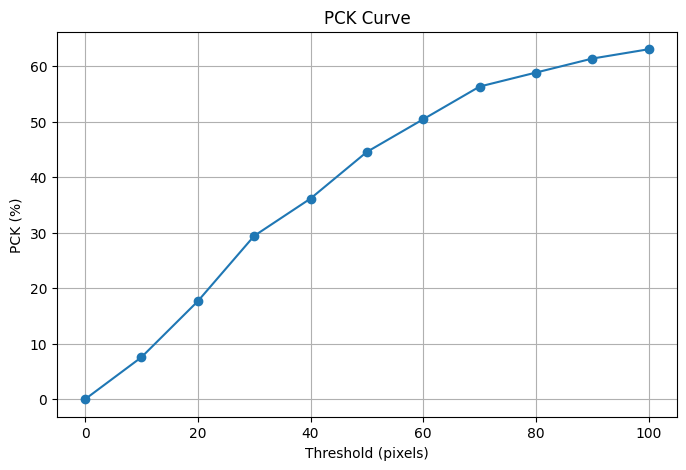

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# ✅ Leer CSV
csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_no_caudalfin_untuned.csv"
df = pd.read_csv(csv_path)

# ✅ Filtrar keypoints no anotados (gt_x o gt_y igual a 0)
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ a) Error Euclidiano Promedio, Mediana, Desviación Estándar
mean_error = df_filtered['euclidean_error'].mean()
median_error = df_filtered['euclidean_error'].median()
std_error = df_filtered['euclidean_error'].std()

print(f"\n📏 Mean Euclidean Error: {mean_error:.2f}")
print(f"📏 Median Euclidean Error: {median_error:.2f}")
print(f"📏 Std Dev of Error: {std_error:.2f}")

# ✅ b) PCK a diferentes umbrales
thresholds = np.arange(0, 101, 10)  # De 0 a 100 píxeles en pasos de 5
pck_values = []

print("\n🎯 PCK Metrics:")
for t in thresholds:
    pck = (df_filtered['euclidean_error'] <= t).mean() * 100
    pck_values.append(pck)
    print(f"PCK@{t}px: {pck:.2f}%")

# ✅ c) AUC del PCK
auc_pck = metrics.auc(thresholds, pck_values) / thresholds[-1]  # Normalizado de 0 a 1
print(f"\n📈 AUC of PCK curve: {auc_pck:.4f}")

# ✅ Graficar curva PCK
plt.figure(figsize=(8, 5))
plt.plot(thresholds, pck_values, marker='o')
plt.xlabel('Threshold (pixels)')
plt.ylabel('PCK (%)')
plt.title('PCK Curve')
plt.grid(True)
plt.show()



📊 Per-Keypoint Metrics:
    Keypoint  Mean Error (px)  Median Error (px)  Std Dev (px)    AUC PCK
0          0       195.701118          24.002377    460.707160  67.142857
1          1       154.942619          43.601278    315.608856  54.285714
2          2       129.961909          85.906167    102.556940  25.714286
3          3       169.186312         111.122062    147.821995  15.000000
4          4       140.600533          25.734380    301.542318  62.857143
5          5       194.975195          49.160887    421.250330  54.285714
6          6       242.598211         208.339541    183.611185  12.142857
7          7       240.324727         216.041227    173.587984  12.142857
8         10       168.347818          26.761001    362.869518  58.571429
9         11       195.051395          42.064278    418.497633  52.857143
10        12       180.322286          32.906072    395.698783  57.142857
11        13       203.809313          39.960509    438.822793  51.428571
12        14 

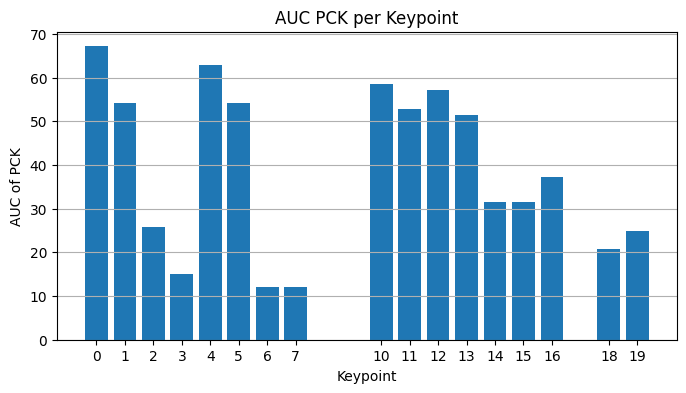

<Figure size 1000x500 with 0 Axes>

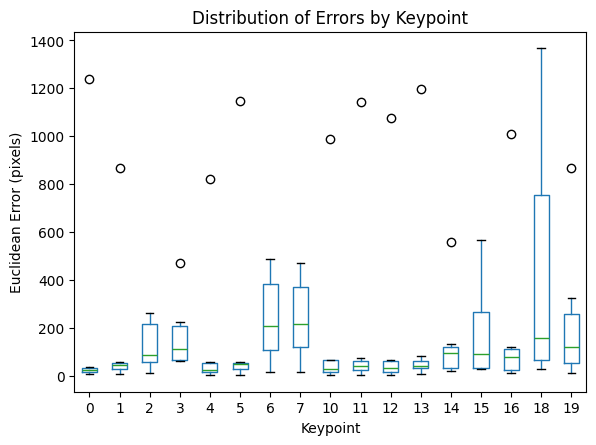

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# ✅ Load CSV
csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_no_caudalfin_untuned.csv"
df = pd.read_csv(csv_path)

# ✅ Filter unannotated keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Thresholds for PCK
thresholds = np.arange(0, 101, 10)

# ✅ Store per-keypoint metrics
keypoint_metrics = []

# ✅ Iterate over keypoints
for kp in sorted(df_filtered['keypoint'].unique()):
    kp_data = df_filtered[df_filtered['keypoint'] == kp]

    # Euclidean error metrics
    mean_error = kp_data['euclidean_error'].mean()
    median_error = kp_data['euclidean_error'].median()
    std_error = kp_data['euclidean_error'].std()

    # PCK metrics
    pck_values = [(kp_data['euclidean_error'] <= t).mean() * 100 for t in thresholds]
    auc_pck = metrics.auc(thresholds, pck_values) / thresholds[-1]

    # Save metrics
    keypoint_metrics.append({
        'Keypoint': kp,
        'Mean Error (px)': mean_error,
        'Median Error (px)': median_error,
        'Std Dev (px)': std_error,
        'AUC PCK': auc_pck
    })

# ✅ Create DataFrame
df_keypoint_metrics = pd.DataFrame(keypoint_metrics)

# ✅ Show table
print("\n📊 Per-Keypoint Metrics:")
print(df_keypoint_metrics)

# ✅ Save results
output_csv = '/data/Datasets/Fish/CavFish/keypoint_metrics_summary.csv'
df_keypoint_metrics.to_csv(output_csv, index=False)
print(f"\n✅ Metrics saved to: {output_csv}")

# ✅ Optional: LaTeX table (for papers)
latex_table = df_keypoint_metrics.to_latex(index=False, float_format="%.2f")
print("\n📄 LaTeX Table:\n")
print(latex_table)

# =====================
# ✅ Visualizations
# =====================

# ✅ AUC PCK bar plot
plt.figure(figsize=(8, 4))
plt.bar(df_keypoint_metrics['Keypoint'], df_keypoint_metrics['AUC PCK'])
plt.xlabel('Keypoint')
plt.ylabel('AUC of PCK')
plt.title('AUC PCK per Keypoint')
plt.xticks(df_keypoint_metrics['Keypoint'])
plt.grid(axis='y')
plt.show()

# ✅ Boxplot of Euclidean Errors
plt.figure(figsize=(10, 5))
df_filtered.boxplot(column='euclidean_error', by='keypoint', grid=False)
plt.xlabel('Keypoint')
plt.ylabel('Euclidean Error (pixels)')
plt.title('Distribution of Errors by Keypoint')
plt.suptitle('')
plt.show()


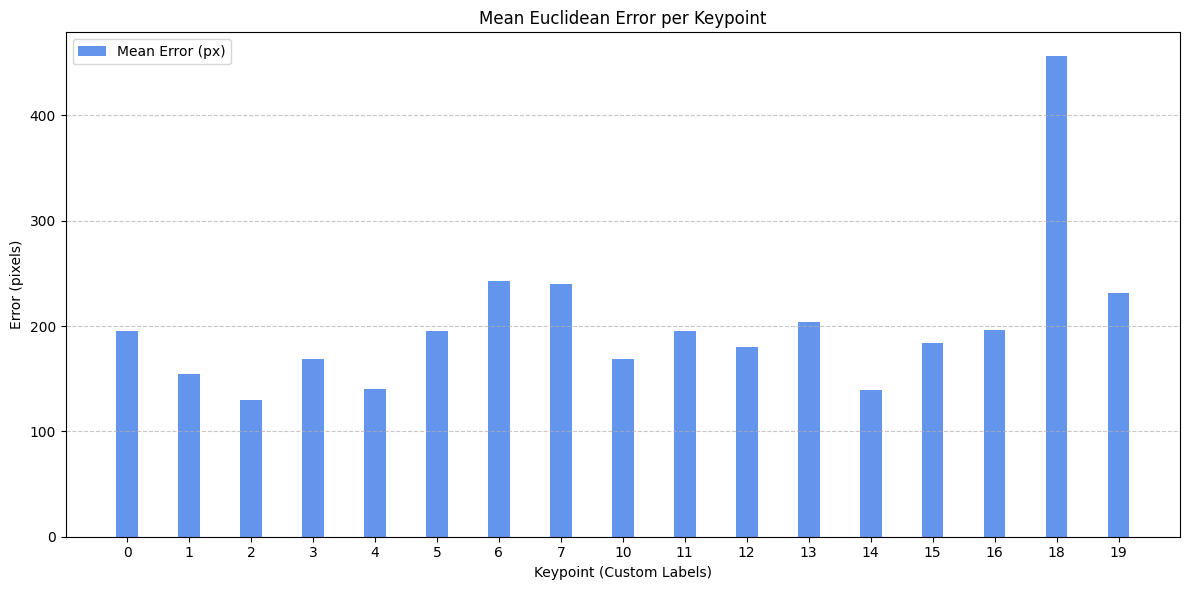

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# ✅ Load CSV
csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_no_caudalfin_untuned.csv"
df = pd.read_csv(csv_path)

# ✅ Filter invalid keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Get actual unique keypoints in sorted order
unique_keypoints = sorted(df_filtered['keypoint'].unique())

# ✅ Thresholds for PCK
thresholds = np.arange(0, 101, 10)

# ✅ Collect metrics
keypoint_metrics = []
for kp in unique_keypoints:
    kp_data = df_filtered[df_filtered['keypoint'] == kp]

    mean_error = kp_data['euclidean_error'].mean()
    median_error = kp_data['euclidean_error'].median()
    std_error = kp_data['euclidean_error'].std()

    pck_values = [(kp_data['euclidean_error'] <= t).mean() * 100 for t in thresholds]
    auc_pck = metrics.auc(thresholds, pck_values) / thresholds[-1]

    keypoint_metrics.append({
        'Keypoint': kp,
        'Mean Error (px)': mean_error,
        'Median Error (px)': median_error,
        'Std Dev (px)': std_error,
        'AUC PCK': auc_pck
    })

# ✅ Create dataframe
df_keypoint_metrics = pd.DataFrame(keypoint_metrics)

# ✅ Save summary
df_keypoint_metrics.to_csv('/data/Datasets/Fish/CavFish/keypoint_metrics_summary.csv', index=False)

# ✅ Now define the alias labels you want (must match the order of the bars)
# Example: keypoints = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
# Display as:           0 1 2 3 4 5 6 7 10 11 12 13 14 15 16 18 19
alias_labels = {
    0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7,
    8: 10, 9: 11, 10: 12, 11: 13, 12: 14, 13: 15, 14: 16,
    15: 18, 16: 19, 17: 20, 18: 21, 19: 22  # example if you want to keep mapping all, adjust as needed
}


# ✅ Generate labels using the real keypoints and your alias
tick_labels = [alias_labels.get(kp, kp) for kp in df_keypoint_metrics['Keypoint']]

# ✅ Bar Plot
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(df_keypoint_metrics))
bar_width = 0.35

bars = ax.bar(x, df_keypoint_metrics['Mean Error (px)'],
              width=bar_width, label='Mean Error (px)', color='cornflowerblue')

ax.set_xlabel('Keypoint (Custom Labels)')
ax.set_ylabel('Error (pixels)')
ax.set_title('Mean Euclidean Error per Keypoint')
ax.set_xticks(x)
ax.set_xticklabels(tick_labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


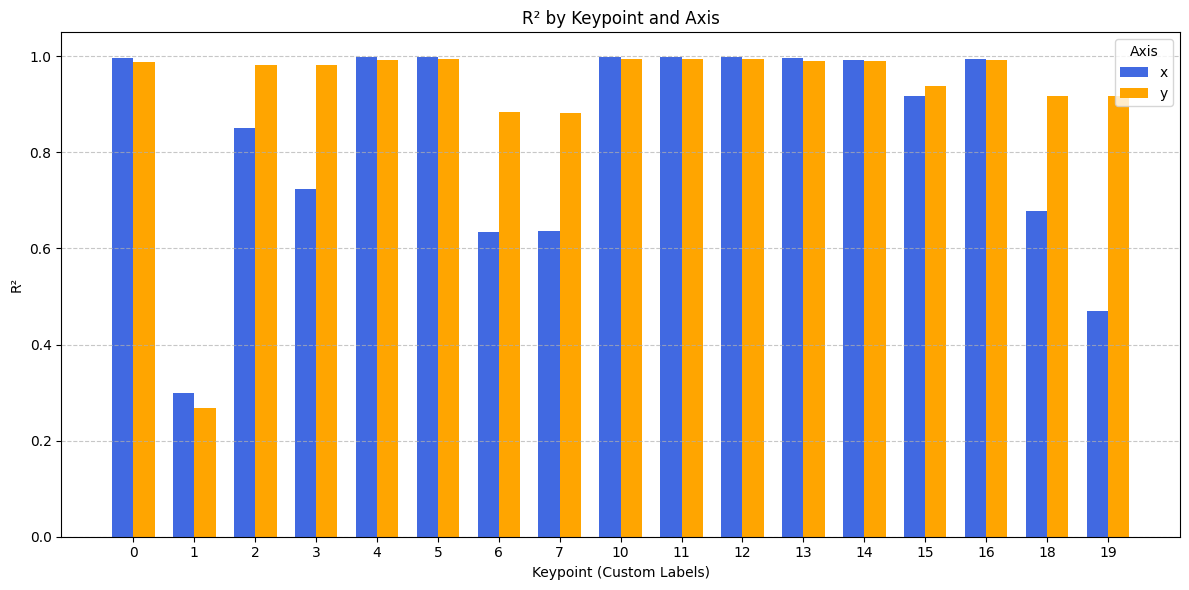

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ✅ Load your CSV
csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_no_caudalfin_300epochs.csv"
df = pd.read_csv(csv_path)

# ✅ Filter invalid keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Compute R² per keypoint and axis
keypoints = sorted(df_filtered['keypoint'].unique())
r2_results = []

for kp in keypoints:
    kp_data = df_filtered[df_filtered['keypoint'] == kp]

    # R² for X-axis
    r2_x = r2_score(kp_data['gt_x'], kp_data['pred_x'])
    # R² for Y-axis
    r2_y = r2_score(kp_data['gt_y'], kp_data['pred_y'])

    r2_results.append({
        'Keypoint': kp,
        'R2_X': r2_x,
        'R2_Y': r2_y
    })

# ✅ Create dataframe
df_r2 = pd.DataFrame(r2_results)

# ✅ Define alias labels as in the first script
alias_labels = {
    0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7,
    8: 10, 9: 11, 10: 12, 11: 13, 12: 14, 13: 15, 14: 16,
    15: 18, 16: 19, 17: 20, 18: 21, 19: 22  # adapt as needed
}

# ✅ Generate tick labels from the alias mapping
tick_labels = [alias_labels.get(kp, kp) for kp in df_r2['Keypoint']]

# ✅ Plot R² per axis
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(df_r2))

bar_width = 0.35
ax.bar(x - bar_width/2, df_r2['R2_X'], width=bar_width, label='x', color='royalblue')
ax.bar(x + bar_width/2, df_r2['R2_Y'], width=bar_width, label='y', color='orange')

# ✅ Axis Labels
ax.set_xlabel('Keypoint (Custom Labels)')
ax.set_ylabel('R²')
ax.set_title('R² by Keypoint and Axis')
ax.set_xticks(x)
ax.set_xticklabels(tick_labels)
ax.set_ylim(0, 1.05)
ax.legend(title='Axis')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Global R² X: 0.8522
Global R² Y: 0.9085


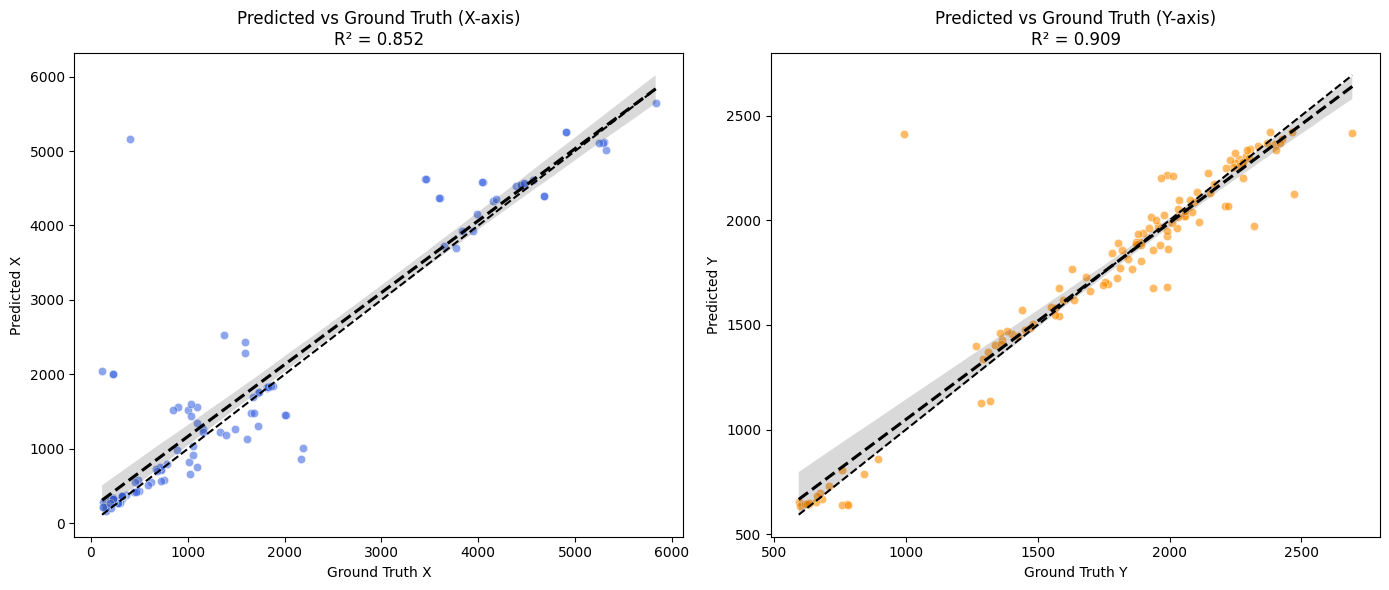

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns

# ✅ Load your CSV
csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_no_caudalfin_300epochs.csv"
df = pd.read_csv(csv_path)

# ✅ Filter invalid keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Calculate Global R²
r2_x = r2_score(df_filtered['gt_x'], df_filtered['pred_x'])
r2_y = r2_score(df_filtered['gt_y'], df_filtered['pred_y'])

print(f"Global R² X: {r2_x:.4f}")
print(f"Global R² Y: {r2_y:.4f}")

# ✅ Scatter plots with regression
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for X
sns.scatterplot(data=df_filtered, x='gt_x', y='pred_x', ax=axes[0], color='royalblue', alpha=0.6)
sns.regplot(data=df_filtered, x='gt_x', y='pred_x', ax=axes[0], scatter=False, color='black', line_kws={'linestyle': '--'})
axes[0].plot([df_filtered['gt_x'].min(), df_filtered['gt_x'].max()],
             [df_filtered['gt_x'].min(), df_filtered['gt_x'].max()],
             linestyle='--', color='black')
axes[0].set_title(f'Predicted vs Ground Truth (X-axis)\nR² = {r2_x:.3f}')
axes[0].set_xlabel('Ground Truth X')
axes[0].set_ylabel('Predicted X')

# Plot for Y
sns.scatterplot(data=df_filtered, x='gt_y', y='pred_y', ax=axes[1], color='darkorange', alpha=0.6)
sns.regplot(data=df_filtered, x='gt_y', y='pred_y', ax=axes[1], scatter=False, color='black', line_kws={'linestyle': '--'})
axes[1].plot([df_filtered['gt_y'].min(), df_filtered['gt_y'].max()],
             [df_filtered['gt_y'].min(), df_filtered['gt_y'].max()],
             linestyle='--', color='black')
axes[1].set_title(f'Predicted vs Ground Truth (Y-axis)\nR² = {r2_y:.3f}')
axes[1].set_xlabel('Ground Truth Y')
axes[1].set_ylabel('Predicted Y')

plt.tight_layout()
plt.show()


In [36]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error

# ✅ Load your CSV
csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_no_caudalfin_300epochs.csv"
df = pd.read_csv(csv_path)

# ✅ Filter invalid keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Flatten X and Y into a single vector
gt_all = np.concatenate([df_filtered['gt_x'].values, df_filtered['gt_y'].values])
pred_all = np.concatenate([df_filtered['pred_x'].values, df_filtered['pred_y'].values])

# ✅ Compute global metrics
r2 = r2_score(gt_all, pred_all)
rmse = np.sqrt(mean_squared_error(gt_all, pred_all))
mae = mean_absolute_error(gt_all, pred_all)
maxerr = max_error(gt_all, pred_all)

# ✅ Print results
print(f"{'R2':<10} {'RMSE':<10} {'MAE':<10} {'MaxError':<10}")
print(f"{r2:<10.6f} {rmse:<10.4f} {mae:<10.4f} {maxerr:<10.4f}")


R2         RMSE       MAE        MaxError  
0.857623   460.4217   184.0768   4760.0965 


## Depressed Body

In [ ]:
!python tools/train.py \
    /home/arumota_pupils/Josue/1PECES/MMPose/mmpose/configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_ViTPose-fish9_8xb32-100etrain_depressed.py

In [12]:
import os
import json
import pandas as pd

# ---- paths you set ----
json_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
csv_path  = '/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_ViTPose_ViTPose_PhenoLossNoResAug.csv'     # <-- your CSV (with a column named 'image')
out_csv   = '/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_depressed_PhenoLossNoResAug.csv'
target_labels = {'Depressed body'}

# ---- helpers ----
def canonize_path(p: str) -> str:
    # normalize case & slashes; strip whitespace
    p = (p or "").strip().replace("\\", "/")
    # remove leading "./"
    if p.startswith("./"):
        p = p[2:]
    return p

# ---- 1) gather names from JSON for target classes ----
with open(json_path, "r") as f:
    val = json.load(f)

json_relpaths = {
    canonize_path(img["file_name"])
    for img in val.get("images", [])
    if img.get("label") in target_labels
}

# also keep a basename set in case your CSV stores only filenames
json_basenames = {os.path.basename(p) for p in json_relpaths}

print(f"Found {len(json_relpaths)} images labeled {target_labels} in JSON.")

# ---- 2) load CSV and filter by name match ----
df = pd.read_csv(csv_path)

if "image" not in df.columns:
    raise ValueError("CSV must have a column named 'image'.")

# Build two keys to be flexible: relative-path key and basename key
csv_rel = df["image"].astype(str).map(canonize_path)
csv_base = csv_rel.map(os.path.basename)

mask = csv_rel.isin(json_relpaths) | csv_base.isin(json_basenames)
df_filtered = df[mask].copy()

print(f"Rows before: {len(df)} | after filter: {len(df_filtered)}")

# ---- 3) save ----
df_filtered.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")


Found 47 images labeled {'Depressed body'} in JSON.
Rows before: 3520 | after filter: 940
Saved: /data/Datasets/Fish/CavFish/Predictions/augmented/predictions_depressed_PhenoLossNoResAug.csv


### Filtrar para tener solo 19 kpt

En entrenamiento

In [ ]:
import json

# Paths
input_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_train.json'
output_path = '/data/Datasets/Fish/CavFish/depressed_body_19kpt_train.json'

# Load JSON
with open(input_path, 'r') as f:
    coco = json.load(f)

# Map image ID to label
image_id_to_label = {img['id']: img.get('label', 'unknown') for img in coco['images']}

target_class = 'Depressed body'
expected_kpts = 19
keypoint_to_remove = 13  # 🛑 Keypoint que se va a eliminar (índice base 0)

fixed_annotations = []

for ann in coco['annotations']:
    image_id = ann['image_id']
    label = image_id_to_label.get(image_id, 'unknown')

    if label != target_class:
        continue  # 🛑 Saltar anotaciones de otras clases

    kps = ann['keypoints']

    # Eliminar el keypoint número 14
    kps = kps[:keypoint_to_remove * 3] + kps[(keypoint_to_remove + 1) * 3:]

    # Verificar cuántos keypoints quedan
    n_kpts = len(kps) // 3

    # Rellenar si hay menos de los esperados
    if n_kpts < expected_kpts:
        kps += [0.0, 0.0, 0] * (expected_kpts - n_kpts)

    ann_copy = ann.copy()
    ann_copy['keypoints'] = kps
    ann_copy['num_keypoints'] = expected_kpts  # Opcional, si quieres actualizar el contador
    fixed_annotations.append(ann_copy)  # ✅ Solo guardamos los "Depressed body"

# Filtrar imágenes asociadas
used_image_ids = {ann['image_id'] for ann in fixed_annotations}
filtered_images = [
    img for img in coco['images']
    if img['id'] in used_image_ids and img.get('label') == target_class
]

# Construir nuevo COCO JSON
filtered_coco = {
    'info': coco.get('info', {}),
    'licenses': coco.get('licenses', []),
    'images': filtered_images,
    'annotations': fixed_annotations,
    'categories': coco.get('categories', [])
}

# Guardar
with open(output_path, 'w') as f:
    json.dump(filtered_coco, f, indent=2)

print(f"✅ Guardado en: {output_path}")
print(f"📊 Anotaciones totales: {len(fixed_annotations)}")
print(f"🖼️  Imágenes totales: {len(filtered_images)}")


✅ Guardado en: /data/Datasets/Fish/CavFish/depressed_body_19kpt_train.json
📊 Anotaciones totales: 518
🖼️  Imágenes totales: 518


En Testeo

In [21]:
import json

# Paths
input_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
output_path = '/data/Datasets/Fish/CavFish/depressed_body_19kpt_val.json'

# Load JSON
with open(input_path, 'r') as f:
    coco = json.load(f)

# Map image ID to label
image_id_to_label = {img['id']: img.get('label', 'unknown') for img in coco['images']}

target_class = 'Depressed body'
expected_kpts = 19
keypoint_to_remove = 13  # 🛑 Keypoint que se va a eliminar (índice base 0)

fixed_annotations = []

for ann in coco['annotations']:
    image_id = ann['image_id']
    label = image_id_to_label.get(image_id, 'unknown')

    if label != target_class:
        continue  # 🛑 Saltar anotaciones de otras clases

    kps = ann['keypoints']

    # Eliminar el keypoint número 14
    kps = kps[:keypoint_to_remove * 3] + kps[(keypoint_to_remove + 1) * 3:]

    # Verificar cuántos keypoints quedan
    n_kpts = len(kps) // 3

    # Rellenar si hay menos de los esperados
    if n_kpts < expected_kpts:
        kps += [0.0, 0.0, 0] * (expected_kpts - n_kpts)

    ann_copy = ann.copy()
    ann_copy['keypoints'] = kps
    ann_copy['num_keypoints'] = expected_kpts  # Opcional, si quieres actualizar el contador
    fixed_annotations.append(ann_copy)  # ✅ Solo guardamos los "Depressed body"

# Filtrar imágenes asociadas
used_image_ids = {ann['image_id'] for ann in fixed_annotations}
filtered_images = [
    img for img in coco['images']
    if img['id'] in used_image_ids and img.get('label') == target_class
]

# Construir nuevo COCO JSON
filtered_coco = {
    'info': coco.get('info', {}),
    'licenses': coco.get('licenses', []),
    'images': filtered_images,
    'annotations': fixed_annotations,
    'categories': coco.get('categories', [])
}

# Guardar
with open(output_path, 'w') as f:
    json.dump(filtered_coco, f, indent=2)

print(f"✅ Guardado en: {output_path}")
print(f"📊 Anotaciones totales: {len(fixed_annotations)}")
print(f"🖼️  Imágenes totales: {len(filtered_images)}")


✅ Guardado en: /data/Datasets/Fish/CavFish/depressed_body_19kpt_val.json
📊 Anotaciones totales: 47
🖼️  Imágenes totales: 47


### Distribución de keypoints

In [26]:
import json
from collections import Counter

# Ajusta la ruta si tu archivo está en otro directorio
json_path = '/data/Datasets/Fish/CavFish/depressed_body_19kpt_val.json'

with open(json_path, 'r') as f:
    coco = json.load(f)

# Cuenta cuántos keypoints tiene cada anotación
kp_counts = Counter()
for ann in coco['annotations']:
    # COCO almacena keypoints como [x1,y1,v1, x2,y2,v2, …]
    num_kps = len(ann['keypoints']) // 3
    kp_counts[num_kps] += 1

print('Distribución de keypoints por anotación:')
for num_kps, cnt in sorted(kp_counts.items()):
    print(f'  {num_kps} keypoints → {cnt} instancias')

# Opcional: revisa la definición en "categories"
cat = coco.get('categories', [{}])[0]
print('\nkeypoints definidas en categories:', cat.get('keypoints', []))
print('Número de entradas en categories["keypoints"] =', len(cat.get('keypoints', [])))


Distribución de keypoints por anotación:
  19 keypoints → 47 instancias

keypoints definidas en categories: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
Número de entradas en categories["keypoints"] = 20


### Inferencia

In [ ]:
# Se extrae la ruta de la imagen. Final
import os
import json
import subprocess

# Configuración de rutas
json_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
dataset_root = '/data/Datasets/Fish/CavFish'
output_folder = '/data/Datasets/Fish/CavFish/inference_no_caudalfin_ViTPose_untuned/'
config_path = 'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_ViTPose-fish9_8xb32-100etrain_no_caudal.py'
checkpoint_path = '/data/Pupils/Josue/weights/Fish/ViTPose_no_caudal_fin_20kpt_300epochs/epoch_300.pth'
merged_json_path = os.path.join(output_folder, 'all_keypoints_predicted_no_caudalfin_ViTPose.json')

# Clase(s) objetivo a filtrar
target_labels = ['Compressed body_without caudal fin']

# Crear carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Leer el archivo JSON de validación
with open(json_path, 'r') as f:
    val_data = json.load(f)

# Almacenar todas las predicciones
all_predictions = []

# Recorrer cada imagen del archivo de validación
for image_info in val_data['images']:
    # Filtrar por clase (label)
    if image_info.get('label') not in target_labels:
        continue

    relative_path = image_info['file_name']  # ej: "2018 Guayavero Duda/IMG_0084-Edit.jpg"
    full_path = os.path.join(dataset_root, relative_path)

    # Nombre de imagen para guardar outputs
    img_name = os.path.basename(relative_path)
    out_base = os.path.join(output_folder, img_name)
    out_json = out_base.replace('.jpg', '_keypoints.json').replace('.png', '_keypoints.json')

    # Verificación de existencia de imagen
    if not os.path.exists(full_path):
        print(f"⚠️ Imagen no encontrada: {full_path}")
        continue

    # Ejecutar la inferencia
    cmd = [
        "python", "demo/image_demo_no_caudal.py",
        full_path,
        config_path,
        checkpoint_path,
        "--out-file", out_base,
        "--draw-heatmap",
        "--show-kpt-idx"
    ]

    print(f"🔁 Procesando {relative_path}...")
    subprocess.run(cmd)

    # Leer predicción y asociarla a la ruta relativa original (no solo nombre)
    if os.path.exists(out_json):
        with open(out_json, 'r') as f:
            pred = json.load(f)

        # Normalizar output para que coincida con GT
        pred["image"] = relative_path  # Sobrescribe con la ruta relativa del GT
        all_predictions.append(pred)
    else:
        print(f"⚠️ No se encontró JSON de salida para {img_name}")

# Guardar todas las predicciones en un solo archivo
with open(merged_json_path, 'w') as f:
    json.dump(all_predictions, f, indent=4)

print(f"\n✅ JSON consolidado guardado en: {merged_json_path}")


🔁 Procesando 2018 Guayavero Duda/IMG_1684-Edit.jpg...


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_no_caudal_fin_20kpt_300epochs/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=221.2, y=1973.3, score=0.940

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_no_caudalfin_ViTPose_300epochs/IMG_1684-Edit_keypoints.json
 - 1: x=5642.1, y=2020.3, score=0.528

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_no_caudalfin_ViTPose_300epochs/IMG_1684-Edit_keypoints.json
 - 2: x=2292.7, y=1815.2, score=0.480

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_no_caudalfin_ViTPose_300epochs/IMG_1684-Edit_keypoints.json
 - 3: x=2428.5, 

In [9]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Rutas
pred_file = Path("/data/Datasets/Fish/CavFish/inference_depressed_ViTPose_untuned/all_keypoints_predicted_depressed_ViTPose.json")
gt_file = Path("/data/Datasets/Fish/CavFish/fish20kpt_all_val.json")

# Cargar archivos
with pred_file.open("r") as f:
    pred_data = json.load(f)

with gt_file.open("r") as f:
    gt_data = json.load(f)

# Crear índice de anotaciones por imagen
image_id_to_name = {img['id']: img['file_name'] for img in gt_data['images']}
annotations_by_name = {
    image_id_to_name[ann['image_id']]: np.array(ann['keypoints']).reshape(-1, 3)[:, :2]
    for ann in gt_data['annotations']
}

# Comparación punto a punto
rows = []
gt_all = []
pred_all = []

for item in pred_data:
    name = item["image"]
    pred_kpts = {kp["name"]: (kp["x"], kp["y"]) for kp in item["keypoints"]}
    gt_kpts = annotations_by_name.get(name)

    if gt_kpts is None:
        print(f"⚠️ Imagen {name} no encontrada en GT.")
        continue

    for idx, (gt_xy, (kpt_name, pred_xy)) in enumerate(zip(gt_kpts, pred_kpts.items())):
        error = np.linalg.norm(np.array(pred_xy) - np.array(gt_xy))
        rows.append({
            "image": name,
            "keypoint": kpt_name,
            "gt_x": gt_xy[0],
            "gt_y": gt_xy[1],
            "pred_x": pred_xy[0],
            "pred_y": pred_xy[1],
            "euclidean_error": error
        })
        gt_all.extend(gt_xy)
        pred_all.extend(pred_xy)

df = pd.DataFrame(rows)

# --- 1. Métricas globales por keypoint ---
trait_metrics = []
for kpt in df["keypoint"].unique():
    sub = df[df["keypoint"] == kpt]
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    trait_metrics.append({
        "keypoint": kpt,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy)
    })
df_trait = pd.DataFrame(trait_metrics)
df_trait.to_csv("/data/Datasets/Fish/CavFish/metrics_per_keypoint_depressed_ViTPose.csv", index=False)

# --- 2. Métricas por imagen ---
image_metrics = []
for img in df["image"].unique():
    sub = df[df["image"] == img]
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    image_metrics.append({
        "image": img,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy)
    })
df_image = pd.DataFrame(image_metrics)
df_image.to_csv("/data/Datasets/Fish/CavFish/metrics20_per_image_depressed_ViTPose.csv", index=False)

# --- 3. Métricas por keypoint e imagen ---
trait_image_metrics = []
for (img, kpt), sub in df.groupby(["image", "keypoint"]):
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    trait_image_metrics.append({
        "image": img,
        "keypoint": kpt,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy) if len(gt_xy) > 1 else None
    })
df_trait_image = pd.DataFrame(trait_image_metrics)
df_trait_image.to_csv("/data/Datasets/Fish/CavFish/metrics_per_keypoint20_depressed_image_ViTPose.csv", index=False)

print("✅ ¡Listo! Se guardaron los tres archivos CSV:")
print("- metrics_per_keypoint.csv")
print("- metrics_per_image.csv")
print("- metrics_per_keypoint_image.csv")

✅ ¡Listo! Se guardaron los tres archivos CSV:
- metrics_per_keypoint.csv
- metrics_per_image.csv
- metrics_per_keypoint_image.csv


In [ ]:
df = pd.DataFrame(rows)

# Exportar datos individuales de puntos
df.to_csv("/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_depressed_untuned.csv", index=False)


📏 Mean Euclidean Error: 115.88
📏 Median Euclidean Error: 52.24
📏 Std Dev of Error: 256.28

🎯 PCK Metrics:
PCK@0px: 0.00%
PCK@10px: 6.40%
PCK@20px: 18.98%
PCK@30px: 31.43%
PCK@40px: 41.33%
PCK@50px: 48.66%
PCK@60px: 55.30%
PCK@70px: 60.42%
PCK@80px: 65.19%
PCK@90px: 70.31%
PCK@100px: 72.76%

📈 AUC of PCK curve: 43.4400


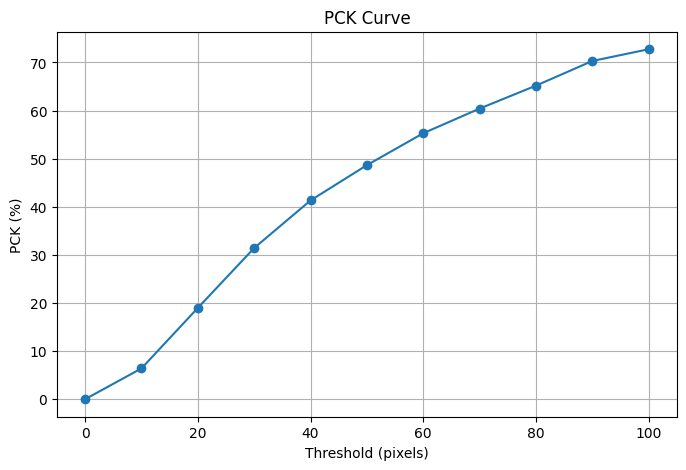

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# ✅ Leer CSV
csv_path = '/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_depressed300epochs.csv'
df = pd.read_csv(csv_path)

# ✅ Filtrar keypoints no anotados (gt_x o gt_y igual a 0)
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ a) Error Euclidiano Promedio, Mediana, Desviación Estándar
mean_error = df_filtered['euclidean_error'].mean()
median_error = df_filtered['euclidean_error'].median()
std_error = df_filtered['euclidean_error'].std()

print(f"\n📏 Mean Euclidean Error: {mean_error:.2f}")
print(f"📏 Median Euclidean Error: {median_error:.2f}")
print(f"📏 Std Dev of Error: {std_error:.2f}")

# ✅ b) PCK a diferentes umbrales
thresholds = np.arange(0, 101, 10)  # De 0 a 100 píxeles en pasos de 5
pck_values = []

print("\n🎯 PCK Metrics:")
for t in thresholds:
    pck = (df_filtered['euclidean_error'] <= t).mean() * 100
    pck_values.append(pck)
    print(f"PCK@{t}px: {pck:.2f}%")

# ✅ c) AUC del PCK
auc_pck = metrics.auc(thresholds, pck_values) / thresholds[-1]  # Normalizado de 0 a 1
print(f"\n📈 AUC of PCK curve: {auc_pck:.4f}")

# ✅ Graficar curva PCK
plt.figure(figsize=(8, 5))
plt.plot(thresholds, pck_values, marker='o')
plt.xlabel('Threshold (pixels)')
plt.ylabel('PCK (%)')
plt.title('PCK Curve')
plt.grid(True)
plt.show()



📊 Per-Keypoint Metrics:
    Keypoint  Mean Error (px)  Median Error (px)  Std Dev (px)    AUC PCK
0          0        91.517670          38.183840    232.827063  51.382979
1          1        60.611747          37.338739     75.513074  54.574468
2          2       124.247001          58.446211    269.797633  39.574468
3          3       116.319387          65.727025    175.688917  38.297872
4          4       177.035164          52.236970    530.792053  42.446809
5          5        97.260624          39.371397    203.457948  48.085106
6          6        73.672333          49.198370     88.342510  48.297872
7          7        74.883616          48.139192     93.366294  48.829787
8          8       117.690078          60.646085    230.061024  40.744681
9          9       108.106314          49.129858    240.378021  45.106383
10        10       124.419483          60.271629    219.019727  39.468085
11        11       116.698788          58.687336    213.101998  39.893617
12        12 

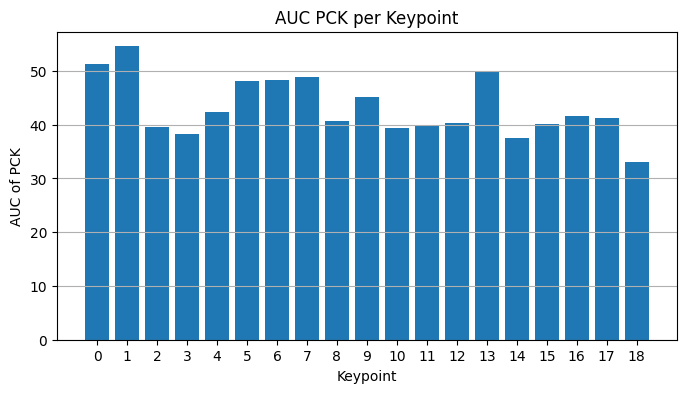

<Figure size 1000x500 with 0 Axes>

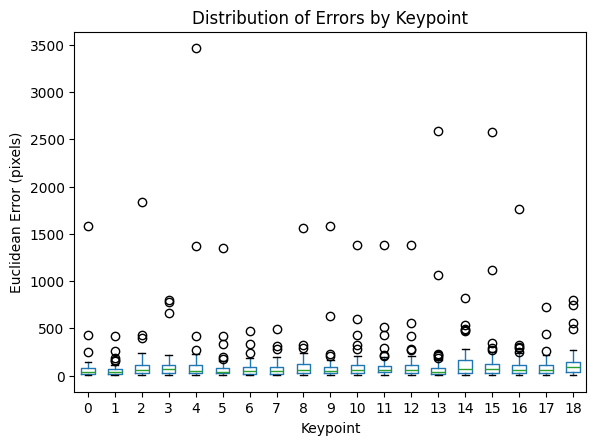

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# ✅ Load CSV
csv_path = '/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_depressed300epochs.csv'
df = pd.read_csv(csv_path)

# ✅ Filter unannotated keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Thresholds for PCK
thresholds = np.arange(0, 101, 10)

# ✅ Store per-keypoint metrics
keypoint_metrics = []

# ✅ Iterate over keypoints
for kp in sorted(df_filtered['keypoint'].unique()):
    kp_data = df_filtered[df_filtered['keypoint'] == kp]

    # Euclidean error metrics
    mean_error = kp_data['euclidean_error'].mean()
    median_error = kp_data['euclidean_error'].median()
    std_error = kp_data['euclidean_error'].std()

    # PCK metrics
    pck_values = [(kp_data['euclidean_error'] <= t).mean() * 100 for t in thresholds]
    auc_pck = metrics.auc(thresholds, pck_values) / thresholds[-1]

    # Save metrics
    keypoint_metrics.append({
        'Keypoint': kp,
        'Mean Error (px)': mean_error,
        'Median Error (px)': median_error,
        'Std Dev (px)': std_error,
        'AUC PCK': auc_pck
    })

# ✅ Create DataFrame
df_keypoint_metrics = pd.DataFrame(keypoint_metrics)

# ✅ Show table
print("\n📊 Per-Keypoint Metrics:")
print(df_keypoint_metrics)

# ✅ Save results
output_csv = '/data/Datasets/Fish/CavFish/keypoint_metrics_summary.csv'
df_keypoint_metrics.to_csv(output_csv, index=False)
print(f"\n✅ Metrics saved to: {output_csv}")

# ✅ Optional: LaTeX table (for papers)
latex_table = df_keypoint_metrics.to_latex(index=False, float_format="%.2f")
print("\n📄 LaTeX Table:\n")
print(latex_table)

# =====================
# ✅ Visualizations
# =====================

# ✅ AUC PCK bar plot
plt.figure(figsize=(8, 4))
plt.bar(df_keypoint_metrics['Keypoint'], df_keypoint_metrics['AUC PCK'])
plt.xlabel('Keypoint')
plt.ylabel('AUC of PCK')
plt.title('AUC PCK per Keypoint')
plt.xticks(df_keypoint_metrics['Keypoint'])
plt.grid(axis='y')
plt.show()

# ✅ Boxplot of Euclidean Errors
plt.figure(figsize=(10, 5))
df_filtered.boxplot(column='euclidean_error', by='keypoint', grid=False)
plt.xlabel('Keypoint')
plt.ylabel('Euclidean Error (pixels)')
plt.title('Distribution of Errors by Keypoint')
plt.suptitle('')
plt.show()

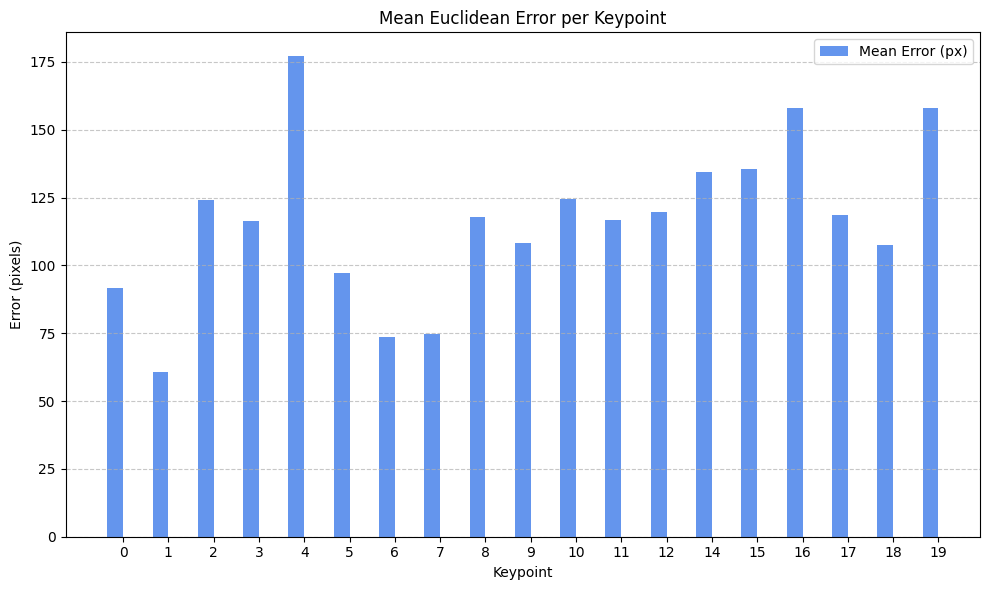

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# ✅ Load your CSV
csv_path = '/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_depressed300epochs.csv'
df = pd.read_csv(csv_path)

# ✅ Filter invalid keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Thresholds for PCK
thresholds = np.arange(0, 101, 10)

# ✅ Collect metrics
keypoint_metrics = []
for kp in sorted(df_filtered['keypoint'].unique()):
    kp_data = df_filtered[df_filtered['keypoint'] == kp]

    mean_error = kp_data['euclidean_error'].mean()
    median_error = kp_data['euclidean_error'].median()
    std_error = kp_data['euclidean_error'].std()

    pck_values = [(kp_data['euclidean_error'] <= t).mean() * 100 for t in thresholds]
    auc_pck = metrics.auc(thresholds, pck_values) / thresholds[-1]

    keypoint_metrics.append({
        'Keypoint': kp,
        'Mean Error (px)': mean_error,
        'Median Error (px)': median_error,
        'Std Dev (px)': std_error,
        'AUC PCK': auc_pck
    })

# ✅ Create dataframe
df_keypoint_metrics = pd.DataFrame(keypoint_metrics)

# ✅ Save summary
df_keypoint_metrics.to_csv('/data/Datasets/Fish/CavFish/keypoint_metrics_summary.csv', index=False)

# ✅ Bar Plot 1: Mean vs Median
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df_keypoint_metrics['Keypoint']))
bar_width = 0.35

bars1 = ax.bar(x - bar_width / 2, df_keypoint_metrics['Mean Error (px)'],
               width=bar_width, label='Mean Error (px)', color='cornflowerblue')

# ✅ Create custom tick labels
tick_labels = []
for kp in df_keypoint_metrics['Keypoint']:
    if kp >= 13:
        tick_labels.append(kp + 1)  # Shift by +1 after 13
    else:
        tick_labels.append(kp)

ax.set_xlabel('Keypoint')
ax.set_ylabel('Error (pixels)')
ax.set_title('Mean Euclidean Error per Keypoint')
ax.set_xticks(x)
ax.set_xticklabels(tick_labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

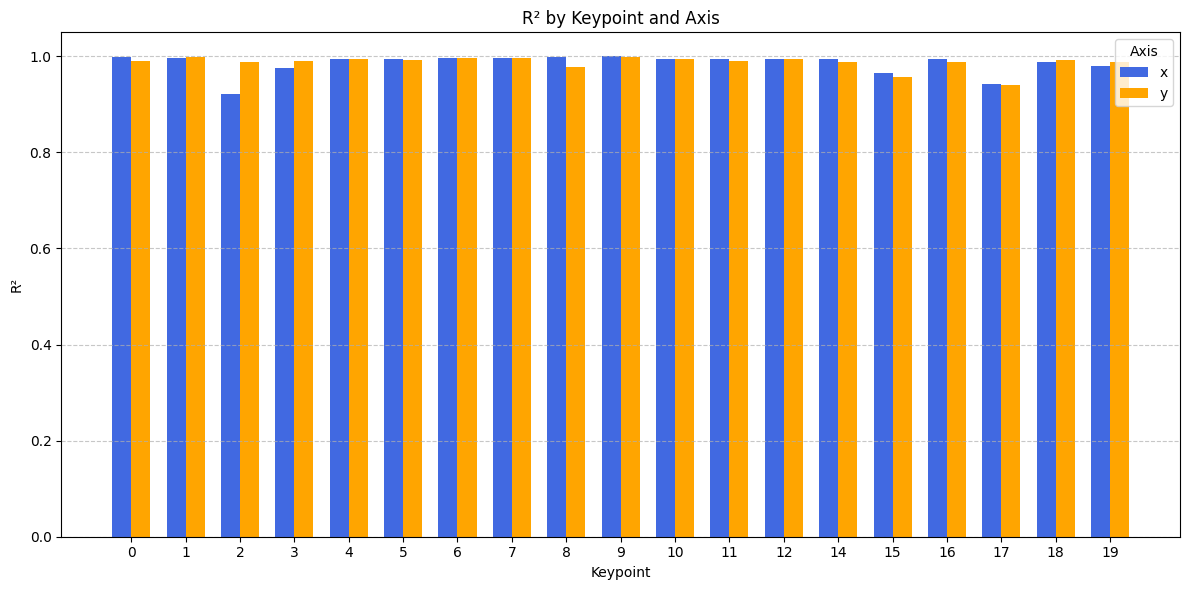

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ✅ Load your CSV
csv_path = '/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_depressed_untuned.csv'
df = pd.read_csv(csv_path)

# ✅ Filter invalid keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Compute R² per keypoint and axis
keypoints = sorted(df_filtered['keypoint'].unique())
r2_results = []

for kp in keypoints:
    kp_data = df_filtered[df_filtered['keypoint'] == kp]

    # R² for X-axis
    r2_x = r2_score(kp_data['gt_x'], kp_data['pred_x'])
    # R² for Y-axis
    r2_y = r2_score(kp_data['gt_y'], kp_data['pred_y'])

    r2_results.append({
        'Keypoint': kp,
        'R2_X': r2_x,
        'R2_Y': r2_y
    })

# ✅ Create dataframe
df_r2 = pd.DataFrame(r2_results)

# ✅ Custom tick labels (shift after 13)
tick_labels = []
for kp in df_r2['Keypoint']:
    if kp >= 50:
        tick_labels.append(kp + 1)
    else:
        tick_labels.append(kp)

# ✅ Plot R² per axis
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(df_r2['Keypoint']))

bar_width = 0.35
ax.bar(x - bar_width/2, df_r2['R2_X'], width=bar_width, label='x', color='royalblue')
ax.bar(x + bar_width/2, df_r2['R2_Y'], width=bar_width, label='y', color='orange')

# ✅ Axis Labels
ax.set_xlabel('Keypoint')
ax.set_ylabel('R²')
ax.set_title('R² by Keypoint and Axis')
ax.set_xticks(x)
ax.set_xticklabels(tick_labels)
ax.set_ylim(0, 1.05)
ax.legend(title='Axis')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



Global R² X: 0.9923
Global R² Y: 0.9894


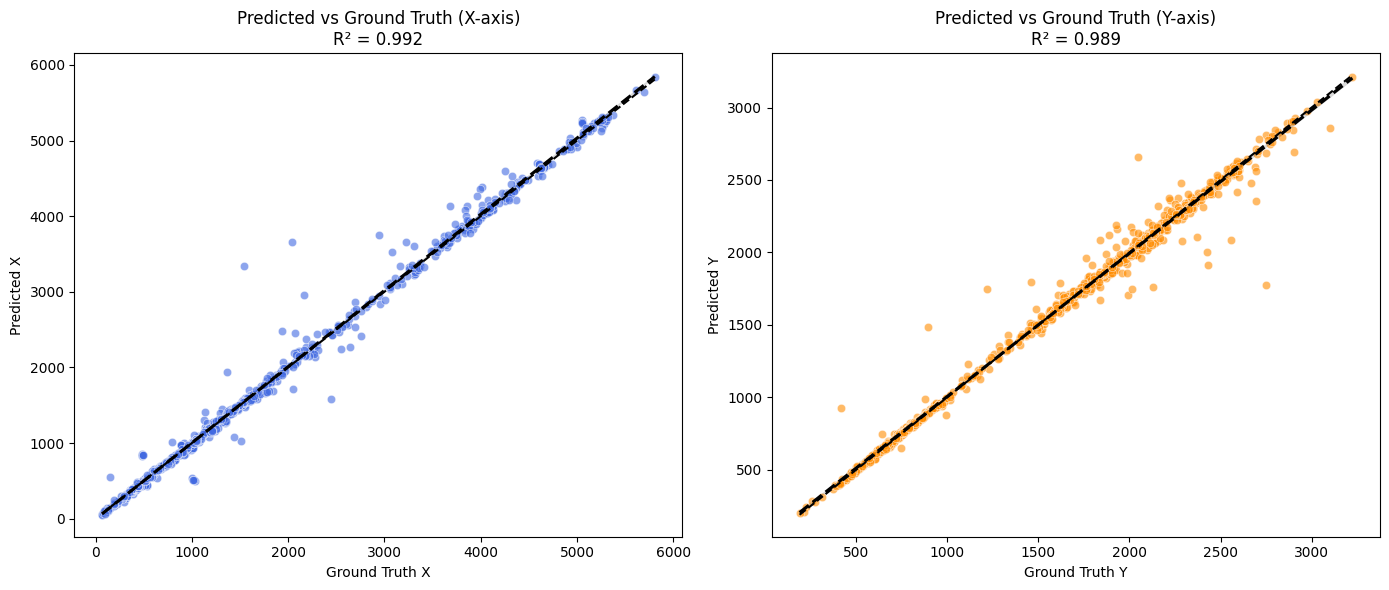

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns

# ✅ Load your CSV
csv_path = '/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_depressed_untuned.csv'
df = pd.read_csv(csv_path)

# ✅ Filter invalid keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Calculate Global R²
r2_x = r2_score(df_filtered['gt_x'], df_filtered['pred_x'])
r2_y = r2_score(df_filtered['gt_y'], df_filtered['pred_y'])

print(f"Global R² X: {r2_x:.4f}")
print(f"Global R² Y: {r2_y:.4f}")

# ✅ Scatter plots with regression
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for X
sns.scatterplot(data=df_filtered, x='gt_x', y='pred_x', ax=axes[0], color='royalblue', alpha=0.6)
sns.regplot(data=df_filtered, x='gt_x', y='pred_x', ax=axes[0], scatter=False, color='black', line_kws={'linestyle': '--'})
axes[0].plot([df_filtered['gt_x'].min(), df_filtered['gt_x'].max()],
             [df_filtered['gt_x'].min(), df_filtered['gt_x'].max()],
             linestyle='--', color='black')
axes[0].set_title(f'Predicted vs Ground Truth (X-axis)\nR² = {r2_x:.3f}')
axes[0].set_xlabel('Ground Truth X')
axes[0].set_ylabel('Predicted X')

# Plot for Y
sns.scatterplot(data=df_filtered, x='gt_y', y='pred_y', ax=axes[1], color='darkorange', alpha=0.6)
sns.regplot(data=df_filtered, x='gt_y', y='pred_y', ax=axes[1], scatter=False, color='black', line_kws={'linestyle': '--'})
axes[1].plot([df_filtered['gt_y'].min(), df_filtered['gt_y'].max()],
             [df_filtered['gt_y'].min(), df_filtered['gt_y'].max()],
             linestyle='--', color='black')
axes[1].set_title(f'Predicted vs Ground Truth (Y-axis)\nR² = {r2_y:.3f}')
axes[1].set_xlabel('Ground Truth Y')
axes[1].set_ylabel('Predicted Y')

plt.tight_layout()
plt.show()


In [40]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error

# ✅ Load your CSV
csv_path = '/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_depressed_untuned.csv'
df = pd.read_csv(csv_path)

# ✅ Filter invalid keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Flatten X and Y into a single vector
gt_all = np.concatenate([df_filtered['gt_x'].values, df_filtered['gt_y'].values])
pred_all = np.concatenate([df_filtered['pred_x'].values, df_filtered['pred_y'].values])

# ✅ Compute global metrics
r2 = r2_score(gt_all, pred_all)
rmse = np.sqrt(mean_squared_error(gt_all, pred_all))
mae = mean_absolute_error(gt_all, pred_all)
maxerr = max_error(gt_all, pred_all)

# ✅ Print results
print(f"{'R2':<10} {'RMSE':<10} {'MAE':<10} {'MaxError':<10}")
print(f"{r2:<10.6f} {rmse:<10.4f} {mae:<10.4f} {maxerr:<10.4f}")


R2         RMSE       MAE        MaxError  
0.992041   106.6703   39.8509    1803.6628 


## Compressed

### Extract from the all samples csv

In [12]:
import os
import json
import pandas as pd

# ---- paths you set ----
json_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
csv_path  = '/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_ViTPose_minphenoloss.csv'     # <-- your CSV (with a column named 'image')
out_csv   = '/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_depressed_minphenoloss.csv'
target_labels = {'Depressed body'}

# ---- helpers ----
def canonize_path(p: str) -> str:
    # normalize case & slashes; strip whitespace
    p = (p or "").strip().replace("\\", "/")
    # remove leading "./"
    if p.startswith("./"):
        p = p[2:]
    return p

# ---- 1) gather names from JSON for target classes ----
with open(json_path, "r") as f:
    val = json.load(f)

json_relpaths = {
    canonize_path(img["file_name"])
    for img in val.get("images", [])
    if img.get("label") in target_labels
}

# also keep a basename set in case your CSV stores only filenames
json_basenames = {os.path.basename(p) for p in json_relpaths}

print(f"Found {len(json_relpaths)} images labeled {target_labels} in JSON.")

# ---- 2) load CSV and filter by name match ----
df = pd.read_csv(csv_path)

if "image" not in df.columns:
    raise ValueError("CSV must have a column named 'image'.")

# Build two keys to be flexible: relative-path key and basename key
csv_rel = df["image"].astype(str).map(canonize_path)
csv_base = csv_rel.map(os.path.basename)

mask = csv_rel.isin(json_relpaths) | csv_base.isin(json_basenames)
df_filtered = df[mask].copy()

print(f"Rows before: {len(df)} | after filter: {len(df_filtered)}")

# ---- 3) save ----
df_filtered.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")


Found 47 images labeled {'Depressed body'} in JSON.
Rows before: 3520 | after filter: 940
Saved: /data/Datasets/Fish/CavFish/Predictions/augmented/predictions_depressed_minphenoloss.csv


### Inferencia

In [ ]:
# Se extrae la ruta de la imagen. Final
import os
import json
import subprocess

# Configuración de rutas
json_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
dataset_root = '/data/Datasets/Fish/CavFish'
output_folder = '/data/Datasets/Fish/CavFish/inference_compressed_ViTPose_augmented_nogridmask'
config_path = 'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_ViTPose-fish9_8xb32-100etrain.py'
checkpoint_path = '/data/Pupils/Josue/weights/Fish/ViTPose_20kpt_augmented_nogridmask/epoch_300.pth'
merged_json_path = os.path.join(output_folder, 'all_keypoints_predicted_compressed_ViTPose_untuned.json')

# Clase(s) objetivo a filtrar
target_labels = ['Compressed body']

# Crear carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Leer el archivo JSON de validación
with open(json_path, 'r') as f:
    val_data = json.load(f)

# Almacenar todas las predicciones
all_predictions = []

# Recorrer cada imagen del archivo de validación
for image_info in val_data['images']:
    # Filtrar por clase (label)
    if image_info.get('label') not in target_labels:
        continue

    relative_path = image_info['file_name']  # ej: "2018 Guayavero Duda/IMG_0084-Edit.jpg"
    full_path = os.path.join(dataset_root, relative_path)

    # Nombre de imagen para guardar outputs
    img_name = os.path.basename(relative_path)
    out_base = os.path.join(output_folder, img_name)
    out_json = out_base.replace('.jpg', '_keypoints.json').replace('.png', '_keypoints.json')

    # Verificación de existencia de imagen
    if not os.path.exists(full_path):
        print(f"⚠️ Imagen no encontrada: {full_path}")
        continue

    # Ejecutar la inferencia
    cmd = [
        "python", "demo/image_demo.py",
        full_path,
        config_path,
        checkpoint_path,
        "--out-file", out_base,
        "--draw-heatmap",
        "--show-kpt-idx"
    ]

    print(f"🔁 Procesando {relative_path}...")
    subprocess.run(cmd)

    # Leer predicción y asociarla a la ruta relativa original (no solo nombre)
    if os.path.exists(out_json):
        with open(out_json, 'r') as f:
            pred = json.load(f)

        # Normalizar output para que coincida con GT
        pred["image"] = relative_path  # Sobrescribe con la ruta relativa del GT
        all_predictions.append(pred)
    else:
        print(f"⚠️ No se encontró JSON de salida para {img_name}")

# Guardar todas las predicciones en un solo archivo
with open(merged_json_path, 'w') as f:
    json.dump(all_predictions, f, indent=4)

print(f"\n✅ JSON consolidado guardado en: {merged_json_path}")

🔁 Procesando 2018 Guayavero Duda/IMG_0084-Edit.jpg...


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_augmented_nogridmask/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=284.1, y=1809.8, score=1.005

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_augmented_nogridmask/IMG_0084-Edit_keypoints.json
 - 1: x=4150.1, y=1959.9, score=0.961

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_augmented_nogridmask/IMG_0084-Edit_keypoints.json
 - 2: x=1662.4, y=1445.6, score=1.065

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_augmented_nogridmask/IMG_0084-Edit_keypoin

In [6]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Rutas
pred_file = Path("/data/Datasets/Fish/CavFish/inference_compressed_ViTPose_untuned/all_keypoints_predicted_compressed_ViTPose_untuned.json")
gt_file = Path("/data/Datasets/Fish/CavFish/fish20kpt_all_val.json")

# Cargar archivos
with pred_file.open("r") as f:
    pred_data = json.load(f)

with gt_file.open("r") as f:
    gt_data = json.load(f)

# Crear índice de anotaciones por imagen
image_id_to_name = {img['id']: img['file_name'] for img in gt_data['images']}
annotations_by_name = {
    image_id_to_name[ann['image_id']]: np.array(ann['keypoints']).reshape(-1, 3)[:, :2]
    for ann in gt_data['annotations']
}

# Comparación punto a punto
rows = []
gt_all = []
pred_all = []

for item in pred_data:
    name = item["image"]
    pred_kpts = {kp["name"]: (kp["x"], kp["y"]) for kp in item["keypoints"]}
    gt_kpts = annotations_by_name.get(name)

    if gt_kpts is None:
        print(f"⚠️ Imagen {name} no encontrada en GT.")
        continue

    for idx, (gt_xy, (kpt_name, pred_xy)) in enumerate(zip(gt_kpts, pred_kpts.items())):
        error = np.linalg.norm(np.array(pred_xy) - np.array(gt_xy))
        rows.append({
            "image": name,
            "keypoint": kpt_name,
            "gt_x": gt_xy[0],
            "gt_y": gt_xy[1],
            "pred_x": pred_xy[0],
            "pred_y": pred_xy[1],
            "euclidean_error": error
        })
        gt_all.extend(gt_xy)
        pred_all.extend(pred_xy)

df = pd.DataFrame(rows)

# --- 1. Métricas globales por keypoint ---
trait_metrics = []
for kpt in df["keypoint"].unique():
    sub = df[df["keypoint"] == kpt]
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    trait_metrics.append({
        "keypoint": kpt,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy)
    })
df_trait = pd.DataFrame(trait_metrics)
df_trait.to_csv("/data/Datasets/Fish/CavFish/metrics_per_keypoint_depressed_ViTPose.csv", index=False)

# --- 2. Métricas por imagen ---
image_metrics = []
for img in df["image"].unique():
    sub = df[df["image"] == img]
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    image_metrics.append({
        "image": img,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy)
    })
df_image = pd.DataFrame(image_metrics)
df_image.to_csv("/data/Datasets/Fish/CavFish/metrics20_per_image_depressed_ViTPose.csv", index=False)

# --- 3. Métricas por keypoint e imagen ---
trait_image_metrics = []
for (img, kpt), sub in df.groupby(["image", "keypoint"]):
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    trait_image_metrics.append({
        "image": img,
        "keypoint": kpt,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy) if len(gt_xy) > 1 else None
    })
df_trait_image = pd.DataFrame(trait_image_metrics)
df_trait_image.to_csv("/data/Datasets/Fish/CavFish/metrics_per_keypoint20_depressed_image_ViTPose.csv", index=False)

print("✅ ¡Listo! Se guardaron los tres archivos CSV:")
print("- metrics_per_keypoint.csv")
print("- metrics_per_image.csv")
print("- metrics_per_keypoint_image.csv")

✅ ¡Listo! Se guardaron los tres archivos CSV:
- metrics_per_keypoint.csv
- metrics_per_image.csv
- metrics_per_keypoint_image.csv


In [5]:
df = pd.DataFrame(rows)

# Exportar datos individuales de puntos
df.to_csv("/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_compressed_untuned.csv", index=False)
df

image keypoint    gt_x    gt_y  \
0     2018 Guayavero Duda/IMG_0084-Edit.jpg        0   348.2  1755.0   
1     2018 Guayavero Duda/IMG_0084-Edit.jpg        1  4233.7  1981.7   
2     2018 Guayavero Duda/IMG_0084-Edit.jpg        2  1580.3  1440.7   
3     2018 Guayavero Duda/IMG_0084-Edit.jpg        3  2373.6  2434.5   
4     2018 Guayavero Duda/IMG_0084-Edit.jpg        4   730.6  1516.1   
...                                     ...      ...     ...     ...   
2415      2018 Yungillo/IMG_1771-Editar.jpg       15  1109.2  2313.9   
2416      2018 Yungillo/IMG_1771-Editar.jpg       16   945.4  1516.8   
2417      2018 Yungillo/IMG_1771-Editar.jpg       17  2954.2   473.9   
2418      2018 Yungillo/IMG_1771-Editar.jpg       18  2644.3  2054.0   
2419      2018 Yungillo/IMG_1771-Editar.jpg       19  3109.7  2372.5   

           pred_x       pred_y  euclidean_error  
0      297.280925  1787.639557        60.482170  
1     4195.175872  1966.543396        41.398443  
2     1622.335512  1440.846497        42.035767  
3     2049.970563  2487.190979       327.890762  
4      682.810372  1520.904968        48.030576  
...           ...          ...              ...  
2415  1358.354722  2163.353027       291.105593  
2416   931.019632  1593.471588        78.008509  
2417  2976.667628   413.076050        64.840938  
2418  2623.111254  2050.196045        21.527495  
2419  3048.177321  2315.753174        83.697326  

[2420 rows x 7 columns]


📏 Mean Euclidean Error: 73.00
📏 Median Euclidean Error: 26.52
📏 Std Dev of Error: 208.92

🎯 PCK Metrics:
PCK@0px: 0.00%
PCK@10px: 18.17%
PCK@20px: 39.54%
PCK@30px: 53.73%
PCK@40px: 62.70%
PCK@50px: 69.59%
PCK@60px: 75.73%
PCK@70px: 79.63%
PCK@80px: 83.03%
PCK@90px: 85.56%
PCK@100px: 87.84%

📈 AUC of PCK curve: 61.1598


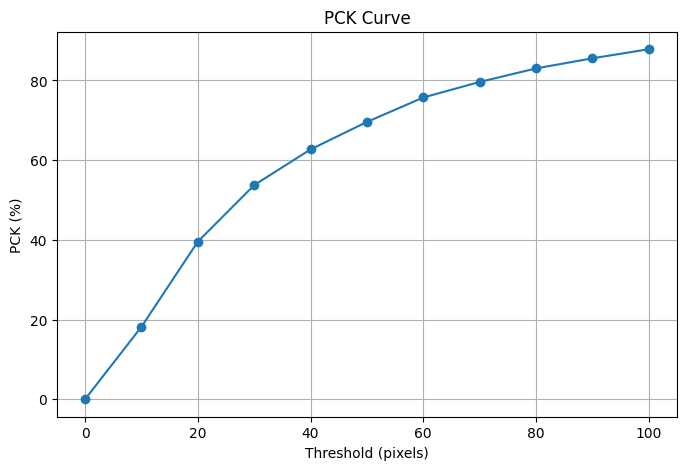

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# ✅ Leer CSV
csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_compressed_untuned.csv"
df = pd.read_csv(csv_path)

# ✅ Filtrar keypoints no anotados (gt_x o gt_y igual a 0)
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ a) Error Euclidiano Promedio, Mediana, Desviación Estándar
mean_error = df_filtered['euclidean_error'].mean()
median_error = df_filtered['euclidean_error'].median()
std_error = df_filtered['euclidean_error'].std()

print(f"\n📏 Mean Euclidean Error: {mean_error:.2f}")
print(f"📏 Median Euclidean Error: {median_error:.2f}")
print(f"📏 Std Dev of Error: {std_error:.2f}")

# ✅ b) PCK a diferentes umbrales
thresholds = np.arange(0, 101, 10)  # De 0 a 100 píxeles en pasos de 5
pck_values = []

print("\n🎯 PCK Metrics:")
for t in thresholds:
    pck = (df_filtered['euclidean_error'] <= t).mean() * 100
    pck_values.append(pck)
    print(f"PCK@{t}px: {pck:.2f}%")

# ✅ c) AUC del PCK
auc_pck = metrics.auc(thresholds, pck_values) / thresholds[-1]  # Normalizado de 0 a 1
print(f"\n📈 AUC of PCK curve: {auc_pck:.4f}")

# ✅ Graficar curva PCK
plt.figure(figsize=(8, 5))
plt.plot(thresholds, pck_values, marker='o')
plt.xlabel('Threshold (pixels)')
plt.ylabel('PCK (%)')
plt.title('PCK Curve')
plt.grid(True)
plt.show()



📊 Per-Keypoint Metrics:
    Keypoint  Mean Error (px)  Median Error (px)  Std Dev (px)    AUC PCK
0          0        77.777570          21.329455    358.689911  68.760331
1          1        97.839703          30.882661    409.413562  61.487603
2          2        64.656338          24.644822    174.485082  65.785124
3          3        79.939542          28.738162    165.282321  57.314050
4          4        49.936296          20.423668    144.836967  69.462810
5          5        54.550221          20.292018    127.202751  66.033058
6          6        61.976235          24.607903    208.692024  64.504132
7          7        68.968725          29.314528    239.927000  61.776860
8          8        58.110015          22.123870    173.198730  66.458333
9          9        64.039658          20.627595    255.792475  68.083333
10        10        57.148504          23.403618    146.200183  65.991736
11        11        61.710912          25.423396    141.996001  65.702479
12        12 

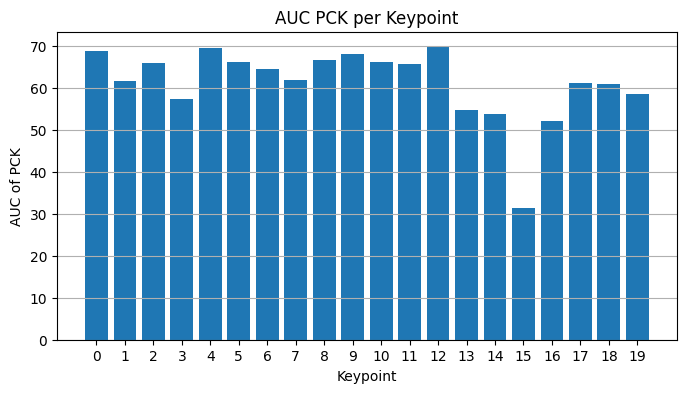

<Figure size 1000x500 with 0 Axes>

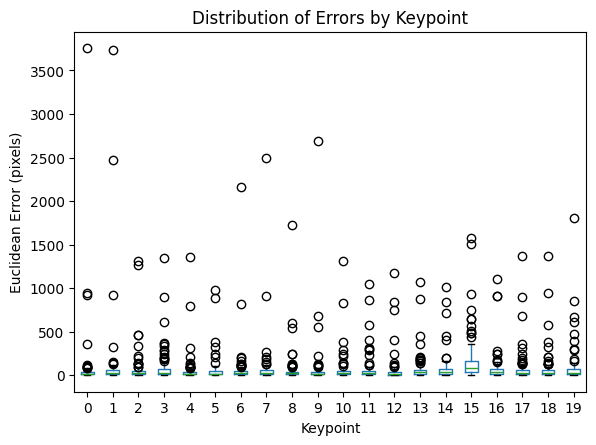

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# ✅ Load CSV
csv_path = '/data/Datasets/Fish/CavFish/'
df = pd.read_csv(csv_path)

# ✅ Filter unannotated keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Thresholds for PCK
thresholds = np.arange(0, 101, 10)

# ✅ Store per-keypoint metrics
keypoint_metrics = []

# ✅ Iterate over keypoints
for kp in sorted(df_filtered['keypoint'].unique()):
    kp_data = df_filtered[df_filtered['keypoint'] == kp]

    # Euclidean error metrics
    mean_error = kp_data['euclidean_error'].mean()
    median_error = kp_data['euclidean_error'].median()
    std_error = kp_data['euclidean_error'].std()

    # PCK metrics
    pck_values = [(kp_data['euclidean_error'] <= t).mean() * 100 for t in thresholds]
    auc_pck = metrics.auc(thresholds, pck_values) / thresholds[-1]

    # Save metrics
    keypoint_metrics.append({
        'Keypoint': kp,
        'Mean Error (px)': mean_error,
        'Median Error (px)': median_error,
        'Std Dev (px)': std_error,
        'AUC PCK': auc_pck
    })

# ✅ Create DataFrame
df_keypoint_metrics = pd.DataFrame(keypoint_metrics)

# ✅ Show table
print("\n📊 Per-Keypoint Metrics:")
print(df_keypoint_metrics)

# ✅ Save results
output_csv = '/data/Datasets/Fish/CavFish/keypoint_metrics_summary.csv'
df_keypoint_metrics.to_csv(output_csv, index=False)
print(f"\n✅ Metrics saved to: {output_csv}")

# ✅ Optional: LaTeX table (for papers)
latex_table = df_keypoint_metrics.to_latex(index=False, float_format="%.2f")
print("\n📄 LaTeX Table:\n")
print(latex_table)

# =====================
# ✅ Visualizations
# =====================

# ✅ AUC PCK bar plot
plt.figure(figsize=(8, 4))
plt.bar(df_keypoint_metrics['Keypoint'], df_keypoint_metrics['AUC PCK'])
plt.xlabel('Keypoint')
plt.ylabel('AUC of PCK')
plt.title('AUC PCK per Keypoint')
plt.xticks(df_keypoint_metrics['Keypoint'])
plt.grid(axis='y')
plt.show()

# ✅ Boxplot of Euclidean Errors
plt.figure(figsize=(10, 5))
df_filtered.boxplot(column='euclidean_error', by='keypoint', grid=False)
plt.xlabel('Keypoint')
plt.ylabel('Euclidean Error (pixels)')
plt.title('Distribution of Errors by Keypoint')
plt.suptitle('')
plt.show()

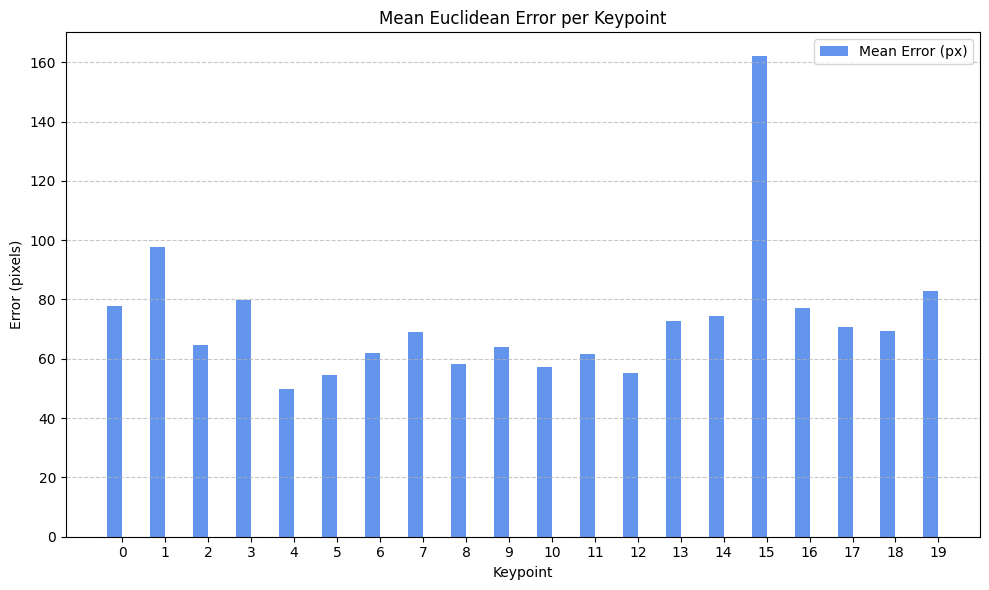

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# ✅ Load your CSV
csv_path = '/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_compressed_untuned.csv'
df = pd.read_csv(csv_path)

# ✅ Filter invalid keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Thresholds for PCK
thresholds = np.arange(0, 101, 10)

# ✅ Collect metrics
keypoint_metrics = []
for kp in sorted(df_filtered['keypoint'].unique()):
    kp_data = df_filtered[df_filtered['keypoint'] == kp]

    mean_error = kp_data['euclidean_error'].mean()
    median_error = kp_data['euclidean_error'].median()
    std_error = kp_data['euclidean_error'].std()

    pck_values = [(kp_data['euclidean_error'] <= t).mean() * 100 for t in thresholds]
    auc_pck = metrics.auc(thresholds, pck_values) / thresholds[-1]

    keypoint_metrics.append({
        'Keypoint': kp,
        'Mean Error (px)': mean_error,
        'Median Error (px)': median_error,
        'Std Dev (px)': std_error,
        'AUC PCK': auc_pck
    })

# ✅ Create dataframe
df_keypoint_metrics = pd.DataFrame(keypoint_metrics)

# ✅ Save summary
df_keypoint_metrics.to_csv('/data/Datasets/Fish/CavFish/keypoint_metrics_summary.csv', index=False)

# ✅ Bar Plot 1: Mean vs Median
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df_keypoint_metrics['Keypoint']))
bar_width = 0.35

bars1 = ax.bar(x - bar_width / 2, df_keypoint_metrics['Mean Error (px)'],
               width=bar_width, label='Mean Error (px)', color='cornflowerblue')

# ✅ Create custom tick labels
tick_labels = []
for kp in df_keypoint_metrics['Keypoint']:
    if kp >= 50:
        tick_labels.append(kp + 1)  # Shift by +1 after 13
    else:
        tick_labels.append(kp)

ax.set_xlabel('Keypoint')
ax.set_ylabel('Error (pixels)')
ax.set_title('Mean Euclidean Error per Keypoint')
ax.set_xticks(x)
ax.set_xticklabels(tick_labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

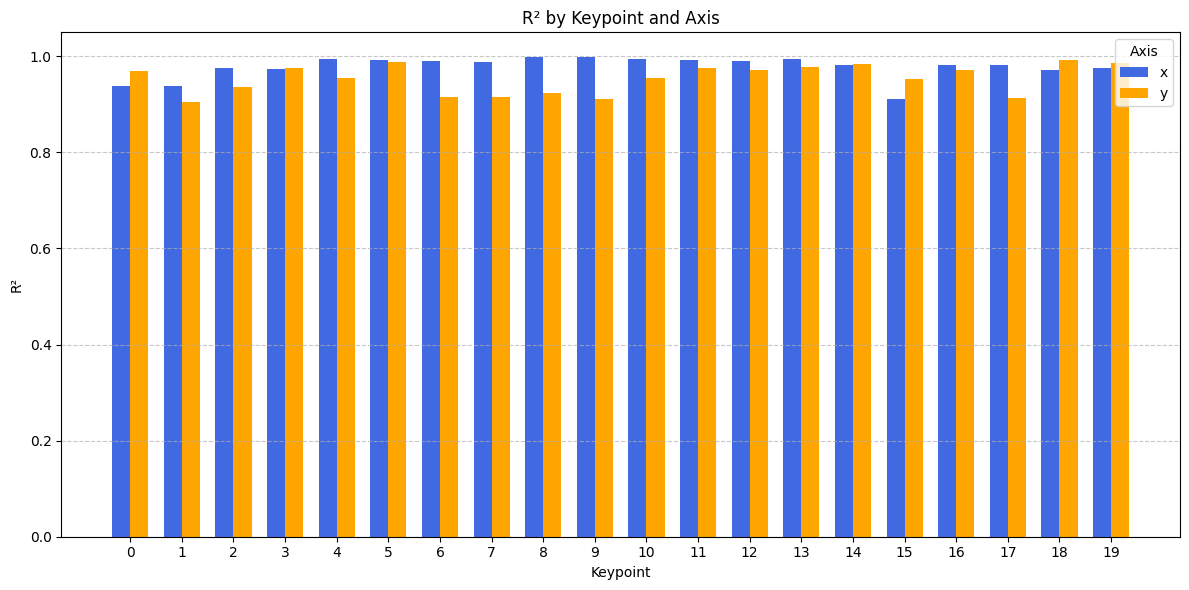

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# ✅ Load your CSV
csv_path = '/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_compressed_untuned.csv'
df = pd.read_csv(csv_path)

# ✅ Filter invalid keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Compute R² per keypoint and axis
keypoints = sorted(df_filtered['keypoint'].unique())
r2_results = []

for kp in keypoints:
    kp_data = df_filtered[df_filtered['keypoint'] == kp]

    # R² for X-axis
    r2_x = r2_score(kp_data['gt_x'], kp_data['pred_x'])
    # R² for Y-axis
    r2_y = r2_score(kp_data['gt_y'], kp_data['pred_y'])

    r2_results.append({
        'Keypoint': kp,
        'R2_X': r2_x,
        'R2_Y': r2_y
    })

# ✅ Create dataframe
df_r2 = pd.DataFrame(r2_results)

# ✅ Plot R² per axis
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(df_r2['Keypoint']))

bar_width = 0.35
ax.bar(x - bar_width/2, df_r2['R2_X'], width=bar_width, label='x', color='royalblue')
ax.bar(x + bar_width/2, df_r2['R2_Y'], width=bar_width, label='y', color='orange')

# ✅ Axis Labels
ax.set_xlabel('Keypoint')
ax.set_ylabel('R²')
ax.set_title('R² by Keypoint and Axis')
ax.set_xticks(x)
ax.set_xticklabels(df_r2['Keypoint'])
ax.set_ylim(0, 1.05)
ax.legend(title='Axis')
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


Global R² X: 0.9878
Global R² Y: 0.9668


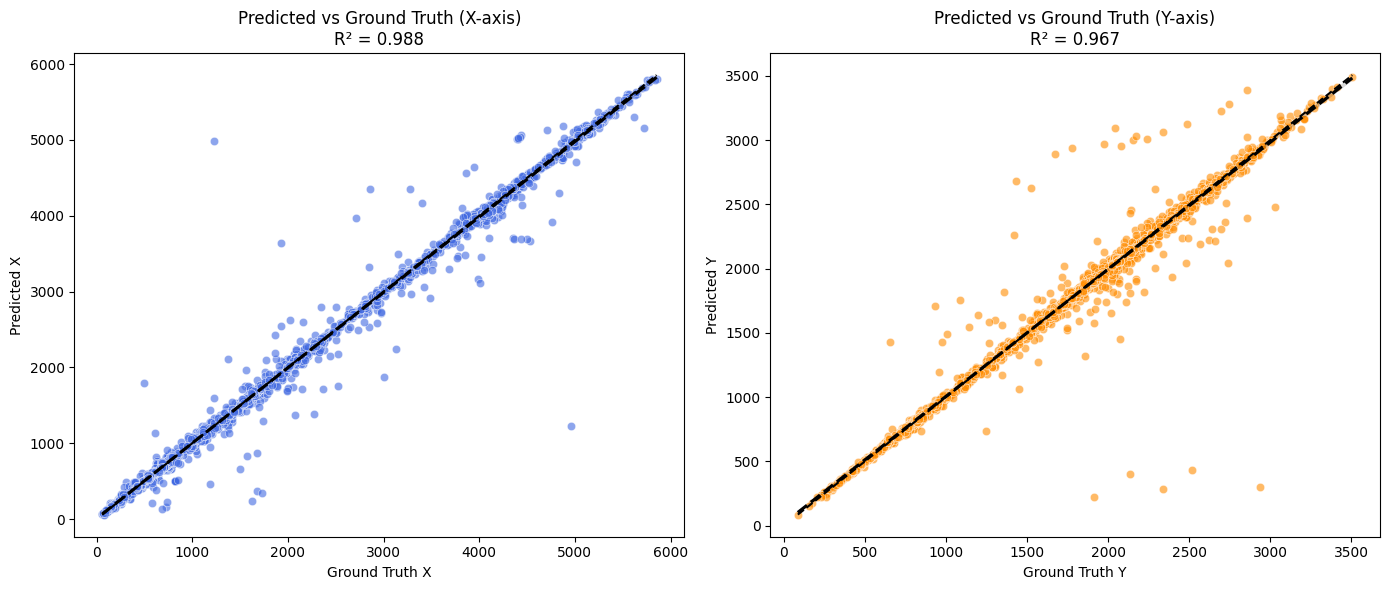

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import seaborn as sns

# ✅ Load your CSV
csv_path = '/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_compressed_untuned.csv'
df = pd.read_csv(csv_path)

# ✅ Filter invalid keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Calculate Global R²
r2_x = r2_score(df_filtered['gt_x'], df_filtered['pred_x'])
r2_y = r2_score(df_filtered['gt_y'], df_filtered['pred_y'])

print(f"Global R² X: {r2_x:.4f}")
print(f"Global R² Y: {r2_y:.4f}")

# ✅ Scatter plots with regression
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for X
sns.scatterplot(data=df_filtered, x='gt_x', y='pred_x', ax=axes[0], color='royalblue', alpha=0.6)
sns.regplot(data=df_filtered, x='gt_x', y='pred_x', ax=axes[0], scatter=False, color='black', line_kws={'linestyle': '--'})
axes[0].plot([df_filtered['gt_x'].min(), df_filtered['gt_x'].max()],
             [df_filtered['gt_x'].min(), df_filtered['gt_x'].max()],
             linestyle='--', color='black')
axes[0].set_title(f'Predicted vs Ground Truth (X-axis)\nR² = {r2_x:.3f}')
axes[0].set_xlabel('Ground Truth X')
axes[0].set_ylabel('Predicted X')

# Plot for Y
sns.scatterplot(data=df_filtered, x='gt_y', y='pred_y', ax=axes[1], color='darkorange', alpha=0.6)
sns.regplot(data=df_filtered, x='gt_y', y='pred_y', ax=axes[1], scatter=False, color='black', line_kws={'linestyle': '--'})
axes[1].plot([df_filtered['gt_y'].min(), df_filtered['gt_y'].max()],
             [df_filtered['gt_y'].min(), df_filtered['gt_y'].max()],
             linestyle='--', color='black')
axes[1].set_title(f'Predicted vs Ground Truth (Y-axis)\nR² = {r2_y:.3f}')
axes[1].set_xlabel('Ground Truth Y')
axes[1].set_ylabel('Predicted Y')

plt.tight_layout()
plt.show()


In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error

# ✅ Load your CSV
csv_path = '/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_compressed_untuned.csv'
df = pd.read_csv(csv_path)

# ✅ Filter invalid keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Flatten X and Y into a single vector
gt_all = np.concatenate([df_filtered['gt_x'].values, df_filtered['gt_y'].values])
pred_all = np.concatenate([df_filtered['pred_x'].values, df_filtered['pred_y'].values])

# ✅ Compute global metrics
r2 = r2_score(gt_all, pred_all)
rmse = np.sqrt(mean_squared_error(gt_all, pred_all))
mae = mean_absolute_error(gt_all, pred_all)
maxerr = max_error(gt_all, pred_all)

# ✅ Print results
print(f"{'R2':<10} {'RMSE':<10} {'MAE':<10} {'MaxError':<10}")
print(f"{r2:<10.6f} {rmse:<10.4f} {mae:<10.4f} {maxerr:<10.4f}")


R2         RMSE       MAE        MaxError  
0.984296   156.4563   45.9144    3756.6519 


# PMP Metric

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path

# --------------------------- Phenotype map (1-based) -----------------------------
phenotype_pairs_1based = {
    "SL":  (1, 2),     # Standard length (Snout ↔ Caudal fin base) if kp2 is base
    "PeDD": (4, 3),    # Pelvic–Dors    al fin origin distance
    "HD":  (5, 6),     # Head depth
    "CPD": (7, 8),     # Caudal peduncle depth
    "CFD": (9, 10),    # Caudal fin depth
    "ED":  (11, 12),   # Eye diameter
    "EyePelv": (13, 4),# Eye centroid ↔ Pelvic origin (custom)
    "SnPelv": (1, 4),  # Snout ↔ Pelvic origin (custom)
    "MaxJaw": (1, 14), # Maxillary jaw length (Snout ↔ Mouth corner)
    "PcL": (15, 16),   # Pectoral fin length
    "PcPeD": (15, 4),  # Pectoral–Pelvic fin origin distance
    "HL":  (1, 17),    # Head length (Snout ↔ Operculum posterior margin)
    "DFL": (3, 18),    # Dorsal fin length (dorsal anterior ↔ dorsal posterior)
    "AFL": (19, 20),   # Anal fin length (anal anterior ↔ anal posterior)
}

def _normalize_single(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize single combined CSV to ['image_id','keypoint_id','x_gt','y_gt','x_pred','y_pred'].
    Expects at least: ['keypoint','gt_x','gt_y','pred_x','pred_y'].
    If 'image_id' is missing but 'image' exists, build image_id by factorizing 'image'.
    Ensures one row per (image_id, keypoint_id) by keeping the last occurrence.
    """
    required = ["keypoint", "gt_x", "gt_y", "pred_x", "pred_y"]
    for c in required:
        if c not in df.columns:
            raise ValueError(f"Missing required column '{c}' in the CSV.")

    out = df.copy()

    # Build image_id robustly
    if "image_id" in out.columns:
        # trust existing image_id
        pass
    elif "image" in out.columns:
        # factorize image path/filename into stable ids
        out["image_id"] = pd.factorize(out["image"].astype(str).str.strip())[0]
    else:
        # last resort: every row is treated as same image (not recommended)
        raise ValueError("CSV missing 'image_id' and 'image' columns; cannot group by image.")

    # enforce numeric types
    out["keypoint"] = pd.to_numeric(out["keypoint"], errors="raise")
    for c in ["gt_x","gt_y","pred_x","pred_y"]:
        out[c] = pd.to_numeric(out[c], errors="raise")

    # rename to common schema
    out = out.rename(columns={"keypoint":"keypoint_id",
                              "gt_x":"x_gt","gt_y":"y_gt",
                              "pred_x":"x_pred","pred_y":"y_pred"})

    # keep ONE row per (image_id, keypoint_id). If duplicates exist, keep the last.
    out = (
        out.sort_index()
           .reset_index(drop=True)
    )

    return out[["image_id","keypoint_id","x_gt","y_gt","x_pred","y_pred"]]

def _compute_pheno_lengths_gt(gt_img_df: pd.DataFrame, pheno_pairs: dict) -> dict:
    """
    Compute phenotype lengths using GT coords for one image.
    gt_img_df columns: ['keypoint_id','x_gt','y_gt'] for a single image_id.
    Returns dict: pheno_name -> length (float)
    """
    idx = gt_img_df.set_index("keypoint_id")
    out = {}
    for name, (a, b) in pheno_pairs.items():
        if a in idx.index and b in idx.index:
            pa = idx.loc[a, ["x_gt","y_gt"]].values.astype(float)
            pb = idx.loc[b, ["x_gt","y_gt"]].values.astype(float)
            out[name] = float(np.linalg.norm(pa - pb))
    return out

def compute_pmp_single_df(df: pd.DataFrame,
                          phenotype_pairs: dict,
                          r: float = 0.1):
    """
    Compute PMP from a single combined dataframe.
    Returns (pmp_df, overall_mean, dj_table).

    Enhancements:
    - Tracks, for every (image_id, keypoint_id), the phenotype actually used
      for normalization (the shortest one involving that keypoint).
    - Aggregates per keypoint:
        * assoc_phenotype: most frequent phenotype chosen for that keypoint
        * mean_norm_len_px: mean of the chosen phenotype lengths used
        * threshold_10pct_px: r * mean_norm_len_px
    """
    M = _normalize_single(df)

    dj_rows = []
    # for per-kp aggregation of the phenotype actually used
    kp_normlens = {}   # keypoint_id -> list of norm_len values used
    kp_phnames  = {}   # keypoint_id -> list of phenotype names chosen

    for img_id, Mi in M.groupby("image_id", sort=False):
        # phenotype lengths (GT) for this image
        ph_len = _compute_pheno_lengths_gt(Mi[["keypoint_id","x_gt","y_gt"]], phenotype_pairs)

        # distances (pixel error per kp)
        pixel_err = np.sqrt(((Mi[["x_gt","y_gt"]].to_numpy(float) -
                              Mi[["x_pred","y_pred"]].to_numpy(float)) ** 2).sum(axis=1))

        # choose shortest phenotype involving each keypoint
        norm_len_list = []
        norm_phname_list = []
        for kp in Mi["keypoint_id"].astype(int).tolist():
            # collect candidates for this kp
            candidates = []
            for name, (a, b) in phenotype_pairs.items():
                if kp in (a, b) and name in ph_len and ph_len[name] > 0:
                    candidates.append((name, ph_len[name]))

            if candidates:
                # shortest phenotype for this kp on this image
                phname, plen = min(candidates, key=lambda t: t[1])
                norm_len_list.append(plen)
                norm_phname_list.append(phname)

                # record for per-kp aggregation
                kp_normlens.setdefault(kp, []).append(plen)
                kp_phnames.setdefault(kp, []).append(phname)
            else:
                norm_len_list.append(np.nan)
                norm_phname_list.append(None)

        tmp = Mi[["image_id","keypoint_id"]].copy()
        tmp["pixel_err"]   = pixel_err
        tmp["norm_len"]    = norm_len_list
        tmp["norm_pheno"]  = norm_phname_list
        tmp = tmp.dropna(subset=["norm_len"]).copy()

        tmp["d_jn"]    = tmp["pixel_err"] / tmp["norm_len"]
        tmp["correct"] = (tmp["d_jn"] < r).astype(int)

        dj_rows.append(tmp)

    if not dj_rows:
        raise ValueError("No evaluable rows. Make sure each keypoint appears in ≥1 phenotype pair.")

    # Debug-level table (per (image,kp))
    D = pd.concat(dj_rows, ignore_index=True)

    # Per-kp PMP
    pmp = D.groupby("keypoint_id")["correct"].mean().reset_index()
    pmp["pmp"] = pmp["correct"] * 100.0
    pmp = pmp.drop(columns=["correct"]).sort_values("keypoint_id").reset_index(drop=True)

    # Per-kp phenotype association stats
    assoc_rows = []
    for kp in sorted(set(D["keypoint_id"].astype(int))):
        ph_list = kp_phnames.get(kp, [])
        ln_list = kp_normlens.get(kp, [])
        if not ph_list or not ln_list:
            continue

        # most frequent phenotype chosen for this kp
        counts = pd.Series(ph_list).value_counts()
        assoc_ph = counts.index[0]

        mean_norm = float(np.mean(ln_list))
        assoc_rows.append({
            "keypoint_id": kp,
            "assoc_phenotype": assoc_ph,
            "mean_norm_len_px": mean_norm,
            "threshold_10pct_px": mean_norm * r
        })

    assoc_df = pd.DataFrame(assoc_rows)

    # Merge into pmp report
    if not assoc_df.empty:
        pmp = pmp.merge(assoc_df, on="keypoint_id", how="left")

    overall = float(pmp["pmp"].mean()) if len(pmp) else float("nan")
    return pmp, overall, D


def run_pmp_single(csv_path: str,
                   model,
                   phenotype_pairs: dict = None,
                   r: float = 0.1,
                   out_dir: str = "/mnt/data"):
    """
    Load a single CSV (combined GT+Pred), compute PMP, and save reports.

    Adds:
    - assoc phenotype + mean_norm_len_px + threshold_10pct_px to the pmp report
    - keeps debug sample (first 100 rows)
    - writes overall mean PMP to a txt
    """
    if phenotype_pairs is None:
        phenotype_pairs = phenotype_pairs_1based

    # keep your existing fixed directory (as in your current code)
    out_dir = Path("/data/Datasets/Fish/CavFish/Predictions/PMP")
    out_dir.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv(csv_path)
    pmp_df, overall, dj_table = compute_pmp_single_df(df, phenotype_pairs, r=r)

    # Save files
    pmp_path = out_dir / f"{model}_pmp_report.csv"
    overall_path = out_dir / f"{model}_pmp_overall.txt"
    debug_path = out_dir / f"{model}_pmp_debug_sample.csv"

    pmp_df.to_csv(pmp_path, index=False)
    dj_table.head(100).to_csv(debug_path, index=False)
    with open(overall_path, "w") as f:
        f.write(f"{overall:.4f}\n")

    return {
        "pmp_report": str(pmp_path),
        "overall_file": str(overall_path),
        "debug_sample": str(debug_path),
        "overall_mean_pct": overall,
    }

In [15]:
results = run_pmp_single("/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_depressed_minphenoloss.csv", "depressed_minphenoloss", r=0.1)
results

# results = run_pmp_single("/data/Datasets/Fish/CavFish/Predictions/predictions_compressed_untuned.csv", "compressed", r=0.1)
# results

{'pmp_report': '/data/Datasets/Fish/CavFish/Predictions/PMP/depressed_minphenoloss_pmp_report.csv',
 'overall_file': '/data/Datasets/Fish/CavFish/Predictions/PMP/depressed_minphenoloss_pmp_overall.txt',
 'debug_sample': '/data/Datasets/Fish/CavFish/Predictions/PMP/depressed_minphenoloss_pmp_debug_sample.csv',
 'overall_mean_pct': 62.38895110115716}

In [21]:
import pandas as pd
from collections import Counter

df = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_compressed_augmented.csv")

# 1) Canonicalize the image string to avoid false multis
canon = (
    df["image"].astype(str).str.strip()
      .str.replace("\\", "/", regex=False)
      .str.replace(r"^\./", "", regex=True)
)
df["image_canon"] = canon

# 2) If your keypoints are 0-based, shift to 1-based to match the phenotype map
if df["keypoint"].min() == 0:
    df["keypoint_1b"] = df["keypoint"] + 1
else:
    df["keypoint_1b"] = df["keypoint"]

# 3) Check duplicates of (image, keypoint)
dups = df.duplicated(subset=["image_canon", "keypoint_1b"])
print("Exact duplicate (image,keypoint) rows:", int(dups.sum()))

# 4) Check that each image has exactly 20 unique keypoints
per_img_unique = df.groupby("image_canon")["keypoint_1b"].nunique()
print(per_img_unique.describe())
bad = per_img_unique[per_img_unique != 20]
print("Images with != 20 unique keypoints:", len(bad))


Exact duplicate (image,keypoint) rows: 0
count    121.0
mean      20.0
std        0.0
min       20.0
25%       20.0
50%       20.0
75%       20.0
max       20.0
Name: keypoint_1b, dtype: float64
Images with != 20 unique keypoints: 0



## **LossPheno**

### Extract from the all samples csv

In [1]:
import os
import json
import pandas as pd

# ---- paths you set ----
json_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_COMPRESSED_LOSSPHENO_untuned.csv"
out_csv   = '/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_compressed_COMPRESSED_LOSSPHENO_augmentedresolution.csv'
target_labels = {'Compressed body'}


# ---- helpers ----
def canonize_path(p: str) -> str:
    # normalize case & slashes; strip whitespace
    p = (p or "").strip().replace("\\", "/")
    # remove leading "./"
    if p.startswith("./"):
        p = p[2:]
    return p

# ---- 1) gather names from JSON for target classes ----
with open(json_path, "r") as f:
    val = json.load(f)

json_relpaths = {
    canonize_path(img["file_name"])
    for img in val.get("images", [])
    if img.get("label") in target_labels
}

# also keep a basename set in case your CSV stores only filenames
json_basenames = {os.path.basename(p) for p in json_relpaths}

print(f"Found {len(json_relpaths)} images labeled {target_labels} in JSON.")

# ---- 2) load CSV and filter by name match ----
df = pd.read_csv(csv_path)

if "image" not in df.columns:
    raise ValueError("CSV must have a column named 'image'.")

# Build two keys to be flexible: relative-path key and basename key
csv_rel = df["image"].astype(str).map(canonize_path)
csv_base = csv_rel.map(os.path.basename)

mask = csv_rel.isin(json_relpaths) | csv_base.isin(json_basenames)
df_filtered = df[mask].copy()

print(f"Rows before: {len(df)} | after filter: {len(df_filtered)}")

# ---- 3) save ----
df_filtered.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")


Found 121 images labeled {'Compressed body'} in JSON.
Rows before: 2420 | after filter: 2420
Saved: /data/Datasets/Fish/CavFish/Predictions/augmented/predictions_compressed_COMPRESSED_LOSSPHENO_augmentedresolution.csv


## Inference

In [2]:
import sys
# Asegura NumPy 1.x (más compatible con el stack clásico de MMPose/MMCV)
!{sys.executable} -m pip install -U "numpy<2,>=1.26.0"
# Instala las dependencias COCO
!{sys.executable} -m pip install -U xtcocotools pycocotools

# Verifica
import numpy as np, xtcocotools, pycocotools
print("NumPy:", np.__version__)
print("xtcocotools OK:", xtcocotools.__file__)
print("pycocotools OK:", pycocotools.__file__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.0/436.0 kB 4.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.0/455.0 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.2 MB/s eta 0:00:0000:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openxlab 0.1.2 requires setuptools~=60.2.0, but you have setuptools 80.9.0 which is incompatible.
NumPy: 1.26.4
xtcocotools OK: /opt/conda/lib/python3.10/site-packages/xtcocotools/__init__.py
pycocotools OK: /opt/conda/lib/python3.10/site-packages/pycocotools/__init__.py


In [3]:
# Se extrae la ruta de la imagen. Final
import os
import json
import subprocess

# Configuración de rutas
json_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
dataset_root = '/data/Datasets/Fish/CavFish'
output_folder = '/data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno'
config_path = 'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_ViTPose-fish9_8xb32-100etrain_loss.py'
checkpoint_path = '/data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth'
merged_json_path = os.path.join(output_folder, 'all_keypoints_predicted_compressed_ViTPose_untuned_Losspheno.json')

# Clase(s) objetivo a filtrar
target_labels = ['Compressed body']

# Crear carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Leer el archivo JSON de validación
with open(json_path, 'r') as f:
    val_data = json.load(f)

# Almacenar todas las predicciones
all_predictions = []

# Recorrer cada imagen del archivo de validación
for image_info in val_data['images']:
    # Filtrar por clase (label)
    if image_info.get('label') not in target_labels:
        continue

    relative_path = image_info['file_name']  # ej: "2018 Guayavero Duda/IMG_0084-Edit.jpg"
    full_path = os.path.join(dataset_root, relative_path)

    # Nombre de imagen para guardar outputs
    img_name = os.path.basename(relative_path)
    out_base = os.path.join(output_folder, img_name)
    out_json = out_base.replace('.jpg', '_keypoints.json').replace('.png', '_keypoints.json')

    # Verificación de existencia de imagen
    if not os.path.exists(full_path):
        print(f"⚠️ Imagen no encontrada: {full_path}")
        continue

    # Ejecutar la inferencia
    cmd = [
        "python", "demo/image_demo.py",
        full_path,
        config_path,
        checkpoint_path,
        "--out-file", out_base,
        "--draw-heatmap",
        "--show-kpt-idx"
    ]

    print(f"🔁 Procesando {relative_path}...")
    subprocess.run(cmd)

    # Leer predicción y asociarla a la ruta relativa original (no solo nombre)
    if os.path.exists(out_json):
        with open(out_json, 'r') as f:
            pred = json.load(f)

        # Normalizar output para que coincida con GT
        pred["image"] = relative_path  # Sobrescribe con la ruta relativa del GT
        all_predictions.append(pred)
    else:
        print(f"⚠️ No se encontró JSON de salida para {img_name}")

# Guardar todas las predicciones en un solo archivo
with open(merged_json_path, 'w') as f:
    json.dump(all_predictions, f, indent=4)

print(f"\n✅ JSON consolidado guardado en: {merged_json_path}")

🔁 Procesando 2018 Guayavero Duda/IMG_0084-Edit.jpg...


/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=297.3, y=1787.6, score=0.866

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_0084-Edit_keypoints.json
 - 1: x=4195.2, y=1966.5, score=0.682

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_0084-Edit_keypoints.json
 - 2: x=1622.3, y=1440.8, score=0.763

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=219.3, y=1758.0, score=0.829

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_0718-Edit_keypoints.json
 - 1: x=5118.0, y=2301.2, score=0.849

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_0718-Edit_keypoints.json
 - 2: x=2091.9, y=1674.0, score=0.548

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=171.8, y=1899.5, score=0.854

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_0820-Edit_keypoints.json
 - 1: x=5195.6, y=2075.4, score=0.795

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_0820-Edit_keypoints.json
 - 2: x=1872.2, y=1477.6, score=0.653

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=244.3, y=1635.8, score=0.803

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1450-Edit_keypoints.json
 - 1: x=4126.9, y=1844.6, score=0.663

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1450-Edit_keypoints.json
 - 2: x=2741.4, y=1325.8, score=0.767

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=5743.5, y=1691.1, score=0.808

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1628-Edit_keypoints.json
 - 1: x=1298.3, y=1940.8, score=0.753

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1628-Edit_keypoints.json
 - 2: x=2944.4, y=1263.5, score=0.720

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infe

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=174.3, y=2225.5, score=0.869

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1653-Edit_keypoints.json
 - 1: x=4894.7, y=2148.6, score=0.761

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1653-Edit_keypoints.json
 - 2: x=2300.2, y=1439.7, score=0.872

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=214.3, y=1723.2, score=0.786

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9063-Edit_keypoints.json
 - 1: x=4109.6, y=1768.4, score=0.709

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9063-Edit_keypoints.json
 - 2: x=1620.0, y=1302.2, score=0.774

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=118.3, y=1885.1, score=0.772

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9295-Edit_keypoints.json
 - 1: x=4225.4, y=1835.3, score=0.721

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9295-Edit_keypoints.json
 - 2: x=2252.2, y=1267.0, score=0.915

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=192.9, y=1916.9, score=0.834

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9310-Edit_keypoints.json
 - 1: x=4224.0, y=1781.8, score=0.780

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9310-Edit_keypoints.json
 - 2: x=2180.0, y=1133.1, score=0.807

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=150.8, y=1858.4, score=0.778

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9774-Edit_keypoints.json
 - 1: x=4147.9, y=1886.5, score=0.707

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9774-Edit_keypoints.json
 - 2: x=2188.1, y=1201.8, score=0.834

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=246.8, y=2069.2, score=0.882

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9792-Edit_keypoints.json
 - 1: x=4064.2, y=2143.6, score=0.624

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9792-Edit_keypoints.json
 - 2: x=1514.1, y=1178.8, score=0.859

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=235.0, y=1906.3, score=0.788

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1432-Edit_keypoints.json
 - 1: x=4080.3, y=1874.0, score=0.752

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1432-Edit_keypoints.json
 - 2: x=2272.5, y=1460.7, score=0.882

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=139.2, y=1811.7, score=0.716

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1468-Edit_keypoints.json
 - 1: x=4163.1, y=1752.6, score=0.706

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1468-Edit_keypoints.json
 - 2: x=2185.1, y=1446.5, score=0.892

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=165.8, y=1796.2, score=0.748

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1754-Edit_keypoints.json
 - 1: x=4266.8, y=1863.2, score=0.784

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1754-Edit_keypoints.json
 - 2: x=2188.0, y=1217.0, score=0.864

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=224.4, y=1852.3, score=0.809

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1807-Edit_keypoints.json
 - 1: x=4201.0, y=2224.5, score=0.703

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1807-Edit_keypoints.json
 - 2: x=2545.6, y=1567.7, score=0.736

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=211.7, y=2031.8, score=0.814

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2360-Edit_keypoints.json
 - 1: x=4181.5, y=1929.9, score=0.740

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2360-Edit_keypoints.json
 - 2: x=2190.0, y=1546.1, score=0.824

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=109.9, y=1997.2, score=0.684

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2395-Edit_keypoints.json
 - 1: x=4381.7, y=1867.5, score=0.811

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2395-Edit_keypoints.json
 - 2: x=2319.2, y=1357.6, score=0.628

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=191.4, y=2278.6, score=0.893

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2412-Edit_keypoints.json
 - 1: x=4323.7, y=1983.3, score=0.721

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2412-Edit_keypoints.json
 - 2: x=1638.8, y=1115.0, score=0.750

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=462.8, y=1650.3, score=1.000

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2641-Edit_keypoints.json
 - 1: x=3938.7, y=1882.2, score=0.501

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2641-Edit_keypoints.json
 - 2: x=2471.6, y=526.2, score=0.807

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infere

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=202.0, y=1841.6, score=0.856

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_3388-Edit_keypoints.json
 - 1: x=4503.7, y=1932.0, score=0.709

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_3388-Edit_keypoints.json
 - 2: x=3382.8, y=1609.8, score=0.657

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=172.4, y=1789.2, score=0.798

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_4142-Edit_keypoints.json
 - 1: x=4100.1, y=1796.4, score=0.728

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_4142-Edit_keypoints.json
 - 2: x=2227.9, y=1253.1, score=0.879

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=254.1, y=1901.7, score=0.923

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_4235-Edit_keypoints.json
 - 1: x=4296.5, y=1936.5, score=0.763

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_4235-Edit_keypoints.json
 - 2: x=2161.2, y=1367.0, score=0.785

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=303.4, y=1760.7, score=0.908

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_4254-Edit_keypoints.json
 - 1: x=3933.5, y=1777.7, score=0.766

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_4254-Edit_keypoints.json
 - 2: x=2175.5, y=849.2, score=0.936

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infere

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=193.3, y=1748.7, score=0.697

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_4333-Edit_keypoints.json
 - 1: x=4348.5, y=2076.0, score=0.719

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_4333-Edit_keypoints.json
 - 2: x=1401.7, y=1498.3, score=0.708

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=173.1, y=2024.0, score=0.805

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9587_keypoints.json
 - 1: x=4232.2, y=1907.0, score=0.723

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9587_keypoints.json
 - 2: x=1978.9, y=1164.3, score=0.828

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compr

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=188.8, y=1832.7, score=0.758

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9869_keypoints.json
 - 1: x=4201.7, y=1754.5, score=0.705

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9869_keypoints.json
 - 2: x=2151.4, y=1232.2, score=0.834

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compr

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=249.5, y=1387.8, score=0.790

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1354-Edit_keypoints.json
 - 1: x=4410.5, y=2006.9, score=0.748

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1354-Edit_keypoints.json
 - 2: x=2144.3, y=1419.7, score=0.278

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=202.2, y=1049.8, score=0.649

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1456-Edit_keypoints.json
 - 1: x=4075.0, y=1601.4, score=0.651

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1456-Edit_keypoints.json
 - 2: x=2179.3, y=889.3, score=0.293

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infere

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=275.5, y=1877.5, score=0.859

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1592-Edit_keypoints.json
 - 1: x=4379.2, y=1975.9, score=0.539

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1592-Edit_keypoints.json
 - 2: x=1664.9, y=1545.6, score=0.824

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=454.8, y=1691.5, score=0.891

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1606-Editar_keypoints.json
 - 1: x=4087.4, y=1971.3, score=0.699

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1606-Editar_keypoints.json
 - 2: x=2350.2, y=960.6, score=0.635

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/in

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=146.1, y=1913.9, score=0.830

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1661-Editar_keypoints.json
 - 1: x=3996.0, y=1873.5, score=0.675

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1661-Editar_keypoints.json
 - 2: x=1443.7, y=1021.6, score=0.697

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/i

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=148.3, y=1815.0, score=0.749

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1751-Edit_keypoints.json
 - 1: x=4080.5, y=1845.1, score=0.704

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1751-Edit_keypoints.json
 - 2: x=2195.7, y=1348.6, score=0.869

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=266.9, y=1678.7, score=0.859

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1769-Edit_keypoints.json
 - 1: x=4059.8, y=1619.9, score=0.532

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1769-Edit_keypoints.json
 - 2: x=1782.6, y=773.7, score=0.636

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infere

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=275.0, y=1890.8, score=0.833

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2434-Edit_keypoints.json
 - 1: x=4129.1, y=1931.2, score=0.745

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2434-Edit_keypoints.json
 - 2: x=2187.0, y=1237.7, score=0.736

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=216.5, y=808.0, score=0.672

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_8905_keypoints.json
 - 1: x=3563.8, y=1719.1, score=0.738

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_8905_keypoints.json
 - 2: x=2089.6, y=975.1, score=0.820

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compres

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=473.7, y=2180.6, score=0.952

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_8915_keypoints.json
 - 1: x=4055.9, y=1132.2, score=0.711

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_8915_keypoints.json
 - 2: x=1715.6, y=1301.6, score=0.818

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compr

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=719.7, y=569.1, score=0.612

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_8946_keypoints.json
 - 1: x=4358.4, y=1759.1, score=0.840

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_8946_keypoints.json
 - 2: x=2855.1, y=750.6, score=0.752

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compres

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=301.3, y=695.6, score=0.730

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC03887_17042023193037_keypoints.json
 - 1: x=1435.5, y=689.3, score=0.803

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC03887_17042023193037_keypoints.json
 - 2: x=828.4, y=477.8, score=0.806

📝 Coordenadas guardadas en JSON: /data/Datasets/Fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=190.5, y=761.0, score=0.846

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC04215_19042023191846_keypoints.json
 - 1: x=1426.2, y=642.0, score=0.790

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC04215_19042023191846_keypoints.json
 - 2: x=822.2, y=504.8, score=0.779

📝 Coordenadas guardadas en JSON: /data/Datasets/Fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=34.8, y=648.1, score=0.898

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC04797_22042023211644_keypoints.json
 - 1: x=1416.4, y=763.3, score=0.687

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC04797_22042023211644_keypoints.json
 - 2: x=583.5, y=293.8, score=0.824

📝 Coordenadas guardadas en JSON: /data/Datasets/Fis

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=98.3, y=641.3, score=0.878

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC05403_26042023164240_keypoints.json
 - 1: x=1783.2, y=752.3, score=0.718

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC05403_26042023164240_keypoints.json
 - 2: x=870.2, y=541.6, score=0.769

📝 Coordenadas guardadas en JSON: /data/Datasets/Fis

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=329.0, y=719.2, score=0.853

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC05433_26042023172328_keypoints.json
 - 1: x=1430.5, y=674.0, score=0.846

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC05433_26042023172328_keypoints.json
 - 2: x=803.7, y=524.2, score=0.741

📝 Coordenadas guardadas en JSON: /data/Datasets/Fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=162.5, y=657.3, score=0.798

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC05484_26042023184616_keypoints.json
 - 1: x=1399.4, y=667.4, score=0.809

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC05484_26042023184616_keypoints.json
 - 2: x=799.3, y=422.4, score=0.845

📝 Coordenadas guardadas en JSON: /data/Datasets/Fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=200.4, y=631.5, score=0.807

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC05765_28042023215403_keypoints.json
 - 1: x=1443.6, y=635.8, score=0.770

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC05765_28042023215403_keypoints.json
 - 2: x=833.6, y=469.5, score=0.746

📝 Coordenadas guardadas en JSON: /data/Datasets/Fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=145.2, y=571.0, score=0.901

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00084_20082022221814_keypoints.json
 - 1: x=1617.3, y=654.4, score=0.772

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00084_20082022221814_keypoints.json
 - 2: x=881.1, y=356.5, score=0.776

📝 Coordenadas guardadas en JSON: /data/Datasets/Fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=134.9, y=657.8, score=0.845

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00087_20082022221924_keypoints.json
 - 1: x=1598.8, y=676.1, score=0.820

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00087_20082022221924_keypoints.json
 - 2: x=827.6, y=474.3, score=0.933

📝 Coordenadas guardadas en JSON: /data/Datasets/Fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=217.2, y=551.2, score=0.804

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00088_27022023183612_keypoints.json
 - 1: x=1437.0, y=836.5, score=0.768

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00088_27022023183612_keypoints.json
 - 2: x=852.1, y=494.7, score=0.789

📝 Coordenadas guardadas en JSON: /data/Datasets/Fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=194.1, y=539.9, score=0.796

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00095_27022023184151_keypoints.json
 - 1: x=1415.4, y=767.9, score=0.736

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00095_27022023184151_keypoints.json
 - 2: x=824.2, y=453.1, score=0.812

📝 Coordenadas guardadas en JSON: /data/Datasets/Fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1743.0, y=626.6, score=0.827

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00282_28022023144642_keypoints.json
 - 1: x=112.5, y=840.3, score=0.875

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00282_28022023144642_keypoints.json
 - 2: x=1211.9, y=542.8, score=0.389

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=79.8, y=670.4, score=0.780

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00319_21082022152933_keypoints.json
 - 1: x=1595.4, y=652.1, score=0.815

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00319_21082022152933_keypoints.json
 - 2: x=810.1, y=457.5, score=0.865

📝 Coordenadas guardadas en JSON: /data/Datasets/Fis

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1893.8, y=717.9, score=0.788

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00361_21082022162101_keypoints.json
 - 1: x=387.3, y=648.5, score=0.789

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00361_21082022162101_keypoints.json
 - 2: x=1114.2, y=388.3, score=0.842

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=328.3, y=687.6, score=0.821

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00520_01032023180418_keypoints.json
 - 1: x=1429.7, y=721.3, score=0.754

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00520_01032023180418_keypoints.json
 - 2: x=1126.2, y=531.1, score=0.559

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=69.3, y=658.7, score=0.823

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00522_22082022094710_keypoints.json
 - 1: x=1503.6, y=676.1, score=0.664

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00522_22082022094710_keypoints.json
 - 2: x=821.5, y=355.5, score=0.824

📝 Coordenadas guardadas en JSON: /data/Datasets/Fis

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1916.5, y=624.5, score=0.764

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00592_22082022102038_keypoints.json
 - 1: x=412.4, y=644.5, score=0.777

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00592_22082022102038_keypoints.json
 - 2: x=1163.7, y=427.6, score=0.979

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=103.1, y=661.1, score=0.865

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00811_22082022215907_keypoints.json
 - 1: x=1573.3, y=651.1, score=0.773

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00811_22082022215907_keypoints.json
 - 2: x=821.5, y=460.4, score=0.479

📝 Coordenadas guardadas en JSON: /data/Datasets/Fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=87.7, y=661.3, score=0.800

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00885_23082022082443_keypoints.json
 - 1: x=1486.8, y=666.7, score=0.722

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL00885_23082022082443_keypoints.json
 - 2: x=821.7, y=423.5, score=0.773

📝 Coordenadas guardadas en JSON: /data/Datasets/Fis

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1773.4, y=660.1, score=0.773

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL01062_06032023173210_keypoints.json
 - 1: x=423.6, y=650.1, score=0.716

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL01062_06032023173210_keypoints.json
 - 2: x=1161.0, y=456.6, score=0.847

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=165.6, y=596.6, score=0.860

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL01130_24082022171557_keypoints.json
 - 1: x=1518.0, y=654.1, score=0.720

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL01130_24082022171557_keypoints.json
 - 2: x=898.7, y=420.8, score=0.669

📝 Coordenadas guardadas en JSON: /data/Datasets/Fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1869.7, y=665.4, score=0.785

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL01266_24082022201241_keypoints.json
 - 1: x=547.9, y=666.0, score=0.796

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL01266_24082022201241_keypoints.json
 - 2: x=1198.2, y=532.5, score=0.490

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=292.9, y=466.7, score=0.708

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL01736_26082022200829_keypoints.json
 - 1: x=1540.7, y=883.5, score=0.756

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL01736_26082022200829_keypoints.json
 - 2: x=1005.8, y=449.9, score=0.724

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=196.1, y=731.3, score=0.807

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL01777_26082022202233_keypoints.json
 - 1: x=1458.0, y=669.0, score=0.750

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL01777_26082022202233_keypoints.json
 - 2: x=803.1, y=493.0, score=0.864

📝 Coordenadas guardadas en JSON: /data/Datasets/Fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=82.0, y=741.7, score=0.879

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL01808_26082022203955_keypoints.json
 - 1: x=1423.6, y=712.4, score=0.597

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL01808_26082022203955_keypoints.json
 - 2: x=599.5, y=397.7, score=0.766

📝 Coordenadas guardadas en JSON: /data/Datasets/Fis

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=191.8, y=594.1, score=0.851

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL01885_27082022140716_keypoints.json
 - 1: x=1459.6, y=629.9, score=0.724

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL01885_27082022140716_keypoints.json
 - 2: x=820.8, y=409.0, score=0.861

📝 Coordenadas guardadas en JSON: /data/Datasets/Fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1600.4, y=824.3, score=0.803

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL02028_27082022155825_keypoints.json
 - 1: x=505.2, y=552.8, score=0.637

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL02028_27082022155825_keypoints.json
 - 2: x=1113.4, y=441.9, score=0.850

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1713.7, y=970.3, score=0.766

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL02040_27082022160026_keypoints.json
 - 1: x=613.5, y=455.3, score=0.641

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL02040_27082022160026_keypoints.json
 - 2: x=1306.8, y=516.7, score=0.773

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1856.0, y=608.4, score=0.780

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL02099_27082022162740_keypoints.json
 - 1: x=434.0, y=727.8, score=0.651

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL02099_27082022162740_keypoints.json
 - 2: x=1078.9, y=469.8, score=0.797

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=73.4, y=634.4, score=0.771

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL02246_28082022105017_keypoints.json
 - 1: x=1588.3, y=674.6, score=0.760

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL02246_28082022105017_keypoints.json
 - 2: x=827.6, y=415.1, score=0.846

📝 Coordenadas guardadas en JSON: /data/Datasets/Fis

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=89.1, y=670.0, score=0.839

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL04906_11102022110553_keypoints.json
 - 1: x=1429.8, y=692.5, score=0.781

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL04906_11102022110553_keypoints.json
 - 2: x=810.2, y=427.8, score=0.852

📝 Coordenadas guardadas en JSON: /data/Datasets/Fis

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1837.3, y=661.7, score=0.758

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL04984_11102022120051_keypoints.json
 - 1: x=395.2, y=804.7, score=0.807

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL04984_11102022120051_keypoints.json
 - 2: x=1151.3, y=450.9, score=0.916

📝 Coordenadas guardadas en JSON: /data/Datasets/F

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=195.7, y=504.1, score=0.887

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL05059_12102022110411_keypoints.json
 - 1: x=1425.7, y=871.9, score=0.737

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL05059_12102022110411_keypoints.json
 - 2: x=709.8, y=384.7, score=0.676

📝 Coordenadas guardadas en JSON: /data/Datasets/Fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=105.2, y=771.3, score=0.869

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL05167_12102022172632_keypoints.json
 - 1: x=1487.5, y=708.5, score=0.640

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL05167_12102022172632_keypoints.json
 - 2: x=616.6, y=446.0, score=0.714

📝 Coordenadas guardadas en JSON: /data/Datasets/Fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=83.3, y=684.9, score=0.720

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL05573_14102022144928_keypoints.json
 - 1: x=1540.5, y=639.8, score=0.676

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL05573_14102022144928_keypoints.json
 - 2: x=742.0, y=430.5, score=0.853

📝 Coordenadas guardadas en JSON: /data/Datasets/Fis

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=115.9, y=674.2, score=0.856

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL05693_17102022114816_keypoints.json
 - 1: x=1573.3, y=722.9, score=0.716

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/VSL05693_17102022114816_keypoints.json
 - 2: x=813.7, y=523.8, score=0.906

📝 Coordenadas guardadas en JSON: /data/Datasets/Fi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=5213.7, y=2990.1, score=0.714

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_0155-Editar_keypoints.json
 - 1: x=257.8, y=289.3, score=0.670

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_0155-Editar_keypoints.json
 - 2: x=3595.9, y=2695.8, score=0.512

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/in

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=4502.0, y=2031.3, score=0.701

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_0992-Editar_keypoints.json
 - 1: x=1294.6, y=1545.1, score=0.626

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_0992-Editar_keypoints.json
 - 2: x=3491.1, y=1445.0, score=0.493

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=4911.9, y=2080.5, score=0.856

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1495-Editar_keypoints.json
 - 1: x=1146.4, y=2086.3, score=0.601

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1495-Editar_keypoints.json
 - 2: x=3771.0, y=1602.3, score=0.266

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=28.6, y=2007.5, score=0.338

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2255-Editar_keypoints.json
 - 1: x=709.0, y=1726.7, score=0.590

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2255-Editar_keypoints.json
 - 2: x=2483.3, y=1175.9, score=0.772

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inf

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=460.7, y=963.4, score=0.928

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2357-Editar_keypoints.json
 - 1: x=3910.7, y=2600.6, score=0.719

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2357-Editar_keypoints.json
 - 2: x=2172.9, y=840.5, score=0.771

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inf

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=3853.0, y=2632.5, score=0.796

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2359-Editar_keypoints.json
 - 1: x=1719.5, y=1529.3, score=0.623

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2359-Editar_keypoints.json
 - 2: x=3208.4, y=1809.0, score=0.261

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=321.7, y=1818.1, score=0.932

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2907-Editar_keypoints.json
 - 1: x=3936.7, y=2436.3, score=0.801

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_2907-Editar_keypoints.json
 - 2: x=1726.7, y=1125.8, score=0.650

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/i

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=635.1, y=1687.1, score=0.772

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_7008-Editar_keypoints.json
 - 1: x=4187.8, y=2307.6, score=0.755

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_7008-Editar_keypoints.json
 - 2: x=2402.9, y=1550.3, score=0.709

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/i

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1066.6, y=3063.8, score=0.869

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_7028-Editar_keypoints.json
 - 1: x=4148.9, y=1139.0, score=0.759

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_7028-Editar_keypoints.json
 - 2: x=2333.6, y=1828.4, score=0.739

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=4998.7, y=2011.9, score=0.890

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_8553-Editar_keypoints.json
 - 1: x=1357.3, y=1968.6, score=0.664

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_8553-Editar_keypoints.json
 - 2: x=3838.7, y=1530.6, score=0.736

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=484.5, y=1499.6, score=0.851

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9546-Editar_keypoints.json
 - 1: x=4008.5, y=1741.4, score=0.769

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9546-Editar_keypoints.json
 - 2: x=2689.9, y=1126.7, score=0.828

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/i

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=4378.7, y=2141.0, score=0.796

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9581_keypoints.json
 - 1: x=1252.8, y=1850.9, score=0.735

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9581_keypoints.json
 - 2: x=3034.2, y=1581.7, score=0.655

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_comp

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=387.6, y=2185.1, score=0.882

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9613_keypoints.json
 - 1: x=4195.3, y=1874.2, score=0.749

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9613_keypoints.json
 - 2: x=2245.9, y=1259.9, score=0.699

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compr

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=289.5, y=1771.8, score=0.768

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9662-Editar_keypoints.json
 - 1: x=4302.0, y=1898.3, score=0.828

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9662-Editar_keypoints.json
 - 2: x=2167.5, y=1268.7, score=0.713

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/i

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=5215.4, y=1944.1, score=0.851

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9712_keypoints.json
 - 1: x=1526.9, y=2071.3, score=0.673

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_9712_keypoints.json
 - 2: x=3785.5, y=1067.0, score=0.785

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_comp

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=447.5, y=1639.9, score=0.824

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_6737-Editar_keypoints.json
 - 1: x=3752.9, y=1333.3, score=0.771

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_6737-Editar_keypoints.json
 - 2: x=2185.9, y=867.2, score=0.823

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/in

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=227.3, y=1596.9, score=0.770

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_6772-Edit_keypoints.json
 - 1: x=4285.8, y=1853.4, score=0.584

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_6772-Edit_keypoints.json
 - 2: x=3247.7, y=1369.1, score=0.726

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=93.7, y=1671.2, score=0.750

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_6776-Edit_keypoints.json
 - 1: x=4285.7, y=1814.0, score=0.736

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_6776-Edit_keypoints.json
 - 2: x=2641.9, y=1451.5, score=0.800

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infere

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=314.9, y=1689.6, score=0.852

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_7025-Edit_keypoints.json
 - 1: x=4073.1, y=1631.8, score=0.674

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_7025-Edit_keypoints.json
 - 2: x=2117.7, y=730.8, score=0.818

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infere

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=215.4, y=1788.1, score=0.887

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_7379-2-Edit_keypoints.json
 - 1: x=4028.5, y=1870.7, score=0.659

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_7379-2-Edit_keypoints.json
 - 2: x=3323.5, y=944.4, score=0.328

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/in

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=461.9, y=1797.9, score=0.879

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_7413-2-Editar_keypoints.json
 - 1: x=4144.6, y=1846.6, score=0.723

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_7413-2-Editar_keypoints.json
 - 2: x=2101.7, y=1265.3, score=0.822

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFi

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=133.4, y=1804.2, score=0.784

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_7770-Edit_keypoints.json
 - 1: x=5007.4, y=2220.8, score=0.788

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_7770-Edit_keypoints.json
 - 2: x=1603.5, y=1248.5, score=0.917

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=230.7, y=1892.8, score=0.828

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_7857-Edit_keypoints.json
 - 1: x=4286.1, y=1829.4, score=0.794

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_7857-Edit_keypoints.json
 - 2: x=2267.1, y=1109.9, score=0.797

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=271.5, y=1792.1, score=0.760

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_8047_keypoints.json
 - 1: x=3952.2, y=1610.1, score=0.737

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_8047_keypoints.json
 - 2: x=2150.7, y=906.6, score=0.720

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compre

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=300.8, y=1734.7, score=0.906

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_8054-Edit_keypoints.json
 - 1: x=4225.3, y=2034.9, score=0.637

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_8054-Edit_keypoints.json
 - 2: x=2122.5, y=973.9, score=0.799

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infere

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=255.0, y=1896.5, score=0.886

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_8075-Edit_keypoints.json
 - 1: x=4383.8, y=1714.1, score=0.796

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_8075-Edit_keypoints.json
 - 2: x=2346.2, y=978.5, score=0.819

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infere

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=234.1, y=1705.1, score=0.830

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_8183-Edit_keypoints.json
 - 1: x=4134.8, y=1836.5, score=0.722

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_8183-Edit_keypoints.json
 - 2: x=2264.5, y=1032.6, score=0.825

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/infer

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=361.9, y=1536.5, score=0.808

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC03271_keypoints.json
 - 1: x=4840.4, y=2432.7, score=0.766

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC03271_keypoints.json
 - 2: x=2749.7, y=1457.1, score=0.505

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compr

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=5641.9, y=2124.7, score=0.877

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC03322_keypoints.json
 - 1: x=2090.1, y=2116.0, score=0.507

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC03322_keypoints.json
 - 2: x=4420.4, y=1242.6, score=0.479

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_comp

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=975.9, y=1861.0, score=0.852

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC03369_keypoints.json
 - 1: x=4463.2, y=2201.7, score=0.718

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC03369_keypoints.json
 - 2: x=2397.1, y=1085.4, score=0.766

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compr

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=5704.7, y=2130.3, score=0.795

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC03371_keypoints.json
 - 1: x=2119.5, y=2108.2, score=0.666

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC03371_keypoints.json
 - 2: x=4529.7, y=1264.8, score=0.486

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_comp

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=225.1, y=2591.5, score=0.871

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC03416_keypoints.json
 - 1: x=4747.8, y=1959.9, score=0.794

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC03416_keypoints.json
 - 2: x=1913.4, y=1507.4, score=0.857

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compr

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=1209.6, y=869.5, score=0.861

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC03675-Editar_keypoints.json
 - 1: x=4381.7, y=2503.7, score=0.638

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC03675-Editar_keypoints.json
 - 2: x=3024.7, y=1171.2, score=0.806

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/i

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=554.4, y=3031.4, score=0.870

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC03749_keypoints.json
 - 1: x=4774.1, y=1708.7, score=0.829

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC03749_keypoints.json
 - 2: x=2516.9, y=1987.8, score=0.812

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compr

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=509.9, y=2529.0, score=0.966

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC04353_keypoints.json
 - 1: x=4685.0, y=2634.4, score=0.728

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC04353_keypoints.json
 - 2: x=1764.0, y=2154.9, score=0.714

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compr

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=295.8, y=2620.9, score=0.885

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC04674_keypoints.json
 - 1: x=4515.7, y=2533.8, score=0.650

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC04674_keypoints.json
 - 2: x=2348.1, y=2184.9, score=0.946

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compr

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=138.1, y=2166.9, score=0.830

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC04692_keypoints.json
 - 1: x=4371.6, y=2237.7, score=0.638

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC04692_keypoints.json
 - 2: x=2267.5, y=1656.1, score=0.803

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compr

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=647.1, y=2363.2, score=0.795

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC04788_keypoints.json
 - 1: x=4940.6, y=1817.6, score=0.724

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/DSC04788_keypoints.json
 - 2: x=2465.7, y=1700.5, score=0.793

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compr

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=44.0, y=1740.9, score=0.773

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_0704-Editar_keypoints.json
 - 1: x=4351.2, y=1843.4, score=0.793

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_0704-Editar_keypoints.json
 - 2: x=2312.2, y=1180.4, score=0.791

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/in

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=4914.4, y=1654.9, score=0.772

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_0794_keypoints.json
 - 1: x=1145.8, y=2283.9, score=0.717

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_0794_keypoints.json
 - 2: x=3193.2, y=1327.1, score=0.933

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_comp

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=117.6, y=1728.5, score=0.791

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_0935-Editar_keypoints.json
 - 1: x=4354.3, y=1831.1, score=0.808

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_0935-Editar_keypoints.json
 - 2: x=2467.4, y=1306.0, score=0.786

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/i

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=95.1, y=1580.7, score=0.765

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1035-Editar_keypoints.json
 - 1: x=4118.3, y=1750.7, score=0.714

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1035-Editar_keypoints.json
 - 2: x=1996.0, y=1050.4, score=0.738

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/in

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=101.2, y=1803.8, score=0.751

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1538-Editar_keypoints.json
 - 1: x=4284.7, y=2047.1, score=0.760

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1538-Editar_keypoints.json
 - 2: x=2183.2, y=1286.8, score=0.914

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/i

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=17.1, y=1894.1, score=0.807

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1591-Editar_keypoints.json
 - 1: x=4326.3, y=2036.5, score=0.735

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1591-Editar_keypoints.json
 - 2: x=1858.2, y=1312.6, score=0.799

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/in

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=118.5, y=2735.1, score=0.850

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1595-Editar_keypoints.json
 - 1: x=4382.5, y=1104.7, score=0.758

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1595-Editar_keypoints.json
 - 2: x=1822.7, y=1407.6, score=0.792

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/i

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=129.3, y=1734.0, score=0.828

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1707-Editar_keypoints.json
 - 1: x=4358.5, y=1957.5, score=0.772

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1707-Editar_keypoints.json
 - 2: x=2180.6, y=1146.9, score=0.823

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/i

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=149.4, y=1894.9, score=0.769

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1733-Editar_keypoints.json
 - 1: x=4466.6, y=1894.4, score=0.764

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1733-Editar_keypoints.json
 - 2: x=1998.5, y=1253.4, score=0.820

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/i

/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=28.1, y=1435.1, score=0.807

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1771-Editar_keypoints.json
 - 1: x=4291.1, y=1604.8, score=0.774

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/IMG_1771-Editar_keypoints.json
 - 2: x=2280.5, y=931.5, score=0.787

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inf

In [13]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Rutas
pred_file = Path("/data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno/all_keypoints_predicted_compressed_ViTPose_untuned_Losspheno.json")
gt_file = Path("/data/Datasets/Fish/CavFish/fish20kpt_all_val.json")


# Cargar archivos
with pred_file.open("r") as f:
    pred_data = json.load(f)

with gt_file.open("r") as f:
    gt_data = json.load(f)

# Crear índice de anotaciones por imagen
image_id_to_name = {img['id']: img['file_name'] for img in gt_data['images']}
annotations_by_name = {
    image_id_to_name[ann['image_id']]: np.array(ann['keypoints']).reshape(-1, 3)[:, :2]
    for ann in gt_data['annotations']
}

# Comparación punto a punto
rows = []
gt_all = []
pred_all = []

for item in pred_data:
    name = item["image"]
    pred_kpts = {kp["name"]: (kp["x"], kp["y"]) for kp in item["keypoints"]}
    gt_kpts = annotations_by_name.get(name)

    if gt_kpts is None:
        print(f"⚠️ Imagen {name} no encontrada en GT.")
        continue

    for idx, (gt_xy, (kpt_name, pred_xy)) in enumerate(zip(gt_kpts, pred_kpts.items())):
        error = np.linalg.norm(np.array(pred_xy) - np.array(gt_xy))
        rows.append({
            "image": name,
            "keypoint": kpt_name,
            "gt_x": gt_xy[0],
            "gt_y": gt_xy[1],
            "pred_x": pred_xy[0],
            "pred_y": pred_xy[1],
            "euclidean_error": error
        })
        gt_all.extend(gt_xy)
        pred_all.extend(pred_xy)

df = pd.DataFrame(rows)

# --- 1. Métricas globales por keypoint ---
trait_metrics = []
for kpt in df["keypoint"].unique():
    sub = df[df["keypoint"] == kpt]
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    trait_metrics.append({
        "keypoint": kpt,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy)
    })
df_trait = pd.DataFrame(trait_metrics)
df_trait.to_csv("/data/Datasets/Fish/CavFish/metrics_per_keypoint_COMPRESSED_LOSSPHENO_ViTPose.csv", index=False)

# --- 2. Métricas por imagen ---
image_metrics = []
for img in df["image"].unique():
    sub = df[df["image"] == img]
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    image_metrics.append({
        "image": img,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy)
    })
df_image = pd.DataFrame(image_metrics)
df_image.to_csv("/data/Datasets/Fish/CavFish/metrics20_per_image_COMPRESSED_LOSSPHENO_ViTPose.csv", index=False)

# --- 3. Métricas por keypoint e imagen ---
trait_image_metrics = []
for (img, kpt), sub in df.groupby(["image", "keypoint"]):
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    trait_image_metrics.append({
        "image": img,
        "keypoint": kpt,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy) if len(gt_xy) > 1 else None
    })
df_trait_image = pd.DataFrame(trait_image_metrics)
df_trait_image.to_csv("/data/Datasets/Fish/CavFish/metrics_per_image_keypoint20_COMPRESSED_LOSSPHENO_ViTPose.csv", index=False)

print("✅ ¡Listo! Se guardaron los tres archivos CSV:")
print("- metrics_per_keypoint.csv")
print("- metrics_per_image.csv")
print("- metrics_per_keypoint_image.csv")

✅ ¡Listo! Se guardaron los tres archivos CSV:
- metrics_per_keypoint.csv
- metrics_per_image.csv
- metrics_per_keypoint_image.csv


In [20]:
df["keypoint"]

0        0
1        1
2        2
3        3
4        4
        ..
2415    15
2416    16
2417    17
2418    18
2419    19
Name: keypoint, Length: 2420, dtype: object

In [28]:
#Métricas globales por keypoint
print(df_trait);

# Métricas por imagen
print(df_image);


   keypoint         MAE        RMSE        R2
0         0   78.823384  404.041750  0.899764
1         1   77.175505  304.533967  0.917372
2         2   78.608666  221.714868  0.914614
3         3   81.337546  169.877400  0.958031
4         4   67.284560  280.324937  0.926887
5         5   64.172544  279.387501  0.944381
6         6   65.489393  214.338810  0.937988
7         7   60.035549  172.914225  0.952973
8         8   64.434921  184.158167  0.951482
9         9   70.737565  227.595748  0.949802
10       10   69.398780  280.623443  0.927469
11       11   70.382504  287.196411  0.936351
12       12   65.127529  282.662140  0.934851
13       13   86.778385  302.580440  0.938193
14       14  103.073898  298.118544  0.886683
15       15  196.279697  339.040344  0.820768
16       16   82.605859  258.199676  0.920640
17       17  138.614555  409.268744  0.686165
18       18   88.700779  180.963046  0.962602
19       19  115.521460  250.193892  0.951356
                                  

In [21]:
#Métricas por keypoint e imagen
df_trait_image

image keypoint        MAE  \
0                     2016 Rio Bita/IMG_0992-Editar.jpg        0  15.060987   
1                     2016 Rio Bita/IMG_0992-Editar.jpg        1  50.909350   
2                     2016 Rio Bita/IMG_0992-Editar.jpg       10  69.451292   
3                     2016 Rio Bita/IMG_0992-Editar.jpg       11  38.730863   
4                     2016 Rio Bita/IMG_0992-Editar.jpg       12  69.677562   
...                                                 ...      ...        ...   
2415  2022 2023 General/images/VSL05693_171020221148...        5  42.449256   
2416  2022 2023 General/images/VSL05693_171020221148...        6  21.915389   
2417  2022 2023 General/images/VSL05693_171020221148...        7  10.193889   
2418  2022 2023 General/images/VSL05693_171020221148...        8  17.410179   
2419  2022 2023 General/images/VSL05693_171020221148...        9  16.923091   

           RMSE    R2  
0     18.564527  None  
1     51.315092  None  
2     82.637486  None  
3     47.662633  None  
4     70.364845  None  
...         ...   ...  
2415  49.973161  None  
2416  22.035033  None  
2417  10.616823  None  
2418  17.448371  None  
2419  21.768375  None  

[2420 rows x 5 columns]

In [10]:
df = pd.DataFrame(rows)

# Exportar datos individuales de puntos
df.to_csv("/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_COMPRESSED_LOSSPHENO_untuned.csv", index=False)


📏 Mean Euclidean Error: 130.69
📏 Median Euclidean Error: 60.31
📏 Std Dev of Error: 336.16

🎯 PCK Metrics:
PCK@0px: 0.00%
PCK@10px: 4.69%
PCK@20px: 15.60%
PCK@30px: 26.80%
PCK@40px: 34.52%
PCK@50px: 43.36%
PCK@60px: 49.83%
PCK@70px: 56.10%
PCK@80px: 62.57%
PCK@90px: 66.56%
PCK@100px: 70.50%

📈 AUC of PCK curve: 39.5290


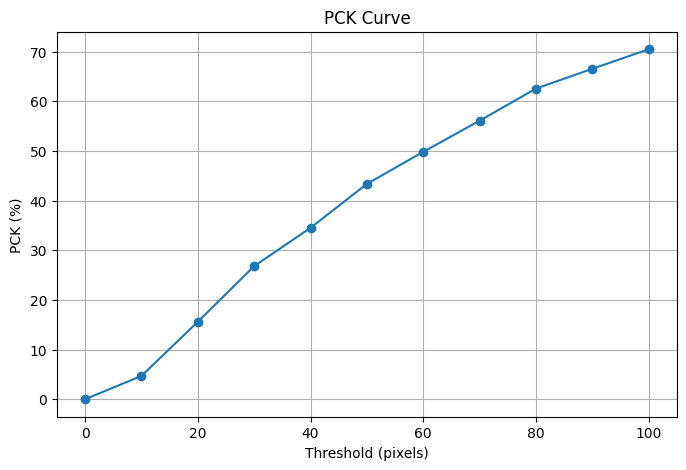

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# ✅ Leer CSV
csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_COMPRESSED_LOSSPHENO_untuned.csv"
df = pd.read_csv(csv_path)

# ✅ Filtrar keypoints no anotados (gt_x o gt_y igual a 0)
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ a) Error Euclidiano Promedio, Mediana, Desviación Estándar
mean_error = df_filtered['euclidean_error'].mean()
median_error = df_filtered['euclidean_error'].median()
std_error = df_filtered['euclidean_error'].std()

print(f"\n📏 Mean Euclidean Error: {mean_error:.2f}")
print(f"📏 Median Euclidean Error: {median_error:.2f}")
print(f"📏 Std Dev of Error: {std_error:.2f}")

# ✅ b) PCK a diferentes umbrales
thresholds = np.arange(0, 101, 10)  # De 0 a 100 píxeles en pasos de 5
pck_values = []

print("\n🎯 PCK Metrics:")
for t in thresholds:
    pck = (df_filtered['euclidean_error'] <= t).mean() * 100
    pck_values.append(pck)
    print(f"PCK@{t}px: {pck:.2f}%")

# ✅ c) AUC del PCK
auc_pck = metrics.auc(thresholds, pck_values) / thresholds[-1]  # Normalizado de 0 a 1
print(f"\n📈 AUC of PCK curve: {auc_pck:.4f}")

# ✅ Graficar curva PCK
plt.figure(figsize=(8, 5))
plt.plot(thresholds, pck_values, marker='o')
plt.xlabel('Threshold (pixels)')
plt.ylabel('PCK (%)')
plt.title('PCK Curve')
plt.grid(True)
plt.show()



📊 Per-Keypoint Metrics:
    Keypoint  Mean Error (px)  Median Error (px)  Std Dev (px)    AUC PCK
0          0       132.994754          38.235834    558.019084  51.859504
1          1       127.965862          51.433196    412.935630  42.768595
2          2       132.970343          51.681471    285.141723  43.760331
3          3       134.003950          78.282719    200.227205  31.818182
4          4       106.632194          52.320739    383.417088  46.239669
5          5       104.645316          48.103838    382.588303  46.652893
6          6       105.607119          52.175077    285.310590  44.132231
7          7        93.007798          46.907229    227.100072  45.041322
8          8        86.171976          51.059425    167.423390  45.541667
9          9       100.470462          57.371079    248.883684  40.125000
10        10       110.786713          51.525080    382.668981  46.074380
11        11       113.638306          48.312271    391.557115  48.223140
12        12 

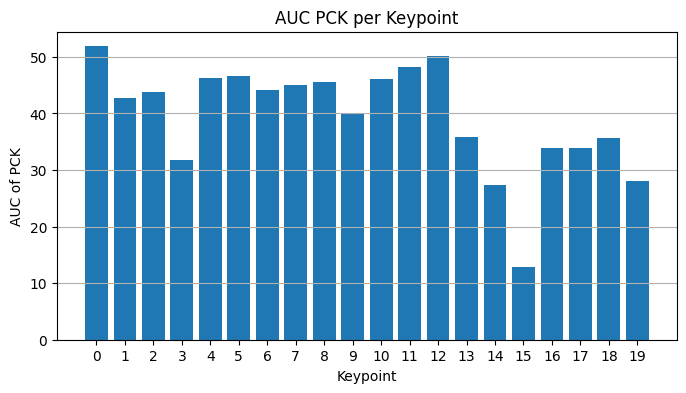

<Figure size 1000x500 with 0 Axes>

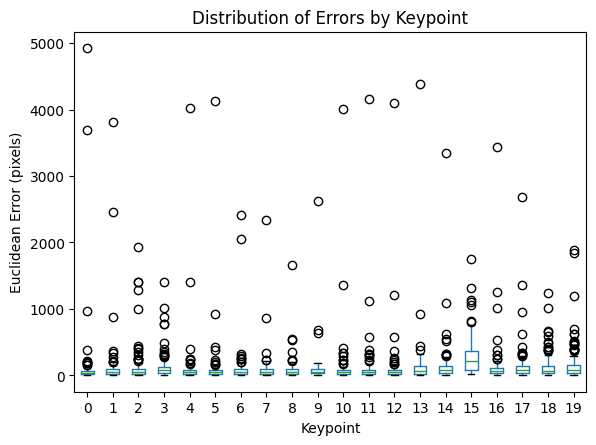

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# ✅ Load CSV
csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_COMPRESSED_LOSSPHENO_untuned.csv"
df = pd.read_csv(csv_path)

# ✅ Filter unannotated keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Thresholds for PCK
thresholds = np.arange(0, 101, 10)

# ✅ Store per-keypoint metrics
keypoint_metrics = []

# ✅ Iterate over keypoints
for kp in sorted(df_filtered['keypoint'].unique()):
    kp_data = df_filtered[df_filtered['keypoint'] == kp]

    # Euclidean error metrics
    mean_error = kp_data['euclidean_error'].mean()
    median_error = kp_data['euclidean_error'].median()
    std_error = kp_data['euclidean_error'].std()

    # PCK metrics
    pck_values = [(kp_data['euclidean_error'] <= t).mean() * 100 for t in thresholds]
    auc_pck = metrics.auc(thresholds, pck_values) / thresholds[-1]

    # Save metrics
    keypoint_metrics.append({
        'Keypoint': kp,
        'Mean Error (px)': mean_error,
        'Median Error (px)': median_error,
        'Std Dev (px)': std_error,
        'AUC PCK': auc_pck
    })

# ✅ Create DataFrame
df_keypoint_metrics = pd.DataFrame(keypoint_metrics)

# ✅ Show table
print("\n📊 Per-Keypoint Metrics:")
print(df_keypoint_metrics)

# ✅ Save results
output_csv = '/data/Datasets/Fish/CavFish/keypoint_metrics_summary_COMPRESSED_LOSSPHENO.csv'
df_keypoint_metrics.to_csv(output_csv, index=False)
print(f"\n✅ Metrics saved to: {output_csv}")

# ✅ Optional: LaTeX table (for papers)
latex_table = df_keypoint_metrics.to_latex(index=False, float_format="%.2f")
print("\n📄 LaTeX Table:\n")
print(latex_table)

# =====================
# ✅ Visualizations
# =====================

# ✅ AUC PCK bar plot
plt.figure(figsize=(8, 4))
plt.bar(df_keypoint_metrics['Keypoint'], df_keypoint_metrics['AUC PCK'])
plt.xlabel('Keypoint')
plt.ylabel('AUC of PCK')
plt.title('AUC PCK per Keypoint')
plt.xticks(df_keypoint_metrics['Keypoint'])
plt.grid(axis='y')
plt.show()

# ✅ Boxplot of Euclidean Errors
plt.figure(figsize=(10, 5))
df_filtered.boxplot(column='euclidean_error', by='keypoint', grid=False)
plt.xlabel('Keypoint')
plt.ylabel('Euclidean Error (pixels)')
plt.title('Distribution of Errors by Keypoint')
plt.suptitle('')
plt.show()

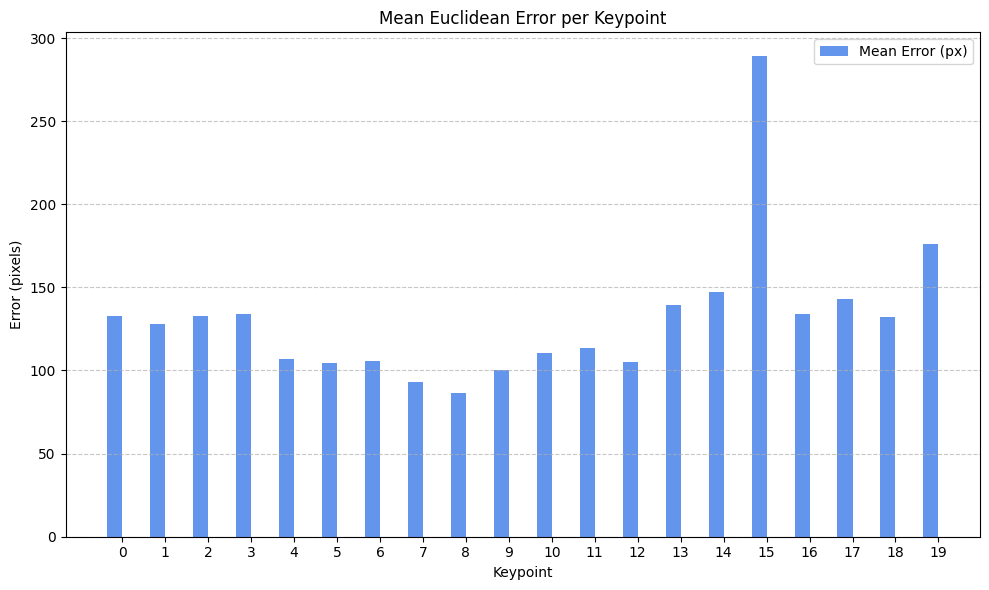

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# ✅ Load your CSV
csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_COMPRESSED_LOSSPHENO_untuned.csv"
df = pd.read_csv(csv_path)

# ✅ Filter invalid keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Thresholds for PCK
thresholds = np.arange(0, 101, 10)

# ✅ Collect metrics
keypoint_metrics = []
for kp in sorted(df_filtered['keypoint'].unique()):
    kp_data = df_filtered[df_filtered['keypoint'] == kp]

    mean_error = kp_data['euclidean_error'].mean()
    median_error = kp_data['euclidean_error'].median()
    std_error = kp_data['euclidean_error'].std()

    pck_values = [(kp_data['euclidean_error'] <= t).mean() * 100 for t in thresholds]
    auc_pck = metrics.auc(thresholds, pck_values) / thresholds[-1]

    keypoint_metrics.append({
        'Keypoint': kp,
        'Mean Error (px)': mean_error,
        'Median Error (px)': median_error,
        'Std Dev (px)': std_error,
        'AUC PCK': auc_pck
    })

# ✅ Create dataframe
df_keypoint_metrics = pd.DataFrame(keypoint_metrics)

# ✅ Save summary

#df_keypoint_metrics.to_csv('/data/Datasets/Fish/CavFish/keypoint_metrics_summary.csv', index=False)

# ✅ Bar Plot 1: Mean vs Median
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df_keypoint_metrics['Keypoint']))
bar_width = 0.35

bars1 = ax.bar(x - bar_width / 2, df_keypoint_metrics['Mean Error (px)'],
               width=bar_width, label='Mean Error (px)', color='cornflowerblue')

# ✅ Create custom tick labels
tick_labels = []
for kp in df_keypoint_metrics['Keypoint']:
    if kp >= 50:
        tick_labels.append(kp + 1)  # Shift by +1 after 13
    else:
        tick_labels.append(kp)

ax.set_xlabel('Keypoint')
ax.set_ylabel('Error (pixels)')
ax.set_title('Mean Euclidean Error per Keypoint')
ax.set_xticks(x)
ax.set_xticklabels(tick_labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## PMP

In [23]:
import pandas as pd
import numpy as np
from pathlib import Path

# --------------------------- Phenotype map (1-based) -----------------------------
phenotype_pairs_1based = {
    "SL":  (1, 2),     # Standard length (Snout ↔ Caudal fin base) if kp2 is base
    "PeDD": (4, 3),    # Pelvic–Dors    al fin origin distance
    "HD":  (5, 6),     # Head depth
    "CPD": (7, 8),     # Caudal peduncle depth
    "CFD": (9, 10),    # Caudal fin depth
    "ED":  (11, 12),   # Eye diameter
    "EyePelv": (13, 4),# Eye centroid ↔ Pelvic origin (custom)
    "SnPelv": (1, 4),  # Snout ↔ Pelvic origin (custom)
    "MaxJaw": (1, 14), # Maxillary jaw length (Snout ↔ Mouth corner)
    "PcL": (15, 16),   # Pectoral fin length
    "PcPeD": (15, 4),  # Pectoral–Pelvic fin origin distance
    "HL":  (1, 17),    # Head length (Snout ↔ Operculum posterior margin)
    "DFL": (3, 18),    # Dorsal fin length (dorsal anterior ↔ dorsal posterior)
    "AFL": (19, 20),   # Anal fin length (anal anterior ↔ anal posterior)
}

def _normalize_single(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize single combined CSV to ['image_id','keypoint_id','x_gt','y_gt','x_pred','y_pred'].
    Expects at least: ['keypoint','gt_x','gt_y','pred_x','pred_y'].
    If 'image_id' is missing but 'image' exists, build image_id by factorizing 'image'.
    Ensures one row per (image_id, keypoint_id) by keeping the last occurrence.
    """
    required = ["keypoint", "gt_x", "gt_y", "pred_x", "pred_y"]
    for c in required:
        if c not in df.columns:
            raise ValueError(f"Missing required column '{c}' in the CSV.")

    out = df.copy()

    # Build image_id robustly
    if "image_id" in out.columns:
        # trust existing image_id
        pass
    elif "image" in out.columns:
        # factorize image path/filename into stable ids
        out["image_id"] = pd.factorize(out["image"].astype(str).str.strip())[0]
    else:
        # last resort: every row is treated as same image (not recommended)
        raise ValueError("CSV missing 'image_id' and 'image' columns; cannot group by image.")

    # enforce numeric types
    out["keypoint"] = pd.to_numeric(out["keypoint"], errors="raise")
    for c in ["gt_x","gt_y","pred_x","pred_y"]:
        out[c] = pd.to_numeric(out[c], errors="raise")

    # rename to common schema
    out = out.rename(columns={"keypoint":"keypoint_id",
                              "gt_x":"x_gt","gt_y":"y_gt",
                              "pred_x":"x_pred","pred_y":"y_pred"})

    # keep ONE row per (image_id, keypoint_id). If duplicates exist, keep the last.
    out = (
        out.sort_index()
           .reset_index(drop=True)
    )

    return out[["image_id","keypoint_id","x_gt","y_gt","x_pred","y_pred"]]

def _compute_pheno_lengths_gt(gt_img_df: pd.DataFrame, pheno_pairs: dict) -> dict:
    """
    Compute phenotype lengths using GT coords for one image.
    gt_img_df columns: ['keypoint_id','x_gt','y_gt'] for a single image_id.
    Returns dict: pheno_name -> length (float)
    """
    idx = gt_img_df.set_index("keypoint_id")
    out = {}
    for name, (a, b) in pheno_pairs.items():
        if a in idx.index and b in idx.index:
            pa = idx.loc[a, ["x_gt","y_gt"]].values.astype(float)
            pb = idx.loc[b, ["x_gt","y_gt"]].values.astype(float)
            out[name] = float(np.linalg.norm(pa - pb))
    return out

def compute_pmp_single_df(df: pd.DataFrame,
                          phenotype_pairs: dict,
                          r: float = 0.1):
    """
    Compute PMP from a single combined dataframe.
    Returns (pmp_df, overall_mean, dj_table).

    Enhancements:
    - Tracks, for every (image_id, keypoint_id), the phenotype actually used
      for normalization (the shortest one involving that keypoint).
    - Aggregates per keypoint:
        * assoc_phenotype: most frequent phenotype chosen for that keypoint
        * mean_norm_len_px: mean of the chosen phenotype lengths used
        * threshold_10pct_px: r * mean_norm_len_px
    """
    M = _normalize_single(df)

    dj_rows = []
    # for per-kp aggregation of the phenotype actually used
    kp_normlens = {}   # keypoint_id -> list of norm_len values used
    kp_phnames  = {}   # keypoint_id -> list of phenotype names chosen

    for img_id, Mi in M.groupby("image_id", sort=False):
        # phenotype lengths (GT) for this image
        ph_len = _compute_pheno_lengths_gt(Mi[["keypoint_id","x_gt","y_gt"]], phenotype_pairs)

        # distances (pixel error per kp)
        pixel_err = np.sqrt(((Mi[["x_gt","y_gt"]].to_numpy(float) -
                              Mi[["x_pred","y_pred"]].to_numpy(float)) ** 2).sum(axis=1))

        # choose shortest phenotype involving each keypoint
        norm_len_list = []
        norm_phname_list = []
        for kp in Mi["keypoint_id"].astype(int).tolist():
            # collect candidates for this kp
            candidates = []
            for name, (a, b) in phenotype_pairs.items():
                if kp in (a, b) and name in ph_len and ph_len[name] > 0:
                    candidates.append((name, ph_len[name]))

            if candidates:
                # shortest phenotype for this kp on this image
                phname, plen = min(candidates, key=lambda t: t[1])
                norm_len_list.append(plen)
                norm_phname_list.append(phname)

                # record for per-kp aggregation
                kp_normlens.setdefault(kp, []).append(plen)
                kp_phnames.setdefault(kp, []).append(phname)
            else:
                norm_len_list.append(np.nan)
                norm_phname_list.append(None)

        tmp = Mi[["image_id","keypoint_id"]].copy()
        tmp["pixel_err"]   = pixel_err
        tmp["norm_len"]    = norm_len_list
        tmp["norm_pheno"]  = norm_phname_list
        tmp = tmp.dropna(subset=["norm_len"]).copy()

        tmp["d_jn"]    = tmp["pixel_err"] / tmp["norm_len"]
        tmp["correct"] = (tmp["d_jn"] < r).astype(int)

        dj_rows.append(tmp)

    if not dj_rows:
        raise ValueError("No evaluable rows. Make sure each keypoint appears in ≥1 phenotype pair.")

    # Debug-level table (per (image,kp))
    D = pd.concat(dj_rows, ignore_index=True)

    # Per-kp PMP
    pmp = D.groupby("keypoint_id")["correct"].mean().reset_index()
    pmp["pmp"] = pmp["correct"] * 100.0
    pmp = pmp.drop(columns=["correct"]).sort_values("keypoint_id").reset_index(drop=True)

    # Per-kp phenotype association stats
    assoc_rows = []
    for kp in sorted(set(D["keypoint_id"].astype(int))):
        ph_list = kp_phnames.get(kp, [])
        ln_list = kp_normlens.get(kp, [])
        if not ph_list or not ln_list:
            continue

        # most frequent phenotype chosen for this kp
        counts = pd.Series(ph_list).value_counts()
        assoc_ph = counts.index[0]

        mean_norm = float(np.mean(ln_list))
        assoc_rows.append({
            "keypoint_id": kp,
            "assoc_phenotype": assoc_ph,
            "mean_norm_len_px": mean_norm,
            "threshold_10pct_px": mean_norm * r
        })

    assoc_df = pd.DataFrame(assoc_rows)

    # Merge into pmp report
    if not assoc_df.empty:
        pmp = pmp.merge(assoc_df, on="keypoint_id", how="left")

    overall = float(pmp["pmp"].mean()) if len(pmp) else float("nan")
    return pmp, overall, D


def run_pmp_single(csv_path: str,
                   model,
                   phenotype_pairs: dict = None,
                   r: float = 0.1,
                   out_dir: str = "/mnt/data"):
    """
    Load a single CSV (combined GT+Pred), compute PMP, and save reports.

    Adds:
    - assoc phenotype + mean_norm_len_px + threshold_10pct_px to the pmp report
    - keeps debug sample (first 100 rows)
    - writes overall mean PMP to a txt
    """
    if phenotype_pairs is None:
        phenotype_pairs = phenotype_pairs_1based

    # keep your existing fixed directory (as in your current code)
    out_dir = Path("/data/Datasets/Fish/CavFish/Predictions/PMP")
    out_dir.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv(csv_path)
    pmp_df, overall, dj_table = compute_pmp_single_df(df, phenotype_pairs, r=r)

    # Save files
    pmp_path = out_dir / f"{model}_pmp_report.csv"
    overall_path = out_dir / f"{model}_pmp_overall.txt"
    debug_path = out_dir / f"{model}_pmp_debug_sample.csv"

    pmp_df.to_csv(pmp_path, index=False)
    dj_table.head(100).to_csv(debug_path, index=False)
    with open(overall_path, "w") as f:
        f.write(f"{overall:.4f}\n")

    return {
        "pmp_report": str(pmp_path),
        "overall_file": str(overall_path),
        "debug_sample": str(debug_path),
        "overall_mean_pct": overall,
    }

In [25]:
results = run_pmp_single("/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_depressed_LossNorm1e2.csv", "depressed_LossNorm1e2", r=0.1)
results


#csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_COMPRESSED_LOSSPHENO_untuned.csv"


{'pmp_report': '/data/Datasets/Fish/CavFish/Predictions/PMP/depressed_LossNorm1e2_pmp_report.csv',
 'overall_file': '/data/Datasets/Fish/CavFish/Predictions/PMP/depressed_LossNorm1e2_pmp_overall.txt',
 'debug_sample': '/data/Datasets/Fish/CavFish/Predictions/PMP/depressed_LossNorm1e2_pmp_debug_sample.csv',
 'overall_mean_pct': 61.41470698021649}

In [25]:
import pandas as pd

# Leer el CSV (por defecto, las cadenas NO se convierten en factores/categorías)
COMPRESSED_LOSSPHENO = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_compressed_COMPRESSED_LOSSPHENO_augmentedresolution.csv")

COMPRESSED_LOSSPHENO

image  keypoint    gt_x    gt_y  \
0     2018 Guayavero Duda/IMG_0084-Edit.jpg         0   348.2  1755.0   
1     2018 Guayavero Duda/IMG_0084-Edit.jpg         1  4233.7  1981.7   
2     2018 Guayavero Duda/IMG_0084-Edit.jpg         2  1580.3  1440.7   
3     2018 Guayavero Duda/IMG_0084-Edit.jpg         3  2373.6  2434.5   
4     2018 Guayavero Duda/IMG_0084-Edit.jpg         4   730.6  1516.1   
...                                     ...       ...     ...     ...   
2415      2018 Yungillo/IMG_1771-Editar.jpg        15  1109.2  2313.9   
2416      2018 Yungillo/IMG_1771-Editar.jpg        16   945.4  1516.8   
2417      2018 Yungillo/IMG_1771-Editar.jpg        17  2954.2   473.9   
2418      2018 Yungillo/IMG_1771-Editar.jpg        18  2644.3  2054.0   
2419      2018 Yungillo/IMG_1771-Editar.jpg        19  3109.7  2372.5   

           pred_x       pred_y  euclidean_error  
0      297.280925  1787.639557        60.482170  
1     4195.175872  1966.543396        41.398443  
2     1622.335512  1440.846497        42.035767  
3     2049.970563  2487.190979       327.890762  
4      682.810372  1520.904968        48.030576  
...           ...          ...              ...  
2415  1358.354722  2163.353027       291.105593  
2416   931.019632  1593.471588        78.008509  
2417  2976.667628   413.076050        64.840938  
2418  2623.111254  2050.196045        21.527495  
2419  3048.177321  2315.753174        83.697326  

[2420 rows x 7 columns]

In [34]:
import pandas as pd

# Leer el CSV (por defecto, las cadenas NO se convierten en factores/categorías)
pmp_report__ = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_COMPRESSED_LOSSPHENO_augmentedresolution_pmp_report.csv")

pmp_report__

keypoint_id        pmp assoc_phenotype  mean_norm_len_px  \
0             0  25.619835          MaxJaw        294.058149   
1             1  95.867769              SL       3160.503730   
2             2  58.677686             DFL        632.308515   
3             3  39.669421           PcPeD        675.275817   
4             4  53.719008              HD        549.287749   
5             5  57.851240              HD        549.287749   
6             6  28.099174             CPD        343.103504   
7             7  27.272727             CPD        343.103504   
8             8  72.500000             CFD        866.741986   
9             9  66.666667             CFD        866.741986   
10           10  17.355372              ED        262.294990   
11           11  24.793388              ED        262.294990   
12           12  87.603306         EyePelv       1235.765643   
13           13  16.528926          MaxJaw        301.537599   
14           14  23.140496             PcL        542.894398   
15           15   7.500000             PcL        599.965971   
16           16  57.851240              HL        822.509475   
17           17  40.495868             DFL        672.208730   
18           18  35.000000             AFL        572.759052   
19           19  25.000000             AFL        572.759052   

    threshold_10pct_px  
0            29.405815  
1           316.050373  
2            63.230852  
3            67.527582  
4            54.928775  
5            54.928775  
6            34.310350  
7            34.310350  
8            86.674199  
9            86.674199  
10           26.229499  
11           26.229499  
12          123.576564  
13           30.153760  
14           54.289440  
15           59.996597  
16           82.250947  
17           67.220873  
18           57.275905  
19           57.275905

## Comparar Inferencias PCK

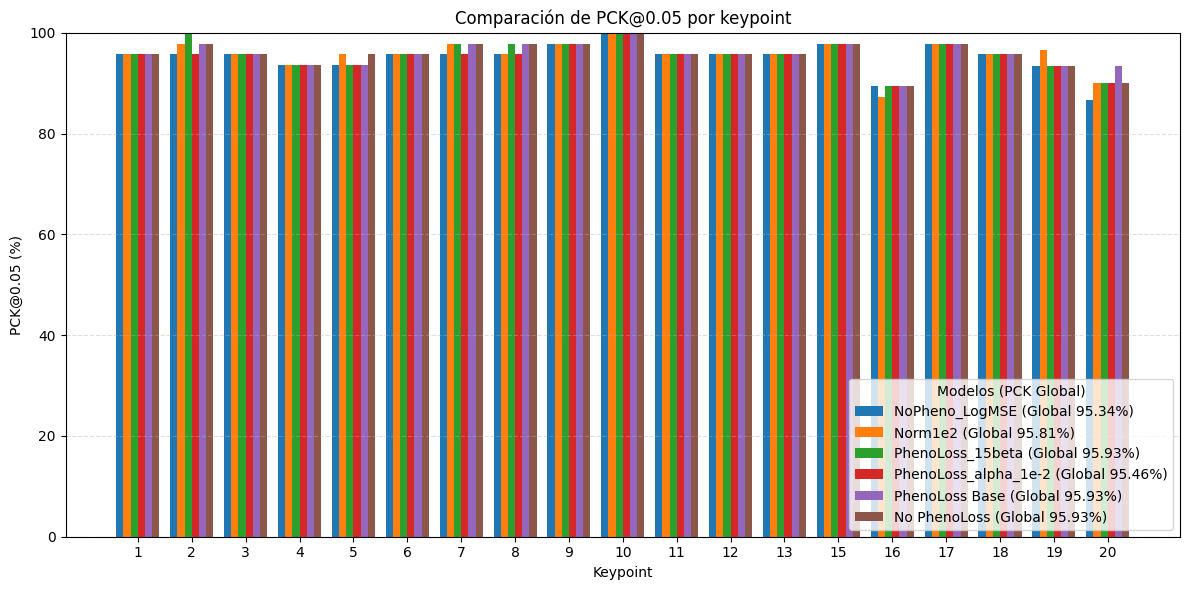

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def _ensure_correct_flag(df: pd.DataFrame, alpha: float = 0.05) -> pd.DataFrame:
    """
    Asegura la columna boolean 'correct_pck_0.05'.
    Si existe 'correct_pck_0.05', la respeta.
    Si no existe, usa 'pck_threshold' si está; si no, usa image_diagonal * alpha.
    """
    df = df.copy()
    if "correct_pck_0.05" in df.columns:
        # Ya está todo
        return df

    if "pck_threshold" in df.columns:
        thr = df["pck_threshold"].astype(float)
    else:
        if "image_diagonal" not in df.columns:
            raise ValueError("Falta 'image_diagonal' (o 'pck_threshold') para calcular PCK.")
        thr = df["image_diagonal"].astype(float) * alpha

    if "euclidean_error" not in df.columns:
        raise ValueError("Falta 'euclidean_error' para calcular PCK.")

    df["correct_pck_0.05"] = df["euclidean_error"].astype(float) <= thr
    return df

def compute_pck_by_keypoint_and_global(df: pd.DataFrame) -> tuple[pd.Series, float]:
    """
    Retorna:
      - Serie PCK por keypoint (en %)
      - PCK global (en %)
    """
    pck_by_kp = df.groupby("keypoint")["correct_pck_0.05"].mean() * 100.0
    pck_global = df["correct_pck_0.05"].mean() * 100.0
    return pck_by_kp, pck_global

def plot_pck_comparison(model_csv_map: dict, alpha: float = 0.05, title: str = "PCK@0.05 por keypoint (comparación de modelos)", save_path: str | None = None):
    """
    model_csv_map: dict { "NombreModelo": "ruta/al/archivo.csv", ... }
    - Calcula PCK@0.05 por keypoint y global para cada modelo.
    - Dibuja barras agrupadas por keypoint.
    - En la leyenda muestra el PCK global de cada modelo.
    - Si save_path se provee, guarda la figura.
    """
    # 1) Cargar y calcular PCKs
    per_model_kp = {}   # {model: Series}
    per_model_global = {}  # {model: float}

    for model_name, csv_path in model_csv_map.items():
        df = pd.read_csv(csv_path)
        df = _ensure_correct_flag(df, alpha=alpha)

        # Asegurar columna 'keypoint'
        if "keypoint" not in df.columns:
            raise ValueError(f"El CSV de '{model_name}' no contiene la columna 'keypoint'.")

        s_kp, g = compute_pck_by_keypoint_and_global(df)
        per_model_kp[model_name] = s_kp.sort_index()
        per_model_global[model_name] = g

    # 2) Construir índice maestro de keypoints (unión de todos los modelos)
    all_keypoints = sorted(set().union(*[s.index.tolist() for s in per_model_kp.values()]))

    # 3) Armar matriz: filas = keypoints, columnas = modelos
    models = list(per_model_kp.keys())
    data = np.zeros((len(all_keypoints), len(models))) * np.nan

    for j, m in enumerate(models):
        s = per_model_kp[m]
        # Alinear por índice maestro
        aligned = s.reindex(all_keypoints)
        data[:, j] = aligned.values

    # 4) Plot: barras agrupadas
    x = np.arange(len(all_keypoints))
    n_models = len(models)
    width = 0.8 / max(n_models, 1)

    fig, ax = plt.subplots(figsize=(12, 6))
    for j, m in enumerate(models):
        # Etiqueta con PCK global en la leyenda
        label = f"{m} (Global {per_model_global[m]:.2f}%)"
        ax.bar(x + j * width - (n_models-1)*width/2, data[:, j], width=width, label=label)

    # 5) Decoración
    ax.set_title(title)
    ax.set_xlabel("Keypoint")
    ax.set_ylabel("PCK@0.05 (%)")
    ax.set_xticks(x)
    ax.set_xticklabels([str(kp) for kp in all_keypoints], rotation=0)
    ax.set_ylim(0, 100)
    ax.grid(axis="y", linestyle="--", alpha=0.4)
    ax.legend(title="Modelos (PCK Global)", loc="lower right")

    plt.tight_layout()

    # 6) Guardar si se pide
    if save_path is not None:
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=200, bbox_inches="tight")

    plt.show()


model_csvs = {
    "NoPheno_LogMSE": "/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_depressed_logMSE_noPheno.csv",
    "Norm1e2": "/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_depressed_LossNorm1e2.csv",
    "PhenoLoss_15beta": "/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_depressed_PhenoLoss15beta.csv",
    "PhenoLoss_alpha_1e-2": "/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_depressed_PhenoLoss1e2alpha.csv",
    "PhenoLoss Base": "/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_depressed_PhenoLossNoResAug.csv",
    "No PhenoLoss": "/data/Datasets/Fish/CavFish/Predictions/predictions_depressed_untuned.csv",

}
plot_pck_comparison(
    model_csvs,
    alpha=0.05,
    title="Comparación de PCK@0.05 por keypoint"
)

In [21]:
import pandas as pd

# === 1. Leer el archivo CSV ===
# Cambia el nombre si tu archivo tiene otro nombre o ruta
df = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_compressed_logMSE_noPheno.csv")

# === 2. Si no existe la columna correct_pck_0.05, la calculamos ===
if "correct_pck_0.05" not in df.columns:
    alpha = 0.05
    df["pck_threshold"] = df["image_diagonal"] * alpha
    df["correct_pck_0.05"] = df["euclidean_error"] <= df["pck_threshold"]

# === 3. Calcular el PCK global ===
pck_global = df["correct_pck_0.05"].mean() * 100

# === 4. Calcular el PCK por keypoint ===
pck_por_keypoint = df.groupby("keypoint")["correct_pck_0.05"].mean() * 100

# === 5. Mostrar resultados ===
print(f"📊 PCK@0.05 Global: {pck_global:.2f}%\n")
print("📍 PCK@0.05 por Keypoint:")
print(pck_por_keypoint.round(2))



📊 PCK@0.05 Global: 96.60%

📍 PCK@0.05 por Keypoint:
keypoint
1     96.69
2     96.69
3     96.69
4     96.69
5     98.35
6     96.69
7     98.35
8     98.35
9     97.50
10    97.50
11    97.52
12    96.69
13    96.69
14    96.69
15    95.83
16    90.00
17    97.52
18    96.58
19    95.83
20    95.00
Name: correct_pck_0.05, dtype: float64


## Comparar inferencias PMP

In [ ]:
# pmp_report__No_Augmentation
pmp_report__No_Augmentation = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_pmp_report.csv")
#pmp_report__No_Augmentation

# pmp_report__No_Augmentation
pmp_report__Aug_No_GridMask = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_augmented_nogridmask_pmp_report.csv")
#pmp_report__Aug_No_GridMask

# pmp_report__No_Augmentation
pmp_report__Aug_resolution = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_augmentedresolution_pmp_report.csv")
#pmp_report__Aug_resolution

# pmp_report__COMPRESSED_LOSSPHENO
pmp_report__COMPRESSED_LOSSPHENO = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_COMPRESSED_LOSSPHENO_augmentedresolution_pmp_report.csv")
pmp_report__COMPRESSED_LOSSPHENO

keypoint_id        pmp assoc_phenotype  mean_norm_len_px  \
0             0  25.619835          MaxJaw        294.058149   
1             1  95.867769              SL       3160.503730   
2             2  58.677686             DFL        632.308515   
3             3  39.669421           PcPeD        675.275817   
4             4  53.719008              HD        549.287749   
5             5  57.851240              HD        549.287749   
6             6  28.099174             CPD        343.103504   
7             7  27.272727             CPD        343.103504   
8             8  72.500000             CFD        866.741986   
9             9  66.666667             CFD        866.741986   
10           10  17.355372              ED        262.294990   
11           11  24.793388              ED        262.294990   
12           12  87.603306         EyePelv       1235.765643   
13           13  16.528926          MaxJaw        301.537599   
14           14  23.140496             PcL        542.894398   
15           15   7.500000             PcL        599.965971   
16           16  57.851240              HL        822.509475   
17           17  40.495868             DFL        672.208730   
18           18  35.000000             AFL        572.759052   
19           19  25.000000             AFL        572.759052   

    threshold_10pct_px  
0            29.405815  
1           316.050373  
2            63.230852  
3            67.527582  
4            54.928775  
5            54.928775  
6            34.310350  
7            34.310350  
8            86.674199  
9            86.674199  
10           26.229499  
11           26.229499  
12          123.576564  
13           30.153760  
14           54.289440  
15           59.996597  
16           82.250947  
17           67.220873  
18           57.275905  
19           57.275905

In [52]:
pmp_report__COMPRESSED_LOSSPHENO['keypoint_id'] = (
    pmp_report__COMPRESSED_LOSSPHENO['keypoint_id'] + 1
)
pmp_report__COMPRESSED_LOSSPHENO

pmp_report__COMPRESSED_LOSSPHENO.to_csv(
    "/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_COMPRESSED_LOSSPHENO_augmentedresolution_pmp_report_reindexed.csv",
    index=False
)

In [10]:
# ============================================
# Comparación PMP (%) por keypoint 
# Requisitos: pandas, numpy, matplotlib
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from functools import reduce

# -------- 1) Rutas de entrada (ajusta si hace falta) --------
files = {
    "PhenoLoss_alpha_1e-2": "/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_PhenoLoss1e2alpha_pmp_report.csv",
    "PhenoLoss_beta_15": "/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_PhenoLoss15beta_pmp_report.csv",
    'Log(MSE)': "/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_logMSE_noPheno_pmp_report.csv",
    'Norm(L1)': "/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_LossNorm1e2_pmp_report.csv",
    'PhenoLoss Base': "/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_PhenoLossNoResAug_pmp_report.csv",
    'No PhenoLoss': "/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_pmp_report.csv",
    'PhenoLoss Log(MSE)': "/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_LOSSPHENO__LOG(MSE)_pmp_report.csv",
    'MinPhenoLoss': "/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_minphenoloss_pmp_report.csv"
}

# -------- 2) Función de lectura robusta --------
def load_pmp(path, label):
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"No se encontró el archivo: {p}")
    df = pd.read_csv(p)
    # Normaliza nombres de columnas
    cols = {c: c.strip().lower() for c in df.columns}
    df = df.rename(columns=cols)

    # Detecta columnas de keypoint y pmp
    key_cols = [c for c in df.columns if "keypoint" in c and "id" in c or c == "keypoint_id"]
    if not key_cols:
        # fallback: si hay 'keypoint' sin 'id'
        key_cols = [c for c in df.columns if c == "keypoint" or c == "kp_id"]
    if not key_cols:
        raise ValueError(f"No se encontró columna de keypoint en {path}. "
                         f"Incluye una columna 'keypoint_id' o similar.")
    key_col = key_cols[0]

    pmp_cols = [c for c in df.columns if c == "pmp" or c == "pmp(%)" or c == "pmp_pct" or "pmp" in c]
    if not pmp_cols:
        raise ValueError(f"No se encontró columna de PMP en {path}. "
                         f"Se esperaba 'pmp' o similar.")
    pmp_col = pmp_cols[0]

    out = df[[key_col, pmp_col]].copy()
    out = out.rename(columns={key_col: "keypoint_id", pmp_col: label})

    # Convierte a número
    out["keypoint_id"] = pd.to_numeric(out["keypoint_id"], errors="coerce")
    out[label] = pd.to_numeric(out[label], errors="coerce")

    # Convierte a porcentaje si está en 0–1
    if out[label].dropna().max() is not None and out[label].dropna().max() <= 1.0:
        out[label] = out[label] * 100.0

    return out

keypoint_id  PhenoLoss_alpha_1e-2  PhenoLoss_beta_15   Log(MSE)  \
0             1             57.024793          58.677686  59.504132   
1             2             97.520661          97.520661  97.520661   
2             3             80.991736          79.338843  83.471074   
3             4             74.380165          73.553719  75.206612   
4             5             81.818182          80.991736  82.644628   
5             6             78.512397          80.991736  78.512397   
6             7             59.504132          61.157025  59.504132   
7             8             53.719008          59.504132  56.198347   
8             9             85.833333          86.666667  87.500000   
9            10             85.833333          86.666667  85.000000   
10           11             52.892562          57.851240  53.719008   
11           12             52.892562          54.545455  57.851240   
12           13             94.214876          95.041322  94.214876   
13           14             34.710744          31.404959  31.404959   
14           15             61.983471          56.198347  62.500000   
15           16             33.333333          34.166667  35.833333   
16           17             81.818182          77.685950  80.991736   
17           18             70.247934          69.421488  73.504274   
18           19             71.666667          69.166667  74.166667   
19           20             70.833333          71.666667  69.166667   

     Norm(L1)  PhenoLoss Base  No PhenoLoss  PhenoLoss Log(MSE)  MinPhenoLoss  
0   53.719008       60.330579     52.892562           58.677686     52.892562  
1   97.520661       97.520661     97.520661           97.520661     97.520661  
2   80.165289       80.991736     80.991736           83.471074     83.471074  
3   71.900826       67.768595     69.421488           71.074380     72.727273  
4   83.471074       82.644628     80.165289           81.818182     83.471074  
5   76.033058       80.165289     79.338843           81.818182     76.859504  
6   57.851240       66.115702     64.462810           64.462810     59.504132  
7   52.892562       57.851240     57.024793           57.024793     55.371901  
8   85.833333       86.666667     86.666667           87.500000     87.500000  
9   87.500000       85.833333     85.000000           85.833333     85.833333  
10  46.280992       52.892562     50.413223           53.719008     52.066116  
11  54.545455       55.371901     55.371901           53.719008     52.892562  
12  94.214876       94.214876     95.867769           95.867769     94.214876  
13  32.231405       23.966942     27.272727           32.231405     25.619835  
14  60.833333       56.198347     57.500000           57.024793     59.166667  
15  34.166667       39.166667     30.833333           39.166667     34.166667  
16  80.165289       79.338843     80.991736           80.991736     81.818182  
17  74.358974       70.247934     73.504274           69.421488     73.504274  
18  65.833333       65.833333     75.833333           70.833333     66.666667  
19  71.666667       71.666667     72.500000           70.000000     71.666667

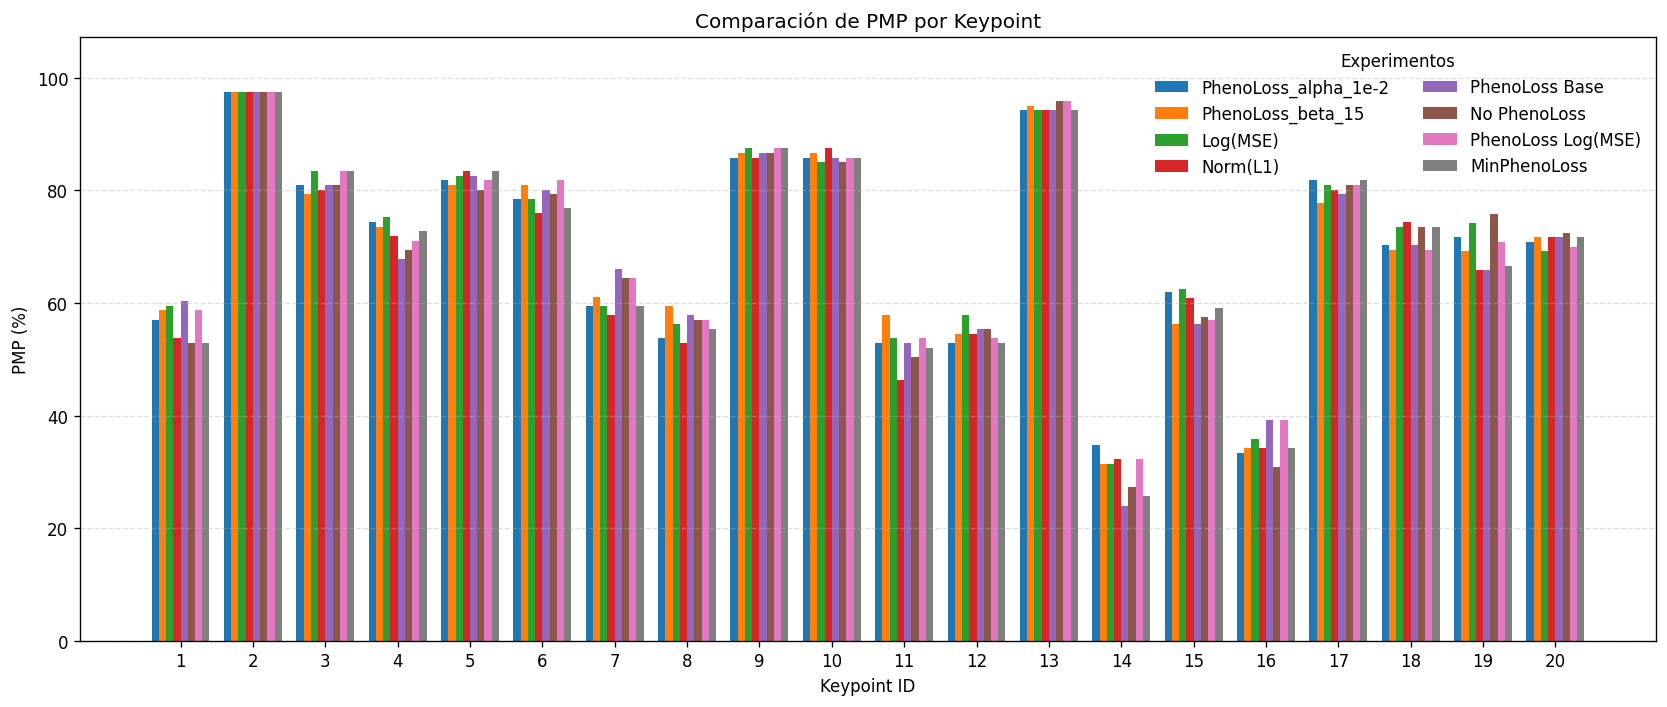

In [11]:
# -------- 3) Carga, fusión y orden --------
dfs = [load_pmp(path, label) for label, path in files.items()]
merged = reduce(lambda l, r: pd.merge(l, r, on="keypoint_id", how="outer"), dfs)
merged = merged.sort_values("keypoint_id").reset_index(drop=True)

# Opcional: imprime una vista rápida
display_cols = ["keypoint_id"] + list(files.keys())
display(merged[display_cols].head(20))

# -------- 4) Gráfico de barras agrupadas --------
labels = list(files.keys())
keypoints = merged["keypoint_id"].astype(int).tolist()
x = np.arange(len(keypoints))  # posiciones en X
n_series = len(labels)
bar_width = 0.8 / n_series     # ancho de cada barra dentro del grupo

fig, ax = plt.subplots(figsize=(14, 6), dpi=120)

for i, lab in enumerate(labels):
    yvals = merged[lab].values
    # Offset para cada serie
    ax.bar(x + (i - (n_series-1)/2)*bar_width, yvals, width=bar_width, label=lab)

# Estética y etiquetas
ax.set_xlabel("Keypoint ID")
ax.set_ylabel("PMP (%)")
ax.set_title("Comparación de PMP por Keypoint")
ax.set_xticks(x)
ax.set_xticklabels(keypoints, rotation=0)
ax.set_ylim(0, max(100, np.nanmax(merged[labels].values)*1.1))  # hasta 100 o un poco más del máximo
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.legend(title="Experimentos", ncols=2, frameon=False)
fig.tight_layout()

# Guardar
#out_path = Path.cwd() / "pmp_keypoints_comparison.png"
# plt.savefig(out_path, bbox_inches="tight")
plt.show()

# print(f"Figura guardada en: {out_path}")


### **LOSS PHENO, NON AUGMENTATION**

##### Se soluciona alineacion

In [1]:
# Se extrae la ruta de la imagen. Final
import os
import json
import subprocess

# Configuración de rutas
json_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
dataset_root = '/data/Datasets/Fish/CavFish'
output_folder = '/data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno02'
config_path = 'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_ViTPose-fish9_8xb32-100etrain_loss.py'
checkpoint_path = '/data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno_02/epoch_300.pth'
merged_json_path = os.path.join(output_folder, 'all_keypoints_predicted_compressed_ViTPose_untuned_Losspheno02.json')

# Clase(s) objetivo a filtrar
target_labels = ['Compressed body']

# Crear carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Leer el archivo JSON de validación
with open(json_path, 'r') as f:
    val_data = json.load(f)

# Almacenar todas las predicciones
all_predictions = []

# Recorrer cada imagen del archivo de validación
for image_info in val_data['images']:
    # Filtrar por clase (label)
    if image_info.get('label') not in target_labels:
        continue

    relative_path = image_info['file_name']  # ej: "2018 Guayavero Duda/IMG_0084-Edit.jpg"
    full_path = os.path.join(dataset_root, relative_path)

    # Nombre de imagen para guardar outputs
    img_name = os.path.basename(relative_path)
    out_base = os.path.join(output_folder, img_name)
    out_json = out_base.replace('.jpg', '_keypoints.json').replace('.png', '_keypoints.json')

    # Verificación de existencia de imagen
    if not os.path.exists(full_path):
        print(f"⚠️ Imagen no encontrada: {full_path}")
        continue

    # Ejecutar la inferencia
    cmd = [
        "python", "demo/image_demo.py",
        full_path,
        config_path,
        checkpoint_path,
        "--out-file", out_base,
        "--draw-heatmap",
        "--show-kpt-idx"
    ]

    print(f"🔁 Procesando {relative_path}...")
    subprocess.run(cmd)

    # Leer predicción y asociarla a la ruta relativa original (no solo nombre)
    if os.path.exists(out_json):
        with open(out_json, 'r') as f:
            pred = json.load(f)

        # Normalizar output para que coincida con GT
        pred["image"] = relative_path  # Sobrescribe con la ruta relativa del GT
        all_predictions.append(pred)
    else:
        print(f"⚠️ No se encontró JSON de salida para {img_name}")

# Guardar todas las predicciones en un solo archivo
with open(merged_json_path, 'w') as f:
    json.dump(all_predictions, f, indent=4)

print(f"\n✅ JSON consolidado guardado en: {merged_json_path}")

🔁 Procesando 2018 Guayavero Duda/IMG_0084-Edit.jpg...
Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish/ViTPose_20kpt_nonaugmented_increasedresolution_Losspheno_02/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=280.7, y=1764.6, score=0.847

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno02/IMG_0084-Edit_keypoints.json
 - 1: x=4156.6, y=1949.3, score=0.721

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno02/IMG_0084-Edit_keypoints.json
 - 2: x=1612.3, y=1417.8, score=0.787

📝 Coo

In [2]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Rutas
pred_file = Path("/data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_increasedresolution_Losspheno02/all_keypoints_predicted_compressed_ViTPose_untuned_Losspheno02.json")
gt_file = Path("/data/Datasets/Fish/CavFish/fish20kpt_all_val.json")

# Cargar archivos
with pred_file.open("r") as f:
    pred_data = json.load(f)

with gt_file.open("r") as f:
    gt_data = json.load(f)

# Crear índice de anotaciones por imagen
image_id_to_name = {img['id']: img['file_name'] for img in gt_data['images']}
annotations_by_name = {
    image_id_to_name[ann['image_id']]: np.array(ann['keypoints']).reshape(-1, 3)[:, :2]
    for ann in gt_data['annotations']
}

# Comparación punto a punto
rows = []
gt_all = []
pred_all = []

for item in pred_data:
    name = item["image"]
    pred_kpts = {kp["name"]: (kp["x"], kp["y"]) for kp in item["keypoints"]}
    gt_kpts = annotations_by_name.get(name)

    if gt_kpts is None:
        print(f"⚠️ Imagen {name} no encontrada en GT.")
        continue

    for idx, (gt_xy, (kpt_name, pred_xy)) in enumerate(zip(gt_kpts, pred_kpts.items())):
        error = np.linalg.norm(np.array(pred_xy) - np.array(gt_xy))
        rows.append({
            "image": name,
            "keypoint": kpt_name,
            "gt_x": gt_xy[0],
            "gt_y": gt_xy[1],
            "pred_x": pred_xy[0],
            "pred_y": pred_xy[1],
            "euclidean_error": error
        })
        gt_all.extend(gt_xy)
        pred_all.extend(pred_xy)

df = pd.DataFrame(rows)

# --- 1. Métricas globales por keypoint ---
trait_metrics = []
for kpt in df["keypoint"].unique():
    sub = df[df["keypoint"] == kpt]
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    trait_metrics.append({
        "keypoint": kpt,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy)
    })
df_trait = pd.DataFrame(trait_metrics)
df_trait.to_csv("/data/Datasets/Fish/CavFish/metrics_per_keypoint_COMPRESSED_LOSSPHENO_ViTPose02.csv", index=False)

# --- 2. Métricas por imagen ---
image_metrics = []
for img in df["image"].unique():
    sub = df[df["image"] == img]
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    image_metrics.append({
        "image": img,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy)
    })
df_image = pd.DataFrame(image_metrics)
df_image.to_csv("/data/Datasets/Fish/CavFish/metrics20_per_image_COMPRESSED_LOSSPHENO_ViTPose02.csv", index=False)

# --- 3. Métricas por keypoint e imagen ---
trait_image_metrics = []
for (img, kpt), sub in df.groupby(["image", "keypoint"]):
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    trait_image_metrics.append({
        "image": img,
        "keypoint": kpt,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy) if len(gt_xy) > 1 else None
    })
df_trait_image = pd.DataFrame(trait_image_metrics)
df_trait_image.to_csv("/data/Datasets/Fish/CavFish/metrics_per_image_keypoint20_COMPRESSED_LOSSPHENO_ViTPose02.csv", index=False)

print("✅ ¡Listo! Se guardaron los tres archivos CSV:")
print("- metrics_per_keypoint.csv")
print("- metrics_per_image.csv")
print("- metrics_per_keypoint_image.csv")

✅ ¡Listo! Se guardaron los tres archivos CSV:
- metrics_per_keypoint.csv
- metrics_per_image.csv
- metrics_per_keypoint_image.csv


In [3]:
df = pd.DataFrame(rows)

# Exportar datos individuales de puntos
df.to_csv("/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_COMPRESSED_LOSSPHENO_untuned02.csv", index=False)

In [4]:
df

image keypoint    gt_x    gt_y  \
0     2018 Guayavero Duda/IMG_0084-Edit.jpg        0   348.2  1755.0   
1     2018 Guayavero Duda/IMG_0084-Edit.jpg        1  4233.7  1981.7   
2     2018 Guayavero Duda/IMG_0084-Edit.jpg        2  1580.3  1440.7   
3     2018 Guayavero Duda/IMG_0084-Edit.jpg        3  2373.6  2434.5   
4     2018 Guayavero Duda/IMG_0084-Edit.jpg        4   730.6  1516.1   
...                                     ...      ...     ...     ...   
2415      2018 Yungillo/IMG_1771-Editar.jpg       15  1109.2  2313.9   
2416      2018 Yungillo/IMG_1771-Editar.jpg       16   945.4  1516.8   
2417      2018 Yungillo/IMG_1771-Editar.jpg       17  2954.2   473.9   
2418      2018 Yungillo/IMG_1771-Editar.jpg       18  2644.3  2054.0   
2419      2018 Yungillo/IMG_1771-Editar.jpg       19  3109.7  2372.5   

           pred_x       pred_y  euclidean_error  
0      280.698129  1764.597931        68.180810  
1     4156.607141  1949.254211        83.642322  
2     1612.257906  1417.812012        39.308622  
3     2078.774250  2451.416748       295.310683  
4      687.702756  1504.600159        44.411934  
...           ...          ...              ...  
2415  1319.826397  2208.394226       235.573656  
2416   935.792305  1584.340851        68.220776  
2417  2958.578178   435.782593        38.368023  
2418  2622.578446  2005.651428        53.003871  
2419  3050.436482  2317.920227        80.567463  

[2420 rows x 7 columns]


📏 Mean Euclidean Error: 124.90
📏 Median Euclidean Error: 59.79
📏 Std Dev of Error: 323.25

🎯 PCK Metrics:
PCK@0px: 0.00%
PCK@10px: 4.23%
PCK@20px: 13.94%
PCK@30px: 24.44%
PCK@40px: 34.27%
PCK@50px: 43.24%
PCK@60px: 50.29%
PCK@70px: 57.26%
PCK@80px: 62.90%
PCK@90px: 67.39%
PCK@100px: 71.37%

📈 AUC of PCK curve: 39.3651


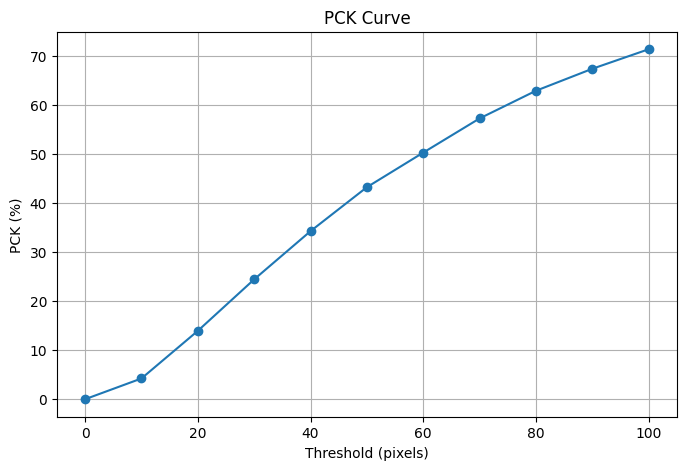

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# ✅ Leer CSV
csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_COMPRESSED_LOSSPHENO_untuned02.csv"
df = pd.read_csv(csv_path)

# ✅ Filtrar keypoints no anotados (gt_x o gt_y igual a 0)
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ a) Error Euclidiano Promedio, Mediana, Desviación Estándar
mean_error = df_filtered['euclidean_error'].mean()
median_error = df_filtered['euclidean_error'].median()
std_error = df_filtered['euclidean_error'].std()

print(f"\n📏 Mean Euclidean Error: {mean_error:.2f}")
print(f"📏 Median Euclidean Error: {median_error:.2f}")
print(f"📏 Std Dev of Error: {std_error:.2f}")

# ✅ b) PCK a diferentes umbrales
thresholds = np.arange(0, 101, 10)  # De 0 a 100 píxeles en pasos de 5
pck_values = []

print("\n🎯 PCK Metrics:")
for t in thresholds:
    pck = (df_filtered['euclidean_error'] <= t).mean() * 100
    pck_values.append(pck)
    print(f"PCK@{t}px: {pck:.2f}%")

# ✅ c) AUC del PCK
auc_pck = metrics.auc(thresholds, pck_values) / thresholds[-1]  # Normalizado de 0 a 1
print(f"\n📈 AUC of PCK curve: {auc_pck:.4f}")

# ✅ Graficar curva PCK
plt.figure(figsize=(8, 5))
plt.plot(thresholds, pck_values, marker='o')
plt.xlabel('Threshold (pixels)')
plt.ylabel('PCK (%)')
plt.title('PCK Curve')
plt.grid(True)
plt.show()



📊 Per-Keypoint Metrics:
    Keypoint  Mean Error (px)  Median Error (px)  Std Dev (px)    AUC PCK
0          0       133.588166          45.739406    558.716092  50.165289
1          1       127.014263          52.680720    406.910315  43.553719
2          2       127.043729          54.999535    249.904073  40.082645
3          3       116.572383          70.328833    164.655374  32.561983
4          4       107.658237          49.068702    372.860463  45.206612
5          5       107.634374          51.452630    367.387869  45.495868
6          6        90.425899          52.733242    201.414422  44.876033
7          7        94.712960          52.245476    231.314330  45.619835
8          8        90.533918          60.185481    162.075517  39.958333
9          9       114.195275          63.248482    404.603031  38.708333
10        10       112.784441          49.409258    373.678209  43.512397
11        11       112.611920          47.290724    379.188881  46.570248
12        12 

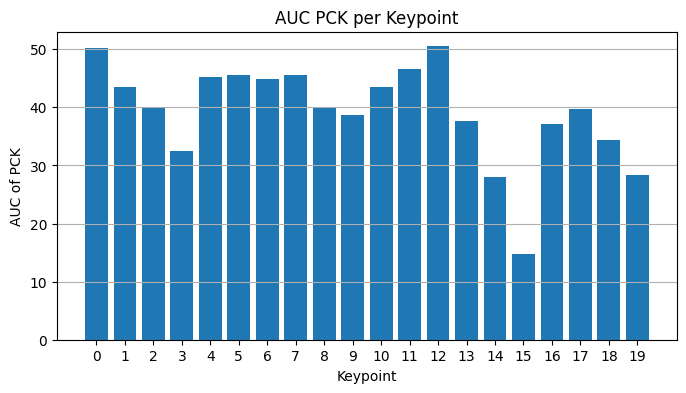

<Figure size 1000x500 with 0 Axes>

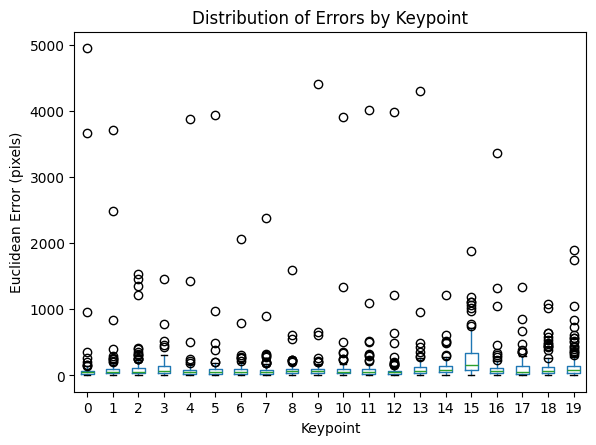

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# ✅ Load CSV
csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_COMPRESSED_LOSSPHENO_untuned02.csv"
df = pd.read_csv(csv_path)

# ✅ Filter unannotated keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Thresholds for PCK
thresholds = np.arange(0, 101, 10)

# ✅ Store per-keypoint metrics
keypoint_metrics = []

# ✅ Iterate over keypoints
for kp in sorted(df_filtered['keypoint'].unique()):
    kp_data = df_filtered[df_filtered['keypoint'] == kp]

    # Euclidean error metrics
    mean_error = kp_data['euclidean_error'].mean()
    median_error = kp_data['euclidean_error'].median()
    std_error = kp_data['euclidean_error'].std()

    # PCK metrics
    pck_values = [(kp_data['euclidean_error'] <= t).mean() * 100 for t in thresholds]
    auc_pck = metrics.auc(thresholds, pck_values) / thresholds[-1]

    # Save metrics
    keypoint_metrics.append({
        'Keypoint': kp,
        'Mean Error (px)': mean_error,
        'Median Error (px)': median_error,
        'Std Dev (px)': std_error,
        'AUC PCK': auc_pck
    })

# ✅ Create DataFrame
df_keypoint_metrics = pd.DataFrame(keypoint_metrics)

# ✅ Show table
print("\n📊 Per-Keypoint Metrics:")
print(df_keypoint_metrics)

# ✅ Save results
output_csv = '/data/Datasets/Fish/CavFish/keypoint_metrics_summary_COMPRESSED_LOSSPHENO02.csv'
df_keypoint_metrics.to_csv(output_csv, index=False)
print(f"\n✅ Metrics saved to: {output_csv}")

# ✅ Optional: LaTeX table (for papers)
latex_table = df_keypoint_metrics.to_latex(index=False, float_format="%.2f")
print("\n📄 LaTeX Table:\n")
print(latex_table)

# =====================
# ✅ Visualizations
# =====================

# ✅ AUC PCK bar plot
plt.figure(figsize=(8, 4))
plt.bar(df_keypoint_metrics['Keypoint'], df_keypoint_metrics['AUC PCK'])
plt.xlabel('Keypoint')
plt.ylabel('AUC of PCK')
plt.title('AUC PCK per Keypoint')
plt.xticks(df_keypoint_metrics['Keypoint'])
plt.grid(axis='y')
plt.show()

# ✅ Boxplot of Euclidean Errors
plt.figure(figsize=(10, 5))
df_filtered.boxplot(column='euclidean_error', by='keypoint', grid=False)
plt.xlabel('Keypoint')
plt.ylabel('Euclidean Error (pixels)')
plt.title('Distribution of Errors by Keypoint')
plt.suptitle('')
plt.show()

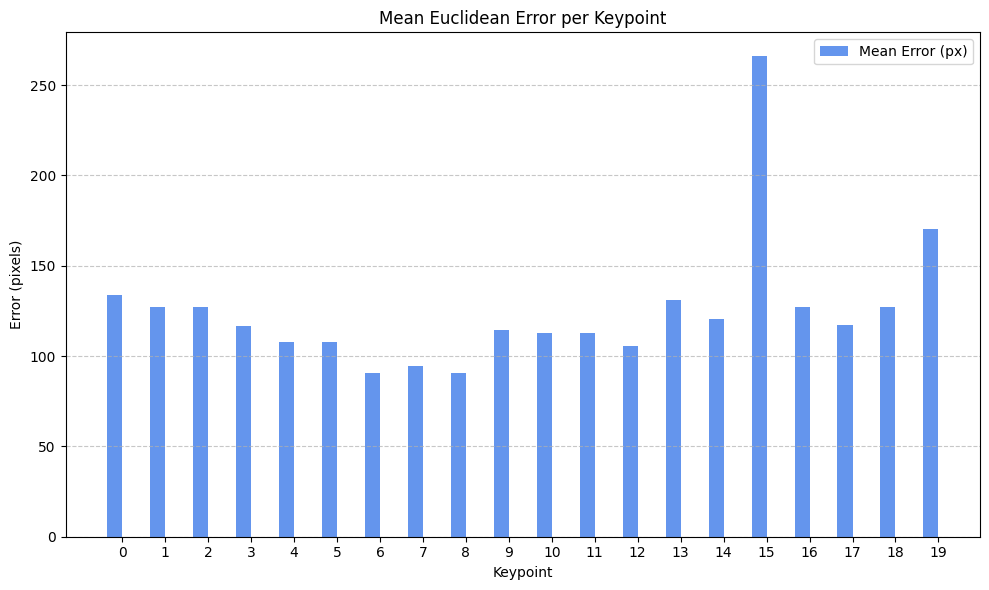

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

# ✅ Load your CSV
csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_COMPRESSED_LOSSPHENO_untuned02.csv"
df = pd.read_csv(csv_path)

# ✅ Filter invalid keypoints
df_filtered = df[(df['gt_x'] != 0) & (df['gt_y'] != 0)]

# ✅ Thresholds for PCK
thresholds = np.arange(0, 101, 10)

# ✅ Collect metrics
keypoint_metrics = []
for kp in sorted(df_filtered['keypoint'].unique()):
    kp_data = df_filtered[df_filtered['keypoint'] == kp]

    mean_error = kp_data['euclidean_error'].mean()
    median_error = kp_data['euclidean_error'].median()
    std_error = kp_data['euclidean_error'].std()

    pck_values = [(kp_data['euclidean_error'] <= t).mean() * 100 for t in thresholds]
    auc_pck = metrics.auc(thresholds, pck_values) / thresholds[-1]

    keypoint_metrics.append({
        'Keypoint': kp,
        'Mean Error (px)': mean_error,
        'Median Error (px)': median_error,
        'Std Dev (px)': std_error,
        'AUC PCK': auc_pck
    })

# ✅ Create dataframe
df_keypoint_metrics = pd.DataFrame(keypoint_metrics)

# ✅ Save summary

#df_keypoint_metrics.to_csv('/data/Datasets/Fish/CavFish/keypoint_metrics_summary.csv', index=False)

# ✅ Bar Plot 1: Mean vs Median
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df_keypoint_metrics['Keypoint']))
bar_width = 0.35

bars1 = ax.bar(x - bar_width / 2, df_keypoint_metrics['Mean Error (px)'],
               width=bar_width, label='Mean Error (px)', color='cornflowerblue')

# ✅ Create custom tick labels
tick_labels = []
for kp in df_keypoint_metrics['Keypoint']:
    if kp >= 50:
        tick_labels.append(kp + 1)  # Shift by +1 after 13
    else:
        tick_labels.append(kp)

ax.set_xlabel('Keypoint')
ax.set_ylabel('Error (pixels)')
ax.set_title('Mean Euclidean Error per Keypoint')
ax.set_xticks(x)
ax.set_xticklabels(tick_labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

### PMP

In [18]:
import pandas as pd
import numpy as np
from pathlib import Path

# --------------------------- Phenotype map (1-based) -----------------------------
phenotype_pairs_1based = {
    "SL":  (0, 1),     # Standard length (Snout ↔ Caudal fin base) if kp2 is base
    "PeDD": (3, 2),    # Pelvic–Dors    al fin origin distance
    "HD":  (4, 5),     # Head depth
    "CPD": (6, 7),     # Caudal peduncle depth
    "CFD": (8, 9),    # Caudal fin depth
    "ED":  (10, 11),   # Eye diameter
    "EyePelv": (12, 3),# Eye centroid ↔ Pelvic origin (custom)
    "SnPelv": (0, 3),  # Snout ↔ Pelvic origin (custom)
    "MaxJaw": (0, 13), # Maxillary jaw length (Snout ↔ Mouth corner)
    "PcL": (14, 15),   # Pectoral fin length
    "PcPeD": (14, 3),  # Pectoral–Pelvic fin origin distance
    "HL":  (0, 16),    # Head length (Snout ↔ Operculum posterior margin)
    "DFL": (2, 17),    # Dorsal fin length (dorsal anterior ↔ dorsal posterior)
    "AFL": (18, 19),   # Anal fin length (anal anterior ↔ anal posterior)
}

def _normalize_single(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize single combined CSV to ['image_id','keypoint_id','x_gt','y_gt','x_pred','y_pred'].
    Expects at least: ['keypoint','gt_x','gt_y','pred_x','pred_y'].
    If 'image_id' is missing but 'image' exists, build image_id by factorizing 'image'.
    Ensures one row per (image_id, keypoint_id) by keeping the last occurrence.
    """
    required = ["keypoint", "gt_x", "gt_y", "pred_x", "pred_y"]
    for c in required:
        if c not in df.columns:
            raise ValueError(f"Missing required column '{c}' in the CSV.")

    out = df.copy()

    # Build image_id robustly
    if "image_id" in out.columns:
        # trust existing image_id
        pass
    elif "image" in out.columns:
        # factorize image path/filename into stable ids
        out["image_id"] = pd.factorize(out["image"].astype(str).str.strip())[0]
    else:
        # last resort: every row is treated as same image (not recommended)
        raise ValueError("CSV missing 'image_id' and 'image' columns; cannot group by image.")

    # enforce numeric types
    out["keypoint"] = pd.to_numeric(out["keypoint"], errors="raise")
    for c in ["gt_x","gt_y","pred_x","pred_y"]:
        out[c] = pd.to_numeric(out[c], errors="raise")

    # rename to common schema
    out = out.rename(columns={"keypoint":"keypoint_id",
                              "gt_x":"x_gt","gt_y":"y_gt",
                              "pred_x":"x_pred","pred_y":"y_pred"})

    # keep ONE row per (image_id, keypoint_id). If duplicates exist, keep the last.
    out = (
        out.sort_index()
           .reset_index(drop=True)
    )

    return out[["image_id","keypoint_id","x_gt","y_gt","x_pred","y_pred"]]

def _compute_pheno_lengths_gt(gt_img_df: pd.DataFrame, pheno_pairs: dict) -> dict:
    """
    Compute phenotype lengths using GT coords for one image.
    gt_img_df columns: ['keypoint_id','x_gt','y_gt'] for a single image_id.
    Returns dict: pheno_name -> length (float)
    """
    idx = gt_img_df.set_index("keypoint_id")
    out = {}
    for name, (a, b) in pheno_pairs.items():
        if a in idx.index and b in idx.index:
            pa = idx.loc[a, ["x_gt","y_gt"]].values.astype(float)
            pb = idx.loc[b, ["x_gt","y_gt"]].values.astype(float)
            out[name] = float(np.linalg.norm(pa - pb))
    return out

def compute_pmp_single_df(df: pd.DataFrame,
                          phenotype_pairs: dict,
                          r: float = 0.1):
    """
    Compute PMP from a single combined dataframe.
    Returns (pmp_df, overall_mean, dj_table).

    Enhancements:
    - Tracks, for every (image_id, keypoint_id), the phenotype actually used
      for normalization (the shortest one involving that keypoint).
    - Aggregates per keypoint:
        * assoc_phenotype: most frequent phenotype chosen for that keypoint
        * mean_norm_len_px: mean of the chosen phenotype lengths used
        * threshold_10pct_px: r * mean_norm_len_px
    """
    M = _normalize_single(df)

    dj_rows = []
    # for per-kp aggregation of the phenotype actually used
    kp_normlens = {}   # keypoint_id -> list of norm_len values used
    kp_phnames  = {}   # keypoint_id -> list of phenotype names chosen

    for img_id, Mi in M.groupby("image_id", sort=False):
        # phenotype lengths (GT) for this image
        ph_len = _compute_pheno_lengths_gt(Mi[["keypoint_id","x_gt","y_gt"]], phenotype_pairs)

        # distances (pixel error per kp)
        pixel_err = np.sqrt(((Mi[["x_gt","y_gt"]].to_numpy(float) -
                              Mi[["x_pred","y_pred"]].to_numpy(float)) ** 2).sum(axis=1))

        # choose shortest phenotype involving each keypoint
        norm_len_list = []
        norm_phname_list = []
        for kp in Mi["keypoint_id"].astype(int).tolist():
            # collect candidates for this kp
            candidates = []
            for name, (a, b) in phenotype_pairs.items():
                if kp in (a, b) and name in ph_len and ph_len[name] > 0:
                    candidates.append((name, ph_len[name]))

            if candidates:
                # shortest phenotype for this kp on this image
                phname, plen = min(candidates, key=lambda t: t[1])
                norm_len_list.append(plen)
                norm_phname_list.append(phname)

                # record for per-kp aggregation
                kp_normlens.setdefault(kp, []).append(plen)
                kp_phnames.setdefault(kp, []).append(phname)
            else:
                norm_len_list.append(np.nan)
                norm_phname_list.append(None)

        tmp = Mi[["image_id","keypoint_id"]].copy()
        tmp["pixel_err"]   = pixel_err
        tmp["norm_len"]    = norm_len_list
        tmp["norm_pheno"]  = norm_phname_list
        tmp = tmp.dropna(subset=["norm_len"]).copy()

        tmp["d_jn"]    = tmp["pixel_err"] / tmp["norm_len"]
        tmp["correct"] = (tmp["d_jn"] < r).astype(int)

        dj_rows.append(tmp)

    if not dj_rows:
        raise ValueError("No evaluable rows. Make sure each keypoint appears in ≥1 phenotype pair.")

    # Debug-level table (per (image,kp))
    D = pd.concat(dj_rows, ignore_index=True)

    # Per-kp PMP
    pmp = D.groupby("keypoint_id")["correct"].mean().reset_index()
    pmp["pmp"] = pmp["correct"] * 100.0
    pmp = pmp.drop(columns=["correct"]).sort_values("keypoint_id").reset_index(drop=True)

    # Per-kp phenotype association stats
    assoc_rows = []
    for kp in sorted(set(D["keypoint_id"].astype(int))):
        ph_list = kp_phnames.get(kp, [])
        ln_list = kp_normlens.get(kp, [])
        if not ph_list or not ln_list:
            continue

        # most frequent phenotype chosen for this kp
        counts = pd.Series(ph_list).value_counts()
        assoc_ph = counts.index[0]

        mean_norm = float(np.mean(ln_list))
        assoc_rows.append({
            "keypoint_id": kp,
            "assoc_phenotype": assoc_ph,
            "mean_norm_len_px": mean_norm,
            "threshold_10pct_px": mean_norm * r
        })

    assoc_df = pd.DataFrame(assoc_rows)

    # Merge into pmp report
    if not assoc_df.empty:
        pmp = pmp.merge(assoc_df, on="keypoint_id", how="left")

    overall = float(pmp["pmp"].mean()) if len(pmp) else float("nan")
    return pmp, overall, D


def run_pmp_single(csv_path: str,
                   model,
                   phenotype_pairs: dict = None,
                   r: float = 0.1,
                   out_dir: str = "/mnt/data"):
    """
    Load a single CSV (combined GT+Pred), compute PMP, and save reports.

    Adds:
    - assoc phenotype + mean_norm_len_px + threshold_10pct_px to the pmp report
    - keeps debug sample (first 100 rows)
    - writes overall mean PMP to a txt
    """
    if phenotype_pairs is None:
        phenotype_pairs = phenotype_pairs_1based

    # keep your existing fixed directory (as in your current code)
    out_dir = Path("/data/Datasets/Fish/CavFish/Predictions/PMP")
    out_dir.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv(csv_path)
    pmp_df, overall, dj_table = compute_pmp_single_df(df, phenotype_pairs, r=r)

    # Save files
    pmp_path = out_dir / f"{model}_pmp_report.csv"
    overall_path = out_dir / f"{model}_pmp_overall.txt"
    debug_path = out_dir / f"{model}_pmp_debug_sample.csv"

    pmp_df.to_csv(pmp_path, index=False)
    dj_table.head(100).to_csv(debug_path, index=False)
    with open(overall_path, "w") as f:
        f.write(f"{overall:.4f}\n")

    return {
        "pmp_report": str(pmp_path),
        "overall_file": str(overall_path),
        "debug_sample": str(debug_path),
        "overall_mean_pct": overall,
    }

In [19]:
import os
import json
import pandas as pd

# ---- paths you set ----
json_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_COMPRESSED_LOSSPHENO_untuned02.csv"
out_csv   = '/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_compressed_COMPRESSED_LOSSPHENO_augmentedresolution02.csv'
target_labels = {'Compressed body'}


# ---- helpers ----
def canonize_path(p: str) -> str:
    # normalize case & slashes; strip whitespace
    p = (p or "").strip().replace("\\", "/")
    # remove leading "./"
    if p.startswith("./"):
        p = p[2:]
    return p

# ---- 1) gather names from JSON for target classes ----
with open(json_path, "r") as f:
    val = json.load(f)

json_relpaths = {
    canonize_path(img["file_name"])
    for img in val.get("images", [])
    if img.get("label") in target_labels
}

# also keep a basename set in case your CSV stores only filenames
json_basenames = {os.path.basename(p) for p in json_relpaths}

print(f"Found {len(json_relpaths)} images labeled {target_labels} in JSON.")

# ---- 2) load CSV and filter by name match ----
df = pd.read_csv(csv_path)

if "image" not in df.columns:
    raise ValueError("CSV must have a column named 'image'.")

# Build two keys to be flexible: relative-path key and basename key
csv_rel = df["image"].astype(str).map(canonize_path)
csv_base = csv_rel.map(os.path.basename)

mask = csv_rel.isin(json_relpaths) | csv_base.isin(json_basenames)
df_filtered = df[mask].copy()

print(f"Rows before: {len(df)} | after filter: {len(df_filtered)}")

# ---- 3) save ----
df_filtered.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")


Found 121 images labeled {'Compressed body'} in JSON.
Rows before: 2420 | after filter: 2420
Saved: /data/Datasets/Fish/CavFish/Predictions/augmented/predictions_compressed_COMPRESSED_LOSSPHENO_augmentedresolution02.csv


In [20]:
results = run_pmp_single("/data/Datasets/Fish/CavFish/Predictions/augmented/predictions_compressed_COMPRESSED_LOSSPHENO_augmentedresolution02.csv", "compressed_COMPRESSED_LOSSPHENO_augmentedresolution02", r=0.1)
results


{'pmp_report': '/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_COMPRESSED_LOSSPHENO_augmentedresolution02_pmp_report.csv',
 'overall_file': '/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_COMPRESSED_LOSSPHENO_augmentedresolution02_pmp_overall.txt',
 'debug_sample': '/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_COMPRESSED_LOSSPHENO_augmentedresolution02_pmp_debug_sample.csv',
 'overall_mean_pct': 43.84676308539946}

In [ ]:

import pandas as pd

# Leer el CSV (por defecto, las cadenas NO se convierten en factores/categorías)
pmp_report__1 = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_COMPRESSED_LOSSPHENO_augmentedresolution02_pmp_report.csv")

pmp_report__1

keypoint_id        pmp assoc_phenotype  mean_norm_len_px  \
0             0  24.793388          MaxJaw        294.058149   
1             1  96.694215              SL       3160.503730   
2             2  47.933884             DFL        632.308515   
3             3  41.322314           PcPeD        675.275817   
4             6  29.752066             CPD        343.103504   
5             7  28.099174             CPD        343.103504   
6             8  74.166667             CFD        866.741986   
7             9  70.000000             CFD        866.741986   
8            10  18.181818              ED        262.294990   
9            11  24.793388              ED        262.294990   
10           12  87.603306         EyePelv       1235.765643   
11           13  13.223140          MaxJaw        301.537599   
12           14  23.140496             PcL        542.894398   
13           15  10.833333             PcL        599.965971   
14           16  61.157025              HL        822.509475   
15           17  52.892562             DFL        672.208730   
16           18  30.833333             AFL        572.759052   
17           19  23.333333             AFL        572.759052   

    threshold_10pct_px  
0            29.405815  
1           316.050373  
2            63.230852  
3            67.527582  
4            34.310350  
5            34.310350  
6            86.674199  
7            86.674199  
8            26.229499  
9            26.229499  
10          123.576564  
11           30.153760  
12           54.289440  
13           59.996597  
14           82.250947  
15           67.220873  
16           57.275905  
17           57.275905

## LOSSPHENO AND LOG(MSE)

In [2]:
# Se extrae la ruta de la imagen. Final
import os
import json
import subprocess

# Configuración de rutas
json_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
dataset_root = '/data/Datasets/Fish/CavFish'
output_folder = '/data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_LOSSPHENO_LOG(MSE)'
config_path = 'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_ViTPose-fish9_8xb32-100etrain_loss_logMSE.py'
checkpoint_path = '/data/Pupils/Josue/weights/Fish//ViTPose_20kpt_Losspheno_Base_log(MSE)/epoch_300.pth'
merged_json_path = os.path.join(output_folder, 'all_keypoints_predicted_compressed_ViTPose_loss_logMSE.json')

# Clase(s) objetivo a filtrar
target_labels = ['Compressed body']

# Crear carpeta de salida si no existe
os.makedirs(output_folder, exist_ok=True)

# Leer el archivo JSON de validación
with open(json_path, 'r') as f:
    val_data = json.load(f)

# Almacenar todas las predicciones
all_predictions = []

# Recorrer cada imagen del archivo de validación
for image_info in val_data['images']:
    # Filtrar por clase (label)
    if image_info.get('label') not in target_labels:
        continue

    relative_path = image_info['file_name']  # ej: "2018 Guayavero Duda/IMG_0084-Edit.jpg"
    full_path = os.path.join(dataset_root, relative_path)

    # Nombre de imagen para guardar outputs
    img_name = os.path.basename(relative_path)
    out_base = os.path.join(output_folder, img_name)
    out_json = out_base.replace('.jpg', '_keypoints.json').replace('.png', '_keypoints.json')

    # Verificación de existencia de imagen
    if not os.path.exists(full_path):
        print(f"⚠️ Imagen no encontrada: {full_path}")
        continue

    # Ejecutar la inferencia
    cmd = [
        "python", "demo/image_demo.py",
        full_path,
        config_path,
        checkpoint_path,
        "--out-file", out_base,
        "--draw-heatmap",
        "--show-kpt-idx"
    ]

    print(f"🔁 Procesando {relative_path}...")
    subprocess.run(cmd)

    # Leer predicción y asociarla a la ruta relativa original (no solo nombre)
    if os.path.exists(out_json):
        with open(out_json, 'r') as f:
            pred = json.load(f)

        # Normalizar output para que coincida con GT
        pred["image"] = relative_path  # Sobrescribe con la ruta relativa del GT
        all_predictions.append(pred)
    else:
        print(f"⚠️ No se encontró JSON de salida para {img_name}")

# Guardar todas las predicciones en un solo archivo
with open(merged_json_path, 'w') as f:
    json.dump(all_predictions, f, indent=4)

print(f"\n✅ JSON consolidado guardado en: {merged_json_path}")

🔁 Procesando 2018 Guayavero Duda/IMG_0084-Edit.jpg...
Loads checkpoint by local backend from path: /data/Pupils/Josue/weights/Fish//ViTPose_20kpt_Losspheno_Base_log(MSE)/epoch_300.pth


✅ DEBUG: Patched model.dataset_meta keys = dict_keys(['dataset_name', 'num_keypoints', 'keypoint_names', 'keypoint_id2name', 'keypoint_name2id', 'skeleton', 'keypoint_colors', 'skeleton_links_color', 'flip_pairs', 'flip_indices', 'upper_body_ids', 'lower_body_ids', 'dataset_keypoint_weights', 'sigmas', 'CLASSES']) 


📍 Coordenadas predichas:
 - 0: x=303.2, y=1796.7, score=0.962

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_LOSSPHENO_LOG(MSE)/IMG_0084-Edit_keypoints.json
 - 1: x=4178.3, y=1970.6, score=0.943

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_LOSSPHENO_LOG(MSE)/IMG_0084-Edit_keypoints.json
 - 2: x=1628.9, y=1439.2, score=0.996

📝 Coordenadas guardadas en JSON: /data/Datasets/Fish

In [3]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Rutas#

pred_file = Path("/data/Datasets/Fish/CavFish/inference_compressed_ViTPose_nonaugmented_LOSSPHENO_LOG(MSE)/all_keypoints_predicted_compressed_ViTPose_loss_logMSE.json")
gt_file = Path("/data/Datasets/Fish/CavFish/fish20kpt_all_val.json")

# Cargar archivos
with pred_file.open("r") as f:
    pred_data = json.load(f)

with gt_file.open("r") as f:
    gt_data = json.load(f)

# Crear índice de anotaciones por imagen
image_id_to_name = {img['id']: img['file_name'] for img in gt_data['images']}
annotations_by_name = {
    image_id_to_name[ann['image_id']]: np.array(ann['keypoints']).reshape(-1, 3)[:, :2]
    for ann in gt_data['annotations']
}

# Comparación punto a punto
rows = []
gt_all = []
pred_all = []

for item in pred_data:
    name = item["image"]
    pred_kpts = {kp["name"]: (kp["x"], kp["y"]) for kp in item["keypoints"]}
    gt_kpts = annotations_by_name.get(name)

    if gt_kpts is None:
        print(f"⚠️ Imagen {name} no encontrada en GT.")
        continue

    for idx, (gt_xy, (kpt_name, pred_xy)) in enumerate(zip(gt_kpts, pred_kpts.items())):
        error = np.linalg.norm(np.array(pred_xy) - np.array(gt_xy))
        rows.append({
            "image": name,
            "keypoint": kpt_name,
            "gt_x": gt_xy[0],
            "gt_y": gt_xy[1],
            "pred_x": pred_xy[0],
            "pred_y": pred_xy[1],
            "euclidean_error": error
        })
        gt_all.extend(gt_xy)
        pred_all.extend(pred_xy)

df = pd.DataFrame(rows)

# --- 1. Métricas globales por keypoint ---
trait_metrics = []
for kpt in df["keypoint"].unique():
    sub = df[df["keypoint"] == kpt]
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    trait_metrics.append({
        "keypoint": kpt,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy)
    })
df_trait = pd.DataFrame(trait_metrics)
df_trait.to_csv("/data/Datasets/Fish/CavFish/metrics_per_keypoint_COMPRESSED_LOSSPHENO_LOG(MSE).csv", index=False)

# --- 2. Métricas por imagen ---
image_metrics = []
for img in df["image"].unique():
    sub = df[df["image"] == img]
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    image_metrics.append({
        "image": img,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy)
    })
df_image = pd.DataFrame(image_metrics)
df_image.to_csv("/data/Datasets/Fish/CavFish/metrics20_per_image_COMPRESSED_LOSSPHENO_LOG(MSE).csv", index=False)

# --- 3. Métricas por keypoint e imagen ---
trait_image_metrics = []
for (img, kpt), sub in df.groupby(["image", "keypoint"]):
    gt_xy = sub[["gt_x", "gt_y"]].values
    pred_xy = sub[["pred_x", "pred_y"]].values
    trait_image_metrics.append({
        "image": img,
        "keypoint": kpt,
        "MAE": mean_absolute_error(gt_xy, pred_xy),
        "RMSE": np.sqrt(mean_squared_error(gt_xy, pred_xy)),
        "R2": r2_score(gt_xy, pred_xy) if len(gt_xy) > 1 else None
    })
df_trait_image = pd.DataFrame(trait_image_metrics)
df_trait_image.to_csv("/data/Datasets/Fish/CavFish/metrics_per_image_keypoint20_COMPRESSED_LOSSPHENO_LOG(MSE).csv", index=False)

print("✅ ¡Listo! Se guardaron los tres archivos CSV:")
print("- metrics_per_keypoint.csv")
print("- metrics_per_image.csv")
print("- metrics_per_keypoint_image.csv")

✅ ¡Listo! Se guardaron los tres archivos CSV:
- metrics_per_keypoint.csv
- metrics_per_image.csv
- metrics_per_keypoint_image.csv


In [4]:
df = pd.DataFrame(rows)

# Exportar datos individuales de puntos
df.to_csv("/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_COMPRESSED_LOSSPHENO_LOG(MSE).csv", index=False)

In [5]:
df

image keypoint    gt_x    gt_y  \
0     2018 Guayavero Duda/IMG_0084-Edit.jpg        0   348.2  1755.0   
1     2018 Guayavero Duda/IMG_0084-Edit.jpg        1  4233.7  1981.7   
2     2018 Guayavero Duda/IMG_0084-Edit.jpg        2  1580.3  1440.7   
3     2018 Guayavero Duda/IMG_0084-Edit.jpg        3  2373.6  2434.5   
4     2018 Guayavero Duda/IMG_0084-Edit.jpg        4   730.6  1516.1   
...                                     ...      ...     ...     ...   
2415      2018 Yungillo/IMG_1771-Editar.jpg       15  1109.2  2313.9   
2416      2018 Yungillo/IMG_1771-Editar.jpg       16   945.4  1516.8   
2417      2018 Yungillo/IMG_1771-Editar.jpg       17  2954.2   473.9   
2418      2018 Yungillo/IMG_1771-Editar.jpg       18  2644.3  2054.0   
2419      2018 Yungillo/IMG_1771-Editar.jpg       19  3109.7  2372.5   

           pred_x       pred_y  euclidean_error  
0      303.150819  1796.740072        61.413861  
1     4178.298977  1970.568226        56.508316  
2     1628.932704  1439.214437        48.655389  
3     2288.049564  2396.987526        93.413398  
4      676.987300  1531.068976        55.663200  
...           ...          ...              ...  
2415  1143.826229  2239.735997        81.849100  
2416   970.979738  1591.127627        78.606102  
2417  2971.347397   479.443406        18.021170  
2418  2650.963337  2055.418370         6.812623  
2419  3115.238259  2371.041335         5.727129  

[2420 rows x 7 columns]

In [6]:
import pandas as pd

# Leer el CSV (por defecto, las cadenas NO se convierten en factores/categorías)
pmp_LOG_MSE = pd.read_csv("/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_COMPRESSED_LOSSPHENO_LOG(MSE).csv")

pmp_LOG_MSE.head(30)

image  keypoint     gt_x     gt_y  \
0   2018 Guayavero Duda/IMG_0084-Edit.jpg         0   348.20  1755.00   
1   2018 Guayavero Duda/IMG_0084-Edit.jpg         1  4233.70  1981.70   
2   2018 Guayavero Duda/IMG_0084-Edit.jpg         2  1580.30  1440.70   
3   2018 Guayavero Duda/IMG_0084-Edit.jpg         3  2373.60  2434.50   
4   2018 Guayavero Duda/IMG_0084-Edit.jpg         4   730.60  1516.10   
5   2018 Guayavero Duda/IMG_0084-Edit.jpg         5   697.50  2245.30   
6   2018 Guayavero Duda/IMG_0084-Edit.jpg         6  4191.60  1709.20   
7   2018 Guayavero Duda/IMG_0084-Edit.jpg         7  4150.90  2214.10   
8   2018 Guayavero Duda/IMG_0084-Edit.jpg         8  5289.80  1575.40   
9   2018 Guayavero Duda/IMG_0084-Edit.jpg         9  5105.50  2301.70   
10  2018 Guayavero Duda/IMG_0084-Edit.jpg        10   725.20  1829.50   
11  2018 Guayavero Duda/IMG_0084-Edit.jpg        11   710.00  2115.90   
12  2018 Guayavero Duda/IMG_0084-Edit.jpg        12   717.20  1979.40   
13  2018 Guayavero Duda/IMG_0084-Edit.jpg        13   531.09  2154.22   
14  2018 Guayavero Duda/IMG_0084-Edit.jpg        14  1083.40  2375.90   
15  2018 Guayavero Duda/IMG_0084-Edit.jpg        15  1624.10  3085.70   
16  2018 Guayavero Duda/IMG_0084-Edit.jpg        16  1368.40  2067.50   
17  2018 Guayavero Duda/IMG_0084-Edit.jpg        17  2253.40   798.50   
18  2018 Guayavero Duda/IMG_0084-Edit.jpg        18  3061.30  2292.60   
19  2018 Guayavero Duda/IMG_0084-Edit.jpg        19  3400.80  2267.00   
20  2018 Guayavero Duda/IMG_0718-Edit.jpg         0   141.10  1782.90   
21  2018 Guayavero Duda/IMG_0718-Edit.jpg         1  5254.60  2305.10   
22  2018 Guayavero Duda/IMG_0718-Edit.jpg         2  1989.30  1685.40   
23  2018 Guayavero Duda/IMG_0718-Edit.jpg         3  1979.20  2157.90   
24  2018 Guayavero Duda/IMG_0718-Edit.jpg         4   779.00  1545.10   
25  2018 Guayavero Duda/IMG_0718-Edit.jpg         5   741.20  1817.40   
26  2018 Guayavero Duda/IMG_0718-Edit.jpg         6  5095.40  2170.60   
27  2018 Guayavero Duda/IMG_0718-Edit.jpg         7  5065.90  2236.70   
28  2018 Guayavero Duda/IMG_0718-Edit.jpg         8  5358.90  2319.70   
29  2018 Guayavero Duda/IMG_0718-Edit.jpg         9  5305.60  2394.30   

         pred_x       pred_y  euclidean_error  
0    303.150819  1796.740072        61.413861  
1   4178.298977  1970.568226        56.508316  
2   1628.932704  1439.214437        48.655389  
3   2288.049564  2396.987526        93.413398  
4    676.987300  1531.068976        55.663200  
5    654.097351  2238.234503        43.973983  
6   3986.593833  1699.927952       205.215739  
7   3951.354207  2176.054211       203.140359  
8   5279.423144  1609.743059        35.876523  
9   5141.211571  2252.322260        60.938309  
10   674.899759  1827.999474        50.322618  
11   666.168754  2115.028065        43.839918  
12   675.983431  1979.156395        41.217289  
13   473.159747  2116.616257        69.064865  
14  1104.637470  2363.261068        24.713817  
15  1637.963773  3078.996541        15.399369  
16  1226.163981  2119.138259       151.319513  
17  2217.167265   823.564659        44.057329  
18  3158.736448  2280.492251        98.185839  
19  3505.562789  2292.116542       107.731530  
20   204.559503  1741.422529        75.812197  
21  5234.220335  2281.335496        31.306268  
22  2147.159343  1704.503395       159.011044  
23  2129.767285  2157.559716       150.567669  
24   662.814615  1568.389576       118.496616  
25   635.842018  1832.787798       106.475766  
26  5172.314421  2213.083514        87.867384  
27  5139.710418  2277.329671        84.254068  
28  5358.461856  2313.816691         5.899601  
29  5311.832286  2397.879918         7.187294

## PMP

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

# --------------------------- Phenotype map (1-based) -----------------------------
phenotype_pairs_1based = {
    "SL":  (0, 1),     # Standard length (Snout ↔ Caudal fin base) if kp2 is base
    "PeDD": (3, 2),    # Pelvic–Dors    al fin origin distance
    "HD":  (4, 5),     # Head depth
    "CPD": (6, 7),     # Caudal peduncle depth
    "CFD": (8, 9),    # Caudal fin depth
    "ED":  (10, 11),   # Eye diameter
    "EyePelv": (12, 3),# Eye centroid ↔ Pelvic origin (custom)
    "SnPelv": (0, 3),  # Snout ↔ Pelvic origin (custom)
    "MaxJaw": (0, 13), # Maxillary jaw length (Snout ↔ Mouth corner)
    "PcL": (14, 15),   # Pectoral fin length
    "PcPeD": (14, 3),  # Pectoral–Pelvic fin origin distance
    "HL":  (0, 16),    # Head length (Snout ↔ Operculum posterior margin)
    "DFL": (2, 17),    # Dorsal fin length (dorsal anterior ↔ dorsal posterior)
    "AFL": (18, 19),   # Anal fin length (anal anterior ↔ anal posterior)
}

def _normalize_single(df: pd.DataFrame) -> pd.DataFrame:
    """
    Normalize single combined CSV to ['image_id','keypoint_id','x_gt','y_gt','x_pred','y_pred'].
    Expects at least: ['keypoint','gt_x','gt_y','pred_x','pred_y'].
    If 'image_id' is missing but 'image' exists, build image_id by factorizing 'image'.
    Ensures one row per (image_id, keypoint_id) by keeping the last occurrence.
    """
    required = ["keypoint", "gt_x", "gt_y", "pred_x", "pred_y"]
    for c in required:
        if c not in df.columns:
            raise ValueError(f"Missing required column '{c}' in the CSV.")

    out = df.copy()

    # Build image_id robustly
    if "image_id" in out.columns:
        # trust existing image_id
        pass
    elif "image" in out.columns:
        # factorize image path/filename into stable ids
        out["image_id"] = pd.factorize(out["image"].astype(str).str.strip())[0]
    else:
        # last resort: every row is treated as same image (not recommended)
        raise ValueError("CSV missing 'image_id' and 'image' columns; cannot group by image.")

    # enforce numeric types
    out["keypoint"] = pd.to_numeric(out["keypoint"], errors="raise")
    for c in ["gt_x","gt_y","pred_x","pred_y"]:
        out[c] = pd.to_numeric(out[c], errors="raise")

    # rename to common schema
    out = out.rename(columns={"keypoint":"keypoint_id",
                              "gt_x":"x_gt","gt_y":"y_gt",
                              "pred_x":"x_pred","pred_y":"y_pred"})

    # keep ONE row per (image_id, keypoint_id). If duplicates exist, keep the last.
    out = (
        out.sort_index()
           .reset_index(drop=True)
    )

    return out[["image_id","keypoint_id","x_gt","y_gt","x_pred","y_pred"]]

def _compute_pheno_lengths_gt(gt_img_df: pd.DataFrame, pheno_pairs: dict) -> dict:
    """
    Compute phenotype lengths using GT coords for one image.
    gt_img_df columns: ['keypoint_id','x_gt','y_gt'] for a single image_id.
    Returns dict: pheno_name -> length (float)
    """
    idx = gt_img_df.set_index("keypoint_id")
    out = {}
    for name, (a, b) in pheno_pairs.items():
        if a in idx.index and b in idx.index:
            pa = idx.loc[a, ["x_gt","y_gt"]].values.astype(float)
            pb = idx.loc[b, ["x_gt","y_gt"]].values.astype(float)
            out[name] = float(np.linalg.norm(pa - pb))
    return out

def compute_pmp_single_df(df: pd.DataFrame,
                          phenotype_pairs: dict,
                          r: float = 0.1):
    """
    Compute PMP from a single combined dataframe.
    Returns (pmp_df, overall_mean, dj_table).

    Enhancements:
    - Tracks, for every (image_id, keypoint_id), the phenotype actually used
      for normalization (the shortest one involving that keypoint).
    - Aggregates per keypoint:
        * assoc_phenotype: most frequent phenotype chosen for that keypoint
        * mean_norm_len_px: mean of the chosen phenotype lengths used
        * threshold_10pct_px: r * mean_norm_len_px
    """
    M = _normalize_single(df)

    dj_rows = []
    # for per-kp aggregation of the phenotype actually used
    kp_normlens = {}   # keypoint_id -> list of norm_len values used
    kp_phnames  = {}   # keypoint_id -> list of phenotype names chosen

    for img_id, Mi in M.groupby("image_id", sort=False):
        # phenotype lengths (GT) for this image
        ph_len = _compute_pheno_lengths_gt(Mi[["keypoint_id","x_gt","y_gt"]], phenotype_pairs)

        # distances (pixel error per kp)
        pixel_err = np.sqrt(((Mi[["x_gt","y_gt"]].to_numpy(float) -
                              Mi[["x_pred","y_pred"]].to_numpy(float)) ** 2).sum(axis=1))

        # choose shortest phenotype involving each keypoint
        norm_len_list = []
        norm_phname_list = []
        for kp in Mi["keypoint_id"].astype(int).tolist():
            # collect candidates for this kp
            candidates = []
            for name, (a, b) in phenotype_pairs.items():
                if kp in (a, b) and name in ph_len and ph_len[name] > 0:
                    candidates.append((name, ph_len[name]))

            if candidates:
                # shortest phenotype for this kp on this image
                phname, plen = min(candidates, key=lambda t: t[1])
                norm_len_list.append(plen)
                norm_phname_list.append(phname)

                # record for per-kp aggregation
                kp_normlens.setdefault(kp, []).append(plen)
                kp_phnames.setdefault(kp, []).append(phname)
            else:
                norm_len_list.append(np.nan)
                norm_phname_list.append(None)

        tmp = Mi[["image_id","keypoint_id"]].copy()
        tmp["pixel_err"]   = pixel_err
        tmp["norm_len"]    = norm_len_list
        tmp["norm_pheno"]  = norm_phname_list
        tmp = tmp.dropna(subset=["norm_len"]).copy()

        tmp["d_jn"]    = tmp["pixel_err"] / tmp["norm_len"]
        tmp["correct"] = (tmp["d_jn"] < r).astype(int)

        dj_rows.append(tmp)

    if not dj_rows:
        raise ValueError("No evaluable rows. Make sure each keypoint appears in ≥1 phenotype pair.")

    # Debug-level table (per (image,kp))
    D = pd.concat(dj_rows, ignore_index=True)

    # Per-kp PMP
    pmp = D.groupby("keypoint_id")["correct"].mean().reset_index()
    pmp["pmp"] = pmp["correct"] * 100.0
    pmp = pmp.drop(columns=["correct"]).sort_values("keypoint_id").reset_index(drop=True)

    # Per-kp phenotype association stats
    assoc_rows = []
    for kp in sorted(set(D["keypoint_id"].astype(int))):
        ph_list = kp_phnames.get(kp, [])
        ln_list = kp_normlens.get(kp, [])
        if not ph_list or not ln_list:
            continue

        # most frequent phenotype chosen for this kp
        counts = pd.Series(ph_list).value_counts()
        assoc_ph = counts.index[0]

        mean_norm = float(np.mean(ln_list))
        assoc_rows.append({
            "keypoint_id": kp,
            "assoc_phenotype": assoc_ph,
            "mean_norm_len_px": mean_norm,
            "threshold_10pct_px": mean_norm * r
        })

    assoc_df = pd.DataFrame(assoc_rows)

    # Merge into pmp report
    if not assoc_df.empty:
        pmp = pmp.merge(assoc_df, on="keypoint_id", how="left")

    overall = float(pmp["pmp"].mean()) if len(pmp) else float("nan")
    return pmp, overall, D


def run_pmp_single(csv_path: str,
                   model,
                   phenotype_pairs: dict = None,
                   r: float = 0.1,
                   out_dir: str = "/mnt/data"):
    """
    Load a single CSV (combined GT+Pred), compute PMP, and save reports.

    Adds:
    - assoc phenotype + mean_norm_len_px + threshold_10pct_px to the pmp report
    - keeps debug sample (first 100 rows)
    - writes overall mean PMP to a txt
    """
    if phenotype_pairs is None:
        phenotype_pairs = phenotype_pairs_1based

    # keep your existing fixed directory (as in your current code)
    out_dir = Path("/data/Datasets/Fish/CavFish/Predictions/PMP")
    out_dir.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv(csv_path)
    pmp_df, overall, dj_table = compute_pmp_single_df(df, phenotype_pairs, r=r)

    # Save files
    pmp_path = out_dir / f"{model}_pmp_report.csv"
    overall_path = out_dir / f"{model}_pmp_overall.txt"
    debug_path = out_dir / f"{model}_pmp_debug_sample.csv"

    pmp_df.to_csv(pmp_path, index=False)
    dj_table.head(100).to_csv(debug_path, index=False)
    with open(overall_path, "w") as f:
        f.write(f"{overall:.4f}\n")

    return {
        "pmp_report": str(pmp_path),
        "overall_file": str(overall_path),
        "debug_sample": str(debug_path),
        "overall_mean_pct": overall,
    }

In [10]:
import os
import json
import pandas as pd

# ---- paths you set ----
json_path = '/data/Datasets/Fish/CavFish/fish20kpt_all_val.json'
csv_path = "/data/Datasets/Fish/CavFish/keypoints_predictions_gt_vs_pred_COMPRESSED_LOSSPHENO_LOG(MSE).csv"
out_csv   = '/data/Datasets/Fish/CavFish/Predictions/LOG(MSE)/predictions_compressed_COMPRESSED_LOSSPHENO_LOG(MSE).csv'
target_labels = {'Compressed body'}


# ---- helpers ----
def canonize_path(p: str) -> str:
    # normalize case & slashes; strip whitespace
    p = (p or "").strip().replace("\\", "/")
    # remove leading "./"
    if p.startswith("./"):
        p = p[2:]
    return p

# ---- 1) gather names from JSON for target classes ----
with open(json_path, "r") as f:
    val = json.load(f)

json_relpaths = {
    canonize_path(img["file_name"])
    for img in val.get("images", [])
    if img.get("label") in target_labels
}

# also keep a basename set in case your CSV stores only filenames
json_basenames = {os.path.basename(p) for p in json_relpaths}

print(f"Found {len(json_relpaths)} images labeled {target_labels} in JSON.")

# ---- 2) load CSV and filter by name match ----
df = pd.read_csv(csv_path)

if "image" not in df.columns:
    raise ValueError("CSV must have a column named 'image'.")

# Build two keys to be flexible: relative-path key and basename key
csv_rel = df["image"].astype(str).map(canonize_path)
csv_base = csv_rel.map(os.path.basename)

mask = csv_rel.isin(json_relpaths) | csv_base.isin(json_basenames)
df_filtered = df[mask].copy()

print(f"Rows before: {len(df)} | after filter: {len(df_filtered)}")

# ---- 3) save ----
df_filtered.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")


Found 121 images labeled {'Compressed body'} in JSON.
Rows before: 2420 | after filter: 2420
Saved: /data/Datasets/Fish/CavFish/Predictions/LOG(MSE)/predictions_compressed_COMPRESSED_LOSSPHENO_LOG(MSE).csv


In [8]:
results = run_pmp_single("/data/Datasets/Fish/CavFish/Predictions/LOG(MSE)/predictions_compressed_COMPRESSED_LOSSPHENO_LOG(MSE).csv", "compressed_LOSSPHENO__LOG(MSE)", r=0.1)
results


{'pmp_report': '/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_LOSSPHENO__LOG(MSE)_pmp_report.csv',
 'overall_file': '/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_LOSSPHENO__LOG(MSE)_pmp_overall.txt',
 'debug_sample': '/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_LOSSPHENO__LOG(MSE)_pmp_debug_sample.csv',
 'overall_mean_pct': 69.60881542699725}

In [9]:
import pandas as pd

# Leer el CSV (por defecto, las cadenas NO se convierten en factores/categorías)
pmp_report__1 = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_LOSSPHENO__LOG(MSE)_pmp_report.csv")

pmp_report__1

keypoint_id        pmp assoc_phenotype  mean_norm_len_px  \
0             0  58.677686          MaxJaw        294.058149   
1             1  97.520661              SL       3160.503730   
2             2  83.471074             DFL        632.308515   
3             3  71.074380           PcPeD        675.275817   
4             4  81.818182              HD        549.287749   
5             5  81.818182              HD        549.287749   
6             6  64.462810             CPD        343.103504   
7             7  57.024793             CPD        343.103504   
8             8  87.500000             CFD        866.741986   
9             9  85.833333             CFD        866.741986   
10           10  53.719008              ED        262.294990   
11           11  53.719008              ED        262.294990   
12           12  95.867769         EyePelv       1235.765643   
13           13  32.231405          MaxJaw        301.537599   
14           14  57.024793             PcL        542.894398   
15           15  39.166667             PcL        599.965971   
16           16  80.991736              HL        822.509475   
17           17  69.421488             DFL        672.208730   
18           18  70.833333             AFL        572.759052   
19           19  70.000000             AFL        572.759052   

    threshold_10pct_px  
0            29.405815  
1           316.050373  
2            63.230852  
3            67.527582  
4            54.928775  
5            54.928775  
6            34.310350  
7            34.310350  
8            86.674199  
9            86.674199  
10           26.229499  
11           26.229499  
12          123.576564  
13           30.153760  
14           54.289440  
15           59.996597  
16           82.250947  
17           67.220873  
18           57.275905  
19           57.275905

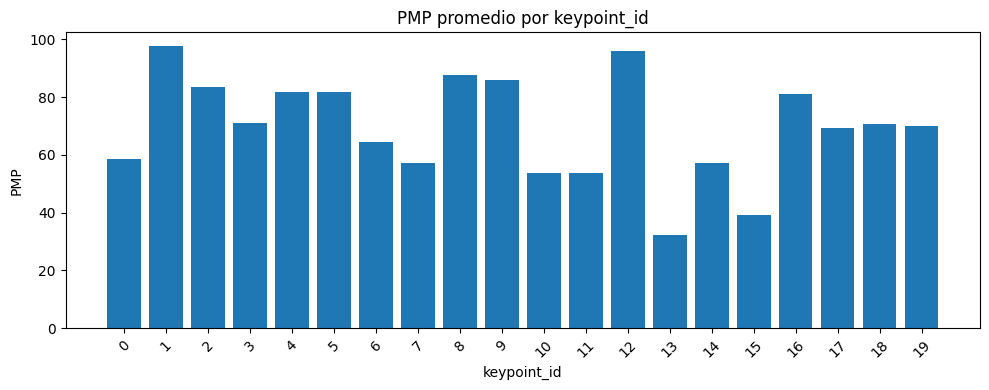

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Leer el CSV
pmp_report__1 = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_LOSSPHENO__LOG(MSE)_pmp_report.csv")

# 2. Si hay varias filas por cada keypoint_id (por ejemplo, por imagen o por época),
#    calculamos el promedio de PMP por keypoint_id.
#    Si ya tienes 1 fila por keypoint_id, igual funciona (no cambia nada).
df_plot = (
    pmp_report__1
    .groupby("keypoint_id", as_index=False)["pmp"]
    .mean()
    .sort_values("keypoint_id")
)

# 3. Hacer el barplot
plt.figure(figsize=(10, 4))
plt.bar(df_plot["keypoint_id"].astype(str), df_plot["pmp"])
plt.xlabel("keypoint_id")
plt.ylabel("PMP")
plt.title("PMP promedio por keypoint_id")

# 4. (Opcional) poner las etiquetas rotadas si son muchas barras
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


## Comparar inferencias PMP

In [21]:
# pmp_report__No_Augmentation
pmp_report__No_Augmentation = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_pmp_report.csv")
#pmp_report__No_Augmentation

# pmp_report__No_Augmentation
pmp_report__Aug_No_GridMask = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_augmented_nogridmask_pmp_report.csv")
#pmp_report__Aug_No_GridMask

# pmp_report__No_Augmentation
pmp_report__Aug_resolution = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_augmentedresolution_pmp_report.csv")
#pmp_report__Aug_resolution

# pmp_report__COMPRESSED_LOSSPHENO
pmp_report__COMPRESSED_LOSSPHENO = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_COMPRESSED_LOSSPHENO_augmentedresolution_pmp_report.csv")
#pmp_report__COMPRESSED_LOSSPHENO

# pmp_report__COMPRESSED_LOSSPHENO02
pmp_report__COMPRESSED_LOSSPHENO02 = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_COMPRESSED_LOSSPHENO_augmentedresolution02_pmp_report.csv")
pmp_report__COMPRESSED_LOSSPHENO02

# pmp_report__COMPRESSED_LOG(MSE)
pmp_report__COMPRESSED_LOG_MSE = pd.read_csv("/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_LOSSPHENO__LOG(MSE)_pmp_report.csv")
pmp_report__COMPRESSED_LOG_MSE



keypoint_id        pmp assoc_phenotype  mean_norm_len_px  \
0             0  58.677686          MaxJaw        294.058149   
1             1  97.520661              SL       3160.503730   
2             2  83.471074             DFL        632.308515   
3             3  71.074380           PcPeD        675.275817   
4             4  81.818182              HD        549.287749   
5             5  81.818182              HD        549.287749   
6             6  64.462810             CPD        343.103504   
7             7  57.024793             CPD        343.103504   
8             8  87.500000             CFD        866.741986   
9             9  85.833333             CFD        866.741986   
10           10  53.719008              ED        262.294990   
11           11  53.719008              ED        262.294990   
12           12  95.867769         EyePelv       1235.765643   
13           13  32.231405          MaxJaw        301.537599   
14           14  57.024793             PcL        542.894398   
15           15  39.166667             PcL        599.965971   
16           16  80.991736              HL        822.509475   
17           17  69.421488             DFL        672.208730   
18           18  70.833333             AFL        572.759052   
19           19  70.000000             AFL        572.759052   

    threshold_10pct_px  
0            29.405815  
1           316.050373  
2            63.230852  
3            67.527582  
4            54.928775  
5            54.928775  
6            34.310350  
7            34.310350  
8            86.674199  
9            86.674199  
10           26.229499  
11           26.229499  
12          123.576564  
13           30.153760  
14           54.289440  
15           59.996597  
16           82.250947  
17           67.220873  
18           57.275905  
19           57.275905

In [17]:
pmp_report__COMPRESSED_LOG_MSE


keypoint_id        pmp assoc_phenotype  mean_norm_len_px  \
0             0  58.677686          MaxJaw        294.058149   
1             1  97.520661              SL       3160.503730   
2             2  83.471074             DFL        632.308515   
3             3  71.074380           PcPeD        675.275817   
4             4  81.818182              HD        549.287749   
5             5  81.818182              HD        549.287749   
6             6  64.462810             CPD        343.103504   
7             7  57.024793             CPD        343.103504   
8             8  87.500000             CFD        866.741986   
9             9  85.833333             CFD        866.741986   
10           10  53.719008              ED        262.294990   
11           11  53.719008              ED        262.294990   
12           12  95.867769         EyePelv       1235.765643   
13           13  32.231405          MaxJaw        301.537599   
14           14  57.024793             PcL        542.894398   
15           15  39.166667             PcL        599.965971   
16           16  80.991736              HL        822.509475   
17           17  69.421488             DFL        672.208730   
18           18  70.833333             AFL        572.759052   
19           19  70.000000             AFL        572.759052   

    threshold_10pct_px  
0            29.405815  
1           316.050373  
2            63.230852  
3            67.527582  
4            54.928775  
5            54.928775  
6            34.310350  
7            34.310350  
8            86.674199  
9            86.674199  
10           26.229499  
11           26.229499  
12          123.576564  
13           30.153760  
14           54.289440  
15           59.996597  
16           82.250947  
17           67.220873  
18           57.275905  
19           57.275905

In [31]:
pmp_report__COMPRESSED_LOSSPHENO['keypoint_id'] = (
    pmp_report__COMPRESSED_LOSSPHENO['keypoint_id'] + 1
)
pmp_report__COMPRESSED_LOSSPHENO

pmp_report__COMPRESSED_LOSSPHENO.to_csv(
    "/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_COMPRESSED_LOSSPHENO_augmentedresolution_pmp_report_reindexed.csv",
    index=False
)

In [32]:
pmp_report__COMPRESSED_LOSSPHENO

keypoint_id        pmp assoc_phenotype  mean_norm_len_px  \
0             1  25.619835          MaxJaw        294.058149   
1             2  95.867769              SL       3160.503730   
2             3  58.677686             DFL        632.308515   
3             4  39.669421           PcPeD        675.275817   
4             5  53.719008              HD        549.287749   
5             6  57.851240              HD        549.287749   
6             7  28.099174             CPD        343.103504   
7             8  27.272727             CPD        343.103504   
8             9  72.500000             CFD        866.741986   
9            10  66.666667             CFD        866.741986   
10           11  17.355372              ED        262.294990   
11           12  24.793388              ED        262.294990   
12           13  87.603306         EyePelv       1235.765643   
13           14  16.528926          MaxJaw        301.537599   
14           15  23.140496             PcL        542.894398   
15           16   7.500000             PcL        599.965971   
16           17  57.851240              HL        822.509475   
17           18  40.495868             DFL        672.208730   
18           19  35.000000             AFL        572.759052   
19           20  25.000000             AFL        572.759052   

    threshold_10pct_px  
0            29.405815  
1           316.050373  
2            63.230852  
3            67.527582  
4            54.928775  
5            54.928775  
6            34.310350  
7            34.310350  
8            86.674199  
9            86.674199  
10           26.229499  
11           26.229499  
12          123.576564  
13           30.153760  
14           54.289440  
15           59.996597  
16           82.250947  
17           67.220873  
18           57.275905  
19           57.275905

In [34]:
pmp_report__COMPRESSED_LOSSPHENO02['keypoint_id'] = (
    pmp_report__COMPRESSED_LOSSPHENO02['keypoint_id'] + 1
)
pmp_report__COMPRESSED_LOSSPHENO02

pmp_report__COMPRESSED_LOSSPHENO02.to_csv(
    "/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_COMPRESSED_LOSSPHENO_augmentedresolution02_pmp_report_reindexed.csv",
    index=False
)

In [35]:
pmp_report__COMPRESSED_LOSSPHENO02

keypoint_id        pmp assoc_phenotype  mean_norm_len_px  \
0             1  24.793388          MaxJaw        294.058149   
1             2  96.694215              SL       3160.503730   
2             3  47.933884             DFL        632.308515   
3             4  41.322314           PcPeD        675.275817   
4             7  29.752066             CPD        343.103504   
5             8  28.099174             CPD        343.103504   
6             9  74.166667             CFD        866.741986   
7            10  70.000000             CFD        866.741986   
8            11  18.181818              ED        262.294990   
9            12  24.793388              ED        262.294990   
10           13  87.603306         EyePelv       1235.765643   
11           14  13.223140          MaxJaw        301.537599   
12           15  23.140496             PcL        542.894398   
13           16  10.833333             PcL        599.965971   
14           17  61.157025              HL        822.509475   
15           18  52.892562             DFL        672.208730   
16           19  30.833333             AFL        572.759052   
17           20  23.333333             AFL        572.759052   

    threshold_10pct_px  
0            29.405815  
1           316.050373  
2            63.230852  
3            67.527582  
4            34.310350  
5            34.310350  
6            86.674199  
7            86.674199  
8            26.229499  
9            26.229499  
10          123.576564  
11           30.153760  
12           54.289440  
13           59.996597  
14           82.250947  
15           67.220873  
16           57.275905  
17           57.275905

In [36]:
pmp_report__COMPRESSED_LOG_MSE['keypoint_id'] = (
    pmp_report__COMPRESSED_LOG_MSE
['keypoint_id'] + 1
)
pmp_report__COMPRESSED_LOG_MSE


pmp_report__COMPRESSED_LOG_MSE.to_csv(
    "/data/Datasets/Fish/CavFish/Predictions/PMP/compressed_LOSSPHENO__LOG(MSE)_pmp_report_reindexed.csv",
    index=False
)

In [38]:
pmp_report__No_Augmentation

keypoint_id        pmp assoc_phenotype  mean_norm_len_px  \
0             1  52.892562          MaxJaw        294.058149   
1             2  97.520661              SL       3160.503730   
2             3  80.991736             DFL        632.308515   
3             4  69.421488           PcPeD        675.275817   
4             5  80.165289              HD        549.287749   
5             6  79.338843              HD        549.287749   
6             7  64.462810             CPD        343.103504   
7             8  57.024793             CPD        343.103504   
8             9  86.666667             CFD        866.741986   
9            10  85.000000             CFD        866.741986   
10           11  50.413223              ED        262.294990   
11           12  55.371901              ED        262.294990   
12           13  95.867769         EyePelv       1235.765643   
13           14  27.272727          MaxJaw        301.537599   
14           15  57.500000             PcL        520.933261   
15           16  30.833333             PcL        599.965971   
16           17  80.991736              HL        822.509475   
17           18  73.504274             DFL        630.225644   
18           19  75.833333             AFL        572.759052   
19           20  72.500000             AFL        572.759052   

    threshold_10pct_px  
0            29.405815  
1           316.050373  
2            63.230852  
3            67.527582  
4            54.928775  
5            54.928775  
6            34.310350  
7            34.310350  
8            86.674199  
9            86.674199  
10           26.229499  
11           26.229499  
12          123.576564  
13           30.153760  
14           52.093326  
15           59.996597  
16           82.250947  
17           63.022564  
18           57.275905  
19           57.275905

In [ ]:

#pmp_report__No_Augmentation
#pmp_report__Aug_No_GridMask
#pmp_report__Aug_resolution
#pmp_report__COMPRESSED_LOSSPHENO
#pmp_report__COMPRESSED_LOSSPHENO02
#pmp_report__COMPRESSED_LOG_MSE

keypoint_id        pmp assoc_phenotype  mean_norm_len_px  \
0             1  25.619835          MaxJaw        294.058149   
1             2  96.694215              SL       3160.503730   
2             3  55.371901             DFL        632.308515   
3             4  35.537190           PcPeD        675.275817   
4             5  49.586777              HD        549.287749   
5             6  54.545455              HD        549.287749   
6             7  23.140496             CPD        343.103504   
7             8  24.793388             CPD        343.103504   
8             9  73.333333             CFD        866.741986   
9            10  65.833333             CFD        866.741986   
10           11  13.223140              ED        262.294990   
11           12  14.049587              ED        262.294990   
12           13  85.950413         EyePelv       1235.765643   
13           14  12.396694          MaxJaw        301.537599   
14           15  29.752066             PcL        542.894398   
15           16   9.166667             PcL        599.965971   
16           17  52.892562              HL        822.509475   
17           18  42.148760             DFL        672.208730   
18           19  24.166667             AFL        572.759052   
19           20  24.166667             AFL        572.759052   

    threshold_10pct_px  
0            29.405815  
1           316.050373  
2            63.230852  
3            67.527582  
4            54.928775  
5            54.928775  
6            34.310350  
7            34.310350  
8            86.674199  
9            86.674199  
10           26.229499  
11           26.229499  
12          123.576564  
13           30.153760  
14           54.289440  
15           59.996597  
16           82.250947  
17           67.220873  
18           57.275905  
19           57.275905

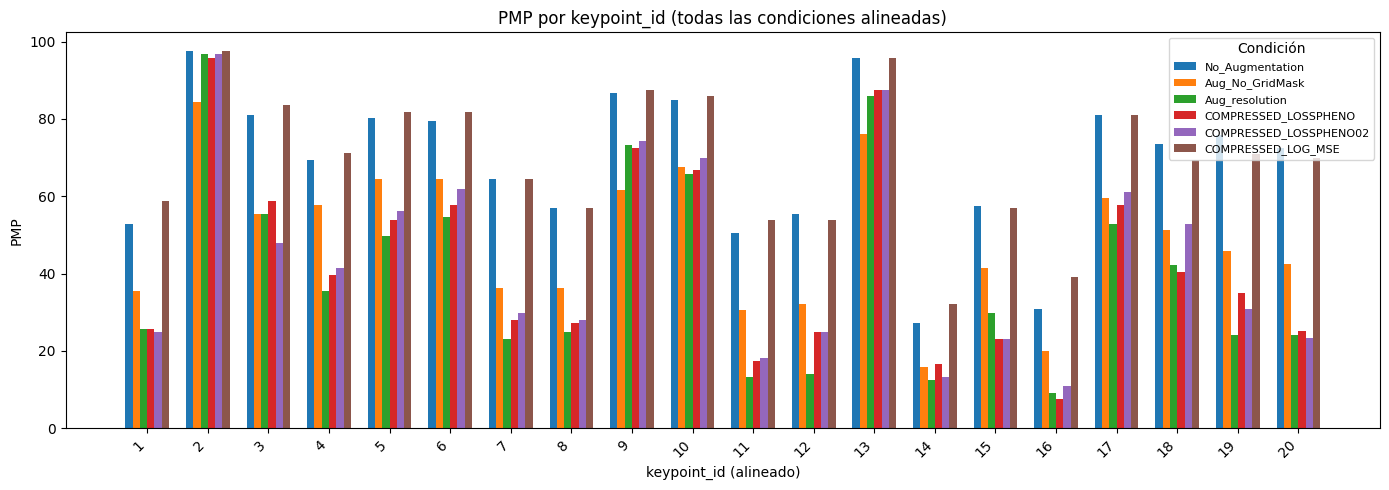

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---- 1. Función para normalizar keypoint_id ----
# Si el mínimo keypoint_id es 0, asumimos que está en rango 0..19 y lo subimos a 1..20
def normalize_keypoints(df):
    df = df.copy()
    if df["keypoint_id"].min() == 0:
        df["keypoint_id"] = df["keypoint_id"] + 1
    return df

# ---- 2. Función para preparar cada dataframe ----
# - Normaliza keypoint_id
# - Agrupa por keypoint_id
# - Calcula el promedio de PMP
# - Renombra columna PMP -> nombre del modelo
def prep(df, label):
    df_norm = normalize_keypoints(df)
    out = (
        df_norm
        .groupby("keypoint_id", as_index=False)["pmp"]
        .mean()
        .rename(columns={"pmp": label})
    )
    return out

# ---- 3. Prepara cada condición ----
df_no_aug          = prep(pmp_report__No_Augmentation,        "No_Augmentation")
df_aug_no_gridmask = prep(pmp_report__Aug_No_GridMask,        "Aug_No_GridMask")
df_aug_res         = prep(pmp_report__Aug_resolution,         "Aug_resolution")

df_losspheno       = prep(pmp_report__COMPRESSED_LOSSPHENO,   "COMPRESSED_LOSSPHENO")
df_losspheno02     = prep(pmp_report__COMPRESSED_LOSSPHENO02, "COMPRESSED_LOSSPHENO02")
df_logmse          = prep(pmp_report__COMPRESSED_LOG_MSE,     "COMPRESSED_LOG_MSE")

# ---- 4. Merge de todo por keypoint_id ----
merged = (
    df_no_aug
    .merge(df_aug_no_gridmask, on="keypoint_id", how="outer")
    .merge(df_aug_res,         on="keypoint_id", how="outer")
    .merge(df_losspheno,       on="keypoint_id", how="outer")
    .merge(df_losspheno02,     on="keypoint_id", how="outer")
    .merge(df_logmse,          on="keypoint_id", how="outer")
)

# Ordenar por keypoint_id (1..20)
merged = merged.sort_values("keypoint_id")

# ---- 5. Plot de barras agrupadas ----
labels_keypoints = merged["keypoint_id"].astype(str).values

model_columns = [
    "No_Augmentation",
    "Aug_No_GridMask",
    "Aug_resolution",
    "COMPRESSED_LOSSPHENO",
    "COMPRESSED_LOSSPHENO02",
    "COMPRESSED_LOG_MSE"
]

num_keypoints = len(labels_keypoints)
num_models = len(model_columns)

x = np.arange(num_keypoints)  # posiciones base en eje X
width = 0.12                  # ancho de cada barra

plt.figure(figsize=(14, 5))

colors = [
    "#1f77b4",  # azul
    "#ff7f0e",  # naranja
    "#2ca02c",  # verde
    "#d62728",  # rojo
    "#9467bd",  # morado
    "#8c564b",  # café
]

for i, col in enumerate(model_columns):
    yvals = merged[col].values
    plt.bar(
        x + i*width - (width*(num_models-1)/2),
        yvals,
        width,
        label=col,
        color=colors[i],
    )

# Etiquetas y formato
plt.xticks(x, labels_keypoints, rotation=45, ha="right")
plt.ylabel("PMP")
plt.xlabel("keypoint_id (alineado)")
plt.title("PMP por keypoint_id (todas las condiciones alineadas)")
plt.legend(title="Condición", fontsize=8)

plt.tight_layout()
plt.show()


# Utils

## Generalization Results

In [31]:
xml_files = [
    "new_catalogs/2020 Bajo Cauca Magdalena.xml",
    "new_catalogs/2020 Bojonawi.xml",
    "new_catalogs/2021 Guaviare.xml",
    "new_catalogs/2022 Ayapel.xml",
    "new_catalogs/2023 Peces San Cipriano Buenaventura.xml",
    "new_catalogs/2024 Tarapoto.xml",

]

json_files_base = [
    "/data/Datasets/Fish/CavFish/base-log/inference_2020-bajo-cauca-magdalena/all_keypoints_predicted_2020-bajo-cauca-magdalena.json",
    "/data/Datasets/Fish/CavFish/base-log/inference_2020-bojonawi/all_keypoints_predicted_2020-bojonawi.json",
    "/data/Datasets/Fish/CavFish/base-log/inference_2021-guaviare/all_keypoints_predicted_2021-guaviare.json",
    "/data/Datasets/Fish/CavFish/base-log/inference_2022-ayapel/all_keypoints_predicted_2022-ayapel.json",
    "/data/Datasets/Fish/CavFish/base-log/inference_2023-peces-san-cipriano-buenaventura/all_keypoints_predicted_2023-peces-san-cipriano-buenaventura.json",
    "/data/Datasets/Fish/CavFish/base-log/inference_2024-tarapoto/all_keypoints_predicted_2024-tarapoto.json",
]
MODEL = "base-log"
results = run_validation_from_xml_json_group(
    xml_files=xml_files,
    json_files=json_files_base,
    model=MODEL,
    filter_label="Compressed body",              # or "Compressed body", "Depressed body", etc.
    alpha=0.05,
    r=0.10,
    base_dir="/data/Datasets/Fish/CavFish",
)
results = run_validation_from_xml_json_group(
    xml_files=xml_files,
    json_files=json_files_base,
    model=MODEL,
    filter_label="Depressed body",              # or "Compressed body", "Depressed body", etc.
    alpha=0.05,
    r=0.10,
    base_dir="/data/Datasets/Fish/CavFish",
)
results = run_validation_from_xml_json_group(
    xml_files=xml_files,
    json_files=json_files_base,
    model=MODEL,
    filter_label="Compressed body_without caudal fin",              # or "Compressed body", "Depressed body", etc.
    alpha=0.05,
    r=0.10,
    base_dir="/data/Datasets/Fish/CavFish",
)
results = run_validation_from_xml_json_group(
    xml_files=xml_files,
    json_files=json_files_base,
    model=MODEL,
    filter_label="Fusiform",              # or "Compressed body", "Depressed body", etc.
    alpha=0.05,
    r=0.10,
    base_dir="/data/Datasets/Fish/CavFish",
)


✅ Saved rows:        /data/Datasets/Fish/CavFish/results/generalization/base-log/compressed/rows.csv
✅ Saved metrics:     /data/Datasets/Fish/CavFish/results/generalization/base-log/compressed/metrics.csv
🐟 PMP report:        /data/Datasets/Fish/CavFish/results/generalization/base-log/compressed/pmp/report.csv
📊 PMP overall:       /data/Datasets/Fish/CavFish/results/generalization/base-log/compressed/pmp/overall.txt
🔍 PMP debug sample:  /data/Datasets/Fish/CavFish/results/generalization/base-log/compressed/pmp/debug_sample.csv
✅ PCK report:        /data/Datasets/Fish/CavFish/results/generalization/base-log/compressed/pck/report.csv
✅ PCK overall:       /data/Datasets/Fish/CavFish/results/generalization/base-log/compressed/pck/overall.txt  (overall=97.771 %)
📐 Phenotype lengths: /data/Datasets/Fish/CavFish/results/generalization/base-log/compressed/phenotypes/phenotype_lengths.csv
🧪 Phenotype stats:   /data/Datasets/Fish/CavFish/results/generalization/base-log/compressed/phenotypes/phe

In [10]:
################################################################################################################
print("2020 BAJO CAUCA MAGDALENA")
print("2020 BAJO CAUCA MAGDALENA - Base+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2020 Bajo Cauca Magdalena.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/base/inference_2020-bajo-cauca-magdalena/all_keypoints_predicted_2020-bajo-cauca-magdalena.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)
print("2020 BAJO CAUCA MAGDALENA - Minphenoloss+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2020 Bajo Cauca Magdalena.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/minphenoloss-log/inference_2020-bajo-cauca-magdalena/all_keypoints_predicted_2020-bajo-cauca-magdalena.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)

################################################################################################################
print("2020 BOJONAWI")
print("2020 BOJONAWI - Base+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2020 Bojonawi.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/base/inference_2020-bojonawi/all_keypoints_predicted_2020-bojonawi.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)
print("2020 BOJONAWI - Minphenoloss+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2020 Bojonawi.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/minphenoloss-log/inference_2020-bojonawi/all_keypoints_predicted_2020-bojonawi.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)

################################################################################################################
print("2021 GUAVIARE")
print("2021 GUAVIARE - Base+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2021 Guaviare.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/base/inference_2021-guaviare/all_keypoints_predicted_2021-guaviare.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)
print("2021 GUAVIARE - Minphenoloss+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2021 Guaviare.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/minphenoloss-log/inference_2021-guaviare/all_keypoints_predicted_2021-guaviare.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)
################################################################################################################
print("2022 AYAPEL")
print("2022 AYAPEL - Base+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2022 Ayapel.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/base/inference_2022-ayapel/all_keypoints_predicted_2022-ayapel.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)
print("2022 AYAPEL - Minphenoloss+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2022 Ayapel.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/minphenoloss-log/inference_2022-ayapel/all_keypoints_predicted_2022-ayapel.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)

################################################################################################################
print("2023 SAN CIPRIANO BUENAVENTURA")
print("2023 SAN CIPRIANO BUENAVENTURA - Base+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2023 Peces San Cipriano Buenaventura.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/base/inference_2023-peces-san-cipriano-buenaventura/all_keypoints_predicted_2023-peces-san-cipriano-buenaventura.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)
print("2023 SAN CIPRIANO BUENAVENTURA - Minphenoloss+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2023 Peces San Cipriano Buenaventura.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/minphenoloss-log/inference_2023-peces-san-cipriano-buenaventura/all_keypoints_predicted_2023-peces-san-cipriano-buenaventura.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)

################################################################################################################
print("TARAPOTO")
print("TARAPOTO - Base+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2024 Tarapoto.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/base/inference_2024-tarapoto/all_keypoints_predicted_2024-tarapoto.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)
print("TARAPOTO - Minphenoloss+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2024 Tarapoto.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/minphenoloss-log//inference_2024-tarapoto/all_keypoints_predicted_2024-tarapoto.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)

2020 BAJO CAUCA MAGDALENA
2020 BAJO CAUCA MAGDALENA - Base+Log

========== OVERALL METRICS ==========
MAE (coords):       30.4535
RMSE (coords):      65.1616
R² (coords):        0.9976
PCK overall:        99.1461 %
PMP overall:        76.5229 %
Phenotype Pearson r:0.9964
Phenotype R²:       0.9929
Phenotype MAPE:     7.0788 %

2020 BAJO CAUCA MAGDALENA - Minphenoloss+Log

========== OVERALL METRICS ==========
MAE (coords):       49.3657
RMSE (coords):      294.2183
R² (coords):        0.9515
PCK overall:        98.1074 %
PMP overall:        76.6285 %
Phenotype Pearson r:0.9929
Phenotype R²:       0.9857
Phenotype MAPE:     7.3364 %

2020 BOJONAWI
2020 BOJONAWI - Base+Log

========== OVERALL METRICS ==========
MAE (coords):       49.6405
RMSE (coords):      163.6447
R² (coords):        0.9843
PCK overall:        96.9706 %
PMP overall:        61.2059 %
Phenotype Pearson r:0.9869
Phenotype R²:       0.9738
Phenotype MAPE:     12.7268 %

2020 BOJONAWI - Minphenoloss+Log

========== OVERALL

In [34]:
################################################################################################################
print("2020 BAJO CAUCA MAGDALENA")
print("2020 BAJO CAUCA MAGDALENA - Base+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2020 Bajo Cauca Magdalena.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/base-log/inference_2020-bajo-cauca-magdalena/all_keypoints_predicted_2020-bajo-cauca-magdalena.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)
print("2020 BAJO CAUCA MAGDALENA - Minphenoloss+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2020 Bajo Cauca Magdalena.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/minphenoloss-log/inference_2020-bajo-cauca-magdalena/all_keypoints_predicted_2020-bajo-cauca-magdalena.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)

################################################################################################################
print("2020 BOJONAWI")
print("2020 BOJONAWI - Base+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2020 Bojonawi.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/base-log/inference_2020-bojonawi/all_keypoints_predicted_2020-bojonawi.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)
print("2020 BOJONAWI - Minphenoloss+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2020 Bojonawi.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/minphenoloss-log/inference_2020-bojonawi/all_keypoints_predicted_2020-bojonawi.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)

################################################################################################################
print("2021 GUAVIARE")
print("2021 GUAVIARE - Base+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2021 Guaviare.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/base-log/inference_2021-guaviare/all_keypoints_predicted_2021-guaviare.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)
print("2021 GUAVIARE - Minphenoloss+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2021 Guaviare.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/minphenoloss-log/inference_2021-guaviare/all_keypoints_predicted_2021-guaviare.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)
################################################################################################################
print("2022 AYAPEL")
print("2022 AYAPEL - Base+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2022 Ayapel.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/base-log/inference_2022-ayapel/all_keypoints_predicted_2022-ayapel.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)
print("2022 AYAPEL - Minphenoloss+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2022 Ayapel.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/minphenoloss-log/inference_2022-ayapel/all_keypoints_predicted_2022-ayapel.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)

################################################################################################################
print("2023 SAN CIPRIANO BUENAVENTURA")
print("2023 SAN CIPRIANO BUENAVENTURA - Base+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2023 Peces San Cipriano Buenaventura.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/base-log/inference_2023-peces-san-cipriano-buenaventura/all_keypoints_predicted_2023-peces-san-cipriano-buenaventura.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)
print("2023 SAN CIPRIANO BUENAVENTURA - Minphenoloss+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2023 Peces San Cipriano Buenaventura.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/minphenoloss-log/inference_2023-peces-san-cipriano-buenaventura/all_keypoints_predicted_2023-peces-san-cipriano-buenaventura.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)

################################################################################################################
print("TARAPOTO")
print("TARAPOTO - Base+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2024 Tarapoto.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/base-log/inference_2024-tarapoto/all_keypoints_predicted_2024-tarapoto.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)
print("TARAPOTO - Minphenoloss+Log")
results = evaluate_from_xml_and_json(
    xml_gt_path="/home/arumota_pupils/Josue/1PECES/MMPose/mmpose/new_catalogs/2024 Tarapoto.xml",
    pred_json_path="/data/Datasets/Fish/CavFish/minphenoloss-log//inference_2024-tarapoto/all_keypoints_predicted_2024-tarapoto.json",
    alpha=0.05,
    r=0.10,
    n_kpts=20,
    phenotype_pairs=PHENOTYPE_PAIRS_1BASED,
)

2020 BAJO CAUCA MAGDALENA
2020 BAJO CAUCA MAGDALENA - Base+Log



========== OVERALL METRICS ==========
MAE (coords):       47.4615
RMSE (coords):      273.8617
R² (coords):        0.9579
PCK overall:        98.1514 %
PMP overall:        76.3468 %
Phenotype Pearson r:0.9785
Phenotype R²:       0.9564
Phenotype MAPE:     8.7771 %

2020 BAJO CAUCA MAGDALENA - Minphenoloss+Log

========== OVERALL METRICS ==========
MAE (coords):       49.3657
RMSE (coords):      294.2183
R² (coords):        0.9515
PCK overall:        98.1074 %
PMP overall:        76.6285 %
Phenotype Pearson r:0.9929
Phenotype R²:       0.9857
Phenotype MAPE:     7.3364 %

2020 BOJONAWI
2020 BOJONAWI - Base+Log

========== OVERALL METRICS ==========
MAE (coords):       49.1295
RMSE (coords):      161.6973
R² (coords):        0.9846
PCK overall:        96.8824 %
PMP overall:        61.9265 %
Phenotype Pearson r:0.9868
Phenotype R²:       0.9736
Phenotype MAPE:     12.4519 %

2020 BOJONAWI - Minphenoloss+Log

========== OVERALL METRICS ==========
MAE (coords):       51.0776
RMSE (coords):

In [22]:
import xml.etree.ElementTree as ET

def _canon_img(p: str) -> str:
    """Normalize + keep only basename for matching GT and preds."""
    p = _canon(p)
    return os.path.basename(p)

def _load_gt_from_cvat_many(xml_files: list[str], n_kpts: int = 20):
    """
    Load GT keypoints + shape labels from multiple CVAT XML files.

    Returns:
      gt_by_name:     image_name -> (20x2) numpy array of GT coords (1-based labels 1..n_kpts; missing -> (0,0))
      label_by_name:  image_name -> optional shape label (e.g. 'Compressed body', 'Depressed body', ...)
      size_by_name:   image_name -> (width, height)
    """
    gt_by_name = {}
    label_by_name = {}
    size_by_name = {}

    # shape labels we care about for filter_label
    preferred_shapes = {
        "Compressed body",
        "Depressed body",
        "Compressed body_without caudal fin",
        "Fusiform",
        "Rounded body",
        "Compressed_body_with_caudal_fin",
        "Compressed_body_ventral_mouth",
    }

    for xml_path in xml_files:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        for img in root.findall("image"):
            raw_name = img.get("name")
            w = float(img.get("width"))
            h = float(img.get("height"))
            name = _canon_img(raw_name)

            size_by_name[name] = (w, h)

            # keypoints: build dict label -> (x,y)
            kp_dict = {}
            for p in img.findall("points"):
                lab = int(p.get("label"))
                x_str, y_str = p.get("points").split(",")
                kp_dict[lab] = (float(x_str), float(y_str))

            # convert to 20x2 array sorted by label 1..n_kpts, fill missing with (0,0)
            arr = np.zeros((n_kpts, 2), dtype=float)
            for lab, (x, y) in kp_dict.items():
                if 1 <= lab <= n_kpts:
                    arr[lab - 1, 0] = x
                    arr[lab - 1, 1] = y
            gt_by_name[name] = arr

            # shape tags
            tags = [t.get("label") for t in img.findall("tag")]
            label = None
            if tags:
                # try to pick one of our preferred shape tags first
                chosen = next((t for t in tags if t in preferred_shapes), tags[0])
                label = chosen
            label_by_name[name] = label

    return gt_by_name, label_by_name, size_by_name


def _load_pred_from_json_many(json_files: list[str], n_kpts: int = 20):
    """
    Load predictions from multiple JSON files of the form:
      { "image": "...", "keypoints": [ {"name": "0", "x":.., "y":..}, ... ] }

    Returns:
      pred_by_name: image_name -> (n_kpts x 2) numpy array of predictions sorted by kp index 0..n_kpts-1.
    """
    pred_by_name = {}

    for pred_path in json_files:
        with open(pred_path, "r") as f:
            data = json.load(f)

        for item in data:
            raw_name = item.get("image", "")
            name = _canon_img(raw_name)

            # sort keypoints by numeric name (0..19)
            kps = item.get("keypoints", [])
            kps_sorted = sorted(kps, key=lambda kp: int(kp["name"]))
            arr = np.zeros((n_kpts, 2), dtype=float)
            for i, kp in enumerate(kps_sorted):
                if i >= n_kpts:
                    break
                arr[i, 0] = float(kp["x"])
                arr[i, 1] = float(kp["y"])
            pred_by_name[name] = arr

    return pred_by_name

# -------------------------------------------------------------
# REQUIRED HELPERS (must run before evaluate_from_xml_and_json)
# -------------------------------------------------------------

import os
import json
import xml.etree.ElementTree as ET
from pathlib import Path
import numpy as np
import pandas as pd

# -------------------------------------------------------------
# This comes from your earlier code:
# -------------------------------------------------------------
def _canon(p: str) -> str:
    """Normalize paths."""
    p = (p or "").strip().replace("\\", "/")
    return p[2:] if p.startswith("./") else p

# -------------------------------------------------------------
# SILENT PCK HELPER
# -------------------------------------------------------------
def _ensure_pck_columns(df: pd.DataFrame,
                        image_base_path: str,
                        alpha: float = 0.05) -> pd.DataFrame:

    need_sizes = not {"width", "height"}.issubset(df.columns)
    need_diag  = "image_diagonal" not in df.columns
    need_thr   = "pck_threshold" not in df.columns
    need_flag_legacy  = "correct_pck_0.05" not in df.columns
    need_flag_std     = "correct_pck" not in df.columns

    # If width/height already exist → do not open image files
    if not need_sizes and need_diag:
        df["image_diagonal"] = np.sqrt(df["width"]**2 + df["height"]**2)

    if need_sizes:
        # Quietly try to read images
        image_sizes = {}
        for img_path in df["image"].astype(str).unique():
            full_path = os.path.join(image_base_path, img_path)
            try:
                from PIL import Image
                with Image.open(full_path) as im:
                    w, h = im.size
                image_sizes[img_path] = (w, h)
            except:
                image_sizes[img_path] = (np.nan, np.nan)

        df["width"]  = df["image"].map(lambda x: image_sizes[x][0])
        df["height"] = df["image"].map(lambda x: image_sizes[x][1])
        df["image_diagonal"] = np.sqrt(df["width"]**2 + df["height"]**2)

    if need_thr:
        df["pck_threshold"] = alpha * df["image_diagonal"]

    if need_flag_std:
        df["correct_pck"] = df["euclidean_error"] < df["pck_threshold"]

    if need_flag_legacy:
        df["correct_pck_0.05"] = df["correct_pck"]

    return df

# -------------------------------------------------------------
# CANONICAL IMAGE NAME MATCHING
# -------------------------------------------------------------
def _canon_img(p: str) -> str:
    p = _canon(p)
    return os.path.basename(p)

# -------------------------------------------------------------
# LOAD CVAT XML (GT)
# -------------------------------------------------------------
def _load_gt_from_cvat(xml_path: str, n_kpts: int = 20):
    xml_path = Path(xml_path)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    gt_by_name = {}
    size_by_name = {}

    for img in root.findall("image"):
        raw = img.get("name")
        w = float(img.get("width"))
        h = float(img.get("height"))
        name = _canon_img(raw)

        size_by_name[name] = (w, h)

        kp_dict = {}
        for p in img.findall("points"):
            k = int(p.get("label"))
            x, y = p.get("points").split(",")
            kp_dict[k] = (float(x), float(y))

        gt_by_name[name] = kp_dict

    return gt_by_name, size_by_name

# -------------------------------------------------------------
# LOAD PREDICTIONS JSON
# -------------------------------------------------------------
def _load_pred_from_json(pred_path: str, n_kpts: int = 20):
    with open(pred_path, "r") as f:
        data = json.load(f)

    pred_by_name = {}
    for item in data:
        raw = item.get("image", "")
        name = _canon_img(raw)
        kps = {}
        for kp in item.get("keypoints", []):
            kp_id = int(kp["name"]) + 1   # 0→1, 1→2, ... 19→20
            kps[kp_id] = (float(kp["x"]), float(kp["y"]))
        pred_by_name[name] = kps

    return pred_by_name


def evaluate_from_xml_and_json(
    xml_gt_path: str,
    pred_json_path: str,
    *,
    alpha: float = 0.05,  # PCK fraction of image diagonal
    r: float = 0.10,      # PMP phenotype threshold
    n_kpts: int = 20,
    phenotype_pairs: dict = PHENOTYPE_PAIRS_1BASED,
):
    """
    Evaluate MAE / RMSE / R² / PCK / PMP / phenotype stats using:
      - GT from CVAT XML (xml_gt_path)
      - predictions from your JSON (pred_json_path)

    IMPORTANT:
      - GT = (0,0) keypoints removed.
      - Only OVERALL metrics printed.
    """

    # ---- Load GT & predictions ----
    gt_by_name, size_by_name = _load_gt_from_cvat(xml_gt_path, n_kpts=n_kpts)
    pred_by_name = _load_pred_from_json(pred_json_path, n_kpts=n_kpts)

    common_images = sorted(set(gt_by_name.keys()) & set(pred_by_name.keys()))
    if not common_images:
        print("⚠️ No overlapping image names between GT and predictions.")
        return None

    # ---- Build rows ----
    rows = []
    for name in common_images:
        gt_kp = gt_by_name[name]
        pr_kp = pred_by_name[name]
        w, h = size_by_name.get(name, (np.nan, np.nan))

        for lab in range(1, n_kpts + 1):
            if lab not in gt_kp or lab not in pr_kp:
                continue

            gt_x, gt_y = gt_kp[lab]
            pred_x, pred_y = pr_kp[lab]

            # Drop GT = (0,0)
            if gt_x == 0.0 and gt_y == 0.0:
                continue

            err = float(np.hypot(pred_x - gt_x, pred_y - gt_y))

            rows.append({
                "image": name,
                "keypoint": lab,
                "gt_x": gt_x, "gt_y": gt_y,
                "pred_x": pred_x, "pred_y": pred_y,
                "euclidean_error": err,
                "width": w,
                "height": h,
            })

    df = pd.DataFrame(rows)
    if df.empty:
        print("⚠️ No valid rows (GT=0 dropped or missing preds).")
        return None

    # ---- PCK columns ----
    df = _ensure_pck_columns(df, image_base_path=".", alpha=alpha)

    # ---- Overall coordinate metrics ----
    metrics = _metrics_from_rows(df)

    # ---- Overall PCK ----
    _, pck_overall_pct = _compute_pck_report(df)

    # ---- Overall PMP ----
    _, pmp_overall_pct, _ = _compute_pmp(df, phenotype_pairs, r=r)

    # ---- Phenotype-level metrics ----
    df_ph = compute_phenotype_lengths(df, phenotype_pairs)
    overall_pheno = compute_overall(df_ph)

    # ---------------------------------------------------------
    # Minimal Printing (ONLY the overalls)
    # ---------------------------------------------------------
    print("\n========== OVERALL METRICS ==========")

    print(f"MAE (coords):       {metrics['MAE']:.4f}")
    print(f"RMSE (coords):      {metrics['RMSE']:.4f}")
    print(f"R² (coords):        {metrics['R2']:.4f}")

    print(f"PCK overall:        {pck_overall_pct:.4f} %")
    print(f"PMP overall:        {pmp_overall_pct:.4f} %")

    print(f"Phenotype Pearson r:{overall_pheno['pearson_r']:.4f}")
    print(f"Phenotype R²:       {overall_pheno['r2']:.4f}")
    print(f"Phenotype MAPE:     {overall_pheno['mape_pct']:.4f} %")

    print("=====================================\n")

    # ---- Pack results for further use ----
    return {
        "rows_df": df,
        "coords_overall_metrics": metrics,
        "pck_overall_pct": float(pck_overall_pct),
        "pmp_overall_pct": float(pmp_overall_pct),
        "phenotype_overall": overall_pheno,
    }


####################
####################
####################

def run_validation_from_xml_json_group(
    xml_files: list[str],
    json_files: list[str],
    model: str,
    *,
    filter_label: str | None = None,
    alpha: float = 0.05,   # for PCK
    r: float = 0.10,       # for PMP threshold
    base_dir: str = "/data/Datasets/Fish/CavFish",
    phenotype_pairs: dict = PHENOTYPE_PAIRS_1BASED,
    n_kpts: int = 20,
):
    """
    Joint validation over multiple catalogs, using CVAT XML GT + prediction JSONs.

    Mirrors the original run_validation() behavior:
      - build per-point rows (euclidean error)
      - optional filter by shape label (Compressed body, Depressed body, etc.)
      - drop GT=(0,0)
      - convert keypoint index to 1-based for phenotype map
      - compute + save:
          rows.csv, metrics.csv
          pmp/report.csv, pmp/overall.txt, pmp/debug_sample.csv
          pck/report.csv, pck/overall.txt
          phenotypes/phenotype_lengths.csv
          phenotypes/phenotype_stats.csv
          phenotypes/overall.json
          metadata.json
    All outputs are joint over all provided XML/JSON files.
    """
    BASE = Path(base_dir)
    IMAGES_BASE = BASE  # kept for compatibility if you still want to open images

    # -------- load GT + predictions (multiple catalogs merged) --------
    gt_by_name, label_by_name, size_by_name = _load_gt_from_cvat_many(xml_files, n_kpts=n_kpts)
    pred_by_name = _load_pred_from_json_many(json_files, n_kpts=n_kpts)

    common_images = sorted(set(gt_by_name.keys()) & set(pred_by_name.keys()))
    if not common_images:
        print("⚠️ No overlapping images between XML group and prediction JSON group.")
        return None

    # -------- compare (unfiltered) --------
    rows = []
    for name in common_images:
        gt_kp = gt_by_name[name].astype("float64", copy=False)   # (n_kpts, 2)
        pred_kp = pred_by_name[name].astype("float64", copy=False)

        dists = np.linalg.norm(pred_kp - gt_kp, axis=1)  # (n_kpts,)

        for i in range(n_kpts):
            gx, gy = gt_kp[i, 0], gt_kp[i, 1]
            px, py = pred_kp[i, 0], pred_kp[i, 1]

            # use string name like original ("0","1",...) for keypoint
            kp_name = str(i)

            rows.append({
                "image": name,
                "keypoint": kp_name,
                "gt_x": float(gx),
                "gt_y": float(gy),
                "pred_x": float(px),
                "pred_y": float(py),
                "euclidean_error": float(dists[i]),
            })

    df = pd.DataFrame(rows)

    # -------- filter by label (if any) --------
    if filter_label:
        df["__label"] = df["image"].map(lambda p: label_by_name.get(_canon(p)))
        df = df[df["__label"] == filter_label].drop(columns="__label").copy()

    # -------- post-process (overwrite in-memory) --------
    # drop rows with GT missing (treat 0,0 as missing) – EXACTLY like original
    df = df[~((df["gt_x"] == 0.0) & (df["gt_y"] == 0.0))].copy()

    # keypoint index to 1-based integers for phenotype map (same logic)
    try:
        df["keypoint"] = pd.to_numeric(df["keypoint"], errors="raise") + 1
    except Exception:
        df["keypoint"] = df.groupby("image").cumcount() + 1

    # width / height from XML sizes (no need to open files)
    df["width"]  = df["image"].map(lambda x: size_by_name.get(x, (np.nan, np.nan))[0])
    df["height"] = df["image"].map(lambda x: size_by_name.get(x, (np.nan, np.nan))[1])
    df["image_diagonal"] = np.sqrt(df["width"]**2 + df["height"]**2)
    df["pck_threshold"] = alpha * df["image_diagonal"]
    df["correct_pck"] = df["euclidean_error"] < df["pck_threshold"]

    # -------- outputs (single final CSV + metrics + PMP) --------
    scope = _label_suffix(filter_label)
    RESULTS_ROOT = BASE / "results" / "generalization"
    OUT_DIR = RESULTS_ROOT / model / scope
    (OUT_DIR / "pmp").mkdir(parents=True, exist_ok=True)

    rows_csv    = OUT_DIR / "rows.csv"
    metrics_csv = OUT_DIR / "metrics.csv"
    pmp_report  = OUT_DIR / "pmp" / "report.csv"
    pmp_overall = OUT_DIR / "pmp" / "overall.txt"
    pmp_debug   = OUT_DIR / "pmp" / "debug_sample.csv"

    # save final rows (post-processed)
    df.to_csv(rows_csv, index=False)

    # metrics on the final (possibly filtered) rows
    m = _metrics_from_rows(df)
    pd.DataFrame([m]).to_csv(metrics_csv, index=False)

    # PMP on the same final rows
    pmp_df, pmp_overall_pct, dj_table = _compute_pmp(df, phenotype_pairs, r=r)
    pmp_df.to_csv(pmp_report, index=False)
    dj_table.head(100).to_csv(pmp_debug, index=False)
    with open(pmp_overall, "w") as f:
        f.write(f"{pmp_overall_pct:.4f}\n")

    # PCK Calculation (on the same filtered df)
    df = _ensure_pck_columns(df, str(BASE), alpha=alpha)

    # ---- PCK per keypoint report (aligned with scope/OUT_DIR) ----
    pck_report_dir = OUT_DIR / "pck"
    pck_report_dir.mkdir(parents=True, exist_ok=True)

    pck_report   = pck_report_dir / "report.csv"
    pck_overall  = pck_report_dir / "overall.txt"

    pck_df, pck_overall_pct = _compute_pck_report(df)
    pck_df.to_csv(pck_report, index=False)
    with open(pck_overall, "w") as f:
        f.write(f"{pck_overall_pct:.4f}\n")

    # ---------------- Phenotype lengths + correlations ----------------
    ph_dir = OUT_DIR / "phenotypes"
    ph_dir.mkdir(parents=True, exist_ok=True)

    df_ph = compute_phenotype_lengths(df, phenotype_pairs)  # ['image','phenotype','gt_len','pred_len']
    pheno_stats = compute_pheno_stats(df_ph)                 # per phenotype
    overall_stats = compute_overall(df_ph)                   # overall

    out_ph_csv   = ph_dir / "phenotype_lengths.csv"
    out_ph_stats = ph_dir / "phenotype_stats.csv"
    out_overall  = ph_dir / "overall.json"

    df_ph.to_csv(out_ph_csv, index=False)
    pheno_stats.to_csv(out_ph_stats, index=False)
    with open(out_overall, "w") as f:
        json.dump(overall_stats, f, indent=2)

    # ---- Metadata for reproducibility ----
    meta = {
        "alpha": alpha, "r": r, "model": model,
        "filter_label": filter_label, "base_dir": str(base_dir),
        "phenotype_pairs": phenotype_pairs,
        "n_rows": int(len(df)),
        "pck_overall_pct": float(pck_overall_pct),
        "pmp_overall_pct": float(pmp_overall_pct),
        "phenotypes_overall": overall_stats,
        "xml_files": [str(p) for p in xml_files],
        "json_files": [str(p) for p in json_files],
    }
    with open(OUT_DIR / "metadata.json", "w") as f:
        json.dump(meta, f, indent=2)

    # ---- Make absolute for nice VS Code links ----
    rows_csv    = rows_csv.resolve()
    metrics_csv = metrics_csv.resolve()
    pmp_report  = pmp_report.resolve()
    pmp_overall = pmp_overall.resolve()
    pmp_debug   = pmp_debug.resolve()
    out_ph_csv  = out_ph_csv.resolve()
    out_ph_stats= out_ph_stats.resolve()
    out_overall = out_overall.resolve()
    pck_report  = pck_report.resolve()
    pck_overall = pck_overall.resolve()

    # ---- Print links (same style as original) ----
    print()
    print(f"✅ Saved rows:        {rows_csv}")
    print(f"✅ Saved metrics:     {metrics_csv}")
    print(f"🐟 PMP report:        {pmp_report}")
    print(f"📊 PMP overall:       {pmp_overall}")
    print(f"🔍 PMP debug sample:  {pmp_debug}")
    print(f"✅ PCK report:        {pck_report}")
    print(f"✅ PCK overall:       {pck_overall}  (overall={pck_overall_pct:.3f} %)")
    print(f"📐 Phenotype lengths: {out_ph_csv}")
    print(f"🧪 Phenotype stats:   {out_ph_stats}")
    print(f"🧾 Phenotype overall: {out_overall}")
    print()

    return {
        "rows_csv": str(rows_csv),
        "metrics_csv": str(metrics_csv),
        "pmp_report": str(pmp_report),
        "pmp_overall": str(pmp_overall),
        "pmp_debug": str(pmp_debug),
        "pck_report": str(pck_report),
        "pck_overall": str(pck_overall),
        "phenotype_lengths": str(out_ph_csv),
        "phenotype_stats": str(out_ph_stats),
        "phenotype_overall": str(out_overall),
        "metadata": str((OUT_DIR / "metadata.json").resolve()),
    }


## Formatting Code

### Multiple XML -> COCO

### Json -> CVAT Formatting Keeping Train/Test

In [3]:
!python cvat_to_coco_from_split.py \
  --xml_root "/data/Datasets/Fish/CavFish/2nd-run/" \
  --split_json "/data/Datasets/Fish/CavFish/fish20kpt_all_val.json" \
  --output_json "/data/Datasets/Fish/CavFish/fish20kpt_all_val_2nd-run.json"

Wrote COCO to: /data/Datasets/Fish/CavFish/fish20kpt_all_val_2nd-run.json
Images in split: 176
Images with CVAT annotations: 176


In [4]:
!python cvat_to_coco_from_split.py \
  --xml_root "/data/Datasets/Fish/CavFish/2nd-run/" \
  --split_json "/data/Datasets/Fish/CavFish/fish20kpt_all_train.json" \
  --output_json "/data/Datasets/Fish/CavFish/fish20kpt_all_train_2nd-run.json"

Wrote COCO to: /data/Datasets/Fish/CavFish/fish20kpt_all_train_2nd-run.json
Images in split: 1582
Images with CVAT annotations: 1582


In [3]:
import os
import json
from pathlib import Path
from PIL import Image
import xml.etree.ElementTree as ET


# ----------------------------------------------------------
# CONFIG
# ----------------------------------------------------------
PRED_JSON = "/data/Datasets/Fish/CavFish/inference_2023-peces-san-cipriano-buenaventura/all_keypoints_predicted_2023-peces-san-cipriano-buenaventura.json"          # JSON predictions
IMAGES_BASE = "/data/Datasets/Fish/CavFish"   # folder where images are located
OUT_XML = "predictions_cvat_peces-san-cipriano-buenaventura-2023.xml"       # output XML file
LABEL_OFFSET = 1                       # JSON names 0–19 → labels 1–20
N_KEYPOINTS = 20                       # number of keypoint labels to declare
TASK_NAME = "model_predictions"        # CVAT task name


# ----------------------------------------------------------
# LOAD PREDICTIONS
# ----------------------------------------------------------
with open(PRED_JSON, "r", encoding="utf-8") as f:
    predictions = json.load(f)


# ----------------------------------------------------------
# PRECOMPUTE IMAGE SIZES
# ----------------------------------------------------------
image_sizes = {}
for item in predictions:
    img_rel = item["image"]
    img_path = Path(IMAGES_BASE) / img_rel
    try:
        with Image.open(img_path) as im:
            w, h = im.size
        image_sizes[img_rel] = (w, h)
    except Exception as e:
        print(f"Could not open {img_path}: {e}")
        image_sizes[img_rel] = (0, 0)


# ----------------------------------------------------------
# BUILD CVAT XML ROOT
# ----------------------------------------------------------
root = ET.Element("annotations")
ET.SubElement(root, "version").text = "1.1"

meta = ET.SubElement(root, "meta")
task = ET.SubElement(meta, "task")
ET.SubElement(task, "name").text = TASK_NAME

labels_el = ET.SubElement(task, "labels")
for i in range(1, N_KEYPOINTS + 1):
    lab = ET.SubElement(labels_el, "label")
    ET.SubElement(lab, "name").text = str(i)
    ET.SubElement(lab, "type").text = "points"


# ----------------------------------------------------------
# ADD IMAGES AND KEYPOINTS
# ----------------------------------------------------------
for img_id, item in enumerate(predictions):
    img_rel = item["image"]
    img_name = os.path.basename(img_rel)      # CVAT expects simple filename
    w, h = image_sizes.get(img_rel, (0, 0))

    image_el = ET.SubElement(root, "image", {
        "id": str(img_id),
        "name": img_name,
        "width": str(w),
        "height": str(h),
    })

    for kp in item["keypoints"]:
        label_id = int(kp["name"]) + LABEL_OFFSET
        x = float(kp["x"])
        y = float(kp["y"])
        score = float(kp["score"])

        points_el = ET.SubElement(image_el, "points", {
            "label": str(label_id),
            "occluded": "0",
            "source": "auto",
            "z_order": "0",
            "points": f"{x:.2f},{y:.2f}",
        })

        attr_el = ET.SubElement(points_el, "attribute", {"name": "score"})
        attr_el.text = f"{score:.6f}"


# ----------------------------------------------------------
# SAVE XML
# ----------------------------------------------------------
tree = ET.ElementTree(root)
tree.write(OUT_XML, encoding="utf-8", xml_declaration=True)

print(f"XML written to: {OUT_XML}")

XML written to: predictions_cvat_peces-san-cipriano-buenaventura-2023.xml
